https://www.kaggle.com/c/lish-moa/overview

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, together with the Laboratory for Innovation Science at Harvard (LISH), presents this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.

In this notebook we will try a Feedforward neural network model.\
We will try to use the new variables defined in the notebook 'MoA_model_lightgbm_PCA'
All data analysis is donne in the "MoA data analysyis" notebook.\

In [1]:
import gc
import time
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done!
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F

#Path to save the output
path_holdout = 'C:\\Users\\maxwi\\Python\\Kaggle\\Mechanism of action\\results 4\\'

In [2]:
#load the Data
train_features = pd.read_csv('train_features.csv')
train_targets_scored = pd.read_csv('train_targets_scored.csv')
test_features = pd.read_csv('test_features.csv')

In [3]:
#Function to reduce memory usage.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_features = reduce_mem_usage(train_features)
train_targets_scored = reduce_mem_usage(train_targets_scored)
test_features = reduce_mem_usage(test_features)

Mem. usage decreased to 40.18 Mb (74.8% reduction)
Mem. usage decreased to  4.86 Mb (87.1% reduction)
Mem. usage decreased to  6.72 Mb (74.8% reduction)


In [5]:
def loss_train_validation(db, rotation_x, save_to):
    '''
    loss_train_validation(db = log_loss_hp, rotation_x = 0, save_to = save_file_final)
    '''
    #Plot train and validation log loss
    fig, ax = plt.subplots(figsize=(15, 10))
    #Train log loss:
    x = db['parameter_index']
    y = db['log_loss_train']

    ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'solid')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s = 64, color = 'white', zorder = 2)
    ax.scatter(x, y, s = 8, color = 'black', zorder = 3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Train', va = 'center')

    #Validation log loss:
#     x = log_loss_hp['parameter']
    y = db['log_loss_validation']

    ax.xaxis.set_ticks(x)
    ax.plot(x, y, color='black', zorder=1, linewidth=0.7, linestyle = 'dashed')
    # add two layers of points to create an illusion of a discontinuous line. "zorder" specifies plotting order
    ax.scatter(x, y, s=64, color='white', zorder=2)
    ax.scatter(x, y, s=8, color='black', zorder=3)
    ax.text(x.iloc[-1] + 0.001, y.iloc[-1], 'Validation', va = 'center')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.xticks(rotation = rotation_x)

    print()
    print('Smallest log loss:', round(db['log_loss_validation'].min(), 4))
    print('Smallest log loss parameter:', db[np.in1d(db['log_loss_validation'], db['log_loss_validation'].min())]['parameter'].values[0])
    log_loss_hp.to_csv(save_to, index = False)

In [6]:
def print_time_to_end(progress_count, step_size, already_read, full_db_size):
    '''
    progress_check = print_time_to_end(progress_count = progress_check, step_size = progress_mult
                            , already_read = progress, full_db_size = len(train_y.columns)*len(hyperparameter))
    '''
#     progress += 1   #Changed to satisfy both situation if loading or not a saved progress.
    if already_read == progress_count * step_size:
        print()
        progress_per = round(already_read / full_db_size, 4)
        print(progress_per)
        
        end = time.time()
        elapsed = int(round(end - start, 0))
        total_run_time =  int(round(elapsed / (progress_per), 0))
        time_to_finish = int(round(elapsed / (progress_per), 0)) - elapsed
        print('Elapsed: {:02d}:{:02d}:{:02d}'.format(elapsed // 3600, (elapsed % 3600 // 60), elapsed % 60))
        print('Total run time: {:02d}:{:02d}:{:02d}'.format(total_run_time // 3600, (total_run_time % 3600 // 60), total_run_time % 60))
        print('Time to finish: {:02d}:{:02d}:{:02d}'.format(time_to_finish // 3600, (time_to_finish % 3600 // 60), time_to_finish % 60))
        print()
        return 1 #Increase progress_count
    
    return 0 #Don't increase progress_count

In [7]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed = 1)

In [8]:
'''
Lets separate train_features and train_targets_scored into train_set and validation_set.
This is important to avoid overfitting.
'''
train_features_set, validation_features_set = train_test_split(train_features, test_size = 0.2, random_state = 1).copy()

train_labels_set = train_targets_scored.iloc[train_features_set.index].copy()
validation_labels_set = train_targets_scored.iloc[validation_features_set.index].copy()

#reset index. We don't really need a index as a number. We can identify our observations by the column 'sig_id'
train_features_set.reset_index(inplace = True)
train_features_set.drop('index', axis = 1, inplace = True)

validation_features_set.reset_index(inplace = True)
validation_features_set.drop('index', axis = 1, inplace = True)

train_labels_set.reset_index(inplace = True)
train_labels_set.drop('index', axis = 1, inplace = True)

validation_labels_set.reset_index(inplace = True)
validation_labels_set.drop('index', axis = 1, inplace = True)


#Remove control observations.
train_features_without_control = train_features_set[train_features_set['cp_type'] != 'ctl_vehicle'].copy()
train_labels_without_control = train_labels_set.iloc[train_features_without_control.index].copy()

#reset index. 
train_features_without_control.reset_index(inplace = True)
train_features_without_control.drop('index', axis = 1, inplace = True)

train_labels_without_control.reset_index(inplace = True)
train_labels_without_control.drop('index', axis = 1, inplace = True)



# For the validation and test, we will remove just the column 'cp_type'.
# However, we will not delete the observations. 
# Instead, we will create a separate data frame with 'cp_type' so we can set all MoA equal to zero for these observations.


validation_features_without_control = validation_features_set.drop(['cp_type'], axis = 1).copy()
validation_features_control = validation_features_set[['sig_id', 'cp_type']].copy()

test_features_without_control = test_features.drop(['cp_type'], axis = 1).copy()
test_features_control = test_features[['sig_id', 'cp_type']].copy()


#These are the same adjustments used before.
train_x = train_features_without_control.drop(['sig_id', 'cp_type'], axis = 1).copy()
test_x = validation_features_without_control.drop(['sig_id'], axis = 1).copy()
test_x_control = validation_features_control.copy()
holdout_x = test_features_without_control.drop(['sig_id'], axis = 1).copy()
holdout_x_control = test_features_control.copy()

train_y = train_labels_without_control.drop(['sig_id'], axis = 1).copy()
test_y = validation_labels_set.drop(['sig_id'], axis = 1).copy()


train_x['cp_dose'] = train_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)
test_x['cp_dose'] = test_x['cp_dose'].str.extract(r"([1-2])", expand = True).astype(np.int8)

C:\Users\maxwi\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


To do the hyperparametrization and the holdout, we should use\
validation_features_without_control and validation_features_control, and\
test_features_without_control and test_features_control

In [9]:
def log_loss_mean(y_real, predictions):
    y_real_db = pd.DataFrame(data = y_real)
    
    log_loss_aux = []
    for col in y_real_db:
        log_loss_aux.append(log_loss(y_real_db[col], predictions[col], labels = [0, 1]))
        
    return np.mean(log_loss_aux)

In [10]:
'''
From: https://github.com/Varal7/ml-tutorial/blob/master/Part2.ipynb
In most ML applications we do mini-batch stochastic gradient descent instead of pure stochastic gradient descent.

Mini-batch SGD is a step between full gradient descent and stochastic gradient descent by computing the average gradient over a small number of examples.

In a nutshell, given n examples:

Full GD: dL/dw = average over all n examples. One step per n examples.
SGD: dL/dw = point estimate over a single example. n steps per n examples.
Mini-batch SGD: dL/dw = average over m << n examples. n / m steps per n examples.
Advantages of mini-batch SGD include a more stable gradient estimate and computational efficiency on modern hardware (exploiting parallelism gives sub-linear to constant time complexity, especially on GPU).

In PyTorch, batched tensors are represented as just another dimension. Most of the deep learning modules assume batched tensors as input (even if the batch size is just 1).

Code from: MITx: 6.86x (Project 3)
'''
def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype=torch.float32),
            'y': torch.tensor(y_data[i:i+batch_size], dtype=torch.long
        )})
    return batches

In [11]:
def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    predictions_np = predictions.detach().numpy()
    y_np = y.detach().numpy()
    return np.mean(np.equal(predictions_np, y_np))


# Training Procedure
def train_model(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov = False, n_epochs=30, save_model = 'FNN'):
# def train_model(train_data, dev_data, model, lr=0.01, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)  #It takes too long! with epochs = 320, lr = 0.1 and batch_size = 32 it did not help.

    for epoch in range(1, n_epochs):
        print("-------------\nEpoch {}:\n".format(epoch))


        # Run **training***
        train_loss, train_acc, train_out = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(train_loss, train_acc))

        # Run **validation**
        dev_loss, dev_acc, dev_out = run_epoch(dev_data, model.eval(), optimizer)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(dev_loss, dev_acc))
        # Save model
        torch.save(model, save_model + '.pt')
    return 


def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']
       
        # Get output predictions
        out = model(x)
        y = y.type_as(out)
        
        
        # Predict and store accuracy      
        predictions = torch.round(out)
        batch_accuracies.append(compute_accuracy(predictions, y))


        # Compute loss
        loss = F.binary_cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy, out


In [287]:
# Hyperparameters: n_epochs; batch_size; lr; momentum

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

n_epochs = 320               #Hyperparameter
batch_size = 32             #Hyperparameter
batch_size_val = len(Y_dev)  
train_batches = batchify_data(X_train, Y_train, batch_size)
dev_batches = batchify_data(X_dev, Y_dev, batch_size)

train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


#################################
## Model specification
model = nn.Sequential(
            nn.Linear(X_train.shape[1], X_train.shape[1]), 
#             nn.BatchNorm1d(X_train.shape[1]),        # Bad!!!
            nn.ReLU(),  
            nn.Linear(X_train.shape[1], 206),  
            nn.Sigmoid(),  #So we have probabilities at the end
        )
lr = 0.1 # Hyperparameter
momentum = 0 # Hyperparameter   #n esterov = True; momentun = 0.1  Did not change, a little worst
##################################

#Train model
train_model(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = True, n_epochs = n_epochs, save_model = 'FNN')
# train_model(train_batches, dev_batches, model, lr = lr, n_epochs = n_epochs)   # Used to try another optimizer.

# Get output.
# Evaluate the model on test data.
loss_train, accuracy_train, out_train = run_epoch(train_batches_full_base, model.eval(), None)
loss_dev, accuracy_dev, out_dev = run_epoch(dev_batches_full_base, model.eval(), None)  

out_train = out_train.detach().numpy()
out_train = pd.DataFrame(data = out_train)

# Adjust out_dev for the control group
out_dev = out_dev.detach().numpy()
# Make a matrix with zeros when control.
treatment_flag = test_x_control['cp_type'] == 'trt_cp'
treatment_flag = np.array([treatment_flag])
treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
out_dev = out_dev*treatment_flag
out_dev = pd.DataFrame(data = out_dev)
    
print()
print('Log loss train:', log_loss_mean(Y_train, out_train))
print('Log loss dev:', log_loss_mean(Y_dev, out_dev))

-------------
Epoch 1:







  0%|          | 0/549 [00:00<?, ?it/s]



  2%|▏         | 11/549 [00:00<00:04, 109.20it/s]



  4%|▍         | 23/549 [00:00<00:04, 109.86it/s]



  6%|▌         | 34/549 [00:00<00:04, 108.69it/s]



  8%|▊         | 46/549 [00:00<00:04, 110.09it/s]



 11%|█         | 58/549 [00:00<00:04, 111.40it/s]



 13%|█▎        | 71/549 [00:00<00:04, 114.64it/s]



 15%|█▌        | 84/549 [00:00<00:03, 116.70it/s]



 17%|█▋        | 95/549 [00:00<00:03, 114.35it/s]



 19%|█▉        | 107/549 [00:00<00:03, 114.42it/s]



 22%|██▏       | 119/549 [00:01<00:03, 113.18it/s]



 24%|██▍       | 131/549 [00:01<00:03, 112.00it/s]



 26%|██▌       | 142/549 [00:01<00:03, 109.18it/s]



 28%|██▊       | 153/549 [00:01<00:03, 107.59it/s]



 30%|██▉       | 164/549 [00:01<00:03, 107.44it/s]



 32%|███▏      | 176/549 [00:01<00:03, 108.60it/s]



 34%|███▍      | 188/549 [00:01<00:03, 109.43it/s]



 36%|███▋      | 200/549 [00:01<00:03, 110.32it/s]



 39%|███▊      | 212/549 [00:01<00:03, 111.

Train loss: 0.374695 | Train accuracy: 0.995411






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 389.39it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 399.93it/s]



100%|██████████| 148/148 [00:00<00:00, 427.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 2:







  0%|          | 0/549 [00:00<?, ?it/s]



  2%|▏         | 13/549 [00:00<00:04, 126.54it/s]



  5%|▍         | 25/549 [00:00<00:04, 122.71it/s]



  7%|▋         | 38/549 [00:00<00:04, 122.10it/s]



  9%|▉         | 50/549 [00:00<00:04, 118.68it/s]



 11%|█         | 61/549 [00:00<00:04, 113.52it/s]



 13%|█▎        | 73/549 [00:00<00:04, 114.49it/s]



 15%|█▌        | 85/549 [00:00<00:04, 115.18it/s]



 17%|█▋        | 96/549 [00:00<00:04, 112.62it/s]



 20%|█▉        | 108/549 [00:00<00:03, 114.50it/s]



 22%|██▏       | 119/549 [00:01<00:03, 109.50it/s]



 24%|██▎       | 130/549 [00:01<00:03, 108.44it/s]



 26%|██▌       | 141/549 [00:01<00:03, 104.65it/s]



 28%|██▊       | 152/549 [00:01<00:03, 100.20it/s]



 30%|██▉       | 162/549 [00:01<00:04, 95.09it/s] 



 31%|███▏      | 172/549 [00:01<00:04, 89.59it/s]



 33%|███▎      | 182/549 [00:01<00:04, 81.89it/s]



 35%|███▍      | 191/549 [00:01<00:04, 78.51it/s]



 36%|███▋      | 200/549 [00:02<00:04, 73.69it

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 457.29it/s]



100%|██████████| 148/148 [00:00<00:00, 431.38it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 3:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 57.85it/s]



  2%|▏         | 13/549 [00:00<00:09, 58.92it/s]



  4%|▎         | 20/549 [00:00<00:08, 59.69it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.12it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.08it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.65it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.53it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.87it/s]



 11%|█         | 58/549 [00:00<00:08, 57.72it/s]



 12%|█▏        | 64/549 [00:01<00:08, 56.61it/s]



 13%|█▎        | 71/549 [00:01<00:08, 57.87it/s]



 14%|█▍        | 78/549 [00:01<00:07, 59.23it/s]



 15%|█▌        | 85/549 [00:01<00:07, 59.61it/s]



 17%|█▋        | 91/549 [00:01<00:07, 57.71it/s]



 18%|█▊        | 97/549 [00:01<00:08, 54.46it/s]



 19%|█▉        | 103/549 [00:01<00:08, 54.83it/s]



 20%|██        | 110/549 [00:01<00:07, 57.24it/s]



 21%|██        | 116/549 [00:01<00:07, 57.26it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.67it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 469.21it/s]



100%|██████████| 148/148 [00:00<00:00, 472.60it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 4:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.23it/s]



  3%|▎         | 14/549 [00:00<00:08, 62.72it/s]



  4%|▍         | 21/549 [00:00<00:08, 62.71it/s]



  5%|▌         | 28/549 [00:00<00:08, 62.69it/s]



  6%|▋         | 35/549 [00:00<00:08, 62.86it/s]



  8%|▊         | 42/549 [00:00<00:08, 62.80it/s]



  9%|▉         | 49/549 [00:00<00:08, 62.42it/s]



 10%|█         | 56/549 [00:00<00:07, 62.33it/s]



 11%|█▏        | 62/549 [00:01<00:07, 61.09it/s]



 12%|█▏        | 68/549 [00:01<00:08, 60.09it/s]



 13%|█▎        | 74/549 [00:01<00:07, 59.57it/s]



 15%|█▍        | 81/549 [00:01<00:07, 60.00it/s]



 16%|█▌        | 88/549 [00:01<00:07, 60.46it/s]



 17%|█▋        | 95/549 [00:01<00:07, 60.79it/s]



 19%|█▊        | 102/549 [00:01<00:07, 61.67it/s]



 20%|█▉        | 109/549 [00:01<00:07, 61.31it/s]



 21%|██        | 116/549 [00:01<00:07, 61.55it/s]



 22%|██▏       | 123/549 [00:02<00:06, 61.39it/s]



 24%|██▎      

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.67it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 463.89it/s]



100%|██████████| 148/148 [00:00<00:00, 466.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 5:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.81it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.81it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.89it/s]



  5%|▍         | 27/549 [00:00<00:08, 62.12it/s]



  6%|▌         | 34/549 [00:00<00:08, 62.62it/s]



  7%|▋         | 40/549 [00:00<00:08, 61.67it/s]



  9%|▊         | 47/549 [00:00<00:08, 61.80it/s]



 10%|▉         | 53/549 [00:00<00:08, 61.11it/s]



 11%|█         | 60/549 [00:00<00:08, 61.09it/s]



 12%|█▏        | 66/549 [00:01<00:08, 60.26it/s]



 13%|█▎        | 73/549 [00:01<00:07, 60.65it/s]



 15%|█▍        | 80/549 [00:01<00:07, 61.08it/s]



 16%|█▌        | 87/549 [00:01<00:07, 61.55it/s]



 17%|█▋        | 94/549 [00:01<00:07, 61.39it/s]



 18%|█▊        | 101/549 [00:01<00:07, 58.52it/s]



 19%|█▉        | 107/549 [00:01<00:07, 55.88it/s]



 21%|██        | 113/549 [00:01<00:07, 55.98it/s]



 22%|██▏       | 119/549 [00:01<00:07, 56.37it/s]



 23%|██▎      

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.37it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 487.05it/s]



100%|██████████| 148/148 [00:00<00:00, 474.11it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 6:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 66.85it/s]



  3%|▎         | 14/549 [00:00<00:08, 65.17it/s]



  4%|▎         | 20/549 [00:00<00:08, 63.38it/s]



  5%|▍         | 26/549 [00:00<00:08, 61.24it/s]



  6%|▌         | 33/549 [00:00<00:08, 61.17it/s]



  7%|▋         | 40/549 [00:00<00:08, 61.45it/s]



  9%|▊         | 47/549 [00:00<00:08, 61.65it/s]



 10%|▉         | 54/549 [00:00<00:08, 61.62it/s]



 11%|█         | 61/549 [00:00<00:07, 61.61it/s]



 12%|█▏        | 68/549 [00:01<00:07, 61.92it/s]



 14%|█▎        | 75/549 [00:01<00:07, 61.01it/s]



 15%|█▍        | 81/549 [00:01<00:07, 60.57it/s]



 16%|█▌        | 87/549 [00:01<00:07, 59.55it/s]



 17%|█▋        | 94/549 [00:01<00:07, 60.14it/s]



 18%|█▊        | 101/549 [00:01<00:07, 60.72it/s]



 20%|█▉        | 108/549 [00:01<00:07, 60.33it/s]



 21%|██        | 115/549 [00:01<00:07, 60.70it/s]



 22%|██▏       | 122/549 [00:02<00:06, 61.12it/s]



 23%|██▎      

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 68%|██████▊   | 100/148 [00:00<00:00, 494.91it/s]



100%|██████████| 148/148 [00:00<00:00, 456.60it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 7:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.86it/s]



  4%|▍         | 21/549 [00:00<00:08, 63.16it/s]



  5%|▌         | 28/549 [00:00<00:08, 63.18it/s]



  6%|▋         | 35/549 [00:00<00:08, 62.86it/s]



  8%|▊         | 42/549 [00:00<00:08, 62.30it/s]



  9%|▉         | 49/549 [00:00<00:08, 61.75it/s]



 10%|█         | 55/549 [00:00<00:08, 59.27it/s]



 11%|█         | 61/549 [00:01<00:08, 59.18it/s]



 12%|█▏        | 68/549 [00:01<00:07, 60.19it/s]



 14%|█▎        | 75/549 [00:01<00:07, 60.75it/s]



 15%|█▍        | 82/549 [00:01<00:07, 60.84it/s]



 16%|█▌        | 89/549 [00:01<00:07, 59.81it/s]



 17%|█▋        | 95/549 [00:01<00:07, 59.56it/s]



 19%|█▊        | 102/549 [00:01<00:07, 59.99it/s]



 20%|█▉        | 108/549 [00:01<00:07, 59.33it/s]



 21%|██        | 115/549 [00:01<00:07, 60.14it/s]



 22%|██▏       | 122/549 [00:02<00:07, 60.56it/s]



 23%|██▎      

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.23it/s]



100%|██████████| 148/148 [00:00<00:00, 493.01it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 8:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 66.21it/s]



  2%|▏         | 13/549 [00:00<00:08, 63.86it/s]



  3%|▎         | 19/549 [00:00<00:08, 62.51it/s]



  5%|▍         | 26/549 [00:00<00:08, 62.39it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.77it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.33it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.23it/s]



  9%|▉         | 51/549 [00:00<00:08, 60.37it/s]



 10%|█         | 57/549 [00:00<00:08, 59.77it/s]



 12%|█▏        | 64/549 [00:01<00:07, 60.93it/s]



 13%|█▎        | 70/549 [00:01<00:07, 60.33it/s]



 14%|█▍        | 77/549 [00:01<00:07, 61.17it/s]



 15%|█▌        | 84/549 [00:01<00:07, 61.29it/s]



 17%|█▋        | 91/549 [00:01<00:07, 60.58it/s]



 18%|█▊        | 98/549 [00:01<00:07, 60.71it/s]



 19%|█▉        | 105/549 [00:01<00:07, 59.27it/s]



 20%|██        | 111/549 [00:01<00:07, 58.83it/s]



 21%|██▏       | 118/549 [00:01<00:07, 59.93it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.51it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 478.05it/s]



100%|██████████| 148/148 [00:00<00:00, 472.60it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 9:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.03it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.22it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.93it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.52it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.78it/s]



  7%|▋         | 39/549 [00:00<00:08, 61.01it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.14it/s]



  9%|▉         | 51/549 [00:00<00:08, 56.75it/s]



 10%|█         | 57/549 [00:00<00:08, 54.74it/s]



 11%|█▏        | 63/549 [00:01<00:08, 54.72it/s]



 13%|█▎        | 70/549 [00:01<00:08, 56.47it/s]



 14%|█▍        | 76/549 [00:01<00:08, 55.77it/s]



 15%|█▍        | 82/549 [00:01<00:08, 56.06it/s]



 16%|█▌        | 88/549 [00:01<00:08, 56.27it/s]



 17%|█▋        | 95/549 [00:01<00:07, 58.48it/s]



 19%|█▊        | 102/549 [00:01<00:07, 59.37it/s]



 20%|█▉        | 108/549 [00:01<00:07, 58.56it/s]



 21%|██        | 114/549 [00:01<00:07, 58.69it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.60it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 465.21it/s]



100%|██████████| 148/148 [00:00<00:00, 445.63it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 10:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.03it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.58it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.28it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.97it/s]



  6%|▌         | 33/549 [00:00<00:08, 61.47it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.62it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.43it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.29it/s]



 10%|█         | 57/549 [00:00<00:08, 59.20it/s]



 11%|█▏        | 63/549 [00:01<00:08, 59.13it/s]



 13%|█▎        | 70/549 [00:01<00:08, 59.84it/s]



 14%|█▍        | 77/549 [00:01<00:07, 60.19it/s]



 15%|█▌        | 83/549 [00:01<00:07, 59.47it/s]



 16%|█▋        | 90/549 [00:01<00:07, 60.24it/s]



 18%|█▊        | 97/549 [00:01<00:07, 60.48it/s]



 19%|█▉        | 104/549 [00:01<00:07, 59.56it/s]



 20%|██        | 110/549 [00:01<00:07, 58.69it/s]



 21%|██▏       | 117/549 [00:01<00:07, 59.52it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 501.34it/s]



100%|██████████| 148/148 [00:00<00:00, 493.01it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 11:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 60.51it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.04it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.18it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.99it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.93it/s]



  7%|▋         | 40/549 [00:00<00:08, 61.12it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.64it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.42it/s]



 11%|█         | 59/549 [00:00<00:08, 60.05it/s]



 12%|█▏        | 65/549 [00:01<00:08, 59.73it/s]



 13%|█▎        | 71/549 [00:01<00:08, 58.46it/s]



 14%|█▍        | 77/549 [00:01<00:08, 58.61it/s]



 15%|█▌        | 84/549 [00:01<00:07, 59.62it/s]



 17%|█▋        | 91/549 [00:01<00:07, 60.66it/s]



 18%|█▊        | 98/549 [00:01<00:07, 61.09it/s]



 19%|█▉        | 105/549 [00:01<00:07, 61.07it/s]



 20%|██        | 112/549 [00:01<00:07, 61.06it/s]



 22%|██▏       | 119/549 [00:01<00:07, 60.27it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 463.89it/s]



100%|██████████| 148/148 [00:00<00:00, 455.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 12:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.81it/s]



  3%|▎         | 14/549 [00:00<00:08, 62.95it/s]



  4%|▍         | 21/549 [00:00<00:08, 62.36it/s]



  5%|▌         | 28/549 [00:00<00:08, 62.29it/s]



  6%|▌         | 34/549 [00:00<00:08, 61.07it/s]



  7%|▋         | 40/549 [00:00<00:08, 60.61it/s]



  9%|▊         | 47/549 [00:00<00:08, 60.74it/s]



 10%|▉         | 54/549 [00:00<00:08, 60.82it/s]



 11%|█         | 60/549 [00:00<00:08, 60.44it/s]



 12%|█▏        | 67/549 [00:01<00:07, 61.25it/s]



 13%|█▎        | 74/549 [00:01<00:07, 61.35it/s]



 15%|█▍        | 81/549 [00:01<00:07, 61.74it/s]



 16%|█▌        | 88/549 [00:01<00:07, 61.52it/s]



 17%|█▋        | 95/549 [00:01<00:07, 60.27it/s]



 18%|█▊        | 101/549 [00:01<00:07, 59.88it/s]



 20%|█▉        | 108/549 [00:01<00:07, 60.69it/s]



 21%|██        | 115/549 [00:01<00:07, 60.32it/s]



 22%|██▏       | 122/549 [00:02<00:07, 60.22it/s]



 23%|██▎      

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.85it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 473.24it/s]



100%|██████████| 148/148 [00:00<00:00, 466.62it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 13:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:09, 59.99it/s]



  3%|▎         | 14/549 [00:00<00:08, 60.30it/s]



  4%|▎         | 20/549 [00:00<00:08, 59.36it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.42it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.21it/s]



  7%|▋         | 40/549 [00:00<00:08, 60.61it/s]



  9%|▊         | 47/549 [00:00<00:08, 60.89it/s]



 10%|▉         | 54/549 [00:00<00:08, 61.09it/s]



 11%|█         | 60/549 [00:00<00:08, 60.26it/s]



 12%|█▏        | 66/549 [00:01<00:08, 59.17it/s]



 13%|█▎        | 72/549 [00:01<00:08, 59.11it/s]



 14%|█▍        | 79/549 [00:01<00:07, 59.97it/s]



 15%|█▌        | 85/549 [00:01<00:07, 59.33it/s]



 17%|█▋        | 92/549 [00:01<00:07, 60.45it/s]



 18%|█▊        | 99/549 [00:01<00:07, 60.78it/s]



 19%|█▉        | 106/549 [00:01<00:07, 61.01it/s]



 21%|██        | 113/549 [00:01<00:07, 61.18it/s]



 22%|██▏       | 120/549 [00:01<00:07, 61.13it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 440.65it/s]



100%|██████████| 148/148 [00:00<00:00, 446.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 14:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 66.23it/s]



  2%|▏         | 13/549 [00:00<00:08, 63.67it/s]



  4%|▎         | 20/549 [00:00<00:08, 63.03it/s]



  5%|▍         | 27/549 [00:00<00:08, 62.25it/s]



  6%|▌         | 33/549 [00:00<00:08, 61.42it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.85it/s]



  8%|▊         | 45/549 [00:00<00:08, 60.10it/s]



  9%|▉         | 52/549 [00:00<00:08, 60.69it/s]



 11%|█         | 58/549 [00:00<00:08, 59.99it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.50it/s]



 13%|█▎        | 70/549 [00:01<00:08, 59.00it/s]



 14%|█▍        | 77/549 [00:01<00:07, 59.59it/s]



 15%|█▌        | 84/549 [00:01<00:07, 60.02it/s]



 16%|█▋        | 90/549 [00:01<00:07, 59.35it/s]



 17%|█▋        | 96/549 [00:01<00:07, 58.72it/s]



 19%|█▊        | 102/549 [00:01<00:07, 58.28it/s]



 20%|█▉        | 109/549 [00:01<00:07, 59.23it/s]



 21%|██        | 115/549 [00:01<00:07, 59.33it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.44it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 483.42it/s]



100%|██████████| 148/148 [00:00<00:00, 462.29it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 15:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:09, 59.99it/s]



  2%|▏         | 13/549 [00:00<00:08, 59.68it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.55it/s]



  5%|▍         | 27/549 [00:00<00:08, 60.85it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.28it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.06it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.51it/s]



  9%|▉         | 52/549 [00:00<00:08, 60.22it/s]



 11%|█         | 58/549 [00:00<00:08, 59.49it/s]



 12%|█▏        | 65/549 [00:01<00:08, 59.94it/s]



 13%|█▎        | 71/549 [00:01<00:08, 58.95it/s]



 14%|█▍        | 78/549 [00:01<00:07, 59.86it/s]



 15%|█▌        | 85/549 [00:01<00:07, 60.21it/s]



 17%|█▋        | 92/549 [00:01<00:07, 60.61it/s]



 18%|█▊        | 99/549 [00:01<00:07, 60.58it/s]



 19%|█▉        | 106/549 [00:01<00:07, 61.03it/s]



 21%|██        | 113/549 [00:01<00:07, 60.87it/s]



 22%|██▏       | 120/549 [00:01<00:07, 60.14it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 483.42it/s]



100%|██████████| 148/148 [00:00<00:00, 460.86it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 16:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 65.60it/s]



  2%|▏         | 13/549 [00:00<00:08, 63.26it/s]



  3%|▎         | 19/549 [00:00<00:08, 61.72it/s]



  5%|▍         | 25/549 [00:00<00:08, 60.51it/s]



  6%|▌         | 31/549 [00:00<00:08, 59.68it/s]



  7%|▋         | 38/549 [00:00<00:08, 60.24it/s]



  8%|▊         | 45/549 [00:00<00:08, 60.63it/s]



  9%|▉         | 52/549 [00:00<00:08, 61.23it/s]



 11%|█         | 59/549 [00:00<00:07, 61.33it/s]



 12%|█▏        | 65/549 [00:01<00:08, 59.53it/s]



 13%|█▎        | 72/549 [00:01<00:07, 60.59it/s]



 14%|█▍        | 78/549 [00:01<00:08, 57.68it/s]



 15%|█▌        | 84/549 [00:01<00:08, 57.56it/s]



 17%|█▋        | 91/549 [00:01<00:07, 58.86it/s]



 18%|█▊        | 97/549 [00:01<00:07, 59.07it/s]



 19%|█▉        | 103/549 [00:01<00:07, 58.18it/s]



 20%|██        | 110/549 [00:01<00:07, 59.01it/s]



 21%|██▏       | 117/549 [00:01<00:07, 59.76it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 462.17it/s]



100%|██████████| 148/148 [00:00<00:00, 453.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 17:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.03it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.43it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.17it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.58it/s]



  6%|▌         | 33/549 [00:00<00:08, 61.03it/s]



  7%|▋         | 40/549 [00:00<00:08, 61.03it/s]



  9%|▊         | 47/549 [00:00<00:08, 61.35it/s]



 10%|▉         | 53/549 [00:00<00:08, 59.90it/s]



 11%|█         | 59/549 [00:00<00:08, 59.62it/s]



 12%|█▏        | 65/549 [00:01<00:08, 58.56it/s]



 13%|█▎        | 71/549 [00:01<00:08, 58.69it/s]



 14%|█▍        | 78/549 [00:01<00:07, 59.67it/s]



 15%|█▌        | 85/549 [00:01<00:07, 60.07it/s]



 17%|█▋        | 92/549 [00:01<00:07, 60.36it/s]



 18%|█▊        | 98/549 [00:01<00:07, 60.12it/s]



 19%|█▉        | 104/549 [00:01<00:07, 59.24it/s]



 20%|██        | 111/549 [00:01<00:07, 59.46it/s]



 21%|██▏       | 117/549 [00:01<00:07, 59.49it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 441.96it/s]



100%|██████████| 148/148 [00:00<00:00, 449.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 18:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  3%|▎         | 14/549 [00:00<00:08, 62.84it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.06it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.24it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.04it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.72it/s]



  8%|▊         | 45/549 [00:00<00:08, 60.57it/s]



  9%|▉         | 51/549 [00:00<00:08, 60.09it/s]



 11%|█         | 58/549 [00:00<00:08, 60.52it/s]



 12%|█▏        | 65/549 [00:01<00:07, 60.67it/s]



 13%|█▎        | 71/549 [00:01<00:07, 59.98it/s]



 14%|█▍        | 77/549 [00:01<00:07, 59.50it/s]



 15%|█▌        | 83/549 [00:01<00:07, 58.31it/s]



 16%|█▋        | 90/549 [00:01<00:07, 59.10it/s]



 17%|█▋        | 96/549 [00:01<00:07, 59.24it/s]



 19%|█▉        | 103/549 [00:01<00:07, 59.92it/s]



 20%|██        | 110/549 [00:01<00:07, 60.72it/s]



 21%|██▏       | 117/549 [00:01<00:07, 59.27it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 506.30it/s]



 67%|██████▋   | 99/148 [00:00<00:00, 496.99it/s]



100%|██████████| 148/148 [00:00<00:00, 481.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 19:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.23it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.70it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.82it/s]



  5%|▍         | 26/549 [00:00<00:08, 61.13it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.47it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.64it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.95it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.83it/s]



 11%|█         | 58/549 [00:00<00:08, 60.19it/s]



 12%|█▏        | 64/549 [00:01<00:08, 60.00it/s]



 13%|█▎        | 71/549 [00:01<00:07, 60.46it/s]



 14%|█▍        | 77/549 [00:01<00:07, 60.19it/s]



 15%|█▌        | 83/549 [00:01<00:07, 59.64it/s]



 16%|█▋        | 90/549 [00:01<00:07, 60.21it/s]



 17%|█▋        | 96/549 [00:01<00:07, 58.96it/s]



 19%|█▊        | 102/549 [00:01<00:07, 58.45it/s]



 20%|█▉        | 108/549 [00:01<00:07, 58.78it/s]



 21%|██        | 114/549 [00:01<00:07, 58.33it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 412.87it/s]



 60%|██████    | 89/148 [00:00<00:00, 426.48it/s]



100%|██████████| 148/148 [00:00<00:00, 444.30it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 20:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.81it/s]



  2%|▏         | 13/549 [00:00<00:08, 62.47it/s]



  3%|▎         | 19/549 [00:00<00:08, 61.38it/s]



  5%|▍         | 25/549 [00:00<00:08, 60.64it/s]



  6%|▌         | 31/549 [00:00<00:08, 59.95it/s]



  7%|▋         | 37/549 [00:00<00:08, 59.84it/s]



  8%|▊         | 44/549 [00:00<00:08, 60.19it/s]



  9%|▉         | 51/549 [00:00<00:08, 60.13it/s]



 11%|█         | 58/549 [00:00<00:08, 60.40it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.97it/s]



 13%|█▎        | 70/549 [00:01<00:08, 59.67it/s]



 14%|█▍        | 76/549 [00:01<00:07, 59.64it/s]



 15%|█▌        | 83/549 [00:01<00:07, 60.51it/s]



 16%|█▌        | 89/549 [00:01<00:07, 59.87it/s]



 17%|█▋        | 95/549 [00:01<00:07, 59.25it/s]



 18%|█▊        | 101/549 [00:01<00:07, 59.34it/s]



 19%|█▉        | 107/549 [00:01<00:07, 58.54it/s]



 21%|██        | 113/549 [00:01<00:07, 56.05it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 61%|██████    | 90/148 [00:00<00:00, 443.66it/s]



100%|██████████| 148/148 [00:00<00:00, 423.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 21:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.81it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.12it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.44it/s]



  5%|▍         | 27/549 [00:00<00:08, 61.80it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.56it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.54it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.14it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.61it/s]



 11%|█         | 59/549 [00:00<00:08, 60.18it/s]



 12%|█▏        | 65/549 [00:01<00:08, 59.64it/s]



 13%|█▎        | 71/549 [00:01<00:08, 57.90it/s]



 14%|█▍        | 77/549 [00:01<00:08, 58.22it/s]



 15%|█▌        | 83/549 [00:01<00:07, 58.61it/s]



 16%|█▌        | 89/549 [00:01<00:07, 57.71it/s]



 17%|█▋        | 96/549 [00:01<00:07, 58.82it/s]



 19%|█▉        | 103/549 [00:01<00:07, 59.46it/s]



 20%|█▉        | 109/549 [00:01<00:07, 55.69it/s]



 21%|██        | 116/549 [00:01<00:07, 57.19it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 407.03it/s]



 60%|██████    | 89/148 [00:00<00:00, 424.52it/s]



100%|██████████| 148/148 [00:00<00:00, 444.30it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 22:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.81it/s]



  3%|▎         | 14/549 [00:00<00:08, 62.95it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.77it/s]



  5%|▍         | 27/549 [00:00<00:08, 61.98it/s]



  6%|▌         | 34/549 [00:00<00:08, 61.85it/s]



  7%|▋         | 40/549 [00:00<00:08, 60.05it/s]



  8%|▊         | 46/549 [00:00<00:08, 58.17it/s]



  9%|▉         | 52/549 [00:00<00:08, 57.74it/s]



 11%|█         | 59/549 [00:00<00:08, 58.54it/s]



 12%|█▏        | 65/549 [00:01<00:08, 58.50it/s]



 13%|█▎        | 72/549 [00:01<00:08, 59.39it/s]



 14%|█▍        | 79/549 [00:01<00:07, 60.18it/s]



 16%|█▌        | 86/549 [00:01<00:07, 61.22it/s]



 17%|█▋        | 93/549 [00:01<00:07, 60.69it/s]



 18%|█▊        | 100/549 [00:01<00:07, 60.95it/s]



 19%|█▉        | 107/549 [00:01<00:07, 60.04it/s]



 21%|██        | 113/549 [00:01<00:07, 59.72it/s]



 22%|██▏       | 120/549 [00:01<00:07, 60.73it/s]



 23%|██▎      

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 446.19it/s]



100%|██████████| 148/148 [00:00<00:00, 442.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 23:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.99it/s]



  2%|▏         | 13/549 [00:00<00:08, 62.67it/s]



  3%|▎         | 19/549 [00:00<00:08, 59.68it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.55it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.07it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.35it/s]



  8%|▊         | 45/549 [00:00<00:08, 60.12it/s]



  9%|▉         | 52/549 [00:00<00:08, 60.86it/s]



 11%|█         | 58/549 [00:00<00:08, 60.28it/s]



 12%|█▏        | 65/549 [00:01<00:07, 60.66it/s]



 13%|█▎        | 72/549 [00:01<00:07, 61.25it/s]



 14%|█▍        | 79/549 [00:01<00:07, 60.40it/s]



 15%|█▌        | 85/549 [00:01<00:07, 59.79it/s]



 17%|█▋        | 91/549 [00:01<00:07, 59.72it/s]



 18%|█▊        | 98/549 [00:01<00:07, 60.11it/s]



 19%|█▉        | 105/549 [00:01<00:07, 60.85it/s]



 20%|██        | 112/549 [00:01<00:07, 60.91it/s]



 22%|██▏       | 119/549 [00:01<00:07, 60.94it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.85it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 470.26it/s]



100%|██████████| 148/148 [00:00<00:00, 463.74it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 24:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.99it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.92it/s]



  4%|▎         | 20/549 [00:00<00:08, 62.36it/s]



  5%|▍         | 27/549 [00:00<00:08, 62.12it/s]



  6%|▌         | 34/549 [00:00<00:08, 61.95it/s]



  7%|▋         | 41/549 [00:00<00:08, 62.33it/s]



  9%|▊         | 47/549 [00:00<00:08, 61.10it/s]



 10%|▉         | 54/549 [00:00<00:08, 61.56it/s]



 11%|█         | 60/549 [00:00<00:08, 60.95it/s]



 12%|█▏        | 66/549 [00:01<00:08, 59.10it/s]



 13%|█▎        | 72/549 [00:01<00:08, 58.89it/s]



 14%|█▍        | 78/549 [00:01<00:08, 58.06it/s]



 15%|█▌        | 85/549 [00:01<00:07, 59.37it/s]



 17%|█▋        | 91/549 [00:01<00:07, 59.43it/s]



 18%|█▊        | 97/549 [00:01<00:07, 59.12it/s]



 19%|█▉        | 104/549 [00:01<00:07, 59.83it/s]



 20%|██        | 111/549 [00:01<00:07, 60.50it/s]



 21%|██▏       | 118/549 [00:01<00:07, 60.35it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 412.87it/s]



 61%|██████    | 90/148 [00:00<00:00, 428.95it/s]



100%|██████████| 148/148 [00:00<00:00, 446.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 25:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 55.70it/s]



  2%|▏         | 12/549 [00:00<00:09, 56.33it/s]



  3%|▎         | 18/549 [00:00<00:09, 56.14it/s]



  5%|▍         | 25/549 [00:00<00:09, 57.81it/s]



  6%|▌         | 31/549 [00:00<00:08, 57.99it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.02it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.00it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.75it/s]



 10%|█         | 57/549 [00:00<00:08, 58.65it/s]



 11%|█▏        | 63/549 [00:01<00:08, 58.92it/s]



 13%|█▎        | 69/549 [00:01<00:08, 58.08it/s]



 14%|█▎        | 75/549 [00:01<00:08, 57.35it/s]



 15%|█▍        | 81/549 [00:01<00:08, 56.69it/s]



 16%|█▌        | 87/549 [00:01<00:08, 56.71it/s]



 17%|█▋        | 93/549 [00:01<00:08, 55.93it/s]



 18%|█▊        | 99/549 [00:01<00:08, 53.48it/s]



 19%|█▉        | 105/549 [00:01<00:08, 53.26it/s]



 20%|██        | 111/549 [00:01<00:08, 52.42it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 459.60it/s]



100%|██████████| 148/148 [00:00<00:00, 462.29it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 26:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.52it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.89it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.44it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.17it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.90it/s]



  8%|▊         | 46/549 [00:00<00:08, 61.42it/s]



 10%|▉         | 53/549 [00:00<00:07, 62.45it/s]



 11%|█         | 59/549 [00:00<00:08, 60.81it/s]



 12%|█▏        | 66/549 [00:01<00:07, 60.88it/s]



 13%|█▎        | 73/549 [00:01<00:07, 60.92it/s]



 14%|█▍        | 79/549 [00:01<00:07, 60.33it/s]



 15%|█▌        | 85/549 [00:01<00:07, 58.52it/s]



 17%|█▋        | 91/549 [00:01<00:07, 58.15it/s]



 18%|█▊        | 98/549 [00:01<00:07, 59.28it/s]



 19%|█▉        | 104/549 [00:01<00:07, 57.99it/s]



 20%|██        | 111/549 [00:01<00:07, 59.32it/s]



 21%|██▏       | 118/549 [00:01<00:07, 59.98it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.92it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 440.68it/s]



100%|██████████| 148/148 [00:00<00:00, 440.36it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 27:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.69it/s]



  4%|▍         | 21/549 [00:00<00:08, 63.21it/s]



  5%|▍         | 27/549 [00:00<00:08, 62.07it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.01it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.17it/s]



  8%|▊         | 45/549 [00:00<00:08, 58.25it/s]



  9%|▉         | 51/549 [00:00<00:08, 58.47it/s]



 10%|█         | 57/549 [00:00<00:08, 58.28it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.23it/s]



 13%|█▎        | 70/549 [00:01<00:08, 59.33it/s]



 14%|█▍        | 76/549 [00:01<00:07, 59.40it/s]



 15%|█▍        | 82/549 [00:01<00:07, 58.93it/s]



 16%|█▌        | 88/549 [00:01<00:07, 58.26it/s]



 17%|█▋        | 95/549 [00:01<00:07, 59.06it/s]



 18%|█▊        | 101/549 [00:01<00:07, 58.52it/s]



 19%|█▉        | 107/549 [00:01<00:07, 58.66it/s]



 21%|██        | 114/549 [00:01<00:07, 59.35it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 491.51it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 482.27it/s]



100%|██████████| 148/148 [00:00<00:00, 448.32it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 28:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.23it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.77it/s]



  3%|▎         | 19/549 [00:00<00:08, 59.68it/s]



  5%|▍         | 25/549 [00:00<00:08, 59.65it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.37it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.72it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.12it/s]



  9%|▉         | 51/549 [00:00<00:08, 58.74it/s]



 11%|█         | 58/549 [00:00<00:08, 59.26it/s]



 12%|█▏        | 64/549 [00:01<00:08, 58.48it/s]



 13%|█▎        | 70/549 [00:01<00:08, 58.29it/s]



 14%|█▍        | 76/549 [00:01<00:08, 58.67it/s]



 15%|█▍        | 82/549 [00:01<00:08, 57.25it/s]



 16%|█▌        | 88/549 [00:01<00:07, 57.76it/s]



 17%|█▋        | 94/549 [00:01<00:07, 57.13it/s]



 18%|█▊        | 100/549 [00:01<00:07, 57.84it/s]



 19%|█▉        | 107/549 [00:01<00:07, 58.76it/s]



 21%|██        | 114/549 [00:01<00:07, 60.03it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 67%|██████▋   | 99/148 [00:00<00:00, 487.95it/s]



100%|██████████| 148/148 [00:00<00:00, 472.60it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 29:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  2%|▏         | 13/549 [00:00<00:08, 59.68it/s]



  3%|▎         | 19/549 [00:00<00:09, 57.76it/s]



  4%|▍         | 24/549 [00:00<00:09, 54.70it/s]



  5%|▌         | 29/549 [00:00<00:09, 52.41it/s]



  6%|▌         | 34/549 [00:00<00:10, 51.39it/s]



  7%|▋         | 40/549 [00:00<00:09, 53.45it/s]



  9%|▊         | 47/549 [00:00<00:09, 55.52it/s]



 10%|▉         | 53/549 [00:00<00:08, 56.67it/s]



 11%|█         | 59/549 [00:01<00:08, 57.51it/s]



 12%|█▏        | 66/549 [00:01<00:08, 58.67it/s]



 13%|█▎        | 72/549 [00:01<00:08, 58.59it/s]



 14%|█▍        | 78/549 [00:01<00:08, 58.54it/s]



 15%|█▌        | 85/549 [00:01<00:08, 57.66it/s]



 17%|█▋        | 91/549 [00:01<00:07, 58.22it/s]



 18%|█▊        | 98/549 [00:01<00:07, 59.33it/s]



 19%|█▉        | 104/549 [00:01<00:07, 58.36it/s]



 20%|██        | 110/549 [00:01<00:07, 58.72it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.44it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 473.81it/s]



100%|██████████| 148/148 [00:00<00:00, 448.33it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 30:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 66.84it/s]



  3%|▎         | 14/549 [00:00<00:08, 65.17it/s]



  4%|▎         | 20/549 [00:00<00:08, 62.78it/s]



  5%|▍         | 26/549 [00:00<00:08, 61.78it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.73it/s]



  7%|▋         | 38/549 [00:00<00:08, 60.01it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.17it/s]



  9%|▉         | 50/549 [00:00<00:08, 58.26it/s]



 10%|█         | 56/549 [00:00<00:08, 55.25it/s]



 11%|█▏        | 62/549 [00:01<00:08, 54.93it/s]



 12%|█▏        | 68/549 [00:01<00:08, 54.56it/s]



 13%|█▎        | 74/549 [00:01<00:08, 54.75it/s]



 15%|█▍        | 80/549 [00:01<00:08, 54.88it/s]



 16%|█▌        | 86/549 [00:01<00:08, 54.97it/s]



 17%|█▋        | 92/549 [00:01<00:08, 54.89it/s]



 18%|█▊        | 98/549 [00:01<00:08, 55.59it/s]



 19%|█▉        | 104/549 [00:01<00:07, 56.73it/s]



 20%|██        | 110/549 [00:01<00:07, 57.22it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.73it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 452.51it/s]



100%|██████████| 148/148 [00:00<00:00, 453.79it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 31:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.11it/s]



  3%|▎         | 14/549 [00:00<00:08, 61.78it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.10it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.91it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.55it/s]



  7%|▋         | 40/549 [00:00<00:08, 61.01it/s]



  9%|▊         | 47/549 [00:00<00:08, 61.02it/s]



 10%|▉         | 53/549 [00:00<00:08, 60.58it/s]



 11%|█         | 60/549 [00:00<00:08, 60.71it/s]



 12%|█▏        | 66/549 [00:01<00:08, 60.18it/s]



 13%|█▎        | 73/549 [00:01<00:07, 60.43it/s]



 14%|█▍        | 79/549 [00:01<00:07, 59.28it/s]



 15%|█▌        | 85/549 [00:01<00:08, 57.83it/s]



 17%|█▋        | 91/549 [00:01<00:07, 58.17it/s]



 18%|█▊        | 98/549 [00:01<00:07, 59.15it/s]



 19%|█▉        | 104/549 [00:01<00:07, 59.27it/s]



 20%|██        | 110/549 [00:01<00:07, 59.36it/s]



 21%|██        | 116/549 [00:01<00:07, 59.42it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 373.54it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 398.45it/s]



100%|██████████| 148/148 [00:00<00:00, 407.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 32:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  3%|▎         | 14/549 [00:00<00:08, 62.50it/s]



  4%|▍         | 21/549 [00:00<00:08, 62.30it/s]



  5%|▍         | 27/549 [00:00<00:08, 61.26it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.75it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.85it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.58it/s]



  9%|▉         | 52/549 [00:00<00:08, 60.17it/s]



 11%|█         | 58/549 [00:00<00:08, 59.45it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.48it/s]



 13%|█▎        | 70/549 [00:01<00:08, 58.98it/s]



 14%|█▍        | 77/549 [00:01<00:07, 59.89it/s]



 15%|█▌        | 84/549 [00:01<00:07, 60.70it/s]



 17%|█▋        | 91/549 [00:01<00:07, 60.80it/s]



 18%|█▊        | 98/549 [00:01<00:07, 60.24it/s]



 19%|█▉        | 105/549 [00:01<00:07, 59.40it/s]



 20%|██        | 111/549 [00:01<00:07, 59.45it/s]



 21%|██▏       | 118/549 [00:01<00:07, 60.07it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 491.51it/s]



100%|██████████| 148/148 [00:00<00:00, 489.76it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 33:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.03it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.04it/s]



  3%|▎         | 19/549 [00:00<00:08, 59.19it/s]



  5%|▍         | 25/549 [00:00<00:08, 59.13it/s]



  6%|▌         | 31/549 [00:00<00:08, 59.08it/s]



  7%|▋         | 37/549 [00:00<00:08, 59.23it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.76it/s]



  9%|▉         | 50/549 [00:00<00:08, 59.79it/s]



 10%|█         | 56/549 [00:00<00:08, 59.72it/s]



 11%|█▏        | 62/549 [00:01<00:08, 59.67it/s]



 12%|█▏        | 68/549 [00:01<00:08, 59.64it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.74it/s]



 15%|█▍        | 80/549 [00:01<00:08, 58.13it/s]



 16%|█▌        | 86/549 [00:01<00:07, 58.56it/s]



 17%|█▋        | 93/549 [00:01<00:07, 59.28it/s]



 18%|█▊        | 99/549 [00:01<00:07, 59.36it/s]



 19%|█▉        | 105/549 [00:01<00:07, 59.42it/s]



 20%|██        | 111/549 [00:01<00:07, 58.09it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.73it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 448.36it/s]



100%|██████████| 148/148 [00:00<00:00, 439.00it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 34:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  2%|▏         | 13/549 [00:00<00:08, 62.28it/s]



  3%|▎         | 19/549 [00:00<00:08, 61.25it/s]



  5%|▍         | 25/549 [00:00<00:08, 60.19it/s]



  6%|▌         | 31/549 [00:00<00:08, 59.82it/s]



  7%|▋         | 37/549 [00:00<00:08, 58.35it/s]



  8%|▊         | 43/549 [00:00<00:09, 55.93it/s]



  9%|▉         | 49/549 [00:00<00:09, 55.24it/s]



 10%|█         | 55/549 [00:00<00:09, 54.63it/s]



 11%|█         | 61/549 [00:01<00:08, 55.86it/s]



 12%|█▏        | 67/549 [00:01<00:08, 56.92it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.10it/s]



 15%|█▍        | 80/549 [00:01<00:08, 56.71it/s]



 16%|█▌        | 86/549 [00:01<00:08, 56.09it/s]



 17%|█▋        | 92/549 [00:01<00:08, 56.93it/s]



 18%|█▊        | 98/549 [00:01<00:07, 56.71it/s]



 19%|█▉        | 105/549 [00:01<00:07, 57.66it/s]



 20%|██        | 112/549 [00:01<00:07, 59.22it/s]



 22%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 481.97it/s]



100%|██████████| 148/148 [00:00<00:00, 465.14it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 35:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 59.56it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.00it/s]



  3%|▎         | 19/549 [00:00<00:08, 59.34it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.14it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.08it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.23it/s]



  8%|▊         | 44/549 [00:00<00:08, 57.38it/s]



  9%|▉         | 50/549 [00:00<00:08, 55.76it/s]



 10%|█         | 56/549 [00:00<00:09, 53.65it/s]



 11%|█▏        | 62/549 [00:01<00:09, 53.67it/s]



 12%|█▏        | 68/549 [00:01<00:08, 53.83it/s]



 13%|█▎        | 74/549 [00:01<00:08, 54.53it/s]



 15%|█▍        | 80/549 [00:01<00:08, 55.17it/s]



 16%|█▌        | 86/549 [00:01<00:08, 56.11it/s]



 17%|█▋        | 93/549 [00:01<00:07, 58.07it/s]



 18%|█▊        | 100/549 [00:01<00:07, 58.93it/s]



 19%|█▉        | 107/549 [00:01<00:07, 59.54it/s]



 21%|██        | 114/549 [00:01<00:07, 60.60it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 478.69it/s]



100%|██████████| 148/148 [00:00<00:00, 465.19it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 36:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  3%|▎         | 14/549 [00:00<00:08, 62.17it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.18it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.14it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.79it/s]



  7%|▋         | 38/549 [00:00<00:08, 58.33it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.26it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.35it/s]



 11%|█         | 58/549 [00:00<00:08, 59.85it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.41it/s]



 13%|█▎        | 71/549 [00:01<00:07, 60.19it/s]



 14%|█▍        | 77/549 [00:01<00:07, 60.00it/s]



 15%|█▌        | 83/549 [00:01<00:07, 59.34it/s]



 16%|█▋        | 90/549 [00:01<00:07, 59.99it/s]



 18%|█▊        | 97/549 [00:01<00:07, 60.46it/s]



 19%|█▉        | 104/549 [00:01<00:07, 60.63it/s]



 20%|██        | 111/549 [00:01<00:07, 61.07it/s]



 21%|██▏       | 118/549 [00:01<00:07, 61.06it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.81it/s]



 61%|██████    | 90/148 [00:00<00:00, 442.58it/s]



100%|██████████| 148/148 [00:00<00:00, 445.63it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 37:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.57it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.95it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.30it/s]



  5%|▍         | 27/549 [00:00<00:08, 61.22it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.17it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.45it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.13it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.26it/s]



 10%|█         | 57/549 [00:00<00:08, 59.18it/s]



 11%|█▏        | 63/549 [00:01<00:08, 59.29it/s]



 13%|█▎        | 70/549 [00:01<00:07, 60.11it/s]



 14%|█▍        | 76/549 [00:01<00:08, 58.38it/s]



 15%|█▍        | 82/549 [00:01<00:07, 58.39it/s]



 16%|█▌        | 88/549 [00:01<00:08, 57.06it/s]



 17%|█▋        | 94/549 [00:01<00:07, 57.79it/s]



 18%|█▊        | 100/549 [00:01<00:07, 56.66it/s]



 19%|█▉        | 106/549 [00:01<00:07, 56.69it/s]



 20%|██        | 112/549 [00:01<00:07, 57.36it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 501.34it/s]



 67%|██████▋   | 99/148 [00:00<00:00, 492.11it/s]



100%|██████████| 148/148 [00:00<00:00, 462.29it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 38:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.11it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.95it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.13it/s]



  5%|▍         | 27/549 [00:00<00:08, 61.26it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.20it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.65it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.06it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.38it/s]



 11%|█         | 59/549 [00:00<00:08, 60.48it/s]



 12%|█▏        | 65/549 [00:01<00:08, 60.20it/s]



 13%|█▎        | 71/549 [00:01<00:08, 59.65it/s]



 14%|█▍        | 78/549 [00:01<00:07, 60.22it/s]



 15%|█▌        | 84/549 [00:01<00:07, 59.66it/s]



 17%|█▋        | 91/549 [00:01<00:07, 60.37it/s]



 18%|█▊        | 98/549 [00:01<00:07, 59.95it/s]



 19%|█▉        | 104/549 [00:01<00:07, 59.48it/s]



 20%|██        | 111/549 [00:01<00:07, 60.09it/s]



 21%|██▏       | 117/549 [00:01<00:07, 59.93it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 431.89it/s]



100%|██████████| 148/148 [00:00<00:00, 430.13it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 39:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.11it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.33it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.06it/s]



  5%|▍         | 25/549 [00:00<00:08, 59.73it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.96it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.28it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.88it/s]



  9%|▉         | 52/549 [00:00<00:08, 60.22it/s]



 11%|█         | 58/549 [00:00<00:08, 60.02it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.89it/s]



 13%|█▎        | 71/549 [00:01<00:07, 60.38it/s]



 14%|█▍        | 77/549 [00:01<00:07, 59.46it/s]



 15%|█▌        | 83/549 [00:01<00:07, 58.62it/s]



 16%|█▌        | 89/549 [00:01<00:07, 58.73it/s]



 17%|█▋        | 95/549 [00:01<00:07, 58.80it/s]



 18%|█▊        | 101/549 [00:01<00:07, 58.86it/s]



 20%|█▉        | 108/549 [00:01<00:07, 59.95it/s]



 21%|██        | 114/549 [00:01<00:07, 59.83it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.69it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 429.63it/s]



100%|██████████| 148/148 [00:00<00:00, 426.43it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 40:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.72it/s]



  2%|▏         | 12/549 [00:00<00:09, 54.30it/s]



  3%|▎         | 17/549 [00:00<00:10, 52.31it/s]



  4%|▍         | 23/549 [00:00<00:10, 52.31it/s]



  5%|▌         | 29/549 [00:00<00:09, 53.43it/s]



  6%|▋         | 35/549 [00:00<00:09, 53.37it/s]



  7%|▋         | 41/549 [00:00<00:09, 53.19it/s]



  9%|▊         | 48/549 [00:00<00:09, 55.45it/s]



 10%|▉         | 54/549 [00:00<00:08, 56.47it/s]



 11%|█         | 60/549 [00:01<00:08, 57.20it/s]



 12%|█▏        | 67/549 [00:01<00:08, 58.73it/s]



 13%|█▎        | 74/549 [00:01<00:07, 59.41it/s]



 15%|█▍        | 81/549 [00:01<00:07, 60.19it/s]



 16%|█▌        | 87/549 [00:01<00:07, 59.82it/s]



 17%|█▋        | 93/549 [00:01<00:07, 59.57it/s]



 18%|█▊        | 99/549 [00:01<00:07, 58.70it/s]



 19%|█▉        | 105/549 [00:01<00:07, 58.95it/s]



 20%|██        | 111/549 [00:01<00:07, 59.14it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 455.26it/s]



100%|██████████| 148/148 [00:00<00:00, 458.01it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 41:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.70it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.68it/s]



  5%|▍         | 25/549 [00:00<00:08, 60.34it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.70it/s]



  7%|▋         | 38/549 [00:00<00:08, 60.36it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.58it/s]



  9%|▉         | 50/549 [00:00<00:08, 59.58it/s]



 10%|█         | 56/549 [00:00<00:08, 59.40it/s]



 11%|█▏        | 62/549 [00:01<00:08, 58.24it/s]



 12%|█▏        | 68/549 [00:01<00:08, 58.12it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.38it/s]



 15%|█▍        | 81/549 [00:01<00:07, 59.30it/s]



 16%|█▌        | 88/549 [00:01<00:07, 59.96it/s]



 17%|█▋        | 95/549 [00:01<00:07, 60.91it/s]



 19%|█▊        | 102/549 [00:01<00:07, 59.40it/s]



 20%|█▉        | 109/549 [00:01<00:07, 60.03it/s]



 21%|██        | 115/549 [00:01<00:07, 57.99it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 506.30it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 488.76it/s]



100%|██████████| 148/148 [00:00<00:00, 466.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 42:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 65.60it/s]



  2%|▏         | 13/549 [00:00<00:08, 63.46it/s]



  3%|▎         | 19/549 [00:00<00:08, 62.24it/s]



  5%|▍         | 26/549 [00:00<00:08, 61.87it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.79it/s]



  7%|▋         | 39/549 [00:00<00:08, 61.18it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.61it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.87it/s]



 11%|█         | 59/549 [00:00<00:08, 60.53it/s]



 12%|█▏        | 65/549 [00:01<00:08, 59.52it/s]



 13%|█▎        | 71/549 [00:01<00:08, 57.98it/s]



 14%|█▍        | 77/549 [00:01<00:08, 57.78it/s]



 15%|█▌        | 83/549 [00:01<00:08, 57.96it/s]



 16%|█▋        | 90/549 [00:01<00:07, 59.00it/s]



 17%|█▋        | 96/549 [00:01<00:07, 58.14it/s]



 19%|█▊        | 102/549 [00:01<00:07, 58.56it/s]



 20%|█▉        | 109/549 [00:01<00:07, 59.43it/s]



 21%|██        | 115/549 [00:01<00:07, 59.30it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 457.24it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 43:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.11it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.95it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.35it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.55it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.38it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.42it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.46it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.93it/s]



 11%|█         | 58/549 [00:00<00:08, 59.82it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.56it/s]



 13%|█▎        | 70/549 [00:01<00:08, 59.39it/s]



 14%|█▍        | 76/549 [00:01<00:07, 59.44it/s]



 15%|█▍        | 82/549 [00:01<00:07, 59.48it/s]



 16%|█▌        | 89/549 [00:01<00:07, 60.24it/s]



 17%|█▋        | 95/549 [00:01<00:07, 59.68it/s]



 18%|█▊        | 101/549 [00:01<00:07, 58.26it/s]



 19%|█▉        | 107/549 [00:01<00:07, 58.30it/s]



 21%|██        | 113/549 [00:01<00:07, 57.66it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 458.26it/s]



100%|██████████| 148/148 [00:00<00:00, 442.97it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 44:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.57it/s]



  3%|▎         | 14/549 [00:00<00:08, 61.41it/s]



  4%|▍         | 21/549 [00:00<00:08, 61.45it/s]



  5%|▌         | 28/549 [00:00<00:08, 61.81it/s]



  6%|▋         | 35/549 [00:00<00:08, 61.42it/s]



  8%|▊         | 42/549 [00:00<00:08, 61.46it/s]



  9%|▊         | 48/549 [00:00<00:08, 60.15it/s]



 10%|█         | 55/549 [00:00<00:08, 60.26it/s]



 11%|█         | 61/549 [00:01<00:08, 59.69it/s]



 12%|█▏        | 67/549 [00:01<00:08, 58.95it/s]



 13%|█▎        | 73/549 [00:01<00:08, 58.44it/s]



 15%|█▍        | 80/549 [00:01<00:07, 60.11it/s]



 16%|█▌        | 86/549 [00:01<00:07, 59.77it/s]



 17%|█▋        | 92/549 [00:01<00:07, 58.66it/s]



 18%|█▊        | 99/549 [00:01<00:07, 59.65it/s]



 19%|█▉        | 105/549 [00:01<00:07, 59.63it/s]



 20%|██        | 111/549 [00:01<00:07, 59.26it/s]



 21%|██▏       | 117/549 [00:01<00:07, 58.83it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 416.51it/s]



100%|██████████| 148/148 [00:00<00:00, 370.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 45:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.57it/s]



  3%|▎         | 14/549 [00:00<00:08, 61.57it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.22it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.49it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.51it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.42it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.45it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.31it/s]



 11%|█         | 58/549 [00:00<00:08, 60.12it/s]



 12%|█▏        | 65/549 [00:01<00:08, 60.39it/s]



 13%|█▎        | 71/549 [00:01<00:07, 59.78it/s]



 14%|█▍        | 77/549 [00:01<00:07, 59.01it/s]



 15%|█▌        | 83/549 [00:01<00:07, 58.66it/s]



 16%|█▌        | 89/549 [00:01<00:07, 58.41it/s]



 17%|█▋        | 95/549 [00:01<00:07, 58.07it/s]



 18%|█▊        | 101/549 [00:01<00:07, 58.51it/s]



 20%|█▉        | 108/549 [00:01<00:07, 59.25it/s]



 21%|██        | 114/549 [00:01<00:07, 58.82it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 387.83it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 407.46it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 46:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.57it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.40it/s]



  3%|▎         | 19/549 [00:00<00:08, 59.26it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.09it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.37it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.59it/s]



  8%|▊         | 45/549 [00:00<00:08, 58.88it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.66it/s]



 11%|█         | 59/549 [00:00<00:08, 60.22it/s]



 12%|█▏        | 65/549 [00:01<00:08, 59.84it/s]



 13%|█▎        | 71/549 [00:01<00:07, 59.76it/s]



 14%|█▍        | 77/549 [00:01<00:08, 58.65it/s]



 15%|█▌        | 83/549 [00:01<00:08, 57.90it/s]



 16%|█▌        | 89/549 [00:01<00:07, 58.22it/s]



 17%|█▋        | 96/549 [00:01<00:07, 59.19it/s]



 19%|█▉        | 103/549 [00:01<00:07, 60.19it/s]



 20%|██        | 110/549 [00:01<00:07, 60.60it/s]



 21%|██▏       | 117/549 [00:01<00:07, 59.80it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 441.81it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 450.45it/s]



100%|██████████| 148/148 [00:00<00:00, 442.85it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 47:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.98it/s]



  2%|▏         | 12/549 [00:00<00:09, 58.47it/s]



  3%|▎         | 19/549 [00:00<00:08, 59.36it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.01it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.31it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.91it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.27it/s]



  9%|▉         | 52/549 [00:00<00:08, 60.25it/s]



 11%|█         | 58/549 [00:00<00:08, 59.16it/s]



 12%|█▏        | 64/549 [00:01<00:08, 58.08it/s]



 13%|█▎        | 70/549 [00:01<00:08, 57.67it/s]



 14%|█▍        | 77/549 [00:01<00:08, 58.64it/s]



 15%|█▌        | 84/549 [00:01<00:07, 59.34it/s]



 17%|█▋        | 91/549 [00:01<00:07, 59.99it/s]



 18%|█▊        | 98/549 [00:01<00:07, 60.61it/s]



 19%|█▉        | 105/549 [00:01<00:07, 60.27it/s]



 20%|██        | 112/549 [00:01<00:07, 60.18it/s]



 22%|██▏       | 119/549 [00:01<00:07, 59.82it/s]



 23%|██▎       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.19it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 457.91it/s]



100%|██████████| 148/148 [00:00<00:00, 456.60it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 48:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 65.60it/s]



  3%|▎         | 14/549 [00:00<00:08, 64.15it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.54it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.94it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.80it/s]



  7%|▋         | 39/549 [00:00<00:08, 60.48it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.80it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.88it/s]



 11%|█         | 59/549 [00:00<00:08, 60.22it/s]



 12%|█▏        | 65/549 [00:01<00:08, 59.67it/s]



 13%|█▎        | 72/549 [00:01<00:07, 60.07it/s]



 14%|█▍        | 79/549 [00:01<00:07, 60.83it/s]



 15%|█▌        | 85/549 [00:01<00:07, 59.90it/s]



 17%|█▋        | 91/549 [00:01<00:07, 58.92it/s]



 18%|█▊        | 97/549 [00:01<00:07, 58.94it/s]



 19%|█▉        | 103/549 [00:01<00:07, 58.95it/s]



 20%|█▉        | 109/549 [00:01<00:07, 58.62it/s]



 21%|██        | 115/549 [00:01<00:07, 58.90it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.80it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 433.78it/s]



100%|██████████| 148/148 [00:00<00:00, 440.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 49:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.95it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.30it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.86it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.77it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.71it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.67it/s]



  9%|▉         | 51/549 [00:00<00:08, 60.22it/s]



 10%|█         | 57/549 [00:00<00:08, 58.97it/s]



 11%|█▏        | 63/549 [00:01<00:08, 58.80it/s]



 13%|█▎        | 69/549 [00:01<00:08, 59.03it/s]



 14%|█▍        | 76/549 [00:01<00:07, 59.77it/s]



 15%|█▍        | 82/549 [00:01<00:07, 59.18it/s]



 16%|█▌        | 89/549 [00:01<00:07, 60.03it/s]



 17%|█▋        | 96/549 [00:01<00:07, 60.48it/s]



 19%|█▉        | 103/549 [00:01<00:07, 60.33it/s]



 20%|██        | 110/549 [00:01<00:07, 59.46it/s]



 21%|██        | 116/549 [00:01<00:07, 59.49it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.67it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 438.96it/s]



100%|██████████| 148/148 [00:00<00:00, 421.53it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 50:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 46.60it/s]



  2%|▏         | 12/549 [00:00<00:10, 50.16it/s]



  3%|▎         | 18/549 [00:00<00:10, 52.65it/s]



  4%|▍         | 24/549 [00:00<00:09, 54.25it/s]



  5%|▌         | 30/549 [00:00<00:09, 55.59it/s]



  7%|▋         | 37/549 [00:00<00:08, 57.26it/s]



  8%|▊         | 43/549 [00:00<00:08, 57.60it/s]



  9%|▉         | 49/549 [00:00<00:08, 57.18it/s]



 10%|█         | 55/549 [00:00<00:08, 56.41it/s]



 11%|█         | 61/549 [00:01<00:08, 55.88it/s]



 12%|█▏        | 68/549 [00:01<00:08, 57.62it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.19it/s]



 15%|█▍        | 80/549 [00:01<00:08, 58.25it/s]



 16%|█▌        | 87/549 [00:01<00:07, 59.21it/s]



 17%|█▋        | 93/549 [00:01<00:07, 58.79it/s]



 18%|█▊        | 99/549 [00:01<00:07, 59.02it/s]



 19%|█▉        | 105/549 [00:01<00:07, 58.49it/s]



 20%|██        | 111/549 [00:01<00:07, 57.96it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 61%|██████    | 90/148 [00:00<00:00, 456.49it/s]



100%|██████████| 148/148 [00:00<00:00, 452.43it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 51:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.98it/s]



  2%|▏         | 12/549 [00:00<00:09, 57.96it/s]



  3%|▎         | 18/549 [00:00<00:09, 57.26it/s]



  5%|▍         | 25/549 [00:00<00:08, 58.49it/s]



  6%|▌         | 31/549 [00:00<00:08, 58.13it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.12it/s]



  8%|▊         | 44/549 [00:00<00:08, 58.73it/s]



  9%|▉         | 51/549 [00:00<00:08, 60.01it/s]



 10%|█         | 57/549 [00:00<00:08, 59.88it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.45it/s]



 13%|█▎        | 70/549 [00:01<00:08, 58.45it/s]



 14%|█▍        | 76/549 [00:01<00:08, 58.10it/s]



 15%|█▍        | 82/549 [00:01<00:08, 58.36it/s]



 16%|█▌        | 88/549 [00:01<00:07, 58.54it/s]



 17%|█▋        | 94/549 [00:01<00:07, 58.85it/s]



 18%|█▊        | 101/549 [00:01<00:07, 59.94it/s]



 19%|█▉        | 107/549 [00:01<00:07, 59.65it/s]



 21%|██        | 113/549 [00:01<00:07, 59.27it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 506.29it/s]



 68%|██████▊   | 100/148 [00:00<00:00, 500.17it/s]



100%|██████████| 148/148 [00:00<00:00, 475.63it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 52:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.52it/s]



  4%|▎         | 20/549 [00:00<00:08, 62.28it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.15it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.26it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.00it/s]



  8%|▊         | 45/549 [00:00<00:08, 60.37it/s]



  9%|▉         | 51/549 [00:00<00:08, 60.12it/s]



 10%|█         | 57/549 [00:00<00:08, 58.55it/s]



 12%|█▏        | 64/549 [00:01<00:08, 59.13it/s]



 13%|█▎        | 70/549 [00:01<00:08, 58.91it/s]



 14%|█▍        | 76/549 [00:01<00:08, 58.42it/s]



 15%|█▍        | 82/549 [00:01<00:08, 57.90it/s]



 16%|█▌        | 89/549 [00:01<00:07, 59.26it/s]



 17%|█▋        | 96/549 [00:01<00:07, 59.63it/s]



 19%|█▊        | 102/549 [00:01<00:07, 59.08it/s]



 20%|█▉        | 108/549 [00:01<00:07, 59.23it/s]



 21%|██        | 115/549 [00:01<00:07, 59.60it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 448.08it/s]



100%|██████████| 148/148 [00:00<00:00, 440.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 53:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.14it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.66it/s]



  5%|▍         | 26/549 [00:00<00:08, 61.25it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.73it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.84it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.58it/s]



  9%|▉         | 50/549 [00:00<00:08, 59.22it/s]



 10%|█         | 56/549 [00:00<00:08, 58.29it/s]



 11%|█▏        | 62/549 [00:01<00:08, 57.99it/s]



 12%|█▏        | 68/549 [00:01<00:08, 56.64it/s]



 13%|█▎        | 74/549 [00:01<00:08, 56.20it/s]



 15%|█▍        | 80/549 [00:01<00:08, 54.82it/s]



 16%|█▌        | 86/549 [00:01<00:08, 52.63it/s]



 17%|█▋        | 92/549 [00:01<00:08, 52.95it/s]



 18%|█▊        | 98/549 [00:01<00:08, 52.62it/s]



 19%|█▉        | 104/549 [00:01<00:08, 51.45it/s]



 20%|██        | 110/549 [00:01<00:08, 52.93it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 478.69it/s]



100%|██████████| 148/148 [00:00<00:00, 440.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 54:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.57it/s]



  3%|▎         | 14/549 [00:00<00:08, 61.89it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.99it/s]



  5%|▍         | 27/549 [00:00<00:08, 61.48it/s]



  6%|▌         | 33/549 [00:00<00:08, 59.98it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.86it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.83it/s]



 10%|▉         | 53/549 [00:00<00:08, 61.86it/s]



 11%|█         | 59/549 [00:00<00:08, 60.05it/s]



 12%|█▏        | 65/549 [00:01<00:08, 58.17it/s]



 13%|█▎        | 71/549 [00:01<00:08, 58.41it/s]



 14%|█▍        | 77/549 [00:01<00:08, 57.90it/s]



 15%|█▌        | 83/549 [00:01<00:08, 57.39it/s]



 16%|█▌        | 89/549 [00:01<00:07, 57.53it/s]



 17%|█▋        | 95/549 [00:01<00:07, 58.12it/s]



 18%|█▊        | 101/549 [00:01<00:07, 57.54it/s]



 20%|█▉        | 108/549 [00:01<00:07, 58.55it/s]



 21%|██        | 114/549 [00:01<00:07, 58.85it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.51it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 479.45it/s]



100%|██████████| 148/148 [00:00<00:00, 469.61it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 55:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 65.59it/s]



  2%|▏         | 13/549 [00:00<00:08, 63.26it/s]



  3%|▎         | 19/549 [00:00<00:08, 61.72it/s]



  5%|▍         | 25/549 [00:00<00:08, 60.32it/s]



  6%|▌         | 31/549 [00:00<00:08, 60.09it/s]



  7%|▋         | 37/549 [00:00<00:08, 59.76it/s]



  8%|▊         | 43/549 [00:00<00:08, 59.70it/s]



  9%|▉         | 49/549 [00:00<00:08, 58.61it/s]



 10%|█         | 55/549 [00:00<00:08, 57.05it/s]



 11%|█         | 61/549 [00:01<00:08, 56.93it/s]



 12%|█▏        | 68/549 [00:01<00:08, 58.27it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.31it/s]



 15%|█▍        | 80/549 [00:01<00:08, 58.34it/s]



 16%|█▌        | 86/549 [00:01<00:07, 58.53it/s]



 17%|█▋        | 92/549 [00:01<00:07, 58.84it/s]



 18%|█▊        | 98/549 [00:01<00:07, 58.97it/s]



 19%|█▉        | 105/549 [00:01<00:07, 59.72it/s]



 20%|██        | 111/549 [00:01<00:07, 59.15it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 353.89it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 383.50it/s]



100%|██████████| 148/148 [00:00<00:00, 431.39it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 56:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.11it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.14it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.66it/s]



  5%|▍         | 25/549 [00:00<00:08, 60.14it/s]



  6%|▌         | 31/549 [00:00<00:08, 59.09it/s]



  7%|▋         | 37/549 [00:00<00:08, 58.37it/s]



  8%|▊         | 43/549 [00:00<00:08, 58.55it/s]



  9%|▉         | 49/549 [00:00<00:08, 58.68it/s]



 10%|█         | 56/549 [00:00<00:08, 59.37it/s]



 11%|█▏        | 62/549 [00:01<00:08, 58.39it/s]



 12%|█▏        | 68/549 [00:01<00:08, 57.56it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.14it/s]



 15%|█▍        | 81/549 [00:01<00:07, 59.13it/s]



 16%|█▌        | 88/549 [00:01<00:07, 59.84it/s]



 17%|█▋        | 94/549 [00:01<00:07, 59.58it/s]



 18%|█▊        | 100/549 [00:01<00:07, 59.40it/s]



 19%|█▉        | 106/549 [00:01<00:07, 59.10it/s]



 20%|██        | 112/549 [00:01<00:07, 58.92it/s]



 21%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.35it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 457.29it/s]



100%|██████████| 148/148 [00:00<00:00, 448.33it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 57:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.70it/s]



  3%|▎         | 19/549 [00:00<00:08, 61.14it/s]



  5%|▍         | 25/549 [00:00<00:08, 58.62it/s]



  6%|▌         | 31/549 [00:00<00:09, 57.55it/s]



  7%|▋         | 37/549 [00:00<00:08, 58.14it/s]



  8%|▊         | 43/549 [00:00<00:08, 58.56it/s]



  9%|▉         | 49/549 [00:00<00:08, 57.67it/s]



 10%|█         | 56/549 [00:00<00:08, 58.49it/s]



 11%|█▏        | 62/549 [00:01<00:08, 57.79it/s]



 13%|█▎        | 69/549 [00:01<00:08, 59.03it/s]



 14%|█▎        | 75/549 [00:01<00:08, 59.01it/s]



 15%|█▍        | 81/549 [00:01<00:07, 59.18it/s]



 16%|█▌        | 88/549 [00:01<00:07, 60.03it/s]



 17%|█▋        | 94/549 [00:01<00:07, 59.53it/s]



 18%|█▊        | 100/549 [00:01<00:07, 58.16it/s]



 19%|█▉        | 106/549 [00:01<00:07, 58.06it/s]



 20%|██        | 112/549 [00:01<00:07, 57.67it/s]



 21%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 439.45it/s]



100%|██████████| 148/148 [00:00<00:00, 449.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 58:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 57.85it/s]



  2%|▏         | 12/549 [00:00<00:09, 57.19it/s]



  3%|▎         | 18/549 [00:00<00:09, 55.94it/s]



  4%|▍         | 24/549 [00:00<00:09, 55.87it/s]



  5%|▌         | 30/549 [00:00<00:09, 55.67it/s]



  7%|▋         | 36/549 [00:00<00:09, 54.62it/s]



  8%|▊         | 42/549 [00:00<00:09, 53.62it/s]



  9%|▊         | 48/549 [00:00<00:09, 53.93it/s]



 10%|▉         | 54/549 [00:00<00:09, 54.60it/s]



 11%|█         | 60/549 [00:01<00:08, 55.54it/s]



 12%|█▏        | 66/549 [00:01<00:08, 55.90it/s]



 13%|█▎        | 72/549 [00:01<00:08, 56.79it/s]



 14%|█▍        | 78/549 [00:01<00:08, 57.26it/s]



 15%|█▌        | 84/549 [00:01<00:08, 57.11it/s]



 16%|█▋        | 90/549 [00:01<00:08, 57.33it/s]



 17%|█▋        | 96/549 [00:01<00:07, 57.48it/s]



 19%|█▉        | 103/549 [00:01<00:07, 58.50it/s]



 20%|█▉        | 109/549 [00:01<00:07, 58.82it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 60%|██████    | 89/148 [00:00<00:00, 442.38it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 59:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.11it/s]



  3%|▎         | 14/549 [00:00<00:08, 61.95it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.11it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.06it/s]



  6%|▌         | 32/549 [00:00<00:08, 58.87it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.07it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.22it/s]



  9%|▉         | 50/549 [00:00<00:08, 59.15it/s]



 10%|█         | 56/549 [00:00<00:08, 58.58it/s]



 11%|█▏        | 62/549 [00:01<00:08, 58.70it/s]



 12%|█▏        | 68/549 [00:01<00:08, 58.27it/s]



 14%|█▎        | 75/549 [00:01<00:08, 59.22it/s]



 15%|█▍        | 81/549 [00:01<00:07, 58.80it/s]



 16%|█▌        | 87/549 [00:01<00:07, 58.00it/s]



 17%|█▋        | 93/549 [00:01<00:08, 56.97it/s]



 18%|█▊        | 100/549 [00:01<00:07, 58.13it/s]



 19%|█▉        | 106/549 [00:01<00:07, 55.94it/s]



 20%|██        | 112/549 [00:01<00:07, 56.66it/s]



 21%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 491.50it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 482.27it/s]



100%|██████████| 148/148 [00:00<00:00, 469.60it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 60:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 59.57it/s]



  2%|▏         | 12/549 [00:00<00:09, 59.57it/s]



  3%|▎         | 18/549 [00:00<00:08, 59.22it/s]



  5%|▍         | 25/549 [00:00<00:08, 59.75it/s]



  6%|▌         | 31/549 [00:00<00:08, 58.65it/s]



  7%|▋         | 37/549 [00:00<00:08, 58.23it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.05it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.93it/s]



 10%|█         | 57/549 [00:00<00:08, 59.82it/s]



 12%|█▏        | 64/549 [00:01<00:08, 60.18it/s]



 13%|█▎        | 70/549 [00:01<00:08, 58.42it/s]



 14%|█▍        | 76/549 [00:01<00:08, 58.59it/s]



 15%|█▌        | 83/549 [00:01<00:07, 59.60it/s]



 16%|█▋        | 90/549 [00:01<00:07, 60.02it/s]



 17%|█▋        | 96/549 [00:01<00:07, 59.18it/s]



 19%|█▊        | 102/549 [00:01<00:07, 58.43it/s]



 20%|█▉        | 108/549 [00:01<00:07, 58.25it/s]



 21%|██        | 114/549 [00:01<00:07, 57.14it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.37it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 482.24it/s]



100%|██████████| 148/148 [00:00<00:00, 460.86it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 61:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.98it/s]



  2%|▏         | 12/549 [00:00<00:09, 57.79it/s]



  3%|▎         | 18/549 [00:00<00:09, 58.14it/s]



  4%|▍         | 24/549 [00:00<00:09, 58.22it/s]



  6%|▌         | 31/549 [00:00<00:08, 59.04it/s]



  7%|▋         | 37/549 [00:00<00:08, 59.02it/s]



  8%|▊         | 43/549 [00:00<00:08, 58.49it/s]



  9%|▉         | 50/549 [00:00<00:08, 58.79it/s]



 10%|█         | 56/549 [00:00<00:08, 58.16it/s]



 11%|█▏        | 62/549 [00:01<00:08, 58.58it/s]



 12%|█▏        | 68/549 [00:01<00:08, 58.70it/s]



 14%|█▎        | 75/549 [00:01<00:07, 59.68it/s]



 15%|█▍        | 81/549 [00:01<00:07, 59.47it/s]



 16%|█▌        | 88/549 [00:01<00:07, 60.08it/s]



 17%|█▋        | 94/549 [00:01<00:07, 58.70it/s]



 18%|█▊        | 101/549 [00:01<00:07, 59.53it/s]



 19%|█▉        | 107/549 [00:01<00:07, 59.19it/s]



 21%|██        | 113/549 [00:01<00:07, 57.27it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 446.55it/s]



100%|██████████| 148/148 [00:00<00:00, 450.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 62:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.71it/s]



  2%|▏         | 12/549 [00:00<00:09, 54.30it/s]



  3%|▎         | 18/549 [00:00<00:09, 54.86it/s]



  5%|▍         | 25/549 [00:00<00:09, 56.43it/s]



  6%|▌         | 32/549 [00:00<00:08, 57.88it/s]



  7%|▋         | 38/549 [00:00<00:08, 57.71it/s]



  8%|▊         | 44/549 [00:00<00:08, 57.75it/s]



  9%|▉         | 50/549 [00:00<00:08, 57.94it/s]



 10%|█         | 56/549 [00:00<00:08, 57.92it/s]



 11%|█▏        | 63/549 [00:01<00:08, 58.38it/s]



 13%|█▎        | 69/549 [00:01<00:08, 58.73it/s]



 14%|█▎        | 75/549 [00:01<00:08, 57.79it/s]



 15%|█▍        | 81/549 [00:01<00:08, 57.31it/s]



 16%|█▌        | 87/549 [00:01<00:07, 57.80it/s]



 17%|█▋        | 94/549 [00:01<00:07, 58.73it/s]



 18%|█▊        | 100/549 [00:01<00:07, 58.81it/s]



 19%|█▉        | 106/549 [00:01<00:07, 58.34it/s]



 20%|██        | 112/549 [00:01<00:07, 58.36it/s]



 21%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 416.95it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 425.46it/s]



100%|██████████| 148/148 [00:00<00:00, 431.39it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 63:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 56.75it/s]



  2%|▏         | 13/549 [00:00<00:09, 58.26it/s]



  3%|▎         | 19/549 [00:00<00:09, 58.48it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.52it/s]



  6%|▌         | 32/549 [00:00<00:08, 58.84it/s]



  7%|▋         | 38/549 [00:00<00:08, 57.36it/s]



  8%|▊         | 44/549 [00:00<00:08, 57.84it/s]



  9%|▉         | 50/549 [00:00<00:08, 58.01it/s]



 10%|█         | 56/549 [00:00<00:08, 58.47it/s]



 11%|█▏        | 62/549 [00:01<00:08, 57.12it/s]



 13%|█▎        | 69/549 [00:01<00:08, 58.38it/s]



 14%|█▎        | 75/549 [00:01<00:08, 58.56it/s]



 15%|█▍        | 81/549 [00:01<00:08, 58.01it/s]



 16%|█▌        | 87/549 [00:01<00:08, 57.63it/s]



 17%|█▋        | 93/549 [00:01<00:07, 57.86it/s]



 18%|█▊        | 100/549 [00:01<00:07, 59.37it/s]



 19%|█▉        | 106/549 [00:01<00:07, 58.73it/s]



 21%|██        | 113/549 [00:01<00:07, 59.40it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.87it/s]



 60%|██████    | 89/148 [00:00<00:00, 435.40it/s]



100%|██████████| 148/148 [00:00<00:00, 419.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 64:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.51it/s]



  4%|▎         | 20/549 [00:00<00:08, 61.86it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.96it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.36it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.05it/s]



  8%|▊         | 45/549 [00:00<00:08, 60.09it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.58it/s]



 11%|█         | 58/549 [00:00<00:08, 60.01it/s]



 12%|█▏        | 64/549 [00:01<00:08, 58.65it/s]



 13%|█▎        | 71/549 [00:01<00:08, 59.34it/s]



 14%|█▍        | 77/549 [00:01<00:07, 59.06it/s]



 15%|█▌        | 83/549 [00:01<00:07, 59.04it/s]



 16%|█▌        | 89/549 [00:01<00:07, 58.00it/s]



 17%|█▋        | 95/549 [00:01<00:07, 57.95it/s]



 18%|█▊        | 101/549 [00:01<00:07, 56.77it/s]



 19%|█▉        | 107/549 [00:01<00:07, 57.09it/s]



 21%|██        | 114/549 [00:01<00:07, 58.22it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 459.05it/s]



100%|██████████| 148/148 [00:00<00:00, 442.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 65:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.69it/s]



  4%|▍         | 21/549 [00:00<00:08, 63.21it/s]



  5%|▍         | 27/549 [00:00<00:08, 60.75it/s]



  6%|▌         | 34/549 [00:00<00:08, 61.15it/s]



  7%|▋         | 40/549 [00:00<00:08, 60.30it/s]



  8%|▊         | 46/549 [00:00<00:08, 58.85it/s]



  9%|▉         | 52/549 [00:00<00:08, 58.89it/s]



 11%|█         | 58/549 [00:00<00:08, 57.40it/s]



 12%|█▏        | 64/549 [00:01<00:08, 57.37it/s]



 13%|█▎        | 70/549 [00:01<00:08, 57.51it/s]



 14%|█▍        | 76/549 [00:01<00:08, 57.61it/s]



 15%|█▍        | 82/549 [00:01<00:08, 58.18it/s]



 16%|█▌        | 88/549 [00:01<00:07, 58.42it/s]



 17%|█▋        | 95/549 [00:01<00:07, 59.18it/s]



 18%|█▊        | 101/549 [00:01<00:07, 58.09it/s]



 19%|█▉        | 107/549 [00:01<00:07, 57.68it/s]



 21%|██        | 113/549 [00:01<00:07, 58.07it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.70it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 443.57it/s]



100%|██████████| 148/148 [00:00<00:00, 423.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 66:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.11it/s]



  3%|▎         | 14/549 [00:00<00:08, 61.78it/s]



  4%|▎         | 20/549 [00:00<00:08, 60.92it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.32it/s]



  6%|▌         | 32/549 [00:00<00:08, 58.18it/s]



  7%|▋         | 38/549 [00:00<00:08, 58.59it/s]



  8%|▊         | 44/549 [00:00<00:08, 57.69it/s]



  9%|▉         | 50/549 [00:00<00:08, 57.90it/s]



 10%|█         | 56/549 [00:00<00:08, 58.39it/s]



 11%|█▏        | 62/549 [00:01<00:08, 58.57it/s]



 12%|█▏        | 68/549 [00:01<00:08, 58.52it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.49it/s]



 15%|█▍        | 80/549 [00:01<00:07, 58.63it/s]



 16%|█▌        | 86/549 [00:01<00:08, 57.72it/s]



 17%|█▋        | 92/549 [00:01<00:08, 56.62it/s]



 18%|█▊        | 98/549 [00:01<00:08, 55.41it/s]



 19%|█▉        | 104/549 [00:01<00:08, 55.19it/s]



 20%|██        | 110/549 [00:01<00:08, 54.44it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.67it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 456.67it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 67:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.03it/s]



  2%|▏         | 13/549 [00:00<00:09, 59.51it/s]



  3%|▎         | 19/549 [00:00<00:09, 58.48it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.22it/s]



  6%|▌         | 33/549 [00:00<00:08, 59.91it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.63it/s]



  8%|▊         | 46/549 [00:00<00:08, 60.04it/s]



  9%|▉         | 52/549 [00:00<00:08, 59.19it/s]



 11%|█         | 58/549 [00:00<00:08, 59.30it/s]



 12%|█▏        | 64/549 [00:01<00:08, 58.86it/s]



 13%|█▎        | 70/549 [00:01<00:08, 59.07it/s]



 14%|█▍        | 76/549 [00:01<00:08, 58.70it/s]



 15%|█▍        | 82/549 [00:01<00:07, 58.61it/s]



 16%|█▌        | 89/549 [00:01<00:07, 59.47it/s]



 17%|█▋        | 95/549 [00:01<00:07, 57.78it/s]



 19%|█▊        | 102/549 [00:01<00:07, 58.72it/s]



 20%|█▉        | 108/549 [00:01<00:07, 58.29it/s]



 21%|██        | 114/549 [00:01<00:07, 58.66it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 506.30it/s]



 68%|██████▊   | 100/148 [00:00<00:00, 498.65it/s]



100%|██████████| 148/148 [00:00<00:00, 460.86it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 68:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 56.76it/s]



  2%|▏         | 13/549 [00:00<00:09, 58.26it/s]



  3%|▎         | 19/549 [00:00<00:09, 58.48it/s]



  5%|▍         | 26/549 [00:00<00:08, 59.52it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.36it/s]



  7%|▋         | 38/549 [00:00<00:08, 57.88it/s]



  8%|▊         | 45/549 [00:00<00:08, 58.79it/s]



  9%|▉         | 52/549 [00:00<00:08, 60.05it/s]



 11%|█         | 58/549 [00:00<00:08, 59.91it/s]



 12%|█▏        | 64/549 [00:01<00:08, 58.58it/s]



 13%|█▎        | 70/549 [00:01<00:08, 58.87it/s]



 14%|█▍        | 76/549 [00:01<00:08, 58.73it/s]



 15%|█▍        | 82/549 [00:01<00:07, 58.80it/s]



 16%|█▌        | 88/549 [00:01<00:07, 58.69it/s]



 17%|█▋        | 94/549 [00:01<00:07, 57.76it/s]



 18%|█▊        | 100/549 [00:01<00:07, 57.78it/s]



 19%|█▉        | 107/549 [00:01<00:07, 58.72it/s]



 21%|██        | 114/549 [00:01<00:07, 59.40it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.91it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 462.64it/s]



100%|██████████| 148/148 [00:00<00:00, 441.67it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 69:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  2%|▏         | 13/549 [00:00<00:08, 62.67it/s]



  4%|▎         | 20/549 [00:00<00:08, 62.17it/s]



  5%|▍         | 26/549 [00:00<00:08, 61.18it/s]



  6%|▌         | 32/549 [00:00<00:08, 60.59it/s]



  7%|▋         | 38/549 [00:00<00:08, 60.01it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.87it/s]



  9%|▉         | 50/549 [00:00<00:08, 59.78it/s]



 10%|█         | 56/549 [00:00<00:08, 59.54it/s]



 11%|█▏        | 62/549 [00:01<00:08, 58.00it/s]



 12%|█▏        | 68/549 [00:01<00:08, 58.46it/s]



 14%|█▎        | 75/549 [00:01<00:07, 59.36it/s]



 15%|█▍        | 82/549 [00:01<00:07, 60.00it/s]



 16%|█▌        | 88/549 [00:01<00:07, 59.87it/s]



 17%|█▋        | 94/549 [00:01<00:07, 59.43it/s]



 18%|█▊        | 101/549 [00:01<00:07, 60.05it/s]



 19%|█▉        | 107/549 [00:01<00:07, 59.37it/s]



 21%|██        | 113/549 [00:01<00:07, 58.22it/s]



 22%|██▏       

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 61%|██████    | 90/148 [00:00<00:00, 455.45it/s]



100%|██████████| 148/148 [00:00<00:00, 441.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 70:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.81it/s]



  3%|▎         | 14/549 [00:00<00:08, 63.46it/s]



  4%|▎         | 20/549 [00:00<00:08, 62.05it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.54it/s]



  6%|▌         | 32/549 [00:00<00:08, 59.53it/s]



  7%|▋         | 38/549 [00:00<00:08, 59.19it/s]



  8%|▊         | 44/549 [00:00<00:08, 59.30it/s]



  9%|▉         | 50/549 [00:00<00:08, 59.20it/s]



 10%|█         | 56/549 [00:00<00:08, 59.14it/s]



 11%|█▏        | 62/549 [00:01<00:08, 56.75it/s]



 12%|█▏        | 68/549 [00:01<00:08, 56.27it/s]



 13%|█▎        | 74/549 [00:01<00:08, 57.06it/s]



 15%|█▍        | 80/549 [00:01<00:08, 57.29it/s]



 16%|█▌        | 86/549 [00:01<00:08, 57.62it/s]



 17%|█▋        | 93/549 [00:01<00:07, 58.31it/s]



 18%|█▊        | 99/549 [00:01<00:07, 58.34it/s]



 19%|█▉        | 105/549 [00:01<00:07, 57.86it/s]



 20%|██        | 112/549 [00:01<00:07, 58.92it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 416.95it/s]



 61%|██████    | 90/148 [00:00<00:00, 432.03it/s]



100%|██████████| 148/148 [00:00<00:00, 440.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 71:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 61.57it/s]



  2%|▏         | 13/549 [00:00<00:08, 60.95it/s]



  3%|▎         | 19/549 [00:00<00:08, 59.28it/s]



  5%|▍         | 25/549 [00:00<00:08, 58.50it/s]



  5%|▌         | 30/549 [00:00<00:09, 54.98it/s]



  6%|▋         | 35/549 [00:00<00:09, 52.75it/s]



  7%|▋         | 40/549 [00:00<00:10, 49.33it/s]



  8%|▊         | 45/549 [00:00<00:10, 49.28it/s]



  9%|▉         | 50/549 [00:00<00:10, 48.95it/s]



 10%|█         | 56/549 [00:01<00:09, 49.66it/s]



 11%|█         | 61/549 [00:01<00:09, 49.66it/s]



 12%|█▏        | 67/549 [00:01<00:09, 51.07it/s]



 13%|█▎        | 73/549 [00:01<00:08, 53.35it/s]



 14%|█▍        | 79/549 [00:01<00:08, 54.18it/s]



 15%|█▌        | 85/549 [00:01<00:08, 53.46it/s]



 17%|█▋        | 92/549 [00:01<00:08, 55.93it/s]



 18%|█▊        | 98/549 [00:01<00:07, 56.81it/s]



 19%|█▉        | 104/549 [00:01<00:07, 57.28it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 397.10it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 418.00it/s]



100%|██████████| 148/148 [00:00<00:00, 404.35it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 72:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 65.62it/s]



  2%|▏         | 13/549 [00:00<00:08, 62.10it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.03it/s]



  5%|▍         | 26/549 [00:00<00:08, 60.33it/s]



  6%|▌         | 33/549 [00:00<00:08, 60.54it/s]



  7%|▋         | 39/549 [00:00<00:08, 59.88it/s]



  8%|▊         | 45/549 [00:00<00:08, 59.61it/s]



  9%|▉         | 51/549 [00:00<00:08, 59.42it/s]



 10%|█         | 57/549 [00:00<00:08, 59.46it/s]



 11%|█▏        | 63/549 [00:01<00:08, 59.14it/s]



 13%|█▎        | 69/549 [00:01<00:08, 58.92it/s]



 14%|█▎        | 75/549 [00:01<00:08, 58.09it/s]



 15%|█▍        | 81/549 [00:01<00:08, 57.35it/s]



 16%|█▌        | 87/549 [00:01<00:08, 56.85it/s]



 17%|█▋        | 93/549 [00:01<00:07, 57.14it/s]



 18%|█▊        | 99/549 [00:01<00:07, 57.85it/s]



 19%|█▉        | 105/549 [00:01<00:07, 58.35it/s]



 20%|██        | 111/549 [00:01<00:07, 58.37it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 441.65it/s]



100%|██████████| 148/148 [00:00<00:00, 428.89it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 73:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 63.81it/s]



  2%|▏         | 13/549 [00:00<00:08, 62.47it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.28it/s]



  5%|▍         | 25/549 [00:00<00:08, 59.17it/s]



  6%|▌         | 31/549 [00:00<00:08, 57.75it/s]



  7%|▋         | 37/549 [00:00<00:08, 58.29it/s]



  8%|▊         | 43/549 [00:00<00:08, 58.49it/s]



  9%|▉         | 49/549 [00:00<00:08, 58.08it/s]



 10%|█         | 56/549 [00:00<00:08, 58.94it/s]



 11%|█▏        | 62/549 [00:01<00:08, 58.10it/s]



 12%|█▏        | 68/549 [00:01<00:08, 58.36it/s]



 13%|█▎        | 74/549 [00:01<00:08, 58.20it/s]



 15%|█▍        | 80/549 [00:01<00:08, 56.94it/s]



 16%|█▌        | 86/549 [00:01<00:08, 56.56it/s]



 17%|█▋        | 92/549 [00:01<00:07, 57.43it/s]



 18%|█▊        | 98/549 [00:01<00:07, 58.06it/s]



 19%|█▉        | 104/549 [00:01<00:07, 57.83it/s]



 20%|██        | 110/549 [00:01<00:07, 58.00it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.22it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 455.98it/s]



100%|██████████| 148/148 [00:00<00:00, 445.64it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 74:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 62.67it/s]



  2%|▏         | 13/549 [00:00<00:08, 61.70it/s]



  3%|▎         | 19/549 [00:00<00:08, 61.05it/s]



  5%|▍         | 25/549 [00:00<00:08, 58.47it/s]



  5%|▌         | 30/549 [00:00<00:09, 55.51it/s]



  7%|▋         | 36/549 [00:00<00:09, 54.81it/s]



  8%|▊         | 42/549 [00:00<00:09, 54.33it/s]



  9%|▊         | 48/549 [00:00<00:09, 54.14it/s]



 10%|▉         | 54/549 [00:00<00:09, 54.52it/s]



 11%|█         | 60/549 [00:01<00:08, 55.17it/s]



 12%|█▏        | 66/549 [00:01<00:08, 56.26it/s]



 13%|█▎        | 72/549 [00:01<00:08, 57.05it/s]



 14%|█▍        | 78/549 [00:01<00:08, 56.80it/s]



 15%|█▌        | 84/549 [00:01<00:08, 56.15it/s]



 16%|█▋        | 90/549 [00:01<00:08, 56.97it/s]



 17%|█▋        | 96/549 [00:01<00:08, 56.43it/s]



 19%|█▊        | 102/549 [00:01<00:07, 57.33it/s]



 20%|█▉        | 108/549 [00:01<00:07, 57.82it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.37it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 475.32it/s]



100%|██████████| 148/148 [00:00<00:00, 449.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 75:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 64.39it/s]



  2%|▏         | 13/549 [00:00<00:08, 62.67it/s]



  3%|▎         | 19/549 [00:00<00:08, 60.40it/s]



  5%|▍         | 25/549 [00:00<00:08, 59.79it/s]



  6%|▌         | 31/549 [00:00<00:08, 59.72it/s]



  7%|▋         | 37/549 [00:00<00:08, 58.97it/s]



  8%|▊         | 43/549 [00:00<00:08, 59.15it/s]



  9%|▉         | 49/549 [00:00<00:08, 59.27it/s]



 10%|█         | 55/549 [00:00<00:08, 58.49it/s]



 11%|█         | 61/549 [00:01<00:08, 58.81it/s]



 12%|█▏        | 67/549 [00:01<00:08, 58.52it/s]



 13%|█▎        | 73/549 [00:01<00:08, 57.15it/s]



 14%|█▍        | 79/549 [00:01<00:08, 57.52it/s]



 15%|█▌        | 85/549 [00:01<00:08, 57.45it/s]



 17%|█▋        | 91/549 [00:01<00:08, 56.76it/s]



 18%|█▊        | 98/549 [00:01<00:07, 58.26it/s]



 19%|█▉        | 104/549 [00:01<00:07, 57.64it/s]



 20%|██        | 110/549 [00:01<00:07, 57.53it/s]



 21%|██▏       |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 465.21it/s]



100%|██████████| 148/148 [00:00<00:00, 453.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 76:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 55.19it/s]



  2%|▏         | 12/549 [00:00<00:09, 56.44it/s]



  3%|▎         | 18/549 [00:00<00:09, 56.37it/s]



  4%|▍         | 24/549 [00:00<00:09, 56.49it/s]



  5%|▌         | 30/549 [00:00<00:09, 55.63it/s]



  7%|▋         | 36/549 [00:00<00:09, 55.49it/s]



  8%|▊         | 42/549 [00:00<00:09, 55.56it/s]



  9%|▊         | 48/549 [00:00<00:08, 55.75it/s]



 10%|▉         | 54/549 [00:00<00:08, 56.53it/s]



 11%|█         | 60/549 [00:01<00:08, 57.08it/s]



 12%|█▏        | 66/549 [00:01<00:08, 55.71it/s]



 13%|█▎        | 72/549 [00:01<00:08, 56.18it/s]



 14%|█▍        | 78/549 [00:01<00:08, 56.67it/s]



 15%|█▌        | 84/549 [00:01<00:08, 57.02it/s]



 16%|█▋        | 90/549 [00:01<00:08, 56.94it/s]



 17%|█▋        | 96/549 [00:01<00:07, 56.72it/s]



 19%|█▊        | 102/549 [00:01<00:07, 57.22it/s]



 20%|█▉        | 108/549 [00:01<00:07, 57.24it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 493.90it/s]



 67%|██████▋   | 99/148 [00:00<00:00, 492.37it/s]



100%|██████████| 148/148 [00:00<00:00, 480.22it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 77:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 56.22it/s]



  2%|▏         | 12/549 [00:00<00:09, 56.54it/s]



  3%|▎         | 18/549 [00:00<00:09, 57.25it/s]



  4%|▍         | 23/549 [00:00<00:09, 54.77it/s]



  5%|▌         | 28/549 [00:00<00:09, 52.29it/s]



  6%|▌         | 33/549 [00:00<00:10, 51.31it/s]



  7%|▋         | 39/549 [00:00<00:09, 51.87it/s]



  8%|▊         | 45/549 [00:00<00:09, 53.39it/s]



  9%|▉         | 51/549 [00:00<00:09, 54.36it/s]



 10%|█         | 57/549 [00:01<00:08, 55.05it/s]



 11%|█▏        | 63/549 [00:01<00:08, 54.79it/s]



 13%|█▎        | 69/549 [00:01<00:08, 54.61it/s]



 14%|█▎        | 75/549 [00:01<00:08, 55.39it/s]



 15%|█▍        | 81/549 [00:01<00:08, 56.58it/s]



 16%|█▌        | 87/549 [00:01<00:08, 56.16it/s]



 17%|█▋        | 93/549 [00:01<00:08, 55.40it/s]



 18%|█▊        | 99/549 [00:01<00:08, 55.65it/s]



 19%|█▉        | 105/549 [00:01<00:07, 56.29it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 455.27it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 78:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 60.51it/s]



  2%|▏         | 13/549 [00:00<00:09, 59.51it/s]



  3%|▎         | 19/549 [00:00<00:09, 58.14it/s]



  5%|▍         | 25/549 [00:00<00:09, 58.05it/s]



  6%|▌         | 31/549 [00:00<00:09, 57.49it/s]



  7%|▋         | 38/549 [00:00<00:08, 58.36it/s]



  8%|▊         | 44/549 [00:00<00:08, 56.40it/s]



  9%|▉         | 50/549 [00:00<00:09, 54.22it/s]



 10%|█         | 56/549 [00:01<00:09, 54.51it/s]



 11%|█▏        | 62/549 [00:01<00:08, 55.32it/s]



 12%|█▏        | 68/549 [00:01<00:08, 56.05it/s]



 13%|█▎        | 74/549 [00:01<00:08, 55.18it/s]



 15%|█▍        | 80/549 [00:01<00:08, 55.18it/s]



 16%|█▌        | 86/549 [00:01<00:08, 56.43it/s]



 17%|█▋        | 92/549 [00:01<00:08, 56.69it/s]



 18%|█▊        | 98/549 [00:01<00:07, 56.55it/s]



 19%|█▉        | 104/549 [00:01<00:07, 56.13it/s]



 20%|██        | 110/549 [00:01<00:07, 55.23it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 55%|█████▌    | 82/148 [00:00<00:00, 416.82it/s]



100%|██████████| 148/148 [00:00<00:00, 394.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 79:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 56.22it/s]



  2%|▏         | 12/549 [00:00<00:09, 56.54it/s]



  3%|▎         | 18/549 [00:00<00:09, 55.82it/s]



  4%|▍         | 24/549 [00:00<00:09, 56.09it/s]



  5%|▌         | 30/549 [00:00<00:09, 56.45it/s]



  7%|▋         | 36/549 [00:00<00:09, 56.54it/s]



  8%|▊         | 42/549 [00:00<00:09, 55.97it/s]



  9%|▊         | 48/549 [00:00<00:09, 55.43it/s]



 10%|▉         | 54/549 [00:00<00:08, 55.82it/s]



 11%|█         | 60/549 [00:01<00:08, 54.87it/s]



 12%|█▏        | 66/549 [00:01<00:08, 55.27it/s]



 13%|█▎        | 72/549 [00:01<00:08, 55.55it/s]



 14%|█▍        | 78/549 [00:01<00:08, 55.91it/s]



 15%|█▌        | 84/549 [00:01<00:08, 54.63it/s]



 16%|█▋        | 90/549 [00:01<00:08, 54.20it/s]



 17%|█▋        | 96/549 [00:01<00:08, 54.35it/s]



 19%|█▊        | 102/549 [00:01<00:08, 54.01it/s]



 20%|█▉        | 108/549 [00:01<00:08, 55.11it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 475.61it/s]



100%|██████████| 148/148 [00:00<00:00, 465.19it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 80:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.98it/s]



  2%|▏         | 12/549 [00:00<00:09, 58.12it/s]



  3%|▎         | 18/549 [00:00<00:09, 56.73it/s]



  4%|▍         | 24/549 [00:00<00:09, 56.42it/s]



  5%|▌         | 30/549 [00:00<00:09, 55.89it/s]



  7%|▋         | 36/549 [00:00<00:09, 56.14it/s]



  8%|▊         | 42/549 [00:00<00:09, 56.17it/s]



  9%|▊         | 48/549 [00:00<00:08, 56.50it/s]



 10%|▉         | 54/549 [00:00<00:09, 54.43it/s]



 11%|█         | 60/549 [00:01<00:08, 54.66it/s]



 12%|█▏        | 66/549 [00:01<00:08, 54.82it/s]



 13%|█▎        | 72/549 [00:01<00:08, 53.89it/s]



 14%|█▍        | 78/549 [00:01<00:08, 53.27it/s]



 15%|█▌        | 84/549 [00:01<00:08, 54.27it/s]



 16%|█▋        | 90/549 [00:01<00:08, 53.81it/s]



 17%|█▋        | 96/549 [00:01<00:08, 54.51it/s]



 19%|█▊        | 102/549 [00:01<00:08, 54.86it/s]



 20%|█▉        | 108/549 [00:01<00:08, 55.11it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.69it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 422.69it/s]



100%|██████████| 148/148 [00:00<00:00, 412.16it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 81:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.41it/s]



  2%|▏         | 12/549 [00:00<00:09, 56.76it/s]



  3%|▎         | 18/549 [00:00<00:09, 56.60it/s]



  4%|▍         | 24/549 [00:00<00:09, 56.80it/s]



  5%|▌         | 30/549 [00:00<00:09, 56.47it/s]



  7%|▋         | 36/549 [00:00<00:09, 55.77it/s]



  8%|▊         | 42/549 [00:00<00:09, 55.44it/s]



  9%|▊         | 48/549 [00:00<00:09, 54.76it/s]



 10%|▉         | 54/549 [00:00<00:08, 55.65it/s]



 11%|█         | 60/549 [00:01<00:08, 55.51it/s]



 12%|█▏        | 66/549 [00:01<00:08, 55.42it/s]



 13%|█▎        | 72/549 [00:01<00:08, 54.60it/s]



 14%|█▍        | 78/549 [00:01<00:08, 54.92it/s]



 15%|█▌        | 84/549 [00:01<00:08, 55.31it/s]



 16%|█▋        | 90/549 [00:01<00:08, 55.27it/s]



 17%|█▋        | 96/549 [00:01<00:08, 55.40it/s]



 19%|█▊        | 102/549 [00:01<00:08, 55.34it/s]



 20%|█▉        | 108/549 [00:01<00:08, 54.40it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 443.62it/s]



100%|██████████| 148/148 [00:00<00:00, 390.52it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 82:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 51.86it/s]



  2%|▏         | 11/549 [00:00<00:10, 51.17it/s]



  3%|▎         | 16/549 [00:00<00:10, 50.25it/s]



  4%|▍         | 21/549 [00:00<00:10, 48.75it/s]



  5%|▍         | 26/549 [00:00<00:10, 48.30it/s]



  6%|▌         | 32/549 [00:00<00:10, 49.93it/s]



  7%|▋         | 38/549 [00:00<00:10, 50.88it/s]



  8%|▊         | 44/549 [00:00<00:09, 51.97it/s]



  9%|▉         | 50/549 [00:00<00:09, 53.17it/s]



 10%|█         | 56/549 [00:01<00:09, 52.09it/s]



 11%|█▏        | 62/549 [00:01<00:09, 52.29it/s]



 12%|█▏        | 68/549 [00:01<00:09, 53.41it/s]



 13%|█▎        | 74/549 [00:01<00:08, 53.22it/s]



 15%|█▍        | 80/549 [00:01<00:08, 53.51it/s]



 16%|█▌        | 86/549 [00:01<00:08, 54.00it/s]



 17%|█▋        | 92/549 [00:01<00:08, 53.63it/s]



 18%|█▊        | 98/549 [00:01<00:08, 54.83it/s]



 19%|█▉        | 104/549 [00:01<00:08, 55.09it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 387.17it/s]



 53%|█████▎    | 79/148 [00:00<00:00, 388.96it/s]



100%|██████████| 148/148 [00:00<00:00, 392.58it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 83:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 57.85it/s]



  2%|▏         | 12/549 [00:00<00:09, 57.19it/s]



  3%|▎         | 18/549 [00:00<00:09, 57.06it/s]



  4%|▍         | 24/549 [00:00<00:09, 55.55it/s]



  5%|▌         | 30/549 [00:00<00:09, 55.59it/s]



  7%|▋         | 36/549 [00:00<00:09, 54.87it/s]



  8%|▊         | 42/549 [00:00<00:09, 53.93it/s]



  9%|▊         | 48/549 [00:00<00:09, 54.16it/s]



 10%|▉         | 54/549 [00:00<00:09, 54.17it/s]



 11%|█         | 60/549 [00:01<00:09, 53.60it/s]



 12%|█▏        | 66/549 [00:01<00:08, 54.21it/s]



 13%|█▎        | 72/549 [00:01<00:08, 54.21it/s]



 14%|█▍        | 78/549 [00:01<00:08, 52.92it/s]



 15%|█▌        | 84/549 [00:01<00:08, 54.16it/s]



 16%|█▋        | 90/549 [00:01<00:08, 53.88it/s]



 17%|█▋        | 96/549 [00:01<00:08, 54.27it/s]



 19%|█▊        | 102/549 [00:01<00:08, 54.54it/s]



 20%|█▉        | 108/549 [00:01<00:08, 54.00it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 475.11it/s]



100%|██████████| 148/148 [00:00<00:00, 453.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 84:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.98it/s]



  2%|▏         | 12/549 [00:00<00:09, 57.63it/s]



  3%|▎         | 17/549 [00:00<00:09, 54.61it/s]



  4%|▍         | 23/549 [00:00<00:09, 54.05it/s]



  5%|▌         | 29/549 [00:00<00:09, 54.53it/s]



  6%|▋         | 35/549 [00:00<00:09, 54.58it/s]



  7%|▋         | 41/549 [00:00<00:09, 54.32it/s]



  9%|▊         | 47/549 [00:00<00:09, 54.43it/s]



 10%|▉         | 53/549 [00:00<00:09, 54.66it/s]



 11%|█         | 59/549 [00:01<00:08, 54.82it/s]



 12%|█▏        | 65/549 [00:01<00:08, 54.63it/s]



 13%|█▎        | 71/549 [00:01<00:08, 53.77it/s]



 14%|█▍        | 77/549 [00:01<00:08, 52.90it/s]



 15%|█▌        | 83/549 [00:01<00:08, 53.14it/s]



 16%|█▌        | 89/549 [00:01<00:08, 53.03it/s]



 17%|█▋        | 95/549 [00:01<00:08, 53.09it/s]



 18%|█▊        | 101/549 [00:01<00:08, 54.00it/s]



 19%|█▉        | 107/549 [00:01<00:08, 54.06it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 383.33it/s]



 52%|█████▏    | 77/148 [00:00<00:00, 380.34it/s]



100%|██████████| 148/148 [00:00<00:00, 402.14it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 85:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.24it/s]



  2%|▏         | 11/549 [00:00<00:10, 52.19it/s]



  3%|▎         | 16/549 [00:00<00:10, 51.24it/s]



  4%|▍         | 21/549 [00:00<00:10, 49.39it/s]



  5%|▍         | 26/549 [00:00<00:10, 49.32it/s]



  6%|▌         | 31/549 [00:00<00:10, 49.27it/s]



  7%|▋         | 37/549 [00:00<00:10, 50.91it/s]



  8%|▊         | 43/549 [00:00<00:09, 51.32it/s]



  9%|▉         | 49/549 [00:00<00:09, 52.02it/s]



 10%|█         | 55/549 [00:01<00:09, 52.79it/s]



 11%|█         | 61/549 [00:01<00:09, 53.63it/s]



 12%|█▏        | 67/549 [00:01<00:08, 53.95it/s]



 13%|█▎        | 73/549 [00:01<00:08, 53.88it/s]



 14%|█▍        | 79/549 [00:01<00:08, 53.40it/s]



 15%|█▌        | 85/549 [00:01<00:08, 53.76it/s]



 17%|█▋        | 91/549 [00:01<00:08, 53.60it/s]



 18%|█▊        | 97/549 [00:01<00:08, 53.35it/s]



 19%|█▉        | 103/549 [00:01<00:08, 53.17it/s]



 20%|█▉        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.22it/s]



 66%|██████▌   | 98/148 [00:00<00:00, 495.19it/s]



100%|██████████| 148/148 [00:00<00:00, 455.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 86:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 57.25it/s]



  2%|▏         | 12/549 [00:00<00:09, 57.10it/s]



  3%|▎         | 18/549 [00:00<00:09, 55.27it/s]



  4%|▍         | 24/549 [00:00<00:09, 55.40it/s]



  5%|▌         | 30/549 [00:00<00:09, 54.29it/s]



  7%|▋         | 36/549 [00:00<00:09, 53.97it/s]



  8%|▊         | 42/549 [00:00<00:09, 54.18it/s]



  9%|▊         | 48/549 [00:00<00:09, 54.10it/s]



 10%|▉         | 54/549 [00:00<00:09, 54.13it/s]



 11%|█         | 60/549 [00:01<00:09, 52.59it/s]



 12%|█▏        | 66/549 [00:01<00:09, 52.64it/s]



 13%|█▎        | 72/549 [00:01<00:08, 53.67it/s]



 14%|█▍        | 78/549 [00:01<00:08, 53.68it/s]



 15%|█▌        | 84/549 [00:01<00:08, 53.41it/s]



 16%|█▋        | 90/549 [00:01<00:08, 53.64it/s]



 17%|█▋        | 96/549 [00:01<00:08, 53.38it/s]



 19%|█▊        | 102/549 [00:01<00:08, 53.77it/s]



 20%|█▉        | 108/549 [00:02<00:08, 53.04it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 22%|██▏       | 33/148 [00:00<00:00, 324.39it/s]



 55%|█████▌    | 82/148 [00:00<00:00, 359.60it/s]



100%|██████████| 148/148 [00:00<00:00, 413.36it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 87:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 57.30it/s]



  2%|▏         | 12/549 [00:00<00:09, 55.55it/s]



  3%|▎         | 18/549 [00:00<00:09, 55.14it/s]



  4%|▍         | 24/549 [00:00<00:09, 55.31it/s]



  5%|▌         | 29/549 [00:00<00:09, 53.30it/s]



  6%|▋         | 35/549 [00:00<00:09, 53.71it/s]



  7%|▋         | 41/549 [00:00<00:09, 52.72it/s]



  9%|▊         | 47/549 [00:00<00:09, 52.60it/s]



 10%|▉         | 53/549 [00:01<00:09, 52.79it/s]



 11%|█         | 59/549 [00:01<00:09, 52.92it/s]



 12%|█▏        | 65/549 [00:01<00:09, 53.30it/s]



 13%|█▎        | 71/549 [00:01<00:08, 53.28it/s]



 14%|█▍        | 77/549 [00:01<00:09, 52.16it/s]



 15%|█▌        | 83/549 [00:01<00:08, 52.34it/s]



 16%|█▌        | 89/549 [00:01<00:08, 52.75it/s]



 17%|█▋        | 95/549 [00:01<00:08, 53.60it/s]



 18%|█▊        | 101/549 [00:01<00:08, 52.65it/s]



 19%|█▉        | 107/549 [00:02<00:08, 52.82it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 350.45it/s]



 55%|█████▍    | 81/148 [00:00<00:00, 373.75it/s]



100%|██████████| 148/148 [00:00<00:00, 373.79it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 88:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:10, 49.64it/s]



  2%|▏         | 10/549 [00:00<00:11, 48.63it/s]



  3%|▎         | 15/549 [00:00<00:11, 48.35it/s]



  4%|▍         | 21/549 [00:00<00:10, 49.73it/s]



  5%|▍         | 26/549 [00:00<00:10, 49.70it/s]



  6%|▌         | 32/549 [00:00<00:10, 51.23it/s]



  7%|▋         | 37/549 [00:00<00:10, 50.13it/s]



  8%|▊         | 43/549 [00:00<00:09, 51.16it/s]



  9%|▉         | 49/549 [00:00<00:09, 51.90it/s]



 10%|█         | 55/549 [00:01<00:09, 52.84it/s]



 11%|█         | 61/549 [00:01<00:09, 52.55it/s]



 12%|█▏        | 67/549 [00:01<00:09, 52.07it/s]



 13%|█▎        | 73/549 [00:01<00:09, 52.83it/s]



 14%|█▍        | 79/549 [00:01<00:08, 52.53it/s]



 15%|█▌        | 85/549 [00:01<00:08, 53.45it/s]



 17%|█▋        | 91/549 [00:01<00:08, 52.96it/s]



 18%|█▊        | 97/549 [00:01<00:08, 53.47it/s]



 19%|█▉        | 103/549 [00:01<00:08, 53.54it/s]



 20%|█▉        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 475.11it/s]



100%|██████████| 148/148 [00:00<00:00, 446.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 89:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.98it/s]



  2%|▏         | 11/549 [00:00<00:09, 55.83it/s]



  3%|▎         | 17/549 [00:00<00:09, 55.33it/s]



  4%|▍         | 23/549 [00:00<00:09, 54.84it/s]



  5%|▌         | 29/549 [00:00<00:09, 54.64it/s]



  6%|▋         | 35/549 [00:00<00:09, 54.96it/s]



  7%|▋         | 41/549 [00:00<00:09, 54.13it/s]



  9%|▊         | 47/549 [00:00<00:09, 53.58it/s]



 10%|▉         | 53/549 [00:00<00:09, 53.19it/s]



 11%|█         | 59/549 [00:01<00:09, 53.21it/s]



 12%|█▏        | 65/549 [00:01<00:09, 52.94it/s]



 13%|█▎        | 71/549 [00:01<00:09, 52.89it/s]



 14%|█▍        | 77/549 [00:01<00:08, 53.56it/s]



 15%|█▌        | 83/549 [00:01<00:08, 52.90it/s]



 16%|█▌        | 89/549 [00:01<00:08, 53.00it/s]



 17%|█▋        | 95/549 [00:01<00:08, 53.35it/s]



 18%|█▊        | 101/549 [00:01<00:08, 53.46it/s]



 19%|█▉        | 107/549 [00:02<00:08, 53.68it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 448.82it/s]



100%|██████████| 148/148 [00:00<00:00, 442.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 90:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 57.30it/s]



  2%|▏         | 12/549 [00:00<00:09, 56.33it/s]



  3%|▎         | 18/549 [00:00<00:09, 55.37it/s]



  4%|▍         | 24/549 [00:00<00:09, 54.56it/s]



  5%|▌         | 30/549 [00:00<00:09, 54.60it/s]



  7%|▋         | 36/549 [00:00<00:09, 54.04it/s]



  8%|▊         | 42/549 [00:00<00:09, 54.38it/s]



  9%|▊         | 48/549 [00:00<00:09, 54.62it/s]



 10%|▉         | 54/549 [00:01<00:09, 53.19it/s]



 11%|█         | 60/549 [00:01<00:09, 52.93it/s]



 12%|█▏        | 66/549 [00:01<00:09, 53.16it/s]



 13%|█▎        | 72/549 [00:01<00:08, 53.04it/s]



 14%|█▍        | 78/549 [00:01<00:08, 52.82it/s]



 15%|█▌        | 84/549 [00:01<00:08, 52.53it/s]



 16%|█▋        | 90/549 [00:01<00:08, 53.16it/s]



 17%|█▋        | 96/549 [00:01<00:08, 52.90it/s]



 19%|█▊        | 102/549 [00:01<00:08, 52.86it/s]



 20%|█▉        | 108/549 [00:02<00:08, 54.12it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 25%|██▌       | 37/148 [00:00<00:00, 363.72it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 379.61it/s]



100%|██████████| 148/148 [00:00<00:00, 375.69it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 91:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:10, 49.64it/s]



  2%|▏         | 11/549 [00:00<00:10, 50.54it/s]



  3%|▎         | 17/549 [00:00<00:10, 52.12it/s]



  4%|▍         | 22/549 [00:00<00:10, 51.35it/s]



  5%|▌         | 28/549 [00:00<00:09, 52.44it/s]



  6%|▌         | 34/549 [00:00<00:09, 52.27it/s]



  7%|▋         | 40/549 [00:00<00:09, 52.42it/s]



  8%|▊         | 45/549 [00:00<00:09, 51.24it/s]



  9%|▉         | 50/549 [00:00<00:09, 50.44it/s]



 10%|█         | 56/549 [00:01<00:09, 51.25it/s]



 11%|█▏        | 62/549 [00:01<00:09, 51.96it/s]



 12%|█▏        | 68/549 [00:01<00:09, 52.48it/s]



 13%|█▎        | 74/549 [00:01<00:08, 53.12it/s]



 15%|█▍        | 80/549 [00:01<00:08, 54.16it/s]



 16%|█▌        | 86/549 [00:01<00:08, 53.03it/s]



 17%|█▋        | 92/549 [00:01<00:08, 52.12it/s]



 18%|█▊        | 98/549 [00:01<00:08, 51.91it/s]



 19%|█▉        | 104/549 [00:01<00:08, 52.17it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 506.31it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 471.78it/s]



100%|██████████| 148/148 [00:00<00:00, 448.33it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 92:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 54.69it/s]



  2%|▏         | 11/549 [00:00<00:10, 53.07it/s]



  3%|▎         | 17/549 [00:00<00:09, 54.12it/s]



  4%|▍         | 23/549 [00:00<00:09, 54.00it/s]



  5%|▌         | 29/549 [00:00<00:09, 53.77it/s]



  6%|▋         | 35/549 [00:00<00:09, 53.75it/s]



  7%|▋         | 40/549 [00:00<00:09, 52.28it/s]



  8%|▊         | 45/549 [00:00<00:09, 51.15it/s]



  9%|▉         | 50/549 [00:00<00:09, 50.68it/s]



 10%|█         | 56/549 [00:01<00:09, 51.56it/s]



 11%|█▏        | 62/549 [00:01<00:09, 51.92it/s]



 12%|█▏        | 68/549 [00:01<00:09, 52.58it/s]



 13%|█▎        | 74/549 [00:01<00:09, 52.50it/s]



 15%|█▍        | 80/549 [00:01<00:08, 53.00it/s]



 16%|█▌        | 86/549 [00:01<00:08, 53.49it/s]



 17%|█▋        | 92/549 [00:01<00:08, 53.42it/s]



 18%|█▊        | 98/549 [00:01<00:08, 53.22it/s]



 19%|█▉        | 104/549 [00:01<00:08, 53.23it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.60it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 471.02it/s]



100%|██████████| 148/148 [00:00<00:00, 455.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 93:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|▏         | 7/549 [00:00<00:08, 60.51it/s]



  2%|▏         | 11/549 [00:00<00:10, 51.29it/s]



  3%|▎         | 17/549 [00:00<00:10, 51.59it/s]



  4%|▍         | 23/549 [00:00<00:09, 52.76it/s]



  5%|▌         | 28/549 [00:00<00:10, 51.31it/s]



  6%|▌         | 34/549 [00:00<00:09, 52.41it/s]



  7%|▋         | 40/549 [00:00<00:09, 52.38it/s]



  8%|▊         | 46/549 [00:00<00:09, 53.20it/s]



  9%|▉         | 52/549 [00:00<00:09, 53.21it/s]



 11%|█         | 58/549 [00:01<00:09, 52.80it/s]



 12%|█▏        | 64/549 [00:01<00:09, 52.93it/s]



 13%|█▎        | 70/549 [00:01<00:08, 53.73it/s]



 14%|█▍        | 76/549 [00:01<00:08, 53.58it/s]



 15%|█▍        | 82/549 [00:01<00:08, 53.62it/s]



 16%|█▌        | 88/549 [00:01<00:08, 53.79it/s]



 17%|█▋        | 94/549 [00:01<00:08, 53.20it/s]



 18%|█▊        | 100/549 [00:01<00:08, 52.52it/s]



 19%|█▉        | 106/549 [00:02<00:08, 53.43it/s]



 20%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 373.54it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 384.53it/s]



100%|██████████| 148/148 [00:00<00:00, 404.35it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 94:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 54.19it/s]



  2%|▏         | 12/549 [00:00<00:09, 53.76it/s]



  3%|▎         | 17/549 [00:00<00:10, 50.39it/s]



  4%|▍         | 22/549 [00:00<00:10, 48.56it/s]



  5%|▍         | 27/549 [00:00<00:10, 47.63it/s]



  6%|▌         | 33/549 [00:00<00:10, 49.67it/s]



  7%|▋         | 39/549 [00:00<00:10, 50.82it/s]



  8%|▊         | 45/549 [00:00<00:09, 51.52it/s]



  9%|▉         | 51/549 [00:01<00:09, 51.49it/s]



 10%|█         | 57/549 [00:01<00:09, 51.73it/s]



 11%|█▏        | 63/549 [00:01<00:09, 51.37it/s]



 13%|█▎        | 69/549 [00:01<00:09, 51.13it/s]



 14%|█▎        | 75/549 [00:01<00:09, 50.95it/s]



 15%|█▍        | 81/549 [00:01<00:09, 51.62it/s]



 16%|█▌        | 87/549 [00:01<00:08, 52.50it/s]



 17%|█▋        | 93/549 [00:01<00:08, 53.57it/s]



 18%|█▊        | 99/549 [00:01<00:08, 53.18it/s]



 19%|█▉        | 105/549 [00:02<00:08, 52.50it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 478.85it/s]



100%|██████████| 148/148 [00:00<00:00, 446.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 95:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 56.76it/s]



  2%|▏         | 11/549 [00:00<00:10, 53.37it/s]



  3%|▎         | 17/549 [00:00<00:09, 53.33it/s]



  4%|▍         | 23/549 [00:00<00:09, 54.17it/s]



  5%|▌         | 29/549 [00:00<00:09, 54.18it/s]



  6%|▋         | 35/549 [00:00<00:09, 54.33it/s]



  7%|▋         | 41/549 [00:00<00:09, 54.00it/s]



  8%|▊         | 46/549 [00:00<00:09, 52.45it/s]



  9%|▉         | 52/549 [00:00<00:09, 53.53it/s]



 11%|█         | 58/549 [00:01<00:09, 52.32it/s]



 12%|█▏        | 64/549 [00:01<00:09, 52.25it/s]



 13%|█▎        | 70/549 [00:01<00:08, 53.24it/s]



 14%|█▍        | 76/549 [00:01<00:08, 53.52it/s]



 15%|█▍        | 82/549 [00:01<00:08, 54.01it/s]



 16%|█▌        | 88/549 [00:01<00:08, 53.35it/s]



 17%|█▋        | 94/549 [00:01<00:08, 53.18it/s]



 18%|█▊        | 100/549 [00:01<00:08, 52.64it/s]



 19%|█▉        | 106/549 [00:01<00:08, 53.24it/s]



 20%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 442.21it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 96:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 56.75it/s]



  2%|▏         | 12/549 [00:00<00:09, 55.65it/s]



  3%|▎         | 18/549 [00:00<00:09, 55.21it/s]



  4%|▍         | 24/549 [00:00<00:09, 54.60it/s]



  5%|▌         | 30/549 [00:00<00:09, 54.78it/s]



  7%|▋         | 36/549 [00:00<00:09, 53.73it/s]



  8%|▊         | 42/549 [00:00<00:09, 53.72it/s]



  9%|▊         | 48/549 [00:00<00:09, 53.72it/s]



 10%|▉         | 54/549 [00:01<00:09, 53.43it/s]



 11%|█         | 60/549 [00:01<00:09, 51.99it/s]



 12%|█▏        | 66/549 [00:01<00:09, 52.09it/s]



 13%|█▎        | 72/549 [00:01<00:08, 53.12it/s]



 14%|█▍        | 78/549 [00:01<00:08, 53.30it/s]



 15%|█▌        | 84/549 [00:01<00:08, 53.14it/s]



 16%|█▋        | 90/549 [00:01<00:08, 52.75it/s]



 17%|█▋        | 96/549 [00:01<00:08, 52.34it/s]



 19%|█▊        | 102/549 [00:01<00:08, 52.47it/s]



 20%|█▉        | 108/549 [00:02<00:08, 52.15it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.52it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 447.40it/s]



100%|██████████| 148/148 [00:00<00:00, 444.30it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 97:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 54.82it/s]



  2%|▏         | 12/549 [00:00<00:09, 54.63it/s]



  3%|▎         | 18/549 [00:00<00:09, 54.65it/s]



  4%|▍         | 24/549 [00:00<00:09, 54.37it/s]



  5%|▌         | 30/549 [00:00<00:09, 53.88it/s]



  7%|▋         | 36/549 [00:00<00:09, 54.27it/s]



  8%|▊         | 42/549 [00:00<00:09, 53.52it/s]



  9%|▊         | 47/549 [00:00<00:09, 51.97it/s]



 10%|▉         | 53/549 [00:01<00:09, 51.94it/s]



 11%|█         | 59/549 [00:01<00:09, 52.60it/s]



 12%|█▏        | 65/549 [00:01<00:09, 53.63it/s]



 13%|█▎        | 71/549 [00:01<00:08, 53.23it/s]



 14%|█▍        | 77/549 [00:01<00:08, 52.95it/s]



 15%|█▌        | 83/549 [00:01<00:08, 52.76it/s]



 16%|█▌        | 89/549 [00:01<00:08, 52.76it/s]



 17%|█▋        | 95/549 [00:01<00:08, 51.81it/s]



 18%|█▊        | 101/549 [00:01<00:08, 51.56it/s]



 19%|█▉        | 107/549 [00:02<00:08, 51.78it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 464.13it/s]



100%|██████████| 148/148 [00:00<00:00, 441.66it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 98:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 55.19it/s]



  2%|▏         | 12/549 [00:00<00:09, 54.30it/s]



  3%|▎         | 18/549 [00:00<00:09, 53.97it/s]



  4%|▍         | 24/549 [00:00<00:09, 53.90it/s]



  5%|▌         | 30/549 [00:00<00:09, 54.13it/s]



  6%|▋         | 35/549 [00:00<00:09, 52.70it/s]



  7%|▋         | 41/549 [00:00<00:09, 53.14it/s]



  9%|▊         | 47/549 [00:00<00:09, 54.03it/s]



 10%|▉         | 53/549 [00:00<00:09, 53.08it/s]



 11%|█         | 59/549 [00:01<00:09, 52.85it/s]



 12%|█▏        | 65/549 [00:01<00:09, 52.69it/s]



 13%|█▎        | 71/549 [00:01<00:09, 52.99it/s]



 14%|█▍        | 77/549 [00:01<00:08, 53.21it/s]



 15%|█▌        | 83/549 [00:01<00:08, 53.36it/s]



 16%|█▌        | 89/549 [00:01<00:08, 53.46it/s]



 17%|█▋        | 95/549 [00:01<00:08, 53.68it/s]



 18%|█▊        | 101/549 [00:01<00:08, 53.55it/s]



 19%|█▉        | 107/549 [00:02<00:08, 52.75it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 60%|██████    | 89/148 [00:00<00:00, 447.25it/s]



100%|██████████| 148/148 [00:00<00:00, 448.33it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 99:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 52.30it/s]



  2%|▏         | 12/549 [00:00<00:10, 52.04it/s]



  3%|▎         | 18/549 [00:00<00:10, 52.39it/s]



  4%|▍         | 24/549 [00:00<00:09, 53.06it/s]



  5%|▌         | 30/549 [00:00<00:09, 52.83it/s]



  7%|▋         | 36/549 [00:00<00:09, 52.82it/s]



  8%|▊         | 42/549 [00:00<00:09, 53.51it/s]



  9%|▊         | 48/549 [00:00<00:09, 54.15it/s]



 10%|▉         | 54/549 [00:01<00:09, 53.16it/s]



 11%|█         | 60/549 [00:01<00:09, 52.35it/s]



 12%|█▏        | 66/549 [00:01<00:09, 52.34it/s]



 13%|█▎        | 72/549 [00:01<00:09, 52.19it/s]



 14%|█▍        | 78/549 [00:01<00:08, 52.78it/s]



 15%|█▌        | 84/549 [00:01<00:08, 52.50it/s]



 16%|█▋        | 90/549 [00:01<00:08, 53.14it/s]



 17%|█▋        | 96/549 [00:01<00:08, 52.89it/s]



 19%|█▊        | 102/549 [00:01<00:08, 53.28it/s]



 20%|█▉        | 108/549 [00:02<00:08, 52.16it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 511.17it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 484.73it/s]



100%|██████████| 148/148 [00:00<00:00, 428.87it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 100:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 55.19it/s]



  2%|▏         | 12/549 [00:00<00:09, 55.04it/s]



  3%|▎         | 17/549 [00:00<00:10, 53.13it/s]



  4%|▍         | 23/549 [00:00<00:09, 53.16it/s]



  5%|▌         | 29/549 [00:00<00:09, 53.61it/s]



  6%|▋         | 35/549 [00:00<00:09, 53.36it/s]



  7%|▋         | 41/549 [00:00<00:09, 53.04it/s]



  8%|▊         | 46/549 [00:00<00:09, 51.33it/s]



  9%|▉         | 51/549 [00:00<00:09, 50.66it/s]



 10%|█         | 57/549 [00:01<00:09, 51.54it/s]



 11%|█▏        | 63/549 [00:01<00:09, 51.11it/s]



 13%|█▎        | 69/549 [00:01<00:09, 51.26it/s]



 14%|█▎        | 75/549 [00:01<00:09, 51.31it/s]



 15%|█▍        | 81/549 [00:01<00:09, 51.87it/s]



 16%|█▌        | 87/549 [00:01<00:08, 52.41it/s]



 17%|█▋        | 93/549 [00:01<00:08, 51.84it/s]



 18%|█▊        | 99/549 [00:01<00:08, 52.66it/s]



 19%|█▉        | 105/549 [00:02<00:08, 53.26it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 399.13it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 413.69it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 101:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 57.30it/s]



  2%|▏         | 12/549 [00:00<00:09, 55.86it/s]



  3%|▎         | 18/549 [00:00<00:09, 54.45it/s]



  4%|▍         | 24/549 [00:00<00:09, 54.08it/s]



  5%|▌         | 30/549 [00:00<00:09, 54.41it/s]



  7%|▋         | 36/549 [00:00<00:09, 53.62it/s]



  8%|▊         | 42/549 [00:00<00:09, 53.22it/s]



  9%|▊         | 48/549 [00:00<00:09, 52.94it/s]



 10%|▉         | 54/549 [00:01<00:09, 53.17it/s]



 11%|█         | 60/549 [00:01<00:09, 53.19it/s]



 12%|█▏        | 66/549 [00:01<00:09, 53.49it/s]



 13%|█▎        | 72/549 [00:01<00:08, 54.28it/s]



 14%|█▍        | 78/549 [00:01<00:08, 54.04it/s]



 15%|█▌        | 84/549 [00:01<00:08, 52.25it/s]



 16%|█▋        | 90/549 [00:01<00:08, 51.07it/s]



 17%|█▋        | 96/549 [00:01<00:08, 50.53it/s]



 19%|█▊        | 102/549 [00:01<00:09, 49.54it/s]



 19%|█▉        | 107/549 [00:02<00:09, 48.14it/s]



 21%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.85it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 442.80it/s]



100%|██████████| 148/148 [00:00<00:00, 441.61it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 102:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.24it/s]



  2%|▏         | 12/549 [00:00<00:10, 52.96it/s]



  3%|▎         | 18/549 [00:00<00:10, 52.76it/s]



  4%|▍         | 24/549 [00:00<00:10, 52.35it/s]



  5%|▌         | 30/549 [00:00<00:09, 53.03it/s]



  6%|▋         | 35/549 [00:00<00:09, 51.88it/s]



  7%|▋         | 40/549 [00:00<00:09, 51.19it/s]



  8%|▊         | 45/549 [00:00<00:09, 50.71it/s]



  9%|▉         | 51/549 [00:00<00:09, 51.05it/s]



 10%|█         | 57/549 [00:01<00:09, 51.16it/s]



 11%|█▏        | 63/549 [00:01<00:09, 51.77it/s]



 13%|█▎        | 69/549 [00:01<00:09, 52.34it/s]



 14%|█▎        | 75/549 [00:01<00:09, 52.33it/s]



 15%|█▍        | 81/549 [00:01<00:09, 51.78it/s]



 16%|█▌        | 87/549 [00:01<00:08, 51.81it/s]



 17%|█▋        | 93/549 [00:01<00:08, 52.09it/s]



 18%|█▊        | 99/549 [00:01<00:08, 51.22it/s]



 19%|█▉        | 105/549 [00:02<00:08, 51.95it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 457.53it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 420.58it/s]



100%|██████████| 148/148 [00:00<00:00, 402.16it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 103:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:09, 58.41it/s]



  2%|▏         | 12/549 [00:00<00:09, 56.28it/s]



  3%|▎         | 18/549 [00:00<00:09, 55.03it/s]



  4%|▍         | 23/549 [00:00<00:09, 53.29it/s]



  5%|▌         | 29/549 [00:00<00:09, 52.99it/s]



  6%|▋         | 35/549 [00:00<00:09, 53.35it/s]



  7%|▋         | 41/549 [00:00<00:09, 53.03it/s]



  9%|▊         | 47/549 [00:00<00:09, 52.13it/s]



  9%|▉         | 52/549 [00:01<00:09, 50.89it/s]



 11%|█         | 58/549 [00:01<00:09, 51.44it/s]



 12%|█▏        | 64/549 [00:01<00:09, 51.83it/s]



 13%|█▎        | 70/549 [00:01<00:09, 52.38it/s]



 14%|█▍        | 76/549 [00:01<00:09, 52.50it/s]



 15%|█▍        | 82/549 [00:01<00:08, 52.72it/s]



 16%|█▌        | 88/549 [00:01<00:08, 52.46it/s]



 17%|█▋        | 94/549 [00:01<00:08, 52.55it/s]



 18%|█▊        | 100/549 [00:01<00:08, 52.48it/s]



 19%|█▉        | 106/549 [00:02<00:08, 52.57it/s]



 20%|██        |

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.69it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 458.72it/s]



100%|██████████| 148/148 [00:00<00:00, 439.02it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 104:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 52.31it/s]



  2%|▏         | 12/549 [00:00<00:10, 52.59it/s]



  3%|▎         | 17/549 [00:00<00:10, 51.67it/s]



  4%|▍         | 23/549 [00:00<00:10, 52.13it/s]



  5%|▌         | 29/549 [00:00<00:10, 51.78it/s]



  6%|▌         | 34/549 [00:00<00:10, 50.34it/s]



  7%|▋         | 39/549 [00:00<00:10, 49.68it/s]



  8%|▊         | 44/549 [00:00<00:10, 48.52it/s]



  9%|▉         | 50/549 [00:00<00:10, 49.11it/s]



 10%|█         | 55/549 [00:01<00:10, 47.72it/s]



 11%|█         | 60/549 [00:01<00:10, 45.89it/s]



 12%|█▏        | 65/549 [00:01<00:10, 44.58it/s]



 13%|█▎        | 70/549 [00:01<00:10, 43.70it/s]



 14%|█▎        | 75/549 [00:01<00:11, 42.99it/s]



 15%|█▍        | 80/549 [00:01<00:10, 42.84it/s]



 15%|█▌        | 85/549 [00:01<00:10, 42.62it/s]



 16%|█▋        | 90/549 [00:01<00:10, 41.83it/s]



 17%|█▋        | 95/549 [00:02<00:10, 41.40it/s]



 18%|█▊        | 1

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.09it/s]



100%|██████████| 148/148 [00:00<00:00, 491.38it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 105:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.72it/s]



  2%|▏         | 11/549 [00:00<00:10, 52.42it/s]



  3%|▎         | 16/549 [00:00<00:10, 50.93it/s]



  4%|▍         | 22/549 [00:00<00:10, 51.33it/s]



  5%|▌         | 28/549 [00:00<00:09, 52.16it/s]



  6%|▌         | 34/549 [00:00<00:09, 52.62it/s]



  7%|▋         | 39/549 [00:00<00:10, 50.29it/s]



  8%|▊         | 44/549 [00:00<00:10, 49.50it/s]



  9%|▉         | 50/549 [00:00<00:09, 50.31it/s]



 10%|█         | 56/549 [00:01<00:09, 50.89it/s]



 11%|█▏        | 62/549 [00:01<00:09, 51.84it/s]



 12%|█▏        | 68/549 [00:01<00:09, 51.32it/s]



 13%|█▎        | 74/549 [00:01<00:09, 51.88it/s]



 15%|█▍        | 80/549 [00:01<00:09, 51.34it/s]



 16%|█▌        | 86/549 [00:01<00:08, 51.63it/s]



 17%|█▋        | 92/549 [00:01<00:08, 51.04it/s]



 18%|█▊        | 98/549 [00:01<00:08, 51.68it/s]



 19%|█▉        | 104/549 [00:02<00:08, 52.14it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 468.91it/s]



100%|██████████| 148/148 [00:00<00:00, 448.33it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 106:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.70it/s]



  2%|▏         | 12/549 [00:00<00:10, 53.56it/s]



  3%|▎         | 18/549 [00:00<00:10, 52.90it/s]



  4%|▍         | 24/549 [00:00<00:09, 53.00it/s]



  5%|▌         | 29/549 [00:00<00:10, 51.62it/s]



  6%|▌         | 34/549 [00:00<00:10, 50.24it/s]



  7%|▋         | 40/549 [00:00<00:09, 51.37it/s]



  8%|▊         | 46/549 [00:00<00:09, 51.38it/s]



  9%|▉         | 51/549 [00:00<00:09, 50.84it/s]



 10%|█         | 56/549 [00:01<00:10, 48.99it/s]



 11%|█▏        | 62/549 [00:01<00:09, 50.07it/s]



 12%|█▏        | 68/549 [00:01<00:09, 50.60it/s]



 13%|█▎        | 74/549 [00:01<00:09, 51.63it/s]



 15%|█▍        | 80/549 [00:01<00:09, 51.43it/s]



 16%|█▌        | 86/549 [00:01<00:08, 51.56it/s]



 17%|█▋        | 92/549 [00:01<00:09, 50.23it/s]



 18%|█▊        | 98/549 [00:01<00:08, 50.84it/s]



 19%|█▉        | 104/549 [00:02<00:08, 51.27it/s]



 20%|██        | 

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.85it/s]



 67%|██████▋   | 99/148 [00:00<00:00, 481.68it/s]



100%|██████████| 148/148 [00:00<00:00, 477.16it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 107:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.72it/s]



  2%|▏         | 12/549 [00:00<00:10, 53.43it/s]



  3%|▎         | 18/549 [00:00<00:10, 52.81it/s]



  4%|▍         | 23/549 [00:00<00:10, 51.50it/s]



  5%|▌         | 28/549 [00:00<00:10, 49.86it/s]



  6%|▌         | 33/549 [00:00<00:10, 48.07it/s]



  7%|▋         | 38/549 [00:00<00:10, 48.39it/s]



  8%|▊         | 43/549 [00:00<00:10, 46.98it/s]



  9%|▊         | 48/549 [00:00<00:10, 45.91it/s]



 10%|▉         | 53/549 [00:01<00:10, 45.93it/s]



 11%|█         | 58/549 [00:01<00:10, 45.33it/s]



 12%|█▏        | 64/549 [00:01<00:10, 46.89it/s]



 13%|█▎        | 70/549 [00:01<00:09, 48.63it/s]



 14%|█▎        | 75/549 [00:01<00:09, 47.81it/s]



 15%|█▍        | 81/549 [00:01<00:09, 49.31it/s]



 16%|█▌        | 86/549 [00:01<00:09, 48.55it/s]



 17%|█▋        | 92/549 [00:01<00:09, 49.87it/s]



 18%|█▊        | 97/549 [00:01<00:09, 49.65it/s]



 19%|█▉        | 1

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.02it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 469.09it/s]



100%|██████████| 148/148 [00:00<00:00, 451.05it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 108:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 49.39it/s]



  2%|▏         | 10/549 [00:00<00:11, 48.18it/s]



  3%|▎         | 16/549 [00:00<00:10, 49.11it/s]



  4%|▍         | 21/549 [00:00<00:10, 49.12it/s]



  5%|▍         | 27/549 [00:00<00:10, 49.91it/s]



  6%|▌         | 33/549 [00:00<00:10, 50.48it/s]



  7%|▋         | 39/549 [00:00<00:10, 50.89it/s]



  8%|▊         | 45/549 [00:00<00:09, 50.92it/s]



  9%|▉         | 50/549 [00:00<00:09, 50.22it/s]



 10%|█         | 55/549 [00:01<00:09, 49.45it/s]



 11%|█         | 60/549 [00:01<00:10, 48.64it/s]



 12%|█▏        | 66/549 [00:01<00:09, 49.44it/s]



 13%|█▎        | 71/549 [00:01<00:09, 49.07it/s]



 14%|█▍        | 76/549 [00:01<00:09, 49.24it/s]



 15%|█▍        | 81/549 [00:01<00:09, 48.50it/s]



 16%|█▌        | 87/549 [00:01<00:09, 49.46it/s]



 17%|█▋        | 93/549 [00:01<00:09, 50.03it/s]



 18%|█▊        | 98/549 [00:01<00:09, 49.76it/s]



 19%|█▉        | 1

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 436.99it/s]



100%|██████████| 148/148 [00:00<00:00, 432.64it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 109:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 53.24it/s]



  2%|▏         | 11/549 [00:00<00:10, 50.84it/s]



  3%|▎         | 16/549 [00:00<00:10, 49.87it/s]



  4%|▍         | 21/549 [00:00<00:10, 49.65it/s]



  5%|▍         | 26/549 [00:00<00:10, 49.21it/s]



  6%|▌         | 31/549 [00:00<00:10, 49.34it/s]



  7%|▋         | 36/549 [00:00<00:10, 48.85it/s]



  8%|▊         | 42/549 [00:00<00:10, 49.35it/s]



  9%|▊         | 47/549 [00:00<00:10, 49.29it/s]



  9%|▉         | 52/549 [00:01<00:10, 48.96it/s]



 10%|█         | 57/549 [00:01<00:10, 48.45it/s]



 11%|█▏        | 63/549 [00:01<00:09, 49.18it/s]



 12%|█▏        | 68/549 [00:01<00:09, 48.88it/s]



 13%|█▎        | 73/549 [00:01<00:09, 47.98it/s]



 14%|█▍        | 78/549 [00:01<00:09, 47.64it/s]



 15%|█▌        | 83/549 [00:01<00:09, 47.40it/s]



 16%|█▌        | 88/549 [00:01<00:09, 48.05it/s]



 17%|█▋        | 93/549 [00:01<00:09, 47.28it/s]



 18%|█▊        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 475.63it/s]



100%|██████████| 148/148 [00:00<00:00, 425.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 110:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 50.98it/s]



  2%|▏         | 12/549 [00:00<00:10, 50.98it/s]



  3%|▎         | 17/549 [00:00<00:10, 49.82it/s]



  4%|▍         | 22/549 [00:00<00:10, 49.18it/s]



  5%|▍         | 27/549 [00:00<00:10, 49.31it/s]



  6%|▌         | 33/549 [00:00<00:10, 49.80it/s]



  7%|▋         | 38/549 [00:00<00:10, 48.60it/s]



  8%|▊         | 43/549 [00:00<00:10, 47.24it/s]



  9%|▊         | 48/549 [00:00<00:10, 47.13it/s]



 10%|▉         | 54/549 [00:01<00:10, 48.22it/s]



 11%|█         | 59/549 [00:01<00:10, 48.36it/s]



 12%|█▏        | 64/549 [00:01<00:10, 48.31it/s]



 13%|█▎        | 69/549 [00:01<00:10, 47.73it/s]



 13%|█▎        | 74/549 [00:01<00:09, 48.15it/s]



 14%|█▍        | 79/549 [00:01<00:09, 48.58it/s]



 15%|█▌        | 84/549 [00:01<00:09, 47.78it/s]



 16%|█▌        | 89/549 [00:01<00:09, 46.83it/s]



 17%|█▋        | 94/549 [00:01<00:09, 46.97it/s]



 18%|█▊        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.85it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 467.46it/s]



100%|██████████| 148/148 [00:00<00:00, 428.89it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 111:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 46.42it/s]



  2%|▏         | 10/549 [00:00<00:11, 45.41it/s]



  3%|▎         | 15/549 [00:00<00:11, 45.46it/s]



  4%|▎         | 20/549 [00:00<00:11, 45.37it/s]



  5%|▍         | 25/549 [00:00<00:11, 44.47it/s]



  5%|▌         | 30/549 [00:00<00:11, 43.74it/s]



  6%|▋         | 35/549 [00:00<00:11, 44.39it/s]



  7%|▋         | 40/549 [00:00<00:11, 45.47it/s]



  8%|▊         | 45/549 [00:01<00:11, 45.63it/s]



  9%|▉         | 50/549 [00:01<00:10, 45.61it/s]



 10%|█         | 55/549 [00:01<00:10, 45.73it/s]



 11%|█         | 60/549 [00:01<00:10, 45.81it/s]



 12%|█▏        | 65/549 [00:01<00:10, 46.63it/s]



 13%|█▎        | 70/549 [00:01<00:10, 46.83it/s]



 14%|█▎        | 75/549 [00:01<00:10, 46.70it/s]



 15%|█▍        | 81/549 [00:01<00:09, 47.80it/s]



 16%|█▌        | 86/549 [00:01<00:09, 47.51it/s]



 17%|█▋        | 91/549 [00:01<00:09, 47.31it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 491.50it/s]



 67%|██████▋   | 99/148 [00:00<00:00, 488.52it/s]



100%|██████████| 148/148 [00:00<00:00, 460.86it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 112:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 46.85it/s]



  2%|▏         | 10/549 [00:00<00:11, 46.85it/s]



  3%|▎         | 15/549 [00:00<00:11, 46.06it/s]



  4%|▎         | 20/549 [00:00<00:11, 46.42it/s]



  5%|▍         | 25/549 [00:00<00:11, 46.17it/s]



  5%|▌         | 30/549 [00:00<00:11, 46.11it/s]



  6%|▋         | 35/549 [00:00<00:11, 46.20it/s]



  7%|▋         | 40/549 [00:00<00:11, 46.27it/s]



  8%|▊         | 45/549 [00:00<00:10, 46.06it/s]



  9%|▉         | 50/549 [00:01<00:10, 46.29it/s]



 10%|█         | 55/549 [00:01<00:10, 46.72it/s]



 11%|█         | 60/549 [00:01<00:10, 46.76it/s]



 12%|█▏        | 65/549 [00:01<00:10, 46.92it/s]



 13%|█▎        | 70/549 [00:01<00:10, 47.17it/s]



 14%|█▎        | 75/549 [00:01<00:09, 47.67it/s]



 15%|█▍        | 80/549 [00:01<00:09, 47.76it/s]



 15%|█▌        | 85/549 [00:01<00:09, 47.35it/s]



 16%|█▋        | 90/549 [00:01<00:09, 47.20it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.02it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 470.49it/s]



100%|██████████| 148/148 [00:00<00:00, 474.11it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 113:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:10, 49.64it/s]



  2%|▏         | 10/549 [00:00<00:11, 48.63it/s]



  3%|▎         | 15/549 [00:00<00:11, 47.81it/s]



  4%|▎         | 20/549 [00:00<00:11, 46.98it/s]



  5%|▍         | 25/549 [00:00<00:11, 46.94it/s]



  5%|▌         | 30/549 [00:00<00:11, 46.91it/s]



  6%|▋         | 35/549 [00:00<00:11, 46.51it/s]



  7%|▋         | 40/549 [00:00<00:10, 46.74it/s]



  8%|▊         | 45/549 [00:00<00:10, 46.91it/s]



  9%|▉         | 50/549 [00:01<00:10, 46.63it/s]



 10%|█         | 55/549 [00:01<00:10, 46.83it/s]



 11%|█         | 60/549 [00:01<00:10, 46.70it/s]



 12%|█▏        | 65/549 [00:01<00:10, 46.49it/s]



 13%|█▎        | 70/549 [00:01<00:10, 46.34it/s]



 14%|█▎        | 75/549 [00:01<00:10, 46.62it/s]



 15%|█▍        | 80/549 [00:01<00:10, 46.82it/s]



 15%|█▌        | 85/549 [00:01<00:09, 46.57it/s]



 16%|█▋        | 90/549 [00:01<00:10, 45.89it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.19it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 434.12it/s]



100%|██████████| 148/148 [00:00<00:00, 418.02it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 114:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 45.99it/s]



  2%|▏         | 10/549 [00:00<00:11, 45.25it/s]



  3%|▎         | 15/549 [00:00<00:11, 44.98it/s]



  4%|▎         | 20/549 [00:00<00:11, 45.28it/s]



  5%|▍         | 25/549 [00:00<00:11, 45.12it/s]



  5%|▌         | 30/549 [00:00<00:11, 45.63it/s]



  6%|▋         | 35/549 [00:00<00:11, 45.86it/s]



  7%|▋         | 40/549 [00:00<00:11, 45.53it/s]



  8%|▊         | 45/549 [00:01<00:11, 44.10it/s]



  9%|▉         | 50/549 [00:01<00:11, 44.41it/s]



 10%|█         | 55/549 [00:01<00:11, 44.76it/s]



 11%|█         | 60/549 [00:01<00:10, 45.12it/s]



 12%|█▏        | 65/549 [00:01<00:10, 44.18it/s]



 13%|█▎        | 70/549 [00:01<00:11, 43.43it/s]



 14%|█▎        | 75/549 [00:01<00:10, 43.71it/s]



 15%|█▍        | 80/549 [00:01<00:10, 44.37it/s]



 15%|█▌        | 85/549 [00:01<00:10, 44.61it/s]



 16%|█▋        | 90/549 [00:02<00:10, 45.01it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 408.85it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 422.11it/s]



100%|██████████| 148/148 [00:00<00:00, 442.97it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 115:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 6/549 [00:00<00:10, 50.55it/s]



  2%|▏         | 11/549 [00:00<00:11, 48.24it/s]



  3%|▎         | 15/549 [00:00<00:11, 44.56it/s]



  4%|▎         | 20/549 [00:00<00:12, 44.04it/s]



  5%|▍         | 25/549 [00:00<00:11, 43.90it/s]



  5%|▌         | 29/549 [00:00<00:12, 40.99it/s]



  6%|▌         | 34/549 [00:00<00:12, 41.22it/s]



  7%|▋         | 38/549 [00:00<00:12, 40.51it/s]



  8%|▊         | 43/549 [00:01<00:12, 41.49it/s]



  9%|▊         | 48/549 [00:01<00:11, 42.53it/s]



 10%|▉         | 53/549 [00:01<00:11, 43.18it/s]



 11%|█         | 58/549 [00:01<00:11, 43.19it/s]



 11%|█▏        | 63/549 [00:01<00:11, 43.65it/s]



 12%|█▏        | 68/549 [00:01<00:11, 43.29it/s]



 13%|█▎        | 73/549 [00:01<00:11, 42.72it/s]



 14%|█▍        | 78/549 [00:01<00:10, 42.98it/s]



 15%|█▌        | 83/549 [00:01<00:10, 42.94it/s]



 16%|█▌        | 88/549 [00:02<00:10, 43.70it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.36it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 481.91it/s]



100%|██████████| 148/148 [00:00<00:00, 463.71it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 116:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 48.67it/s]



  2%|▏         | 10/549 [00:00<00:11, 47.30it/s]



  3%|▎         | 15/549 [00:00<00:11, 46.64it/s]



  4%|▎         | 20/549 [00:00<00:11, 45.81it/s]



  5%|▍         | 25/549 [00:00<00:11, 45.24it/s]



  5%|▌         | 30/549 [00:00<00:11, 45.10it/s]



  6%|▌         | 34/549 [00:00<00:11, 43.05it/s]



  7%|▋         | 39/549 [00:00<00:11, 42.88it/s]



  8%|▊         | 44/549 [00:01<00:12, 40.68it/s]



  9%|▉         | 49/549 [00:01<00:12, 40.93it/s]



 10%|▉         | 54/549 [00:01<00:12, 40.88it/s]



 11%|█         | 59/549 [00:01<00:12, 39.96it/s]



 11%|█▏        | 63/549 [00:01<00:12, 39.89it/s]



 12%|█▏        | 67/549 [00:01<00:12, 39.36it/s]



 13%|█▎        | 72/549 [00:01<00:11, 40.74it/s]



 14%|█▍        | 77/549 [00:01<00:11, 41.25it/s]



 15%|█▍        | 82/549 [00:01<00:10, 42.46it/s]



 16%|█▌        | 87/549 [00:02<00:10, 42.58it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.58it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 463.56it/s]



100%|██████████| 148/148 [00:00<00:00, 463.74it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 117:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.98it/s]



  2%|▏         | 10/549 [00:00<00:12, 43.75it/s]



  3%|▎         | 15/549 [00:00<00:12, 43.70it/s]



  4%|▎         | 20/549 [00:00<00:12, 44.01it/s]



  5%|▍         | 25/549 [00:00<00:12, 43.43it/s]



  5%|▌         | 30/549 [00:00<00:11, 43.25it/s]



  6%|▋         | 35/549 [00:00<00:11, 43.24it/s]



  7%|▋         | 40/549 [00:00<00:11, 43.24it/s]



  8%|▊         | 45/549 [00:01<00:11, 43.34it/s]



  9%|▉         | 50/549 [00:01<00:11, 43.08it/s]



 10%|█         | 55/549 [00:01<00:11, 42.68it/s]



 11%|█         | 60/549 [00:01<00:11, 42.62it/s]



 12%|█▏        | 65/549 [00:01<00:11, 42.47it/s]



 13%|█▎        | 70/549 [00:01<00:11, 42.16it/s]



 14%|█▎        | 75/549 [00:01<00:11, 41.31it/s]



 15%|█▍        | 80/549 [00:01<00:11, 39.40it/s]



 15%|█▌        | 84/549 [00:02<00:12, 37.82it/s]



 16%|█▌        | 88/549 [00:02<00:12, 37.82it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.70it/s]



 61%|██████    | 90/148 [00:00<00:00, 434.98it/s]



100%|██████████| 148/148 [00:00<00:00, 408.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 118:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 45.58it/s]



  2%|▏         | 10/549 [00:00<00:12, 44.84it/s]



  3%|▎         | 14/549 [00:00<00:12, 42.89it/s]



  3%|▎         | 19/549 [00:00<00:12, 42.99it/s]



  4%|▍         | 24/549 [00:00<00:12, 42.95it/s]



  5%|▌         | 29/549 [00:00<00:12, 43.03it/s]



  6%|▌         | 34/549 [00:00<00:12, 42.65it/s]



  7%|▋         | 39/549 [00:00<00:11, 43.04it/s]



  8%|▊         | 44/549 [00:01<00:11, 42.87it/s]



  9%|▉         | 49/549 [00:01<00:11, 43.20it/s]



 10%|▉         | 54/549 [00:01<00:11, 42.65it/s]



 11%|█         | 59/549 [00:01<00:11, 42.71it/s]



 12%|█▏        | 64/549 [00:01<00:11, 42.43it/s]



 13%|█▎        | 69/549 [00:01<00:11, 42.88it/s]



 13%|█▎        | 74/549 [00:01<00:11, 42.33it/s]



 14%|█▍        | 79/549 [00:01<00:11, 41.53it/s]



 15%|█▌        | 84/549 [00:01<00:11, 41.30it/s]



 16%|█▌        | 89/549 [00:02<00:10, 41.96it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.23it/s]



 68%|██████▊   | 100/148 [00:00<00:00, 503.64it/s]



100%|██████████| 148/148 [00:00<00:00, 469.61it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 119:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.59it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.22it/s]



  2%|▏         | 13/549 [00:00<00:12, 41.43it/s]



  3%|▎         | 18/549 [00:00<00:12, 41.64it/s]



  4%|▍         | 22/549 [00:00<00:12, 41.04it/s]



  5%|▍         | 27/549 [00:00<00:12, 41.26it/s]



  6%|▌         | 32/549 [00:00<00:12, 41.31it/s]



  7%|▋         | 37/549 [00:00<00:12, 42.08it/s]



  7%|▋         | 41/549 [00:00<00:12, 40.96it/s]



  8%|▊         | 46/549 [00:01<00:12, 41.00it/s]



  9%|▉         | 51/549 [00:01<00:12, 41.23it/s]



 10%|█         | 56/549 [00:01<00:11, 41.91it/s]



 11%|█         | 61/549 [00:01<00:11, 41.77it/s]



 12%|█▏        | 66/549 [00:01<00:11, 41.77it/s]



 13%|█▎        | 71/549 [00:01<00:11, 41.46it/s]



 14%|█▍        | 76/549 [00:01<00:11, 41.56it/s]



 15%|█▍        | 81/549 [00:01<00:11, 42.04it/s]



 16%|█▌        | 86/549 [00:02<00:11, 41.65it/s]



 17%|█▋        | 91

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.19it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 459.22it/s]



100%|██████████| 148/148 [00:00<00:00, 460.86it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 120:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.89it/s]



  3%|▎         | 14/549 [00:00<00:12, 41.75it/s]



  3%|▎         | 19/549 [00:00<00:12, 41.97it/s]



  4%|▍         | 23/549 [00:00<00:12, 40.89it/s]



  5%|▌         | 28/549 [00:00<00:12, 40.95it/s]



  6%|▌         | 33/549 [00:00<00:12, 41.09it/s]



  7%|▋         | 38/549 [00:00<00:12, 41.40it/s]



  8%|▊         | 43/549 [00:01<00:12, 41.61it/s]



  9%|▊         | 48/549 [00:01<00:11, 41.98it/s]



 10%|▉         | 53/549 [00:01<00:11, 41.71it/s]



 11%|█         | 58/549 [00:01<00:11, 42.04it/s]



 11%|█▏        | 63/549 [00:01<00:11, 41.86it/s]



 12%|█▏        | 68/549 [00:01<00:11, 40.61it/s]



 13%|█▎        | 73/549 [00:01<00:11, 40.66it/s]



 14%|█▍        | 78/549 [00:01<00:11, 40.69it/s]



 15%|█▌        | 83/549 [00:02<00:11, 41.52it/s]



 16%|█▌        | 88/549 [00:02<00:11, 40.88it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 403.04it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 411.45it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 121:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.10it/s]



  3%|▎         | 14/549 [00:00<00:12, 42.22it/s]



  3%|▎         | 19/549 [00:00<00:12, 42.08it/s]



  4%|▍         | 24/549 [00:00<00:12, 41.99it/s]



  5%|▌         | 29/549 [00:00<00:12, 41.72it/s]



  6%|▌         | 33/549 [00:00<00:12, 40.84it/s]



  7%|▋         | 37/549 [00:00<00:12, 40.13it/s]



  7%|▋         | 41/549 [00:01<00:12, 39.88it/s]



  8%|▊         | 46/549 [00:01<00:12, 40.34it/s]



  9%|▉         | 51/549 [00:01<00:12, 41.06it/s]



 10%|█         | 56/549 [00:01<00:11, 41.27it/s]



 11%|█         | 61/549 [00:01<00:11, 40.92it/s]



 12%|█▏        | 66/549 [00:01<00:11, 41.07it/s]



 13%|█▎        | 71/549 [00:01<00:11, 41.38it/s]



 14%|█▍        | 76/549 [00:01<00:11, 40.79it/s]



 15%|█▍        | 81/549 [00:01<00:11, 40.39it/s]



 16%|█▌        | 86/549 [00:02<00:11, 40.99it/s]



 17%|█▋        | 91

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 20%|█▉        | 29/148 [00:00<00:00, 284.99it/s]



 52%|█████▏    | 77/148 [00:00<00:00, 323.43it/s]



100%|██████████| 148/148 [00:00<00:00, 414.51it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 122:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 44.77it/s]



  2%|▏         | 10/549 [00:00<00:12, 44.17it/s]



  3%|▎         | 15/549 [00:00<00:12, 43.31it/s]



  3%|▎         | 19/549 [00:00<00:12, 42.17it/s]



  4%|▍         | 23/549 [00:00<00:12, 41.40it/s]



  5%|▍         | 27/549 [00:00<00:12, 40.88it/s]



  6%|▌         | 32/549 [00:00<00:12, 41.35it/s]



  7%|▋         | 37/549 [00:00<00:12, 41.37it/s]



  7%|▋         | 41/549 [00:00<00:12, 40.86it/s]



  8%|▊         | 45/549 [00:01<00:12, 40.14it/s]



  9%|▉         | 49/549 [00:01<00:12, 39.89it/s]



 10%|▉         | 54/549 [00:01<00:12, 40.54it/s]



 11%|█         | 58/549 [00:01<00:12, 39.81it/s]



 11%|█▏        | 63/549 [00:01<00:12, 40.28it/s]



 12%|█▏        | 68/549 [00:01<00:11, 40.23it/s]



 13%|█▎        | 73/549 [00:01<00:11, 40.48it/s]



 14%|█▍        | 78/549 [00:01<00:11, 40.96it/s]



 15%|█▌        | 83/549 [00:02<00:11, 40.12it/s]



 16%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 407.02it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 420.74it/s]



100%|██████████| 148/148 [00:00<00:00, 420.38it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 123:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.24it/s]



  3%|▎         | 14/549 [00:00<00:13, 41.06it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.28it/s]



  4%|▍         | 22/549 [00:00<00:13, 40.11it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.99it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.43it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.60it/s]



  7%|▋         | 38/549 [00:00<00:13, 37.09it/s]



  8%|▊         | 42/549 [00:01<00:13, 36.50it/s]



  8%|▊         | 46/549 [00:01<00:13, 36.19it/s]



  9%|▉         | 50/549 [00:01<00:13, 35.79it/s]



 10%|▉         | 54/549 [00:01<00:13, 35.89it/s]



 11%|█         | 58/549 [00:01<00:13, 35.58it/s]



 11%|█▏        | 62/549 [00:01<00:13, 36.13it/s]



 12%|█▏        | 66/549 [00:01<00:13, 36.93it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.17it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.62it/s]



 14%|█▍        | 7

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.84it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 465.77it/s]



100%|██████████| 148/148 [00:00<00:00, 455.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 124:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 44.37it/s]



  2%|▏         | 10/549 [00:00<00:12, 43.33it/s]



  3%|▎         | 14/549 [00:00<00:12, 42.04it/s]



  3%|▎         | 18/549 [00:00<00:12, 41.19it/s]



  4%|▍         | 23/549 [00:00<00:12, 41.16it/s]



  5%|▌         | 28/549 [00:00<00:12, 41.55it/s]



  6%|▌         | 32/549 [00:00<00:12, 39.88it/s]



  7%|▋         | 36/549 [00:00<00:12, 39.48it/s]



  7%|▋         | 40/549 [00:00<00:12, 39.31it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.32it/s]



  9%|▊         | 48/549 [00:01<00:12, 39.32it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.09it/s]



 10%|█         | 57/549 [00:01<00:12, 39.76it/s]



 11%|█▏        | 62/549 [00:01<00:12, 40.35it/s]



 12%|█▏        | 67/549 [00:01<00:12, 39.33it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.76it/s]



 14%|█▎        | 75/549 [00:01<00:12, 37.93it/s]



 15%|█▍        | 80/549 [00:02<00:12, 38.83it/s]



 15%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 397.10it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 410.75it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 125:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 9/549 [00:00<00:12, 41.86it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.69it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.67it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.64it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.44it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.83it/s]



  6%|▋         | 35/549 [00:00<00:12, 39.79it/s]



  7%|▋         | 39/549 [00:00<00:13, 39.19it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.00it/s]



  9%|▊         | 47/549 [00:01<00:12, 39.21it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.01it/s]



 10%|█         | 55/549 [00:01<00:12, 38.99it/s]



 11%|█         | 59/549 [00:01<00:12, 39.09it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.48it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.40it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.67it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.20it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.19it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 449.20it/s]



100%|██████████| 148/148 [00:00<00:00, 449.66it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 126:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.95it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.63it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.22it/s]



  4%|▍         | 23/549 [00:00<00:12, 40.58it/s]



  5%|▍         | 27/549 [00:00<00:12, 40.19it/s]



  6%|▌         | 31/549 [00:00<00:13, 38.99it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.86it/s]



  7%|▋         | 40/549 [00:01<00:12, 39.32it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.44it/s]



  9%|▊         | 48/549 [00:01<00:12, 39.29it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.07it/s]



 10%|█         | 56/549 [00:01<00:12, 39.03it/s]



 11%|█         | 60/549 [00:01<00:12, 39.12it/s]



 12%|█▏        | 64/549 [00:01<00:12, 39.06it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.70it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.07it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.21it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 483.43it/s]



100%|██████████| 148/148 [00:00<00:00, 453.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 127:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.32it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.64it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.39it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.12it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.58it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.69it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.54it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.55it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.89it/s]



  7%|▋         | 40/549 [00:01<00:13, 39.13it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.20it/s]



  9%|▊         | 48/549 [00:01<00:12, 38.67it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.66it/s]



 10%|█         | 56/549 [00:01<00:12, 38.14it/s]



 11%|█         | 60/549 [00:01<00:12, 38.27it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.36it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.09it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.94it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 357.39it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 377.04it/s]



100%|██████████| 148/148 [00:00<00:00, 394.67it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 128:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.95it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.75it/s]



  3%|▎         | 19/549 [00:00<00:12, 40.95it/s]



  4%|▍         | 23/549 [00:00<00:13, 40.45it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.88it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.83it/s]



  6%|▋         | 35/549 [00:00<00:12, 39.79it/s]



  7%|▋         | 39/549 [00:00<00:12, 39.53it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.47it/s]



  9%|▊         | 48/549 [00:01<00:12, 39.85it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.81it/s]



 10%|█         | 57/549 [00:01<00:12, 40.13it/s]



 11%|█         | 61/549 [00:01<00:12, 39.88it/s]



 12%|█▏        | 65/549 [00:01<00:12, 39.13it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.62it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.83it/s]



 14%|█▍        | 77/549 [00:01<00:12, 38.41it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 444.85it/s]



100%|██████████| 148/148 [00:00<00:00, 460.86it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 129:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.14it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.55it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.64it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.52it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.17it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.63it/s]



  6%|▌         | 31/549 [00:00<00:13, 38.96it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.95it/s]



  7%|▋         | 39/549 [00:00<00:13, 39.06it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.69it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.10it/s]



  9%|▉         | 51/549 [00:01<00:13, 38.13it/s]



 10%|█         | 55/549 [00:01<00:12, 38.04it/s]



 11%|█         | 60/549 [00:01<00:12, 39.00it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.53it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.54it/s]



 13%|█▎        | 73/549 [00:01<00:12, 39.64it/s]



 14%|█▍        | 77/549 [00:01<00:12, 38.97it/s]



 15%|█▍        | 82

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.37it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 431.14it/s]



100%|██████████| 148/148 [00:00<00:00, 430.13it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 130:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.66it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.55it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.37it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.45it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.26it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.35it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.98it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.26it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.13it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.15it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.61it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.93it/s]



 10%|█         | 57/549 [00:01<00:12, 38.93it/s]



 11%|█         | 61/549 [00:01<00:12, 38.82it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.38it/s]



 13%|█▎        | 70/549 [00:01<00:12, 39.37it/s]



 13%|█▎        | 74/549 [00:01<00:12, 39.12it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.02it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 460.40it/s]



100%|██████████| 148/148 [00:00<00:00, 453.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 131:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.32it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.21it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.56it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.75it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.74it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.26it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.17it/s]



  6%|▌         | 33/549 [00:00<00:13, 39.21it/s]



  7%|▋         | 37/549 [00:00<00:13, 39.13it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.40it/s]



  8%|▊         | 46/549 [00:01<00:12, 39.45it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.72it/s]



 10%|█         | 55/549 [00:01<00:12, 39.22it/s]



 11%|█         | 59/549 [00:01<00:12, 39.02it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.88it/s]



 12%|█▏        | 68/549 [00:01<00:12, 39.52it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.33it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.73it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.18it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 453.52it/s]



100%|██████████| 148/148 [00:00<00:00, 449.69it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 132:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.92it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.85it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.50it/s]



  4%|▍         | 22/549 [00:00<00:13, 38.52it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.65it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.62it/s]



  6%|▋         | 35/549 [00:00<00:13, 39.33it/s]



  7%|▋         | 39/549 [00:00<00:13, 39.21it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.68it/s]



  9%|▊         | 47/549 [00:01<00:12, 38.98it/s]



  9%|▉         | 51/549 [00:01<00:13, 38.19it/s]



 10%|█         | 55/549 [00:01<00:12, 38.52it/s]



 11%|█         | 59/549 [00:01<00:13, 37.67it/s]



 11%|█▏        | 63/549 [00:01<00:13, 37.09it/s]



 12%|█▏        | 67/549 [00:01<00:13, 36.70it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.45it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.47it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.44it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 478.85it/s]



100%|██████████| 148/148 [00:00<00:00, 452.43it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 133:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.38it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.77it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.60it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.81it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.96it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.86it/s]



  6%|▌         | 33/549 [00:00<00:13, 39.23it/s]



  7%|▋         | 37/549 [00:00<00:13, 39.03it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.66it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.30it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.16it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.50it/s]



 11%|█         | 58/549 [00:01<00:12, 39.24it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.81it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.96it/s]



 13%|█▎        | 71/549 [00:01<00:12, 39.67it/s]



 14%|█▎        | 75/549 [00:01<00:12, 39.33it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 487.05it/s]



100%|██████████| 148/148 [00:00<00:00, 420.39it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 134:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.13it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.52it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.40it/s]



  3%|▎         | 16/549 [00:00<00:14, 35.93it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.61it/s]



  4%|▍         | 24/549 [00:00<00:14, 35.48it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.65it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.88it/s]



  7%|▋         | 37/549 [00:01<00:13, 38.30it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.27it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.47it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.95it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.81it/s]



 10%|█         | 57/549 [00:01<00:12, 38.14it/s]



 11%|█▏        | 62/549 [00:01<00:12, 39.16it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.10it/s]



 13%|█▎        | 70/549 [00:01<00:12, 39.28it/s]



 13%|█▎        | 74/549 [00:01<00:12, 39.18it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.67it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 430.47it/s]



100%|██████████| 148/148 [00:00<00:00, 423.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 135:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.06it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.69it/s]



  3%|▎         | 19/549 [00:00<00:12, 40.82it/s]



  4%|▍         | 23/549 [00:00<00:13, 39.99it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.44it/s]



  6%|▌         | 32/549 [00:00<00:13, 39.54it/s]



  7%|▋         | 36/549 [00:00<00:13, 39.13it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.84it/s]



  8%|▊         | 44/549 [00:01<00:12, 38.87it/s]



  9%|▉         | 49/549 [00:01<00:12, 39.51it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.66it/s]



 10%|█         | 57/549 [00:01<00:13, 37.65it/s]



 11%|█         | 61/549 [00:01<00:13, 36.67it/s]



 12%|█▏        | 65/549 [00:01<00:13, 36.02it/s]



 13%|█▎        | 69/549 [00:01<00:13, 35.20it/s]



 13%|█▎        | 73/549 [00:01<00:13, 34.47it/s]



 14%|█▍        | 77/549 [00:02<00:13, 34.50it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 473.50it/s]



100%|██████████| 148/148 [00:00<00:00, 442.97it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 136:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.21it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.90it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.84it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.45it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.93it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.63it/s]



  6%|▌         | 34/549 [00:00<00:13, 39.19it/s]



  7%|▋         | 38/549 [00:00<00:13, 39.11it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.72it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.67it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.75it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.92it/s]



 11%|█         | 58/549 [00:01<00:12, 38.93it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.41it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.79it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.73it/s]



 14%|█▎        | 75/549 [00:01<00:12, 39.41it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 60%|██████    | 89/148 [00:00<00:00, 443.71it/s]



100%|██████████| 148/148 [00:00<00:00, 448.33it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 137:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.59it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.28it/s]



  3%|▎         | 17/549 [00:00<00:13, 40.11it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.52it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.00it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.75it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.70it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.99it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.42it/s]



  8%|▊         | 45/549 [00:01<00:12, 38.80it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.73it/s]



 10%|▉         | 53/549 [00:01<00:12, 39.02it/s]



 10%|█         | 57/549 [00:01<00:12, 39.11it/s]



 11%|█         | 61/549 [00:01<00:12, 38.61it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.04it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.20it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.09it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.67it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 453.65it/s]



100%|██████████| 148/148 [00:00<00:00, 453.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 138:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.78it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.09it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.04it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.54it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.47it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.20it/s]



  6%|▌         | 34/549 [00:00<00:13, 39.12it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.28it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.48it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.61it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.42it/s]



 10%|█         | 55/549 [00:01<00:12, 38.37it/s]



 11%|█         | 59/549 [00:01<00:12, 38.10it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.24it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.90it/s]



 13%|█▎        | 72/549 [00:01<00:12, 39.08it/s]



 14%|█▍        | 76/549 [00:01<00:12, 39.27it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 416.95it/s]



 60%|██████    | 89/148 [00:00<00:00, 429.52it/s]



100%|██████████| 148/148 [00:00<00:00, 448.33it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 139:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.67it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.81it/s]



  3%|▎         | 19/549 [00:00<00:13, 40.60it/s]



  4%|▍         | 23/549 [00:00<00:13, 39.49it/s]



  5%|▍         | 27/549 [00:00<00:13, 38.98it/s]



  6%|▌         | 31/549 [00:00<00:13, 37.65it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.89it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.68it/s]



  8%|▊         | 44/549 [00:01<00:13, 38.64it/s]



  9%|▉         | 49/549 [00:01<00:12, 39.44it/s]



 10%|▉         | 53/549 [00:01<00:12, 39.06it/s]



 10%|█         | 57/549 [00:01<00:12, 38.60it/s]



 11%|█         | 61/549 [00:01<00:12, 38.70it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.30it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.29it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.48it/s]



 14%|█▍        | 79/549 [00:02<00:12, 39.14it/s]



 15%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.81it/s]



 61%|██████    | 90/148 [00:00<00:00, 442.58it/s]



100%|██████████| 148/148 [00:00<00:00, 456.60it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 140:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.60it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.81it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.63it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.72it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.79it/s]



  5%|▌         | 28/549 [00:00<00:13, 39.06it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.68it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.99it/s]



  7%|▋         | 40/549 [00:01<00:12, 39.20it/s]



  8%|▊         | 44/549 [00:01<00:13, 38.12it/s]



  9%|▉         | 49/549 [00:01<00:12, 39.06it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.91it/s]



 10%|█         | 57/549 [00:01<00:12, 38.58it/s]



 11%|█▏        | 62/549 [00:01<00:12, 39.67it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.22it/s]



 13%|█▎        | 70/549 [00:01<00:12, 39.13it/s]



 13%|█▎        | 74/549 [00:01<00:12, 39.30it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 383.38it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 405.05it/s]



100%|██████████| 148/148 [00:00<00:00, 412.21it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 141:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.16it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.43it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.72it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.67it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.53it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.87it/s]



  6%|▌         | 33/549 [00:00<00:13, 39.12it/s]



  7%|▋         | 38/549 [00:00<00:12, 39.88it/s]



  8%|▊         | 42/549 [00:01<00:12, 39.83it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.31it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.28it/s]



 10%|█         | 55/549 [00:01<00:12, 38.90it/s]



 11%|█         | 59/549 [00:01<00:12, 38.46it/s]



 12%|█▏        | 64/549 [00:01<00:12, 39.40it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.92it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.92it/s]



 14%|█▍        | 76/549 [00:01<00:12, 37.93it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.70it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 416.60it/s]



100%|██████████| 148/148 [00:00<00:00, 389.49it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 142:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 36.80it/s]



  1%|▏         | 8/549 [00:00<00:15, 35.62it/s]



  2%|▏         | 12/549 [00:00<00:14, 35.87it/s]



  3%|▎         | 16/549 [00:00<00:14, 35.75it/s]



  3%|▎         | 19/549 [00:00<00:16, 32.31it/s]



  4%|▍         | 23/549 [00:00<00:16, 32.09it/s]



  5%|▍         | 27/549 [00:00<00:15, 32.64it/s]



  6%|▌         | 31/549 [00:00<00:15, 33.61it/s]



  6%|▋         | 35/549 [00:01<00:15, 33.30it/s]



  7%|▋         | 39/549 [00:01<00:15, 33.26it/s]



  8%|▊         | 43/549 [00:01<00:14, 34.07it/s]



  9%|▊         | 47/549 [00:01<00:14, 34.13it/s]



  9%|▉         | 51/549 [00:01<00:14, 34.44it/s]



 10%|█         | 55/549 [00:01<00:14, 34.48it/s]



 11%|█         | 59/549 [00:01<00:14, 34.07it/s]



 11%|█▏        | 63/549 [00:01<00:14, 34.31it/s]



 12%|█▏        | 67/549 [00:01<00:13, 34.48it/s]



 13%|█▎        | 71/549 [00:02<00:13, 34.15it/s]



 14%|█▎        | 75

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 393.21it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 394.37it/s]



100%|██████████| 148/148 [00:00<00:00, 415.67it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 143:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.24it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.40it/s]



  3%|▎         | 17/549 [00:00<00:13, 40.07it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.26it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.93it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.60it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.70it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.33it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.84it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.99it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.05it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.20it/s]



 11%|█         | 58/549 [00:01<00:12, 38.09it/s]



 11%|█▏        | 62/549 [00:01<00:13, 37.38it/s]



 12%|█▏        | 66/549 [00:01<00:13, 37.00it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.05it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.42it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.81it/s]



 60%|██████    | 89/148 [00:00<00:00, 438.46it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 144:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.27it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.81it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.47it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.07it/s]



  5%|▍         | 27/549 [00:00<00:13, 40.03it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.12it/s]



  6%|▋         | 35/549 [00:00<00:13, 39.06it/s]



  7%|▋         | 39/549 [00:00<00:13, 38.69it/s]



  8%|▊         | 43/549 [00:01<00:13, 37.15it/s]



  9%|▊         | 47/549 [00:01<00:13, 37.67it/s]



  9%|▉         | 51/549 [00:01<00:13, 37.82it/s]



 10%|█         | 56/549 [00:01<00:12, 38.84it/s]



 11%|█         | 60/549 [00:01<00:12, 38.42it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.47it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.28it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.69it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.21it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 353.89it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 382.58it/s]



100%|██████████| 148/148 [00:00<00:00, 425.21it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 145:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.24it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.48it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.74it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.09it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.23it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.44it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.37it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.43it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.65it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.43it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.66it/s]



 10%|▉         | 53/549 [00:01<00:13, 38.03it/s]



 10%|█         | 57/549 [00:01<00:12, 38.19it/s]



 11%|█         | 61/549 [00:01<00:12, 38.63it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.73it/s]



 13%|█▎        | 70/549 [00:01<00:12, 39.59it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.94it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 403.04it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 412.61it/s]



100%|██████████| 148/148 [00:00<00:00, 427.66it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 146:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.48it/s]



  3%|▎         | 14/549 [00:00<00:12, 41.37it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.00it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.79it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.62it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.60it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.48it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.62it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.83it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.41it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.57it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.79it/s]



 11%|█         | 58/549 [00:01<00:12, 38.84it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.42it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.24it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.45it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.15it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 501.34it/s]



100%|██████████| 148/148 [00:00<00:00, 494.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 147:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.11it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.13it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.62it/s]



  3%|▎         | 17/549 [00:00<00:14, 37.21it/s]



  4%|▍         | 21/549 [00:00<00:14, 36.58it/s]



  5%|▍         | 25/549 [00:00<00:14, 36.34it/s]



  5%|▌         | 29/549 [00:00<00:14, 36.58it/s]



  6%|▌         | 33/549 [00:00<00:14, 36.25it/s]



  7%|▋         | 37/549 [00:01<00:14, 36.02it/s]



  7%|▋         | 41/549 [00:01<00:14, 36.25it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.12it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.14it/s]



 10%|▉         | 54/549 [00:01<00:13, 38.05it/s]



 11%|█         | 58/549 [00:01<00:12, 38.31it/s]



 11%|█▏        | 63/549 [00:01<00:12, 39.29it/s]



 12%|█▏        | 68/549 [00:01<00:12, 39.81it/s]



 13%|█▎        | 73/549 [00:01<00:11, 39.90it/s]



 14%|█▍        | 77/549 [00:02<00:11, 39.49it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 373.55it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 401.50it/s]



100%|██████████| 148/148 [00:00<00:00, 422.78it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 148:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.81it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.66it/s]



  3%|▎         | 19/549 [00:00<00:13, 40.49it/s]



  4%|▍         | 23/549 [00:00<00:13, 40.01it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.33it/s]



  6%|▌         | 31/549 [00:00<00:13, 38.99it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.52it/s]



  7%|▋         | 40/549 [00:01<00:12, 39.35it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.00it/s]



  9%|▉         | 49/549 [00:01<00:12, 39.23it/s]



 10%|▉         | 54/549 [00:01<00:12, 39.68it/s]



 11%|█         | 58/549 [00:01<00:12, 38.88it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.23it/s]



 12%|█▏        | 66/549 [00:01<00:13, 36.85it/s]



 13%|█▎        | 70/549 [00:01<00:13, 36.43it/s]



 13%|█▎        | 74/549 [00:01<00:13, 35.85it/s]



 14%|█▍        | 78/549 [00:02<00:13, 35.56it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 463.89it/s]



100%|██████████| 148/148 [00:00<00:00, 451.05it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 149:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.65it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.00it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.52it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.67it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.68it/s]



  6%|▌         | 31/549 [00:00<00:12, 40.49it/s]



  6%|▋         | 35/549 [00:00<00:12, 40.13it/s]



  7%|▋         | 39/549 [00:00<00:12, 40.00it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.44it/s]



  9%|▊         | 47/549 [00:01<00:12, 39.18it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.65it/s]



 10%|█         | 55/549 [00:01<00:12, 38.29it/s]



 11%|█         | 59/549 [00:01<00:13, 37.62it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.01it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.97it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.62it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.06it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.81it/s]



 61%|██████    | 90/148 [00:00<00:00, 442.58it/s]



100%|██████████| 148/148 [00:00<00:00, 431.39it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 150:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.09it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.94it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.18it/s]



  3%|▎         | 19/549 [00:00<00:13, 40.45it/s]



  4%|▍         | 23/549 [00:00<00:13, 39.05it/s]



  5%|▌         | 28/549 [00:00<00:13, 39.55it/s]



  6%|▌         | 32/549 [00:00<00:13, 39.02it/s]



  7%|▋         | 37/549 [00:00<00:12, 39.62it/s]



  7%|▋         | 41/549 [00:01<00:12, 39.30it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.73it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.02it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.97it/s]



 11%|█         | 58/549 [00:01<00:12, 38.85it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.77it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.59it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.36it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.76it/s]



 14%|█▍        | 79/549 [00:02<00:11, 39.71it/s]



 15%|█▌        | 83

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 393.21it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 406.77it/s]



100%|██████████| 148/148 [00:00<00:00, 423.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 151:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.15it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.78it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.06it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.02it/s]



  5%|▍         | 25/549 [00:00<00:13, 37.44it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.37it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.21it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.32it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.61it/s]



  8%|▊         | 46/549 [00:01<00:12, 38.71it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.78it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.71it/s]



 11%|█         | 59/549 [00:01<00:12, 39.40it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.36it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.53it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.65it/s]



 14%|█▍        | 76/549 [00:01<00:12, 39.35it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 61%|██████    | 90/148 [00:00<00:00, 453.92it/s]



100%|██████████| 148/148 [00:00<00:00, 437.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 152:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.03it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.69it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.35it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.46it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.84it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.45it/s]



  6%|▌         | 34/549 [00:00<00:13, 39.18it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.88it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.56it/s]



  9%|▊         | 47/549 [00:01<00:12, 39.57it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.26it/s]



 10%|█         | 55/549 [00:01<00:12, 39.28it/s]



 11%|█         | 60/549 [00:01<00:12, 39.81it/s]



 12%|█▏        | 65/549 [00:01<00:12, 40.09it/s]



 13%|█▎        | 69/549 [00:01<00:12, 39.85it/s]



 13%|█▎        | 73/549 [00:01<00:12, 39.11it/s]



 14%|█▍        | 77/549 [00:01<00:12, 38.39it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 383.38it/s]



 55%|█████▌    | 82/148 [00:00<00:00, 393.31it/s]



100%|██████████| 148/148 [00:00<00:00, 415.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 153:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 10/549 [00:00<00:13, 41.19it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.13it/s]



  3%|▎         | 18/549 [00:00<00:13, 39.07it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.26it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.93it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.16it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.40it/s]



  7%|▋         | 38/549 [00:00<00:13, 37.71it/s]



  8%|▊         | 42/549 [00:01<00:13, 36.91it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.19it/s]



  9%|▉         | 50/549 [00:01<00:13, 36.36it/s]



 10%|▉         | 54/549 [00:01<00:13, 36.29it/s]



 11%|█         | 58/549 [00:01<00:13, 36.95it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.63it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.69it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.27it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.69it/s]



 14%|█▍        | 7

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 373.55it/s]



 60%|██████    | 89/148 [00:00<00:00, 404.48it/s]



100%|██████████| 148/148 [00:00<00:00, 437.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 154:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:16, 33.42it/s]



  1%|▏         | 8/549 [00:00<00:15, 34.72it/s]



  2%|▏         | 13/549 [00:00<00:14, 36.74it/s]



  3%|▎         | 17/549 [00:00<00:14, 37.37it/s]



  4%|▍         | 21/549 [00:00<00:14, 37.62it/s]



  5%|▍         | 25/549 [00:00<00:13, 37.90it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.80it/s]



  6%|▋         | 35/549 [00:00<00:13, 39.46it/s]



  7%|▋         | 39/549 [00:01<00:13, 38.73it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.32it/s]



  9%|▉         | 49/549 [00:01<00:12, 40.03it/s]



 10%|▉         | 53/549 [00:01<00:12, 39.81it/s]



 10%|█         | 57/549 [00:01<00:12, 39.31it/s]



 11%|█         | 61/549 [00:01<00:12, 38.30it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.60it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.70it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.77it/s]



 14%|█▍        | 77/549 [00:01<00:12, 38.71it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 357.39it/s]



 52%|█████▏    | 77/148 [00:00<00:00, 369.96it/s]



100%|██████████| 148/148 [00:00<00:00, 396.78it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 155:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.12it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.74it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.94it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.08it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.61it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.95it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.76it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.71it/s]



  7%|▋         | 39/549 [00:00<00:13, 38.66it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.19it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.30it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.28it/s]



 10%|█         | 56/549 [00:01<00:12, 38.61it/s]



 11%|█         | 60/549 [00:01<00:12, 38.05it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.20it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.53it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.21it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.32it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 463.89it/s]



100%|██████████| 148/148 [00:00<00:00, 462.29it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 156:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.51it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.44it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.06it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.14it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.70it/s]



  6%|▌         | 31/549 [00:00<00:12, 40.01it/s]



  6%|▋         | 35/549 [00:00<00:13, 39.10it/s]



  7%|▋         | 39/549 [00:00<00:13, 38.94it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.60it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.48it/s]



  9%|▉         | 51/549 [00:01<00:13, 37.53it/s]



 10%|█         | 55/549 [00:01<00:13, 37.94it/s]



 11%|█         | 59/549 [00:01<00:12, 38.02it/s]



 11%|█▏        | 63/549 [00:01<00:13, 37.33it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.90it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.43it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.25it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.03it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 462.02it/s]



100%|██████████| 148/148 [00:00<00:00, 437.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 157:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.14it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.33it/s]



  3%|▎         | 17/549 [00:00<00:13, 40.14it/s]



  4%|▍         | 22/549 [00:00<00:12, 40.82it/s]



  5%|▍         | 26/549 [00:00<00:12, 40.36it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.80it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.96it/s]



  7%|▋         | 39/549 [00:00<00:12, 39.48it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.32it/s]



  9%|▊         | 47/549 [00:01<00:12, 39.32it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.84it/s]



 10%|█         | 56/549 [00:01<00:12, 39.21it/s]



 11%|█         | 61/549 [00:01<00:12, 39.95it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.95it/s]



 13%|█▎        | 69/549 [00:01<00:12, 39.06it/s]



 13%|█▎        | 73/549 [00:01<00:12, 39.25it/s]



 14%|█▍        | 77/549 [00:01<00:12, 38.59it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 511.17it/s]



 68%|██████▊   | 101/148 [00:00<00:00, 503.50it/s]



100%|██████████| 148/148 [00:00<00:00, 462.28it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 158:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.98it/s]



  2%|▏         | 10/549 [00:00<00:12, 43.29it/s]



  3%|▎         | 14/549 [00:00<00:12, 41.50it/s]



  3%|▎         | 19/549 [00:00<00:12, 41.58it/s]



  4%|▍         | 23/549 [00:00<00:13, 40.38it/s]



  5%|▍         | 27/549 [00:00<00:12, 40.18it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.68it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.99it/s]



  7%|▋         | 39/549 [00:00<00:13, 38.31it/s]



  8%|▊         | 43/549 [00:01<00:13, 37.52it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.44it/s]



  9%|▉         | 52/549 [00:01<00:12, 38.26it/s]



 10%|█         | 56/549 [00:01<00:12, 38.57it/s]



 11%|█         | 61/549 [00:01<00:12, 39.29it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.96it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.73it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.95it/s]



 14%|█▍        | 78/549 [00:02<00:12, 37.63it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 412.86it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 401.49it/s]



100%|██████████| 148/148 [00:00<00:00, 406.57it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 159:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.34it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.10it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.75it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.62it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.30it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.19it/s]



  6%|▌         | 34/549 [00:00<00:12, 39.93it/s]



  7%|▋         | 38/549 [00:00<00:12, 39.51it/s]



  8%|▊         | 42/549 [00:01<00:13, 37.15it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.56it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.12it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.44it/s]



 11%|█         | 58/549 [00:01<00:12, 37.88it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.76it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.79it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.78it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.24it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.81it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 420.63it/s]



100%|██████████| 148/148 [00:00<00:00, 420.38it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 160:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.87it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.79it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.07it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.47it/s]



  5%|▍         | 25/549 [00:00<00:14, 37.42it/s]



  5%|▌         | 29/549 [00:00<00:14, 37.13it/s]



  6%|▌         | 33/549 [00:00<00:13, 36.92it/s]



  7%|▋         | 37/549 [00:00<00:13, 36.58it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.45it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.06it/s]



  9%|▉         | 49/549 [00:01<00:13, 36.57it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.15it/s]



 10%|█         | 57/549 [00:01<00:13, 37.67it/s]



 11%|█         | 61/549 [00:01<00:12, 38.26it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.02it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.18it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.52it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.52it/s]



 60%|██████    | 89/148 [00:00<00:00, 435.43it/s]



100%|██████████| 148/148 [00:00<00:00, 407.64it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 161:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.41it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.48it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.24it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.72it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.60it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.28it/s]



  6%|▋         | 35/549 [00:00<00:12, 39.81it/s]



  7%|▋         | 39/549 [00:00<00:12, 39.54it/s]



  8%|▊         | 43/549 [00:01<00:13, 37.80it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.03it/s]



  9%|▉         | 51/549 [00:01<00:13, 37.54it/s]



 10%|█         | 55/549 [00:01<00:13, 37.63it/s]



 11%|█         | 59/549 [00:01<00:13, 37.27it/s]



 11%|█▏        | 63/549 [00:01<00:13, 37.33it/s]



 12%|█▏        | 67/549 [00:01<00:13, 36.86it/s]



 13%|█▎        | 71/549 [00:01<00:13, 36.34it/s]



 14%|█▎        | 75/549 [00:01<00:13, 35.79it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 397.10it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 397.08it/s]



100%|██████████| 148/148 [00:00<00:00, 402.14it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 162:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.56it/s]



  1%|▏         | 8/549 [00:00<00:13, 38.79it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.50it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.74it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.58it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.58it/s]



  5%|▌         | 30/549 [00:00<00:12, 39.92it/s]



  6%|▌         | 34/549 [00:00<00:12, 39.62it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.73it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.41it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.48it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.61it/s]



 10%|█         | 55/549 [00:01<00:12, 38.94it/s]



 11%|█         | 59/549 [00:01<00:12, 38.82it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.41it/s]



 12%|█▏        | 68/549 [00:01<00:12, 39.18it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.65it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.52it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 407.03it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 412.79it/s]



100%|██████████| 148/148 [00:00<00:00, 414.51it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 163:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.61it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.34it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.66it/s]



  4%|▍         | 22/549 [00:00<00:13, 40.37it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.58it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.04it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.34it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.41it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.02it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.07it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.33it/s]



 10%|█         | 55/549 [00:01<00:12, 39.30it/s]



 11%|█         | 60/549 [00:01<00:12, 39.73it/s]



 12%|█▏        | 64/549 [00:01<00:12, 39.14it/s]



 13%|█▎        | 69/549 [00:01<00:12, 39.80it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.57it/s]



 14%|█▍        | 77/549 [00:01<00:12, 38.02it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 357.39it/s]



 48%|████▊     | 71/148 [00:00<00:00, 354.35it/s]



 74%|███████▍  | 110/148 [00:00<00:00, 363.60it/s]



100%|██████████| 148/148 [00:00<00:00, 348.35it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 164:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.31it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.12it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.23it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.89it/s]



  4%|▎         | 20/549 [00:00<00:14, 36.46it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.26it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.93it/s]



  6%|▌         | 32/549 [00:00<00:14, 35.61it/s]



  7%|▋         | 36/549 [00:01<00:14, 35.57it/s]



  7%|▋         | 40/549 [00:01<00:14, 35.17it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.74it/s]



  9%|▊         | 48/549 [00:01<00:14, 35.10it/s]



  9%|▉         | 52/549 [00:01<00:13, 35.50it/s]



 10%|█         | 56/549 [00:01<00:13, 35.70it/s]



 11%|█         | 60/549 [00:01<00:13, 35.93it/s]



 12%|█▏        | 64/549 [00:01<00:13, 35.89it/s]



 12%|█▏        | 68/549 [00:01<00:13, 35.87it/s]



 13%|█▎        | 72/549 [00:02<00:13, 36.24it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.71it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 422.70it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 165:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.59it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.94it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.05it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.90it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.25it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.01it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.96it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.36it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.64it/s]



  8%|▊         | 45/549 [00:01<00:12, 38.84it/s]



  9%|▉         | 50/549 [00:01<00:12, 39.49it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.75it/s]



 11%|█         | 59/549 [00:01<00:12, 39.52it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.44it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.56it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.79it/s]



 14%|█▍        | 76/549 [00:01<00:12, 37.95it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 66%|██████▌   | 98/148 [00:00<00:00, 481.68it/s]



100%|██████████| 148/148 [00:00<00:00, 466.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 166:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.42it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.97it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.30it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.63it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.72it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.79it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.72it/s]



  6%|▌         | 34/549 [00:00<00:13, 39.40it/s]



  7%|▋         | 39/549 [00:00<00:12, 39.99it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.79it/s]



  9%|▊         | 47/549 [00:01<00:12, 39.65it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.63it/s]



 10%|█         | 55/549 [00:01<00:12, 38.17it/s]



 11%|█         | 60/549 [00:01<00:12, 38.91it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.36it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.53it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.10it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.24it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.70it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 417.87it/s]



100%|██████████| 148/148 [00:00<00:00, 412.21it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 167:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.12it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.20it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.57it/s]



  4%|▍         | 22/549 [00:00<00:13, 40.02it/s]



  5%|▍         | 27/549 [00:00<00:13, 40.14it/s]



  6%|▌         | 31/549 [00:00<00:12, 40.01it/s]



  6%|▋         | 35/549 [00:00<00:12, 39.68it/s]



  7%|▋         | 39/549 [00:00<00:12, 39.34it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.45it/s]



  9%|▊         | 47/549 [00:01<00:12, 38.99it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.75it/s]



 10%|█         | 55/549 [00:01<00:12, 38.25it/s]



 11%|█         | 59/549 [00:01<00:12, 38.46it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.49it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.07it/s]



 13%|█▎        | 72/549 [00:01<00:12, 39.02it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.55it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 480.36it/s]



100%|██████████| 148/148 [00:00<00:00, 453.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 168:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.41it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.51it/s]



  3%|▎         | 18/549 [00:00<00:13, 38.75it/s]



  4%|▍         | 23/549 [00:00<00:13, 39.52it/s]



  5%|▍         | 27/549 [00:00<00:13, 38.79it/s]



  6%|▌         | 31/549 [00:00<00:13, 38.17it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.62it/s]



  7%|▋         | 39/549 [00:00<00:13, 38.94it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.49it/s]



  9%|▊         | 47/549 [00:01<00:12, 38.62it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.52it/s]



 10%|█         | 56/549 [00:01<00:12, 38.66it/s]



 11%|█         | 60/549 [00:01<00:12, 38.41it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.35it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.76it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.11it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.46it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.37it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 476.86it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 169:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 10/549 [00:00<00:13, 41.33it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.22it/s]



  3%|▎         | 19/549 [00:00<00:13, 40.48it/s]



  4%|▍         | 23/549 [00:00<00:13, 39.64it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.43it/s]



  6%|▌         | 32/549 [00:00<00:12, 40.01it/s]



  7%|▋         | 36/549 [00:00<00:12, 39.68it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.44it/s]



  8%|▊         | 44/549 [00:01<00:13, 38.04it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.19it/s]



  9%|▉         | 52/549 [00:01<00:12, 38.52it/s]



 10%|█         | 56/549 [00:01<00:12, 38.76it/s]



 11%|█         | 60/549 [00:01<00:12, 38.59it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.81it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.85it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.99it/s]



 14%|█▍        | 76/549 [00:01<00:12, 39.20it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 478.69it/s]



100%|██████████| 148/148 [00:00<00:00, 468.13it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 170:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.19it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.74it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.94it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.72it/s]



  5%|▍         | 25/549 [00:00<00:13, 37.58it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.09it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.01it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.96it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.36it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.31it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.72it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.56it/s]



 10%|█         | 57/549 [00:01<00:12, 37.91it/s]



 11%|█         | 61/549 [00:01<00:12, 37.99it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.84it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.05it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.14it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 25%|██▌       | 37/148 [00:00<00:00, 363.72it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 380.61it/s]



100%|██████████| 148/148 [00:00<00:00, 401.07it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 171:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.20it/s]



  2%|▏         | 9/549 [00:00<00:13, 38.93it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.93it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.94it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.27it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.36it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.09it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.23it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.11it/s]



  8%|▊         | 42/549 [00:01<00:12, 39.05it/s]



  8%|▊         | 46/549 [00:01<00:12, 38.90it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.14it/s]



 10%|█         | 55/549 [00:01<00:12, 39.16it/s]



 11%|█         | 59/549 [00:01<00:12, 38.31it/s]



 11%|█▏        | 63/549 [00:01<00:12, 37.84it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.63it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.01it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.07it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 465.21it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 172:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.77it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.00it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.24it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.59it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.96it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.77it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.17it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.42it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.47it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.72it/s]



  8%|▊         | 46/549 [00:01<00:12, 38.90it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.44it/s]



 10%|█         | 55/549 [00:01<00:12, 38.77it/s]



 11%|█         | 59/549 [00:01<00:12, 38.82it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.97it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.97it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.03it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.30it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 383.38it/s]



 52%|█████▏    | 77/148 [00:00<00:00, 381.52it/s]



100%|██████████| 148/148 [00:00<00:00, 373.79it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 173:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.26it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.62it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.29it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.30it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.19it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.33it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.51it/s]



  7%|▋         | 38/549 [00:00<00:13, 39.16it/s]



  8%|▊         | 42/549 [00:01<00:12, 39.09it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.37it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.77it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.70it/s]



 11%|█         | 58/549 [00:01<00:12, 38.77it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.38it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.43it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.81it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.18it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 377.24it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 403.48it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 174:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.48it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.05it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.57it/s]



  3%|▎         | 18/549 [00:00<00:13, 38.12it/s]



  4%|▍         | 22/549 [00:00<00:13, 37.93it/s]



  5%|▍         | 26/549 [00:00<00:14, 37.27it/s]



  5%|▌         | 30/549 [00:00<00:14, 36.82it/s]



  6%|▌         | 34/549 [00:00<00:13, 36.81it/s]



  7%|▋         | 38/549 [00:01<00:14, 35.92it/s]



  8%|▊         | 42/549 [00:01<00:14, 35.69it/s]



  8%|▊         | 46/549 [00:01<00:14, 35.44it/s]



  9%|▉         | 50/549 [00:01<00:13, 36.33it/s]



 10%|▉         | 54/549 [00:01<00:13, 36.27it/s]



 11%|█         | 58/549 [00:01<00:13, 36.93it/s]



 11%|█▏        | 62/549 [00:01<00:13, 37.40it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.85it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.95it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.24it/s]



 14%|█▍        | 7

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 470.38it/s]



100%|██████████| 148/148 [00:00<00:00, 428.89it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 175:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.52it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.33it/s]



  2%|▏         | 13/549 [00:00<00:12, 41.38it/s]



  3%|▎         | 17/549 [00:00<00:13, 40.49it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.89it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.14it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.52it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.87it/s]



  7%|▋         | 37/549 [00:00<00:13, 39.12it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.95it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.72it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.79it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.17it/s]



 11%|█         | 58/549 [00:01<00:12, 38.55it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.47it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.37it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.20it/s]



 13%|█▎        | 74/549 [00:01<00:13, 36.17it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 483.76it/s]



100%|██████████| 148/148 [00:00<00:00, 462.29it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 176:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.48it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.48it/s]



  2%|▏         | 12/549 [00:00<00:14, 38.12it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.37it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.42it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.58it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.57it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.91it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.47it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.17it/s]



  8%|▊         | 44/549 [00:01<00:13, 38.29it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.37it/s]



  9%|▉         | 52/549 [00:01<00:12, 38.76it/s]



 10%|█         | 56/549 [00:01<00:12, 38.81it/s]



 11%|█         | 60/549 [00:01<00:12, 38.96it/s]



 12%|█▏        | 65/549 [00:01<00:12, 39.58it/s]



 13%|█▎        | 69/549 [00:01<00:12, 39.50it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.99it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 491.51it/s]



 61%|██████    | 90/148 [00:00<00:00, 457.22it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 177:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.21it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.66it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.44it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.06it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.91it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.69it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.43it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.25it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.24it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.11it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.25it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.34it/s]



 10%|█         | 57/549 [00:01<00:12, 37.86it/s]



 11%|█         | 61/549 [00:01<00:13, 37.22it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.78it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.67it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.41it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 440.65it/s]



100%|██████████| 148/148 [00:00<00:00, 451.05it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 178:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.53it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.60it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.09it/s]



  4%|▍         | 22/549 [00:00<00:13, 38.48it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.17it/s]



  5%|▌         | 30/549 [00:00<00:13, 37.43it/s]



  6%|▌         | 34/549 [00:00<00:13, 37.14it/s]



  7%|▋         | 38/549 [00:00<00:13, 37.77it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.11it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.60it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.88it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.87it/s]



 11%|█         | 59/549 [00:01<00:12, 38.51it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.53it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.78it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.58it/s]



 14%|█▎        | 75/549 [00:01<00:12, 37.55it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 393.20it/s]



 55%|█████▌    | 82/148 [00:00<00:00, 400.04it/s]



100%|██████████| 148/148 [00:00<00:00, 417.97it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 179:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 44.37it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.18it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.90it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.00it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.42it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.46it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.49it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.86it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.18it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.86it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.68it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.87it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.12it/s]



 11%|█         | 58/549 [00:01<00:13, 37.50it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.60it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.67it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.83it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.51it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 464.13it/s]



100%|██████████| 148/148 [00:00<00:00, 441.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 180:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.96it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.09it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.29it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.76it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.27it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.06it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.79it/s]



  7%|▋         | 39/549 [00:00<00:12, 39.27it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.06it/s]



  9%|▊         | 47/549 [00:01<00:12, 38.91it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.47it/s]



 10%|█         | 55/549 [00:01<00:12, 38.83it/s]



 11%|█         | 59/549 [00:01<00:12, 38.75it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.92it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.37it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.10it/s]



 14%|█▎        | 75/549 [00:01<00:12, 37.70it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 483.76it/s]



100%|██████████| 148/148 [00:00<00:00, 458.01it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 181:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 44.37it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.45it/s]



  2%|▏         | 13/549 [00:00<00:13, 41.20it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.40it/s]



  4%|▍         | 21/549 [00:00<00:14, 36.76it/s]



  5%|▍         | 25/549 [00:00<00:14, 37.28it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.55it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.85it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.95it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.92it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.57it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.56it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.90it/s]



 11%|█         | 58/549 [00:01<00:12, 38.24it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.12it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.97it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.62it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.60it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 397.10it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 408.23it/s]



100%|██████████| 148/148 [00:00<00:00, 408.80it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 182:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 9/549 [00:00<00:12, 41.61it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.65it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.88it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.36it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.46it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.85it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.32it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.73it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.68it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.64it/s]



  9%|▉         | 50/549 [00:01<00:12, 39.44it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.94it/s]



 11%|█         | 58/549 [00:01<00:12, 38.27it/s]



 11%|█▏        | 63/549 [00:01<00:12, 39.08it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.71it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.07it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.11it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 60%|██████    | 89/148 [00:00<00:00, 449.06it/s]



100%|██████████| 148/148 [00:00<00:00, 440.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 183:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.01it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.37it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.81it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.78it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.64it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.52it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.53it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.78it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.76it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.96it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.03it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.52it/s]



 11%|█         | 58/549 [00:01<00:12, 38.87it/s]



 11%|█▏        | 62/549 [00:01<00:12, 39.00it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.64it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.62it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.16it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.01it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 467.74it/s]



100%|██████████| 148/148 [00:00<00:00, 428.89it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 184:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.57it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.56it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.45it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.60it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.31it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.20it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.01it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.43it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.47it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.17it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.29it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.48it/s]



 10%|▉         | 54/549 [00:01<00:12, 39.32it/s]



 11%|█         | 58/549 [00:01<00:12, 38.53it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.87it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.12it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.28it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.59it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 357.39it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 384.38it/s]



100%|██████████| 148/148 [00:00<00:00, 416.84it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 185:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.11it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.11it/s]



  3%|▎         | 18/549 [00:00<00:13, 38.72it/s]



  4%|▍         | 22/549 [00:00<00:13, 38.67it/s]



  5%|▍         | 26/549 [00:00<00:13, 37.98it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.05it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.67it/s]



  7%|▋         | 39/549 [00:01<00:13, 37.77it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.00it/s]



  9%|▊         | 47/549 [00:01<00:13, 37.85it/s]



  9%|▉         | 51/549 [00:01<00:13, 37.11it/s]



 10%|█         | 55/549 [00:01<00:13, 36.11it/s]



 11%|█         | 59/549 [00:01<00:13, 36.12it/s]



 11%|█▏        | 63/549 [00:01<00:13, 36.82it/s]



 12%|█▏        | 67/549 [00:01<00:13, 36.91it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.60it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.66it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.01it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 444.02it/s]



100%|██████████| 148/148 [00:00<00:00, 437.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 186:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.64it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.99it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.98it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.19it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.78it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.27it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.36it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.09it/s]



  8%|▊         | 42/549 [00:01<00:12, 39.04it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.56it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.45it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.94it/s]



 11%|█         | 58/549 [00:01<00:12, 38.12it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.15it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.27it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.58it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.35it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 369.92it/s]



 51%|█████▏    | 76/148 [00:00<00:00, 372.09it/s]



100%|██████████| 148/148 [00:00<00:00, 387.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 187:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.32it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.31it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.63it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.90it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.99it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.31it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.89it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.45it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.25it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.43it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.03it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.37it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.62it/s]



 10%|█         | 56/549 [00:01<00:13, 37.79it/s]



 11%|█         | 60/549 [00:01<00:12, 38.02it/s]



 12%|█▏        | 65/549 [00:01<00:12, 39.07it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.58it/s]



 13%|█▎        | 74/549 [00:01<00:12, 39.21it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 383.38it/s]



 49%|████▉     | 73/148 [00:00<00:00, 368.37it/s]



 76%|███████▌  | 112/148 [00:00<00:00, 372.74it/s]



100%|██████████| 148/148 [00:00<00:00, 359.31it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 188:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.14it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.66it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.61it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.10it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.24it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.58it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.63it/s]



  6%|▌         | 32/549 [00:00<00:14, 35.99it/s]



  7%|▋         | 36/549 [00:00<00:14, 35.08it/s]



  7%|▋         | 40/549 [00:01<00:14, 35.21it/s]



  8%|▊         | 44/549 [00:01<00:14, 34.74it/s]



  9%|▉         | 49/549 [00:01<00:13, 36.43it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.36it/s]



 11%|█         | 58/549 [00:01<00:12, 38.32it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.61it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.71it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.01it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.06it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 60%|██████    | 89/148 [00:00<00:00, 435.40it/s]



100%|██████████| 148/148 [00:00<00:00, 426.43it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 189:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.32it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.21it/s]



  2%|▏         | 12/549 [00:00<00:13, 39.36it/s]



  3%|▎         | 16/549 [00:00<00:13, 39.00it/s]



  4%|▎         | 20/549 [00:00<00:13, 39.21it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.90it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.69it/s]



  6%|▌         | 33/549 [00:00<00:13, 39.29it/s]



  7%|▋         | 37/549 [00:00<00:13, 39.18it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.32it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.07it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.36it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.50it/s]



 10%|█         | 57/549 [00:01<00:13, 37.50it/s]



 11%|█         | 61/549 [00:01<00:13, 37.28it/s]



 12%|█▏        | 65/549 [00:01<00:13, 36.93it/s]



 13%|█▎        | 69/549 [00:01<00:13, 35.71it/s]



 13%|█▎        | 73/549 [00:01<00:13, 35.36it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 465.21it/s]



100%|██████████| 148/148 [00:00<00:00, 446.97it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 190:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 36.80it/s]



  2%|▏         | 9/549 [00:00<00:14, 37.90it/s]



  2%|▏         | 13/549 [00:00<00:14, 37.67it/s]



  3%|▎         | 17/549 [00:00<00:14, 37.83it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.37it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.43it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.69it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.65it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.40it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.45it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.16it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.50it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.85it/s]



 10%|█         | 57/549 [00:01<00:12, 38.65it/s]



 11%|█         | 61/549 [00:01<00:12, 37.75it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.21it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.78it/s]



 13%|█▎        | 73/549 [00:01<00:12, 36.95it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 61%|██████    | 90/148 [00:00<00:00, 446.72it/s]



100%|██████████| 148/148 [00:00<00:00, 448.31it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 191:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.01it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.88it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.36it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.86it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.47it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.96it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.84it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.54it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.54it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.66it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.08it/s]



 10%|▉         | 54/549 [00:01<00:13, 38.00it/s]



 11%|█         | 59/549 [00:01<00:12, 38.98it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.74it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.92it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.82it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.63it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.67it/s]



 61%|██████    | 90/148 [00:00<00:00, 449.15it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 192:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.09it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.67it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.66it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.56it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.08it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.55it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.55it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.34it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.52it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.98it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.16it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.39it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.66it/s]



 10%|█         | 57/549 [00:01<00:12, 38.30it/s]



 11%|█▏        | 62/549 [00:01<00:12, 39.28it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.61it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.05it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.56it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 461.87it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 421.70it/s]



100%|██████████| 148/148 [00:00<00:00, 414.51it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 193:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.15it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.97it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.40it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.12it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.59it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.25it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.80it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.64it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.29it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.04it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.45it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.78it/s]



 11%|█         | 58/549 [00:01<00:12, 38.12it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.47it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.28it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.36it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.77it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 68%|██████▊   | 100/148 [00:00<00:00, 488.81it/s]



100%|██████████| 148/148 [00:00<00:00, 480.25it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 194:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.93it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.05it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.57it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.79it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.28it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.17it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.32it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.06it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.89it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.31it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.84it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.38it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.89it/s]



 10%|█         | 57/549 [00:01<00:13, 37.66it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.63it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.95it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.83it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.64it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 397.04it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 404.41it/s]



100%|██████████| 148/148 [00:00<00:00, 428.87it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 195:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 44.76it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.43it/s]



  2%|▏         | 13/549 [00:00<00:13, 41.07it/s]



  3%|▎         | 17/549 [00:00<00:13, 40.40it/s]



  4%|▍         | 22/549 [00:00<00:12, 40.81it/s]



  5%|▍         | 26/549 [00:00<00:12, 40.35it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.68it/s]



  6%|▌         | 34/549 [00:00<00:13, 39.34it/s]



  7%|▋         | 38/549 [00:00<00:13, 36.94it/s]



  8%|▊         | 42/549 [00:01<00:13, 37.00it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.46it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.00it/s]



 10%|█         | 55/549 [00:01<00:12, 39.06it/s]



 11%|█         | 59/549 [00:01<00:12, 38.46it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.16it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.85it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.53it/s]



 14%|█▎        | 75/549 [00:01<00:12, 37.62it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.80it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 445.33it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 196:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.98it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.07it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.83it/s]



  3%|▎         | 17/549 [00:00<00:13, 40.24it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.37it/s]



  5%|▍         | 26/549 [00:00<00:13, 40.06it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.25it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.82it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.41it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.02it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.54it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.31it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.78it/s]



 11%|█         | 58/549 [00:01<00:12, 38.34it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.86it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.40it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.67it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.09it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 407.03it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 412.79it/s]



100%|██████████| 148/148 [00:00<00:00, 408.79it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 197:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.28it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.75it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.82it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.52it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.64it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.40it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.34it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.52it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.77it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.75it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.07it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.51it/s]



 10%|█         | 57/549 [00:01<00:13, 37.82it/s]



 11%|█         | 61/549 [00:01<00:12, 38.37it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.15it/s]



 13%|█▎        | 70/549 [00:01<00:12, 39.20it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.01it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 403.03it/s]



 55%|█████▌    | 82/148 [00:00<00:00, 403.03it/s]



100%|██████████| 148/148 [00:00<00:00, 420.39it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 198:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.50it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.66it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.27it/s]



  4%|▍         | 23/549 [00:00<00:12, 40.52it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.91it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.61it/s]



  6%|▋         | 35/549 [00:00<00:13, 39.52it/s]



  7%|▋         | 39/549 [00:00<00:13, 39.12it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.06it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.58it/s]



  9%|▉         | 51/549 [00:01<00:13, 38.02it/s]



 10%|█         | 55/549 [00:01<00:12, 38.08it/s]



 11%|█         | 59/549 [00:01<00:12, 38.11it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.58it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.57it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.35it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.52it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 473.26it/s]



100%|██████████| 148/148 [00:00<00:00, 401.07it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 199:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.45it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.84it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.76it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.04it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.67it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.42it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.68it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.21it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.77it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.79it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.13it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.26it/s]



 10%|█         | 57/549 [00:01<00:12, 38.57it/s]



 11%|█         | 61/549 [00:01<00:12, 38.24it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.34it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.40it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.23it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.37it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 471.71it/s]



100%|██████████| 148/148 [00:00<00:00, 436.41it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 200:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.47it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.67it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.20it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.78it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.49it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.97it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.76it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.93it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.82it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.41it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.34it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.65it/s]



 11%|█         | 58/549 [00:01<00:13, 37.71it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.53it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.84it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.84it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.36it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.18it/s]



 60%|██████    | 89/148 [00:00<00:00, 444.29it/s]



100%|██████████| 148/148 [00:00<00:00, 425.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 201:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.20it/s]



  3%|▎         | 14/549 [00:00<00:12, 41.17it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.72it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.69it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.89it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.23it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.22it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.11it/s]



  8%|▊         | 42/549 [00:01<00:13, 37.70it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.07it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.11it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.24it/s]



 11%|█         | 58/549 [00:01<00:12, 38.67it/s]



 11%|█▏        | 63/549 [00:01<00:12, 39.18it/s]



 12%|█▏        | 67/549 [00:01<00:12, 39.11it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.83it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.53it/s]



 14%|█▍        | 7

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 426.44it/s]



100%|██████████| 148/148 [00:00<00:00, 372.86it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 202:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 35.98it/s]



  1%|▏         | 8/549 [00:00<00:15, 36.03it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.06it/s]



  3%|▎         | 16/549 [00:00<00:14, 35.89it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.58it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.62it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.39it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.09it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.73it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.45it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.78it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.71it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.89it/s]



 10%|█         | 57/549 [00:01<00:12, 38.91it/s]



 11%|█         | 61/549 [00:01<00:12, 38.69it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.66it/s]



 13%|█▎        | 70/549 [00:01<00:12, 39.33it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.66it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.09it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 430.44it/s]



100%|██████████| 148/148 [00:00<00:00, 425.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 203:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.56it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.64it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.75it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.10it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.35it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.52it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.26it/s]



  6%|▌         | 33/549 [00:00<00:13, 39.05it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.48it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.56it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.13it/s]



  9%|▉         | 49/549 [00:01<00:13, 35.75it/s]



 10%|▉         | 53/549 [00:01<00:14, 35.39it/s]



 10%|█         | 57/549 [00:01<00:13, 35.42it/s]



 11%|█         | 61/549 [00:01<00:13, 35.85it/s]



 12%|█▏        | 65/549 [00:01<00:13, 36.42it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.79it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.91it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.18it/s]



 60%|██████    | 89/148 [00:00<00:00, 444.28it/s]



100%|██████████| 148/148 [00:00<00:00, 432.64it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 204:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.76it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.96it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.18it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.54it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.18it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.77it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.05it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.23it/s]



  7%|▋         | 39/549 [00:01<00:13, 38.87it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.89it/s]



  9%|▊         | 47/549 [00:01<00:12, 39.13it/s]



  9%|▉         | 51/549 [00:01<00:13, 36.91it/s]



 10%|█         | 55/549 [00:01<00:13, 37.50it/s]



 11%|█         | 59/549 [00:01<00:13, 37.49it/s]



 11%|█▏        | 63/549 [00:01<00:12, 37.49it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.91it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.36it/s]



 14%|█▎        | 75/549 [00:01<00:12, 37.71it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.58it/s]



 60%|██████    | 89/148 [00:00<00:00, 435.46it/s]



100%|██████████| 148/148 [00:00<00:00, 421.59it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 205:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.28it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.11it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.63it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.74it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.68it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.21it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.20it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.09it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.80it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.92it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.33it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.51it/s]



 10%|█         | 57/549 [00:01<00:12, 37.87it/s]



 11%|█         | 61/549 [00:01<00:12, 38.18it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.65it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.49it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.02it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 357.39it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 378.01it/s]



100%|██████████| 148/148 [00:00<00:00, 419.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 206:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.04it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.59it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.93it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.84it/s]



  5%|▍         | 26/549 [00:00<00:13, 37.88it/s]



  5%|▌         | 30/549 [00:00<00:13, 37.13it/s]



  6%|▌         | 34/549 [00:00<00:14, 36.33it/s]



  7%|▋         | 38/549 [00:01<00:14, 35.98it/s]



  8%|▊         | 42/549 [00:01<00:14, 35.36it/s]



  8%|▊         | 46/549 [00:01<00:14, 35.30it/s]



  9%|▉         | 50/549 [00:01<00:14, 35.08it/s]



 10%|▉         | 54/549 [00:01<00:14, 34.39it/s]



 11%|█         | 58/549 [00:01<00:14, 34.80it/s]



 11%|█▏        | 62/549 [00:01<00:13, 35.01it/s]



 12%|█▏        | 66/549 [00:01<00:13, 36.10it/s]



 13%|█▎        | 70/549 [00:01<00:13, 36.81it/s]



 13%|█▎        | 74/549 [00:02<00:12, 37.01it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 373.55it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 396.32it/s]



100%|██████████| 148/148 [00:00<00:00, 422.74it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 207:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.09it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.42it/s]



  3%|▎         | 14/549 [00:00<00:13, 41.02it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.01it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.45it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.87it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.89it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.57it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.12it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.14it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.16it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.39it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.77it/s]



 11%|█         | 59/549 [00:01<00:12, 39.44it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.50it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.30it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.83it/s]



 14%|█▎        | 75/549 [00:01<00:12, 36.59it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.02it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 457.32it/s]



100%|██████████| 148/148 [00:00<00:00, 440.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 208:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.56it/s]



  1%|▏         | 8/549 [00:00<00:13, 38.90it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.91it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.92it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.76it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.92it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.82it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.52it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.75it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.59it/s]



  8%|▊         | 44/549 [00:01<00:13, 38.03it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.41it/s]



  9%|▉         | 52/549 [00:01<00:12, 38.24it/s]



 10%|█         | 56/549 [00:01<00:12, 38.55it/s]



 11%|█         | 60/549 [00:01<00:12, 38.89it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.91it/s]



 12%|█▏        | 68/549 [00:01<00:12, 39.03it/s]



 13%|█▎        | 72/549 [00:01<00:12, 39.11it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.51it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 470.38it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 209:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 35.18it/s]



  2%|▏         | 9/549 [00:00<00:14, 36.76it/s]



  2%|▏         | 13/549 [00:00<00:14, 37.08it/s]



  3%|▎         | 18/549 [00:00<00:13, 38.37it/s]



  4%|▍         | 22/549 [00:00<00:13, 38.10it/s]



  5%|▍         | 26/549 [00:00<00:13, 37.91it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.00it/s]



  6%|▋         | 35/549 [00:00<00:13, 38.88it/s]



  7%|▋         | 39/549 [00:01<00:13, 38.12it/s]



  8%|▊         | 43/549 [00:01<00:13, 37.50it/s]



  9%|▊         | 47/549 [00:01<00:13, 37.39it/s]



  9%|▉         | 51/549 [00:01<00:13, 37.63it/s]



 10%|█         | 55/549 [00:01<00:13, 37.90it/s]



 11%|█         | 59/549 [00:01<00:12, 38.21it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.31it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.28it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.36it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.65it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 377.24it/s]



 51%|█████▏    | 76/148 [00:00<00:00, 377.24it/s]



100%|██████████| 148/148 [00:00<00:00, 394.67it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 210:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.96it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.19it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.11it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.06it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.21it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.65it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.54it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.84it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.27it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.71it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.33it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.37it/s]



 10%|█         | 57/549 [00:01<00:13, 37.45it/s]



 11%|█         | 61/549 [00:01<00:12, 37.67it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.81it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.85it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.43it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 458.25it/s]



100%|██████████| 148/148 [00:00<00:00, 449.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 211:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.12it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.57it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.57it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.57it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.79it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.28it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.31it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.38it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.22it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.21it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.10it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.49it/s]



 10%|█         | 57/549 [00:01<00:13, 37.59it/s]



 11%|█         | 61/549 [00:01<00:12, 37.88it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.44it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.88it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.19it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 407.03it/s]



 61%|██████    | 90/148 [00:00<00:00, 426.87it/s]



100%|██████████| 148/148 [00:00<00:00, 423.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 212:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.19it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.37it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.46it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.96it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.06it/s]



  5%|▌         | 29/549 [00:00<00:14, 37.05it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.17it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.62it/s]



  8%|▊         | 42/549 [00:01<00:13, 37.42it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.33it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.38it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.41it/s]



 11%|█         | 59/549 [00:01<00:12, 38.35it/s]



 11%|█▏        | 63/549 [00:01<00:12, 37.66it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.82it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.15it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.27it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 454.72it/s]



100%|██████████| 148/148 [00:00<00:00, 453.81it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 213:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.62it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.18it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.33it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.33it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.65it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.96it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.40it/s]



  7%|▋         | 37/549 [00:00<00:13, 36.91it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.07it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.89it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.98it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.26it/s]



 11%|█         | 58/549 [00:01<00:13, 37.71it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.74it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.99it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.73it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.50it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 412.86it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 419.77it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 214:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.39it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.47it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.08it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.76it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.82it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.97it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.18it/s]



  7%|▋         | 39/549 [00:01<00:13, 38.56it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.45it/s]



  9%|▊         | 47/549 [00:01<00:13, 37.94it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.34it/s]



 10%|█         | 55/549 [00:01<00:12, 38.30it/s]



 11%|█         | 59/549 [00:01<00:12, 38.05it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.91it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.70it/s]



 13%|█▎        | 73/549 [00:01<00:12, 39.29it/s]



 14%|█▍        | 77/549 [00:01<00:12, 39.19it/s]



 15%|█▍        | 81

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 431.41it/s]



100%|██████████| 148/148 [00:00<00:00, 437.70it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 215:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.56it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.45it/s]



  2%|▏         | 12/549 [00:00<00:14, 38.16it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.95it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.93it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.06it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.68it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.07it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.50it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.98it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.03it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.85it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.14it/s]



 10%|█         | 56/549 [00:01<00:13, 37.45it/s]



 11%|█         | 60/549 [00:01<00:13, 37.46it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.57it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.34it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.80it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 357.39it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 384.38it/s]



100%|██████████| 148/148 [00:00<00:00, 415.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 216:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.38it/s]



  2%|▏         | 12/549 [00:00<00:14, 38.11it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.81it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.92it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.48it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.39it/s]



  6%|▌         | 34/549 [00:00<00:13, 39.16it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.42it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.47it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.61it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.15it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.50it/s]



 11%|█         | 58/549 [00:01<00:12, 38.30it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.27it/s]



 12%|█▏        | 67/549 [00:01<00:12, 39.07it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.81it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.96it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 403.03it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 419.08it/s]



100%|██████████| 148/148 [00:00<00:00, 388.47it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 217:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.56it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.76it/s]



  2%|▏         | 12/549 [00:00<00:15, 35.69it/s]



  3%|▎         | 16/549 [00:00<00:14, 35.63it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.40it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.10it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.70it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.63it/s]



  7%|▋         | 36/549 [00:01<00:14, 36.58it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.64it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.96it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.82it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.72it/s]



 10%|█         | 57/549 [00:01<00:13, 36.70it/s]



 11%|█         | 61/549 [00:01<00:13, 37.45it/s]



 12%|█▏        | 65/549 [00:01<00:13, 36.24it/s]



 13%|█▎        | 69/549 [00:01<00:13, 36.80it/s]



 13%|█▎        | 73/549 [00:01<00:12, 36.80it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.67it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 473.88it/s]



100%|██████████| 148/148 [00:00<00:00, 439.04it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 218:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.88it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.57it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.49it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.09it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.16it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.31it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.52it/s]



  7%|▋         | 37/549 [00:00<00:14, 36.49it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.38it/s]



  8%|▊         | 45/549 [00:01<00:14, 35.72it/s]



  9%|▉         | 49/549 [00:01<00:14, 35.19it/s]



 10%|▉         | 53/549 [00:01<00:14, 35.00it/s]



 10%|█         | 57/549 [00:01<00:14, 35.05it/s]



 11%|█         | 61/549 [00:01<00:13, 36.23it/s]



 12%|█▏        | 65/549 [00:01<00:13, 36.70it/s]



 13%|█▎        | 69/549 [00:01<00:13, 36.33it/s]



 13%|█▎        | 73/549 [00:01<00:12, 36.67it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 373.55it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 398.45it/s]



100%|██████████| 148/148 [00:00<00:00, 402.16it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 219:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.09it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.30it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.00it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.56it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.49it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.44it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.52it/s]



  6%|▌         | 33/549 [00:00<00:13, 39.34it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.99it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.64it/s]



  8%|▊         | 46/549 [00:01<00:12, 39.34it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.77it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.82it/s]



 11%|█         | 58/549 [00:01<00:12, 38.52it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.98it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.26it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.14it/s]



 13%|█▎        | 74/549 [00:01<00:13, 36.09it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.60it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 427.41it/s]



100%|██████████| 148/148 [00:00<00:00, 419.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 220:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.20it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.77it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.89it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.56it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.85it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.17it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.91it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.04it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.55it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.53it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.73it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.86it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.32it/s]



 11%|█         | 59/549 [00:01<00:12, 39.02it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.66it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.52it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.76it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.59it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.19it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 449.20it/s]



100%|██████████| 148/148 [00:00<00:00, 437.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 221:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.85it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.54it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.13it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.07it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.03it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.78it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.83it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.19it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.19it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.09it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.45it/s]



 10%|▉         | 54/549 [00:01<00:12, 39.30it/s]



 11%|█         | 58/549 [00:01<00:12, 38.73it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.91it/s]



 12%|█▏        | 67/549 [00:01<00:12, 39.54it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.79it/s]



 14%|█▍        | 76/549 [00:01<00:12, 39.35it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.85it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 473.24it/s]



100%|██████████| 148/148 [00:00<00:00, 449.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 222:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.13it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.99it/s]



  3%|▎         | 18/549 [00:00<00:13, 39.52it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.00it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.79it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.65it/s]



  6%|▋         | 35/549 [00:00<00:13, 39.43it/s]



  7%|▋         | 39/549 [00:00<00:13, 37.84it/s]



  8%|▊         | 43/549 [00:01<00:13, 37.52it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.52it/s]



  9%|▉         | 52/549 [00:01<00:12, 38.32it/s]



 10%|█         | 56/549 [00:01<00:13, 37.53it/s]



 11%|█         | 60/549 [00:01<00:12, 38.05it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.77it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.11it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.50it/s]



 14%|█▍        | 76/549 [00:01<00:12, 37.81it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.59it/s]



 66%|██████▌   | 98/148 [00:00<00:00, 476.50it/s]



100%|██████████| 148/148 [00:00<00:00, 440.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 223:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.56it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.12it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.15it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.20it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.01it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.65it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.07it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.11it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.14it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.15it/s]



  8%|▊         | 46/549 [00:01<00:12, 38.72it/s]



  9%|▉         | 50/549 [00:01<00:13, 38.34it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.85it/s]



 11%|█         | 58/549 [00:01<00:12, 38.06it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.54it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.55it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.33it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.40it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 25%|██▌       | 37/148 [00:00<00:00, 367.33it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 391.39it/s]



100%|██████████| 148/148 [00:00<00:00, 432.64it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 224:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  1%|▏         | 8/549 [00:00<00:13, 38.68it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.53it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.99it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.38it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.16it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.86it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.22it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.68it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.83it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.73it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.34it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.07it/s]



 10%|█         | 57/549 [00:01<00:13, 37.51it/s]



 11%|█         | 61/549 [00:01<00:13, 36.88it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.58it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.87it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.75it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 387.17it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 407.98it/s]



100%|██████████| 148/148 [00:00<00:00, 423.96it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 225:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.36it/s]



  3%|▎         | 14/549 [00:00<00:12, 41.18it/s]



  3%|▎         | 18/549 [00:00<00:13, 39.87it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.13it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.62it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.49it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.40it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.12it/s]



  8%|▊         | 43/549 [00:01<00:12, 39.43it/s]



  9%|▊         | 47/549 [00:01<00:12, 38.71it/s]



  9%|▉         | 51/549 [00:01<00:13, 38.12it/s]



 10%|█         | 55/549 [00:01<00:13, 37.33it/s]



 11%|█         | 59/549 [00:01<00:13, 37.59it/s]



 11%|█▏        | 63/549 [00:01<00:12, 37.56it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.64it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.29it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.59it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 61%|██████    | 90/148 [00:00<00:00, 439.50it/s]



100%|██████████| 148/148 [00:00<00:00, 437.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 226:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.32it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.21it/s]



  2%|▏         | 12/549 [00:00<00:14, 38.12it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.47it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.50it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.41it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.80it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.50it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.13it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.37it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.78it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.23it/s]



  9%|▉         | 52/549 [00:01<00:13, 38.11it/s]



 10%|█         | 56/549 [00:01<00:12, 38.35it/s]



 11%|█         | 60/549 [00:01<00:13, 37.45it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.10it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.35it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.52it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 55%|█████▍    | 81/148 [00:00<00:00, 409.30it/s]



100%|██████████| 148/148 [00:00<00:00, 396.78it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 227:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.24it/s]



  2%|▏         | 12/549 [00:00<00:13, 39.27it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.82it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.86it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.55it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.84it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.63it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.58it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.55it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.74it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.88it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.92it/s]



 10%|█         | 56/549 [00:01<00:13, 37.30it/s]



 11%|█         | 60/549 [00:01<00:12, 37.77it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.62it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.63it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.23it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.60it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 438.07it/s]



100%|██████████| 148/148 [00:00<00:00, 427.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 228:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.39it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.59it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.60it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.48it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.84it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.20it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.09it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.23it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.55it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.33it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.29it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.26it/s]



 10%|█         | 57/549 [00:01<00:12, 38.58it/s]



 11%|█         | 61/549 [00:01<00:12, 38.68it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.77it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.23it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.22it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.69it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 420.95it/s]



100%|██████████| 148/148 [00:00<00:00, 405.42it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 229:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 9/549 [00:00<00:12, 41.84it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.31it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.89it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.48it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.43it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.60it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.15it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.16it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.85it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.06it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.10it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.57it/s]



 10%|█         | 57/549 [00:01<00:12, 37.96it/s]



 11%|█         | 61/549 [00:01<00:12, 38.22it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.67it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.26it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.35it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 470.63it/s]



100%|██████████| 148/148 [00:00<00:00, 442.97it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 230:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.41it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.72it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.02it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.55it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.11it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.03it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.19it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.76it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.36it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.40it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.74it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.45it/s]



 10%|█         | 57/549 [00:01<00:13, 35.38it/s]



 11%|█         | 61/549 [00:01<00:13, 36.28it/s]



 12%|█▏        | 65/549 [00:01<00:13, 37.14it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.88it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.76it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 436.81it/s]



 60%|██████    | 89/148 [00:00<00:00, 438.46it/s]



100%|██████████| 148/148 [00:00<00:00, 444.30it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 231:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.84it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.49it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.51it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.38it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.11it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.02it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.55it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.13it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.82it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.43it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.87it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.44it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.77it/s]



 10%|█         | 56/549 [00:01<00:12, 38.11it/s]



 11%|█         | 60/549 [00:01<00:12, 38.14it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.73it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.30it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.38it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 447.80it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 422.59it/s]



100%|██████████| 148/148 [00:00<00:00, 422.78it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 232:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.76it/s]



  2%|▏         | 10/549 [00:00<00:13, 40.86it/s]



  3%|▎         | 14/549 [00:00<00:13, 39.32it/s]



  3%|▎         | 18/549 [00:00<00:13, 38.64it/s]



  4%|▍         | 22/549 [00:00<00:13, 38.28it/s]



  5%|▍         | 26/549 [00:00<00:13, 37.93it/s]



  5%|▌         | 30/549 [00:00<00:13, 37.37it/s]



  6%|▌         | 34/549 [00:00<00:13, 37.30it/s]



  7%|▋         | 38/549 [00:01<00:13, 37.36it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.32it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.06it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.43it/s]



 10%|█         | 55/549 [00:01<00:12, 38.58it/s]



 11%|█         | 59/549 [00:01<00:12, 38.69it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.43it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.25it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.02it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.18it/s]



 14%|█▍        | 7

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▎       | 35/148 [00:00<00:00, 344.06it/s]



 46%|████▌     | 68/148 [00:00<00:00, 337.91it/s]



 68%|██████▊   | 100/148 [00:00<00:00, 331.57it/s]



100%|██████████| 148/148 [00:00<00:00, 331.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 233:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.84it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.20it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.38it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.70it/s]



  4%|▎         | 20/549 [00:00<00:14, 36.83it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.44it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.56it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.75it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.88it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.65it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.92it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.00it/s]



  9%|▉         | 52/549 [00:01<00:13, 38.17it/s]



 10%|█         | 56/549 [00:01<00:13, 37.64it/s]



 11%|█         | 60/549 [00:01<00:12, 37.81it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.14it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.73it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.87it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.19it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 449.85it/s]



100%|██████████| 148/148 [00:00<00:00, 429.50it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 234:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.87it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.02it/s]



  3%|▎         | 16/549 [00:00<00:14, 35.96it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.91it/s]



  4%|▍         | 24/549 [00:00<00:14, 35.31it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.84it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.32it/s]



  7%|▋         | 36/549 [00:01<00:14, 36.26it/s]



  7%|▋         | 40/549 [00:01<00:14, 36.13it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.92it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.72it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.75it/s]



 10%|█         | 56/549 [00:01<00:13, 37.89it/s]



 11%|█         | 60/549 [00:01<00:12, 37.66it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.45it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.26it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.69it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.89it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 422.58it/s]



100%|██████████| 148/148 [00:00<00:00, 418.02it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 235:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.84it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.05it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.56it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.48it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.01it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.64it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.80it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.18it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.66it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.50it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.19it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.27it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.03it/s]



 10%|█         | 56/549 [00:01<00:13, 36.16it/s]



 11%|█         | 60/549 [00:01<00:13, 35.77it/s]



 12%|█▏        | 64/549 [00:01<00:13, 35.40it/s]



 12%|█▏        | 68/549 [00:01<00:13, 35.71it/s]



 13%|█▎        | 72/549 [00:01<00:13, 36.32it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 501.34it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 483.61it/s]



100%|██████████| 148/148 [00:00<00:00, 452.43it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 236:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  1%|▏         | 8/549 [00:00<00:13, 38.79it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.61it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.48it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.96it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.14it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.62it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.47it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.58it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.48it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.07it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.33it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.85it/s]



 10%|█         | 57/549 [00:01<00:13, 37.53it/s]



 11%|█         | 61/549 [00:01<00:12, 37.94it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.13it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.72it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.12it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 21%|██        | 31/148 [00:00<00:00, 308.04it/s]



 48%|████▊     | 71/148 [00:00<00:00, 330.26it/s]



 70%|██████▉   | 103/148 [00:00<00:00, 325.20it/s]



100%|██████████| 148/148 [00:00<00:00, 339.53it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 237:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.88it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.52it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.91it/s]



  4%|▍         | 22/549 [00:00<00:13, 40.16it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.09it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.16it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.42it/s]



  7%|▋         | 39/549 [00:00<00:13, 39.18it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.93it/s]



  9%|▊         | 48/549 [00:01<00:12, 39.16it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.09it/s]



 10%|█         | 56/549 [00:01<00:12, 38.82it/s]



 11%|█         | 60/549 [00:01<00:12, 38.97it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.07it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.79it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.80it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.14it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 434.03it/s]



100%|██████████| 148/148 [00:00<00:00, 415.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 238:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.14it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.34it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.92it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.89it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.66it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.71it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.33it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.17it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.58it/s]



  7%|▋         | 40/549 [00:01<00:14, 36.13it/s]



  8%|▊         | 44/549 [00:01<00:14, 34.90it/s]



  9%|▊         | 48/549 [00:01<00:14, 34.27it/s]



  9%|▉         | 52/549 [00:01<00:14, 34.72it/s]



 10%|█         | 56/549 [00:01<00:13, 36.08it/s]



 11%|█         | 60/549 [00:01<00:13, 36.09it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.70it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.24it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.63it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 429.77it/s]



100%|██████████| 148/148 [00:00<00:00, 420.38it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 239:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.32it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.08it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.45it/s]



  3%|▎         | 16/549 [00:00<00:14, 38.05it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.77it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.47it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.26it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.92it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.72it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.97it/s]



  8%|▊         | 44/549 [00:01<00:13, 38.36it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.42it/s]



  9%|▉         | 52/549 [00:01<00:13, 38.03it/s]



 10%|█         | 57/549 [00:01<00:12, 38.90it/s]



 11%|█         | 61/549 [00:01<00:12, 38.46it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.63it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.80it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.82it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 355.56it/s]



 55%|█████▍    | 81/148 [00:00<00:00, 377.80it/s]



100%|██████████| 148/148 [00:00<00:00, 423.36it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 240:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.92it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.16it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.75it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.58it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.47it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.17it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.85it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.95it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.81it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.61it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.15it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.25it/s]



 10%|█         | 57/549 [00:01<00:13, 37.74it/s]



 11%|█         | 61/549 [00:01<00:12, 38.20it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.02it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.33it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.86it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 469.54it/s]



100%|██████████| 148/148 [00:00<00:00, 449.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 241:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.84it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.62it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.90it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.88it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.19it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.20it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.67it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.76it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.05it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.08it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.30it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.36it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.71it/s]



 10%|█         | 57/549 [00:01<00:13, 37.54it/s]



 11%|█         | 61/549 [00:01<00:12, 37.73it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.09it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.56it/s]



 13%|█▎        | 74/549 [00:01<00:12, 39.38it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 461.93it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 454.10it/s]



100%|██████████| 148/148 [00:00<00:00, 419.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 242:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.60it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.48it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.51it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.43it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.69it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.54it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.88it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.34it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.63it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.61it/s]



  9%|▉         | 49/549 [00:01<00:12, 38.93it/s]



 10%|▉         | 53/549 [00:01<00:12, 38.82it/s]



 10%|█         | 57/549 [00:01<00:12, 38.75it/s]



 11%|█         | 61/549 [00:01<00:12, 38.25it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.23it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.33it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.29it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 25%|██▌       | 37/148 [00:00<00:00, 367.31it/s]



 55%|█████▌    | 82/148 [00:00<00:00, 388.01it/s]



100%|██████████| 148/148 [00:00<00:00, 422.78it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 243:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.59it/s]



  2%|▏         | 9/549 [00:00<00:12, 41.95it/s]



  2%|▏         | 13/549 [00:00<00:13, 41.00it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.18it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.22it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.37it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.12it/s]



  6%|▌         | 34/549 [00:00<00:12, 39.79it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.17it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.07it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.89it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.16it/s]



 10%|█         | 55/549 [00:01<00:12, 38.87it/s]



 11%|█         | 59/549 [00:01<00:12, 37.90it/s]



 11%|█▏        | 63/549 [00:01<00:12, 37.88it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.55it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.42it/s]



 14%|█▎        | 75/549 [00:01<00:12, 36.87it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 25%|██▌       | 37/148 [00:00<00:00, 363.29it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 392.24it/s]



100%|██████████| 148/148 [00:00<00:00, 420.27it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 244:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.65it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.76it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.44it/s]



  4%|▍         | 22/549 [00:00<00:13, 40.10it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.39it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.80it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.95it/s]



  7%|▋         | 38/549 [00:00<00:13, 39.18it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.65it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.64it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.53it/s]



 10%|█         | 55/549 [00:01<00:12, 38.32it/s]



 11%|█         | 59/549 [00:01<00:12, 37.74it/s]



 11%|█▏        | 63/549 [00:01<00:12, 37.99it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.87it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.22it/s]



 14%|█▍        | 76/549 [00:01<00:12, 38.32it/s]



 15%|█▍        | 80

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 511.17it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 466.36it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 245:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.31it/s]



  1%|▏         | 8/549 [00:00<00:13, 38.75it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.42it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.15it/s]



  4%|▍         | 21/549 [00:00<00:13, 37.84it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.06it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.67it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.72it/s]



  7%|▋         | 37/549 [00:00<00:14, 36.42it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.83it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.62it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.18it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.80it/s]



 10%|█         | 57/549 [00:01<00:12, 38.13it/s]



 11%|█         | 61/549 [00:01<00:12, 38.04it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.98it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.09it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.63it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 418.59it/s]



 61%|██████    | 90/148 [00:00<00:00, 431.92it/s]



100%|██████████| 148/148 [00:00<00:00, 435.18it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 246:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 34.28it/s]



  1%|▏         | 8/549 [00:00<00:15, 34.91it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.12it/s]



  3%|▎         | 17/549 [00:00<00:14, 37.65it/s]



  4%|▍         | 21/549 [00:00<00:13, 37.81it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.25it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.13it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.97it/s]



  7%|▋         | 39/549 [00:01<00:12, 39.77it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.72it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.56it/s]



  9%|▉         | 51/549 [00:01<00:12, 38.45it/s]



 10%|█         | 55/549 [00:01<00:12, 38.26it/s]



 11%|█         | 59/549 [00:01<00:12, 38.14it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.48it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.29it/s]



 13%|█▎        | 71/549 [00:01<00:12, 38.26it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.57it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 445.24it/s]



100%|██████████| 148/148 [00:00<00:00, 451.03it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 247:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 39.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 38.61it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.71it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.44it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.82it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.85it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.89it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.24it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.42it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.02it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.37it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.61it/s]



 10%|▉         | 53/549 [00:01<00:13, 38.00it/s]



 10%|█         | 57/549 [00:01<00:13, 37.74it/s]



 11%|█         | 61/549 [00:01<00:12, 37.98it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.05it/s]



 13%|█▎        | 70/549 [00:01<00:12, 39.01it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.46it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 496.38it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 480.36it/s]



100%|██████████| 148/148 [00:00<00:00, 469.58it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 248:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.48it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.48it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.76it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.28it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.45it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.10it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.35it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.19it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.76it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.78it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.07it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.98it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.24it/s]



 10%|█         | 56/549 [00:01<00:13, 37.00it/s]



 11%|█         | 60/549 [00:01<00:13, 37.46it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.46it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.79it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.80it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 501.34it/s]



 65%|██████▍   | 96/148 [00:00<00:00, 482.06it/s]



100%|██████████| 148/148 [00:00<00:00, 455.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 249:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.71it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.24it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.93it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.80it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.81it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.65it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.51it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.31it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.61it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.26it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.13it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.04it/s]



 10%|▉         | 53/549 [00:01<00:13, 38.09it/s]



 10%|█         | 57/549 [00:01<00:12, 38.12it/s]



 11%|█         | 61/549 [00:01<00:12, 38.36it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.77it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.79it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.24it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 416.95it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 422.72it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 250:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.99it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.11it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.75it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.48it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.18it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.18it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.08it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.22it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.00it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.06it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.46it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.68it/s]



 10%|█         | 57/549 [00:01<00:12, 38.26it/s]



 11%|█         | 61/549 [00:01<00:12, 37.81it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.36it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.45it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.89it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.09it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 414.27it/s]



100%|██████████| 148/148 [00:00<00:00, 392.43it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 251:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 36.13it/s]



  1%|▏         | 8/549 [00:00<00:15, 35.46it/s]



  2%|▏         | 12/549 [00:00<00:15, 34.55it/s]



  3%|▎         | 16/549 [00:00<00:15, 35.48it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.29it/s]



  4%|▍         | 24/549 [00:00<00:14, 35.73it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.14it/s]



  6%|▌         | 32/549 [00:00<00:13, 36.94it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.31it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.54it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.44it/s]



  9%|▉         | 50/549 [00:01<00:12, 39.20it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.72it/s]



 11%|█         | 58/549 [00:01<00:12, 38.12it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.48it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.39it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.90it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.88it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.18it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 429.08it/s]



100%|██████████| 148/148 [00:00<00:00, 421.55it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 252:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.11it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.75it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.04it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.23it/s]



  4%|▍         | 21/549 [00:00<00:14, 37.05it/s]



  5%|▍         | 25/549 [00:00<00:14, 37.18it/s]



  5%|▌         | 29/549 [00:00<00:14, 35.97it/s]



  6%|▌         | 33/549 [00:00<00:14, 35.63it/s]



  7%|▋         | 37/549 [00:01<00:14, 35.31it/s]



  7%|▋         | 41/549 [00:01<00:14, 35.27it/s]



  8%|▊         | 45/549 [00:01<00:14, 35.34it/s]



  9%|▉         | 49/549 [00:01<00:14, 35.48it/s]



 10%|▉         | 53/549 [00:01<00:14, 35.02it/s]



 10%|█         | 57/549 [00:01<00:13, 35.16it/s]



 11%|█         | 61/549 [00:01<00:13, 35.63it/s]



 12%|█▏        | 65/549 [00:01<00:13, 36.47it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.07it/s]



 13%|█▎        | 73/549 [00:02<00:12, 37.09it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 383.38it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 405.05it/s]



100%|██████████| 148/148 [00:00<00:00, 403.25it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 253:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.20it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.09it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.48it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.80it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.60it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.56it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.54it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.21it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.98it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.13it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.15it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.05it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.14it/s]



 10%|█         | 57/549 [00:01<00:13, 36.24it/s]



 11%|█         | 61/549 [00:01<00:13, 35.72it/s]



 12%|█▏        | 65/549 [00:01<00:13, 35.65it/s]



 13%|█▎        | 69/549 [00:01<00:13, 35.14it/s]



 13%|█▎        | 73/549 [00:01<00:13, 34.87it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▎       | 35/148 [00:00<00:00, 347.42it/s]



 51%|█████▏    | 76/148 [00:00<00:00, 363.38it/s]



100%|██████████| 148/148 [00:00<00:00, 399.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 254:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.37it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.36it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.99it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.64it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.07it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.00it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.17it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.91it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.36it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.77it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.06it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.60it/s]



 11%|█         | 58/549 [00:01<00:12, 37.78it/s]



 11%|█▏        | 62/549 [00:01<00:12, 37.80it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.70it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.42it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.03it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 443.16it/s]



100%|██████████| 148/148 [00:00<00:00, 442.97it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 255:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.14it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.45it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.94it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.52it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.83it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.94it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.23it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.00it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.95it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.39it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.90it/s]



  9%|▊         | 48/549 [00:01<00:14, 34.85it/s]



  9%|▉         | 52/549 [00:01<00:13, 35.89it/s]



 10%|█         | 56/549 [00:01<00:13, 36.55it/s]



 11%|█         | 60/549 [00:01<00:13, 36.83it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.54it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.17it/s]



 13%|█▎        | 72/549 [00:01<00:13, 36.41it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 60%|██████    | 89/148 [00:00<00:00, 447.30it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 256:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.28it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.52it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.55it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.11it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.03it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.54it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.06it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.99it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.84it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.73it/s]



  9%|▉         | 50/549 [00:01<00:12, 38.59it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.25it/s]



 11%|█         | 58/549 [00:01<00:12, 38.24it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.01it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.17it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.40it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.01it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 403.04it/s]



 59%|█████▉    | 87/148 [00:00<00:00, 416.62it/s]



100%|██████████| 148/148 [00:00<00:00, 401.04it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 257:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.33it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.56it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.33it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.48it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.59it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.45it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.67it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.09it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.52it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.15it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.42it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.44it/s]



  9%|▉         | 52/549 [00:01<00:13, 38.09it/s]



 10%|█         | 56/549 [00:01<00:12, 38.45it/s]



 11%|█         | 60/549 [00:01<00:12, 38.05it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.35it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.70it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.43it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 451.21it/s]



100%|██████████| 148/148 [00:00<00:00, 444.30it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 258:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.76it/s]



  2%|▏         | 9/549 [00:00<00:13, 38.68it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.87it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.89it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.91it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.92it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.15it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.52it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.72it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.44it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.45it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.36it/s]



 10%|▉         | 53/549 [00:01<00:13, 36.38it/s]



 10%|█         | 57/549 [00:01<00:13, 36.60it/s]



 11%|█         | 61/549 [00:01<00:13, 37.27it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.44it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.35it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.60it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 41/148 [00:00<00:00, 403.04it/s]



 55%|█████▍    | 81/148 [00:00<00:00, 401.24it/s]



100%|██████████| 148/148 [00:00<00:00, 414.52it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 259:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.48it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.80it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.28it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.13it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.45it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.67it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.99it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.34it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.97it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.23it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.99it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.14it/s]



 10%|▉         | 53/549 [00:01<00:13, 38.05it/s]



 10%|█         | 57/549 [00:01<00:12, 38.09it/s]



 11%|█         | 61/549 [00:01<00:12, 38.01it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.85it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.39it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.37it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.02it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 452.76it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 260:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.56it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.90it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.99it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.62it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.69it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.27it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.47it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.95it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.02it/s]



  7%|▋         | 40/549 [00:01<00:13, 38.29it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.62it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.26it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.92it/s]



 10%|█         | 56/549 [00:01<00:13, 37.50it/s]



 11%|█         | 60/549 [00:01<00:12, 37.81it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.61it/s]



 12%|█▏        | 68/549 [00:01<00:12, 38.11it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.35it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 353.89it/s]



 55%|█████▍    | 81/148 [00:00<00:00, 377.42it/s]



100%|██████████| 148/148 [00:00<00:00, 393.61it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 261:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 36.46it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.17it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.95it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.42it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.97it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.13it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.64it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.13it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.40it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.53it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.78it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.16it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.47it/s]



 11%|█         | 58/549 [00:01<00:13, 37.26it/s]



 11%|█▏        | 62/549 [00:01<00:13, 37.43it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.77it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.57it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.87it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 61%|██████    | 90/148 [00:00<00:00, 456.94it/s]



100%|██████████| 148/148 [00:00<00:00, 425.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 262:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.84it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.90it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.28it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.13it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.55it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.55it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.22it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.32it/s]



  7%|▋         | 37/549 [00:00<00:13, 38.51it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.55it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.60it/s]



  9%|▉         | 49/549 [00:01<00:13, 36.97it/s]



 10%|▉         | 53/549 [00:01<00:13, 36.71it/s]



 10%|█         | 57/549 [00:01<00:13, 37.25it/s]



 11%|█         | 61/549 [00:01<00:12, 37.85it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.63it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.48it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.48it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 440.65it/s]



100%|██████████| 148/148 [00:00<00:00, 430.13it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 263:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.09it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.42it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.85it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.76it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.93it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.16it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.53it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.99it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.63it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.48it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.01it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.96it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.60it/s]



 10%|█         | 57/549 [00:01<00:12, 38.10it/s]



 11%|█         | 61/549 [00:01<00:13, 37.18it/s]



 12%|█▏        | 65/549 [00:01<00:13, 36.45it/s]



 13%|█▎        | 69/549 [00:01<00:13, 36.76it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.18it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.69it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 419.69it/s]



100%|██████████| 148/148 [00:00<00:00, 419.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 264:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.73it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.70it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.70it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.53it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.46it/s]



  5%|▌         | 29/549 [00:00<00:13, 39.31it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.30it/s]



  7%|▋         | 38/549 [00:00<00:13, 39.09it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.71it/s]



  8%|▊         | 46/549 [00:01<00:12, 38.89it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.53it/s]



 10%|█         | 55/549 [00:01<00:12, 39.00it/s]



 11%|█         | 59/549 [00:01<00:12, 38.65it/s]



 11%|█▏        | 63/549 [00:01<00:12, 38.51it/s]



 12%|█▏        | 67/549 [00:01<00:12, 38.09it/s]



 13%|█▎        | 71/549 [00:01<00:12, 37.69it/s]



 14%|█▎        | 75/549 [00:01<00:12, 37.21it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.01it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 444.02it/s]



100%|██████████| 148/148 [00:00<00:00, 425.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 265:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.50it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.56it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.69it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.54it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.11it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.24it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.58it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.03it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.36it/s]



  8%|▊         | 46/549 [00:01<00:13, 38.26it/s]



  9%|▉         | 50/549 [00:01<00:13, 37.92it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.22it/s]



 11%|█         | 58/549 [00:01<00:13, 37.67it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.26it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.60it/s]



 13%|█▎        | 70/549 [00:01<00:13, 36.84it/s]



 13%|█▎        | 74/549 [00:01<00:12, 36.93it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▎       | 35/148 [00:00<00:00, 344.06it/s]



 53%|█████▎    | 79/148 [00:00<00:00, 367.46it/s]



100%|██████████| 148/148 [00:00<00:00, 389.49it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 266:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 36.46it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.61it/s]



  2%|▏         | 12/549 [00:00<00:15, 35.31it/s]



  3%|▎         | 16/549 [00:00<00:15, 34.72it/s]



  4%|▎         | 20/549 [00:00<00:15, 34.77it/s]



  4%|▍         | 24/549 [00:00<00:15, 34.80it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.28it/s]



  6%|▌         | 32/549 [00:00<00:15, 34.08it/s]



  7%|▋         | 36/549 [00:01<00:14, 35.13it/s]



  7%|▋         | 40/549 [00:01<00:14, 35.33it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.76it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.06it/s]



  9%|▉         | 52/549 [00:01<00:14, 35.41it/s]



 10%|█         | 56/549 [00:01<00:14, 34.88it/s]



 11%|█         | 60/549 [00:01<00:13, 35.16it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.21it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.38it/s]



 13%|█▎        | 72/549 [00:02<00:13, 36.61it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.84it/s]



 60%|██████    | 89/148 [00:00<00:00, 448.86it/s]



100%|██████████| 148/148 [00:00<00:00, 423.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 267:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 35.81it/s]



  1%|▏         | 8/549 [00:00<00:15, 36.00it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.24it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.11it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.43it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.55it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.53it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.16it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.85it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.01it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.67it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.83it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.83it/s]



 10%|█         | 56/549 [00:01<00:12, 38.27it/s]



 11%|█         | 60/549 [00:01<00:12, 38.24it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.12it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.40it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.74it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 60%|██████    | 89/148 [00:00<00:00, 447.30it/s]



100%|██████████| 148/148 [00:00<00:00, 416.84it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 268:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.27it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.82it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.82it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.04it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.00it/s]



  5%|▌         | 29/549 [00:00<00:13, 38.31it/s]



  6%|▌         | 33/549 [00:00<00:13, 38.06it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.99it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.95it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.91it/s]



  9%|▉         | 49/549 [00:01<00:13, 38.21it/s]



 10%|▉         | 53/549 [00:01<00:13, 38.10it/s]



 10%|█         | 57/549 [00:01<00:12, 38.24it/s]



 11%|█         | 61/549 [00:01<00:12, 38.67it/s]



 12%|█▏        | 65/549 [00:01<00:12, 38.86it/s]



 13%|█▎        | 69/549 [00:01<00:12, 38.44it/s]



 13%|█▎        | 73/549 [00:01<00:12, 38.04it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 418.59it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 413.80it/s]



100%|██████████| 148/148 [00:00<00:00, 407.67it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 269:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 36.46it/s]



  1%|▏         | 8/549 [00:00<00:15, 35.68it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.20it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.78it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.40it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.43it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.62it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.67it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.81it/s]



  7%|▋         | 40/549 [00:01<00:14, 35.63it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.97it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.41it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.53it/s]



 10%|█         | 56/549 [00:01<00:13, 36.51it/s]



 11%|█         | 60/549 [00:01<00:13, 36.39it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.71it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.64it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.20it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.85it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 464.02it/s]



100%|██████████| 148/148 [00:00<00:00, 440.35it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 270:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.20it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.34it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.60it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.33it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.60it/s]



  4%|▍         | 24/549 [00:00<00:15, 34.38it/s]



  5%|▌         | 28/549 [00:00<00:14, 34.79it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.04it/s]



  7%|▋         | 36/549 [00:01<00:14, 36.26it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.42it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.73it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.26it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.43it/s]



 10%|█         | 56/549 [00:01<00:13, 36.93it/s]



 11%|█         | 60/549 [00:01<00:13, 36.99it/s]



 12%|█▏        | 64/549 [00:01<00:12, 37.66it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.50it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.14it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 22%|██▏       | 33/148 [00:00<00:00, 324.40it/s]



 43%|████▎     | 63/148 [00:00<00:00, 313.96it/s]



 68%|██████▊   | 100/148 [00:00<00:00, 328.27it/s]



100%|██████████| 148/148 [00:00<00:00, 318.45it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 271:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.90it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.87it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.57it/s]



  4%|▎         | 20/549 [00:00<00:13, 37.86it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.86it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.81it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.42it/s]



  7%|▋         | 36/549 [00:00<00:14, 36.52it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.01it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.54it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.92it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.98it/s]



 10%|█         | 56/549 [00:01<00:13, 37.24it/s]



 11%|█         | 60/549 [00:01<00:13, 37.31it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.00it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.95it/s]



 13%|█▎        | 72/549 [00:01<00:12, 37.28it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 21%|██        | 31/148 [00:00<00:00, 304.74it/s]



 47%|████▋     | 69/148 [00:00<00:00, 322.56it/s]



 70%|██████▉   | 103/148 [00:00<00:00, 326.91it/s]



100%|██████████| 148/148 [00:00<00:00, 348.35it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 272:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 35.81it/s]



  1%|▏         | 8/549 [00:00<00:15, 35.72it/s]



  2%|▏         | 12/549 [00:00<00:15, 35.55it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.51it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.34it/s]



  4%|▍         | 24/549 [00:00<00:14, 35.29it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.73it/s]



  6%|▌         | 32/549 [00:00<00:14, 35.66it/s]



  7%|▋         | 36/549 [00:01<00:14, 36.48it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.48it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.57it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.74it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.26it/s]



 10%|█         | 56/549 [00:01<00:13, 36.92it/s]



 11%|█         | 60/549 [00:01<00:13, 36.09it/s]



 12%|█▏        | 64/549 [00:01<00:13, 35.71it/s]



 12%|█▏        | 68/549 [00:01<00:13, 34.72it/s]



 13%|█▎        | 72/549 [00:02<00:13, 34.50it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 416.96it/s]



 60%|██████    | 89/148 [00:00<00:00, 430.70it/s]



100%|██████████| 148/148 [00:00<00:00, 420.38it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 273:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 36.13it/s]



  1%|▏         | 8/549 [00:00<00:15, 35.18it/s]



  2%|▏         | 12/549 [00:00<00:15, 34.63it/s]



  3%|▎         | 16/549 [00:00<00:15, 34.00it/s]



  4%|▎         | 20/549 [00:00<00:15, 34.08it/s]



  4%|▍         | 24/549 [00:00<00:15, 34.23it/s]



  5%|▌         | 28/549 [00:00<00:15, 34.07it/s]



  6%|▌         | 32/549 [00:00<00:15, 34.22it/s]



  7%|▋         | 36/549 [00:01<00:14, 35.14it/s]



  7%|▋         | 40/549 [00:01<00:14, 35.62it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.16it/s]



  9%|▊         | 48/549 [00:01<00:13, 35.96it/s]



  9%|▉         | 52/549 [00:01<00:13, 35.63it/s]



 10%|█         | 56/549 [00:01<00:13, 36.36it/s]



 11%|█         | 60/549 [00:01<00:13, 36.69it/s]



 12%|█▏        | 64/549 [00:01<00:13, 37.13it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.24it/s]



 13%|█▎        | 72/549 [00:02<00:12, 37.52it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▎       | 35/148 [00:00<00:00, 347.46it/s]



 49%|████▉     | 73/148 [00:00<00:00, 354.89it/s]



100%|██████████| 148/148 [00:00<00:00, 402.16it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 274:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.20it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.34it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.67it/s]



  3%|▎         | 16/549 [00:00<00:14, 35.92it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.79it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.68it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.02it/s]



  6%|▌         | 32/549 [00:00<00:14, 35.96it/s]



  7%|▋         | 36/549 [00:01<00:14, 35.16it/s]



  7%|▋         | 40/549 [00:01<00:14, 34.18it/s]



  8%|▊         | 44/549 [00:01<00:15, 32.94it/s]



  9%|▊         | 48/549 [00:01<00:15, 33.17it/s]



  9%|▉         | 52/549 [00:01<00:14, 34.18it/s]



 10%|█         | 56/549 [00:01<00:14, 34.47it/s]



 11%|█         | 60/549 [00:01<00:13, 34.95it/s]



 12%|█▏        | 64/549 [00:01<00:13, 35.77it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.17it/s]



 13%|█▎        | 72/549 [00:02<00:13, 36.65it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 471.86it/s]



 64%|██████▍   | 95/148 [00:00<00:00, 470.26it/s]



100%|██████████| 148/148 [00:00<00:00, 407.68it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 275:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.48it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.17it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.65it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.90it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.28it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.72it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.96it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.50it/s]



  7%|▋         | 36/549 [00:00<00:14, 36.19it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.67it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.41it/s]



  9%|▊         | 48/549 [00:01<00:13, 35.93it/s]



  9%|▉         | 52/549 [00:01<00:14, 35.23it/s]



 10%|█         | 56/549 [00:01<00:14, 35.13it/s]



 11%|█         | 60/549 [00:01<00:14, 34.15it/s]



 12%|█▏        | 64/549 [00:01<00:14, 34.37it/s]



 12%|█▏        | 68/549 [00:01<00:13, 34.52it/s]



 13%|█▎        | 72/549 [00:02<00:13, 34.45it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 25%|██▌       | 37/148 [00:00<00:00, 367.32it/s]



 47%|████▋     | 70/148 [00:00<00:00, 354.43it/s]



 69%|██████▉   | 102/148 [00:00<00:00, 343.08it/s]



100%|██████████| 148/148 [00:00<00:00, 354.58it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 276:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 37.62it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.37it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.89it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.27it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.44it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.35it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.49it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.81it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.92it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.90it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.67it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.51it/s]



 10%|█         | 56/549 [00:01<00:13, 37.19it/s]



 11%|█         | 60/549 [00:01<00:13, 37.07it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.88it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.96it/s]



 13%|█▎        | 72/549 [00:01<00:13, 36.21it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.70it/s]



 60%|██████    | 89/148 [00:00<00:00, 432.35it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 277:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.09it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.30it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.65it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.52it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.20it/s]



  5%|▍         | 25/549 [00:00<00:13, 38.09it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.95it/s]



  6%|▌         | 34/549 [00:00<00:13, 38.61it/s]



  7%|▋         | 38/549 [00:00<00:13, 38.48it/s]



  8%|▊         | 42/549 [00:01<00:13, 38.07it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.15it/s]



  9%|▉         | 50/549 [00:01<00:13, 35.85it/s]



 10%|▉         | 54/549 [00:01<00:13, 35.65it/s]



 11%|█         | 58/549 [00:01<00:13, 35.99it/s]



 11%|█▏        | 62/549 [00:01<00:13, 35.65it/s]



 12%|█▏        | 66/549 [00:01<00:13, 36.77it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.29it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.14it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 48/148 [00:00<00:00, 476.52it/s]



 62%|██████▏   | 92/148 [00:00<00:00, 462.41it/s]



100%|██████████| 148/148 [00:00<00:00, 436.46it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 278:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.93it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.05it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.79it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.95it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.61it/s]



  4%|▍         | 24/549 [00:00<00:13, 38.82it/s]



  5%|▌         | 28/549 [00:00<00:13, 38.19it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.76it/s]



  7%|▋         | 36/549 [00:00<00:14, 36.54it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.42it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.14it/s]



  9%|▊         | 48/549 [00:01<00:14, 34.13it/s]



  9%|▉         | 52/549 [00:01<00:14, 33.41it/s]



 10%|█         | 56/549 [00:01<00:14, 33.67it/s]



 11%|█         | 60/549 [00:01<00:14, 34.28it/s]



 12%|█▏        | 64/549 [00:01<00:14, 34.28it/s]



 12%|█▏        | 68/549 [00:01<00:13, 34.81it/s]



 13%|█▎        | 72/549 [00:02<00:13, 34.47it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 511.17it/s]



100%|██████████| 148/148 [00:00<00:00, 497.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 279:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.37it/s]



  2%|▏         | 13/549 [00:00<00:13, 40.86it/s]



  3%|▎         | 17/549 [00:00<00:13, 40.51it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.43it/s]



  5%|▍         | 25/549 [00:00<00:14, 37.41it/s]



  5%|▌         | 29/549 [00:00<00:14, 36.22it/s]



  6%|▌         | 33/549 [00:00<00:14, 35.80it/s]



  7%|▋         | 37/549 [00:00<00:14, 35.71it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.32it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.66it/s]



  9%|▉         | 49/549 [00:01<00:13, 36.40it/s]



 10%|▉         | 53/549 [00:01<00:13, 36.52it/s]



 10%|█         | 57/549 [00:01<00:13, 37.32it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.29it/s]



 12%|█▏        | 67/549 [00:01<00:12, 39.09it/s]



 13%|█▎        | 71/549 [00:01<00:12, 39.27it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.94it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 36%|███▌      | 53/148 [00:00<00:00, 521.00it/s]



100%|██████████| 148/148 [00:00<00:00, 506.47it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 280:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.81it/s]



  3%|▎         | 15/549 [00:00<00:12, 41.80it/s]



  4%|▎         | 20/549 [00:00<00:12, 41.69it/s]



  5%|▍         | 25/549 [00:00<00:12, 41.61it/s]



  5%|▌         | 30/549 [00:00<00:12, 41.46it/s]



  6%|▋         | 35/549 [00:00<00:12, 41.14it/s]



  7%|▋         | 39/549 [00:00<00:12, 40.21it/s]



  8%|▊         | 43/549 [00:01<00:12, 40.06it/s]



  9%|▊         | 48/549 [00:01<00:12, 40.86it/s]



 10%|▉         | 53/549 [00:01<00:12, 40.93it/s]



 11%|█         | 58/549 [00:01<00:11, 41.08it/s]



 11%|█▏        | 63/549 [00:01<00:11, 41.39it/s]



 12%|█▏        | 68/549 [00:01<00:11, 41.50it/s]



 13%|█▎        | 73/549 [00:01<00:11, 41.48it/s]



 14%|█▍        | 78/549 [00:01<00:11, 41.06it/s]



 15%|█▌        | 83/549 [00:02<00:11, 40.09it/s]



 16%|█▌        | 88/549 [00:02<00:11, 40.28it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 61%|██████    | 90/148 [00:00<00:00, 449.14it/s]



100%|██████████| 148/148 [00:00<00:00, 408.80it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 281:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.48it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.36it/s]



  2%|▏         | 12/549 [00:00<00:15, 35.24it/s]



  3%|▎         | 16/549 [00:00<00:15, 34.95it/s]



  4%|▎         | 20/549 [00:00<00:15, 34.83it/s]



  4%|▍         | 24/549 [00:00<00:15, 34.22it/s]



  5%|▌         | 28/549 [00:00<00:14, 34.77it/s]



  6%|▌         | 32/549 [00:00<00:15, 34.09it/s]



  7%|▋         | 36/549 [00:01<00:15, 33.72it/s]



  7%|▋         | 40/549 [00:01<00:14, 34.68it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.54it/s]



  9%|▉         | 49/549 [00:01<00:13, 36.02it/s]



 10%|▉         | 53/549 [00:01<00:14, 34.93it/s]



 10%|█         | 57/549 [00:01<00:14, 34.64it/s]



 11%|█         | 61/549 [00:01<00:13, 34.89it/s]



 12%|█▏        | 65/549 [00:01<00:13, 35.44it/s]



 13%|█▎        | 70/549 [00:01<00:12, 36.97it/s]



 13%|█▎        | 74/549 [00:02<00:12, 37.02it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.53it/s]



 59%|█████▉    | 88/148 [00:00<00:00, 432.53it/s]



100%|██████████| 148/148 [00:00<00:00, 433.91it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 282:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:16, 33.70it/s]



  1%|▏         | 8/549 [00:00<00:15, 35.12it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.28it/s]



  3%|▎         | 16/549 [00:00<00:15, 35.19it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.85it/s]



  5%|▍         | 25/549 [00:00<00:13, 37.53it/s]



  5%|▌         | 30/549 [00:00<00:13, 38.71it/s]



  6%|▋         | 35/549 [00:00<00:12, 39.58it/s]



  7%|▋         | 40/549 [00:01<00:12, 39.93it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.51it/s]



  9%|▉         | 49/549 [00:01<00:12, 39.97it/s]



 10%|▉         | 54/549 [00:01<00:12, 40.59it/s]



 11%|█         | 59/549 [00:01<00:11, 40.84it/s]



 12%|█▏        | 64/549 [00:01<00:11, 41.12it/s]



 13%|█▎        | 69/549 [00:01<00:11, 41.11it/s]



 13%|█▎        | 74/549 [00:01<00:11, 41.51it/s]



 14%|█▍        | 79/549 [00:01<00:11, 41.70it/s]



 15%|█▌        | 84/549 [00:02<00:11, 40.51it/s]



 16%|█▌        | 89

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▌       | 38/148 [00:00<00:00, 369.92it/s]



 54%|█████▍    | 80/148 [00:00<00:00, 377.73it/s]



100%|██████████| 148/148 [00:00<00:00, 416.82it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 283:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 38.20it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.42it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.57it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.79it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.42it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.76it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.78it/s]



  6%|▌         | 32/549 [00:00<00:13, 38.12it/s]



  7%|▋         | 36/549 [00:00<00:14, 36.38it/s]



  7%|▋         | 40/549 [00:01<00:14, 36.11it/s]



  8%|▊         | 44/549 [00:01<00:14, 34.98it/s]



  9%|▊         | 48/549 [00:01<00:14, 34.50it/s]



  9%|▉         | 52/549 [00:01<00:14, 34.97it/s]



 10%|█         | 56/549 [00:01<00:14, 34.23it/s]



 11%|█         | 60/549 [00:01<00:14, 33.98it/s]



 12%|█▏        | 64/549 [00:01<00:14, 34.16it/s]



 12%|█▏        | 68/549 [00:01<00:13, 34.64it/s]



 13%|█▎        | 72/549 [00:02<00:13, 34.26it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 404.92it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 404.36it/s]



100%|██████████| 148/148 [00:00<00:00, 433.90it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 284:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 9/549 [00:00<00:13, 41.19it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.81it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.11it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.40it/s]



  5%|▍         | 26/549 [00:00<00:13, 39.26it/s]



  5%|▌         | 30/549 [00:00<00:13, 37.83it/s]



  6%|▋         | 35/549 [00:00<00:13, 39.03it/s]



  7%|▋         | 40/549 [00:01<00:12, 39.72it/s]



  8%|▊         | 45/549 [00:01<00:12, 40.41it/s]



  9%|▉         | 50/549 [00:01<00:12, 40.71it/s]



 10%|█         | 55/549 [00:01<00:12, 39.11it/s]



 11%|█         | 59/549 [00:01<00:13, 37.11it/s]



 12%|█▏        | 64/549 [00:01<00:12, 38.48it/s]



 13%|█▎        | 69/549 [00:01<00:12, 39.32it/s]



 13%|█▎        | 74/549 [00:01<00:11, 39.93it/s]



 14%|█▍        | 79/549 [00:02<00:11, 39.70it/s]



 15%|█▌        | 83/549 [00:02<00:11, 39.70it/s]



 16%|█▌        | 87

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.23it/s]



100%|██████████| 148/148 [00:00<00:00, 501.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 285:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.67it/s]



  3%|▎         | 15/549 [00:00<00:12, 42.29it/s]



  3%|▎         | 19/549 [00:00<00:13, 38.72it/s]



  4%|▍         | 23/549 [00:00<00:14, 37.16it/s]



  5%|▍         | 27/549 [00:00<00:14, 35.76it/s]



  6%|▌         | 31/549 [00:00<00:14, 35.22it/s]



  6%|▋         | 35/549 [00:00<00:14, 35.87it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.46it/s]



  8%|▊         | 45/549 [00:01<00:13, 38.48it/s]



  9%|▉         | 50/549 [00:01<00:12, 39.32it/s]



 10%|▉         | 54/549 [00:01<00:13, 36.83it/s]



 11%|█         | 58/549 [00:01<00:13, 35.45it/s]



 11%|█▏        | 62/549 [00:01<00:13, 35.65it/s]



 12%|█▏        | 67/549 [00:01<00:12, 37.29it/s]



 13%|█▎        | 72/549 [00:01<00:12, 38.53it/s]



 14%|█▍        | 77/549 [00:02<00:11, 39.45it/s]



 15%|█▍        | 82/549 [00:02<00:11, 40.03it/s]



 16%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 426.88it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 426.88it/s]



100%|██████████| 148/148 [00:00<00:00, 425.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 286:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.76it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.32it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.65it/s]



  3%|▎         | 19/549 [00:00<00:12, 40.98it/s]



  4%|▍         | 24/549 [00:00<00:12, 40.91it/s]



  5%|▌         | 29/549 [00:00<00:12, 41.17it/s]



  6%|▌         | 34/549 [00:00<00:12, 41.35it/s]



  7%|▋         | 38/549 [00:00<00:12, 40.84it/s]



  8%|▊         | 43/549 [00:01<00:12, 40.82it/s]



  9%|▊         | 48/549 [00:01<00:12, 40.70it/s]



 10%|▉         | 53/549 [00:01<00:12, 40.72it/s]



 10%|█         | 57/549 [00:01<00:12, 40.41it/s]



 11%|█▏        | 62/549 [00:01<00:11, 41.01it/s]



 12%|█▏        | 67/549 [00:01<00:11, 41.44it/s]



 13%|█▎        | 72/549 [00:01<00:11, 41.44it/s]



 14%|█▍        | 77/549 [00:01<00:11, 41.03it/s]



 15%|█▍        | 82/549 [00:02<00:11, 41.15it/s]



 16%|█▌        | 87/549 [00:02<00:11, 40.53it/s]



 17%|█▋        | 92

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.23it/s]



100%|██████████| 148/148 [00:00<00:00, 503.04it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 287:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 44.37it/s]



  2%|▏         | 9/549 [00:00<00:12, 42.86it/s]



  2%|▏         | 13/549 [00:00<00:12, 41.47it/s]



  3%|▎         | 18/549 [00:00<00:12, 41.46it/s]



  4%|▍         | 23/549 [00:00<00:12, 41.76it/s]



  5%|▌         | 28/549 [00:00<00:12, 41.77it/s]



  6%|▌         | 33/549 [00:00<00:12, 40.73it/s]



  7%|▋         | 38/549 [00:00<00:12, 40.86it/s]



  8%|▊         | 43/549 [00:01<00:12, 40.73it/s]



  9%|▊         | 48/549 [00:01<00:12, 40.74it/s]



  9%|▉         | 52/549 [00:01<00:12, 40.18it/s]



 10%|█         | 57/549 [00:01<00:12, 40.55it/s]



 11%|█▏        | 62/549 [00:01<00:11, 40.61it/s]



 12%|█▏        | 67/549 [00:01<00:11, 40.95it/s]



 13%|█▎        | 72/549 [00:01<00:11, 41.10it/s]



 14%|█▍        | 77/549 [00:01<00:11, 41.20it/s]



 15%|█▍        | 82/549 [00:02<00:11, 41.37it/s]



 16%|█▌        | 87/549 [00:02<00:11, 41.49it/s]



 17%|█▋        | 92

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.23it/s]



 69%|██████▉   | 102/148 [00:00<00:00, 510.11it/s]



100%|██████████| 148/148 [00:00<00:00, 474.11it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 288:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:16, 33.70it/s]



  1%|▏         | 8/549 [00:00<00:16, 33.45it/s]



  2%|▏         | 13/549 [00:00<00:15, 35.65it/s]



  3%|▎         | 17/549 [00:00<00:14, 36.68it/s]



  4%|▍         | 21/549 [00:00<00:15, 35.17it/s]



  5%|▍         | 25/549 [00:00<00:15, 34.36it/s]



  5%|▌         | 29/549 [00:00<00:14, 35.24it/s]



  6%|▌         | 33/549 [00:00<00:14, 35.04it/s]



  7%|▋         | 37/549 [00:01<00:14, 34.90it/s]



  7%|▋         | 41/549 [00:01<00:14, 35.26it/s]



  8%|▊         | 45/549 [00:01<00:14, 35.61it/s]



  9%|▉         | 49/549 [00:01<00:13, 36.75it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.59it/s]



 11%|█         | 58/549 [00:01<00:12, 38.67it/s]



 11%|█▏        | 62/549 [00:01<00:13, 37.34it/s]



 12%|█▏        | 66/549 [00:01<00:13, 36.27it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.03it/s]



 13%|█▎        | 74/549 [00:02<00:12, 37.79it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 36%|███▌      | 53/148 [00:00<00:00, 521.00it/s]



100%|██████████| 148/148 [00:00<00:00, 504.75it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 289:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.78it/s]



  3%|▎         | 15/549 [00:00<00:12, 42.15it/s]



  3%|▎         | 19/549 [00:00<00:13, 40.63it/s]



  4%|▍         | 23/549 [00:00<00:13, 38.94it/s]



  5%|▍         | 27/549 [00:00<00:14, 37.00it/s]



  6%|▌         | 31/549 [00:00<00:13, 37.35it/s]



  7%|▋         | 36/549 [00:00<00:13, 38.58it/s]



  7%|▋         | 41/549 [00:01<00:12, 39.39it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.60it/s]



  9%|▉         | 49/549 [00:01<00:13, 36.64it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.96it/s]



 11%|█         | 58/549 [00:01<00:12, 37.92it/s]



 11%|█▏        | 62/549 [00:01<00:13, 36.25it/s]



 12%|█▏        | 66/549 [00:01<00:13, 36.81it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.53it/s]



 14%|█▎        | 75/549 [00:01<00:12, 38.71it/s]



 15%|█▍        | 80/549 [00:02<00:11, 39.49it/s]



 15%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 486.45it/s]



100%|██████████| 148/148 [00:00<00:00, 494.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 290:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.56it/s]



  3%|▎         | 15/549 [00:00<00:12, 42.00it/s]



  3%|▎         | 19/549 [00:00<00:13, 40.17it/s]



  4%|▍         | 24/549 [00:00<00:12, 40.54it/s]



  5%|▌         | 29/549 [00:00<00:12, 40.71it/s]



  6%|▌         | 34/549 [00:00<00:12, 40.82it/s]



  7%|▋         | 39/549 [00:00<00:12, 41.10it/s]



  8%|▊         | 43/549 [00:01<00:13, 38.12it/s]



  9%|▊         | 47/549 [00:01<00:13, 38.59it/s]



  9%|▉         | 52/549 [00:01<00:12, 39.68it/s]



 10%|█         | 56/549 [00:01<00:12, 39.69it/s]



 11%|█         | 61/549 [00:01<00:12, 40.00it/s]



 12%|█▏        | 66/549 [00:01<00:11, 40.52it/s]



 13%|█▎        | 71/549 [00:01<00:11, 40.89it/s]



 14%|█▍        | 76/549 [00:01<00:11, 41.36it/s]



 15%|█▍        | 81/549 [00:01<00:11, 41.48it/s]



 16%|█▌        | 86/549 [00:02<00:11, 40.96it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 448.36it/s]



100%|██████████| 148/148 [00:00<00:00, 446.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 291:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.59it/s]



  2%|▏         | 10/549 [00:00<00:12, 43.37it/s]



  3%|▎         | 15/549 [00:00<00:12, 42.99it/s]



  3%|▎         | 19/549 [00:00<00:12, 41.82it/s]



  4%|▍         | 23/549 [00:00<00:12, 41.04it/s]



  5%|▌         | 28/549 [00:00<00:12, 41.15it/s]



  6%|▌         | 33/549 [00:00<00:12, 41.55it/s]



  7%|▋         | 38/549 [00:00<00:12, 41.61it/s]



  8%|▊         | 42/549 [00:01<00:12, 40.90it/s]



  9%|▊         | 47/549 [00:01<00:12, 41.16it/s]



  9%|▉         | 52/549 [00:01<00:11, 41.45it/s]



 10%|█         | 57/549 [00:01<00:11, 41.14it/s]



 11%|█▏        | 62/549 [00:01<00:11, 41.02it/s]



 12%|█▏        | 67/549 [00:01<00:11, 40.94it/s]



 13%|█▎        | 72/549 [00:01<00:11, 41.19it/s]



 14%|█▍        | 77/549 [00:01<00:11, 41.47it/s]



 15%|█▍        | 82/549 [00:01<00:11, 41.56it/s]



 16%|█▌        | 87/549 [00:02<00:11, 41.63it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 511.17it/s]



100%|██████████| 148/148 [00:00<00:00, 501.34it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 292:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 43.22it/s]



  2%|▏         | 10/549 [00:00<00:12, 43.22it/s]



  3%|▎         | 14/549 [00:00<00:12, 41.32it/s]



  3%|▎         | 18/549 [00:00<00:13, 38.59it/s]



  4%|▍         | 22/549 [00:00<00:13, 38.03it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.27it/s]



  6%|▌         | 32/549 [00:00<00:12, 40.08it/s]



  7%|▋         | 37/549 [00:00<00:12, 40.58it/s]



  8%|▊         | 42/549 [00:01<00:12, 40.83it/s]



  8%|▊         | 46/549 [00:01<00:12, 40.12it/s]



  9%|▉         | 50/549 [00:01<00:12, 39.88it/s]



 10%|█         | 55/549 [00:01<00:12, 40.24it/s]



 11%|█         | 60/549 [00:01<00:12, 40.59it/s]



 12%|█▏        | 65/549 [00:01<00:11, 41.04it/s]



 13%|█▎        | 70/549 [00:01<00:11, 41.36it/s]



 14%|█▎        | 75/549 [00:01<00:11, 41.59it/s]



 15%|█▍        | 80/549 [00:01<00:11, 41.75it/s]



 15%|█▌        | 85/549 [00:02<00:11, 41.86it/s]



 16%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.66it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 459.60it/s]



100%|██████████| 148/148 [00:00<00:00, 449.66it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 293:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.20it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.91it/s]



  3%|▎         | 19/549 [00:00<00:12, 40.87it/s]



  4%|▍         | 23/549 [00:00<00:13, 40.15it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.78it/s]



  6%|▌         | 32/549 [00:00<00:12, 40.16it/s]



  7%|▋         | 36/549 [00:00<00:13, 39.43it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.84it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.84it/s]



  9%|▊         | 48/549 [00:01<00:13, 38.27it/s]



  9%|▉         | 52/549 [00:01<00:13, 38.14it/s]



 10%|█         | 56/549 [00:01<00:13, 37.10it/s]



 11%|█         | 61/549 [00:01<00:12, 38.48it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.85it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.32it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.90it/s]



 14%|█▍        | 77/549 [00:01<00:12, 38.31it/s]



 15%|█▍        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.36it/s]



 61%|██████▏   | 91/148 [00:00<00:00, 446.56it/s]



100%|██████████| 148/148 [00:00<00:00, 392.57it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 294:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 34.58it/s]



  1%|▏         | 8/549 [00:00<00:15, 35.40it/s]



  2%|▏         | 12/549 [00:00<00:15, 35.15it/s]



  3%|▎         | 16/549 [00:00<00:15, 34.61it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.43it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.41it/s]



  5%|▌         | 28/549 [00:00<00:14, 37.13it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.76it/s]



  7%|▋         | 37/549 [00:01<00:13, 38.44it/s]



  7%|▋         | 41/549 [00:01<00:13, 38.59it/s]



  8%|▊         | 45/549 [00:01<00:12, 38.80it/s]



  9%|▉         | 50/549 [00:01<00:12, 39.56it/s]



 10%|▉         | 54/549 [00:01<00:12, 38.91it/s]



 11%|█         | 58/549 [00:01<00:12, 39.03it/s]



 11%|█▏        | 62/549 [00:01<00:12, 38.89it/s]



 12%|█▏        | 66/549 [00:01<00:12, 38.46it/s]



 13%|█▎        | 70/549 [00:01<00:12, 38.16it/s]



 13%|█▎        | 74/549 [00:01<00:12, 38.50it/s]



 14%|█▍        | 79

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.70it/s]



 61%|██████    | 90/148 [00:00<00:00, 434.97it/s]



100%|██████████| 148/148 [00:00<00:00, 455.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 295:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.85it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.09it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.84it/s]



  3%|▎         | 18/549 [00:00<00:13, 40.50it/s]



  4%|▍         | 22/549 [00:00<00:13, 40.26it/s]



  5%|▍         | 27/549 [00:00<00:12, 40.31it/s]



  6%|▌         | 31/549 [00:00<00:13, 39.77it/s]



  6%|▋         | 35/549 [00:00<00:12, 39.75it/s]



  7%|▋         | 40/549 [00:00<00:12, 40.24it/s]



  8%|▊         | 44/549 [00:01<00:12, 39.49it/s]



  9%|▉         | 49/549 [00:01<00:12, 39.86it/s]



 10%|▉         | 53/549 [00:01<00:12, 39.70it/s]



 10%|█         | 57/549 [00:01<00:12, 39.12it/s]



 11%|█▏        | 62/549 [00:01<00:12, 39.69it/s]



 12%|█▏        | 67/549 [00:01<00:11, 40.30it/s]



 13%|█▎        | 72/549 [00:01<00:11, 40.43it/s]



 14%|█▍        | 77/549 [00:01<00:11, 40.53it/s]



 15%|█▍        | 82/549 [00:02<00:11, 40.50it/s]



 16%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|██▉       | 44/148 [00:00<00:00, 432.39it/s]



 52%|█████▏    | 77/148 [00:00<00:00, 394.58it/s]



100%|██████████| 148/148 [00:00<00:00, 403.22it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 296:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.15it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.33it/s]



  3%|▎         | 19/549 [00:00<00:13, 40.75it/s]



  4%|▍         | 24/549 [00:00<00:12, 40.95it/s]



  5%|▌         | 29/549 [00:00<00:12, 41.20it/s]



  6%|▌         | 34/549 [00:00<00:12, 41.17it/s]



  7%|▋         | 39/549 [00:00<00:12, 41.04it/s]



  8%|▊         | 43/549 [00:01<00:12, 40.39it/s]



  9%|▊         | 47/549 [00:01<00:12, 39.94it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.17it/s]



 10%|█         | 55/549 [00:01<00:12, 38.65it/s]



 11%|█         | 60/549 [00:01<00:12, 39.26it/s]



 12%|█▏        | 65/549 [00:01<00:12, 39.89it/s]



 13%|█▎        | 70/549 [00:01<00:11, 40.34it/s]



 14%|█▎        | 75/549 [00:01<00:11, 40.76it/s]



 15%|█▍        | 80/549 [00:01<00:11, 40.76it/s]



 15%|█▌        | 85/549 [00:02<00:11, 40.56it/s]



 16%|█▋        | 90

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 36%|███▌      | 53/148 [00:00<00:00, 521.00it/s]



100%|██████████| 148/148 [00:00<00:00, 508.20it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 297:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.76it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.47it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.19it/s]



  3%|▎         | 18/549 [00:00<00:13, 39.45it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.18it/s]



  5%|▍         | 26/549 [00:00<00:13, 38.21it/s]



  5%|▌         | 30/549 [00:00<00:13, 37.46it/s]



  6%|▌         | 34/549 [00:00<00:14, 36.75it/s]



  7%|▋         | 38/549 [00:01<00:14, 35.68it/s]



  8%|▊         | 42/549 [00:01<00:13, 36.80it/s]



  8%|▊         | 46/549 [00:01<00:13, 36.40it/s]



  9%|▉         | 50/549 [00:01<00:13, 36.72it/s]



 10%|█         | 55/549 [00:01<00:13, 37.93it/s]



 11%|█         | 60/549 [00:01<00:12, 39.01it/s]



 12%|█▏        | 65/549 [00:01<00:12, 39.89it/s]



 13%|█▎        | 70/549 [00:01<00:11, 40.54it/s]



 14%|█▎        | 75/549 [00:01<00:11, 40.80it/s]



 15%|█▍        | 80/549 [00:02<00:11, 40.99it/s]



 15%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 51/148 [00:00<00:00, 506.30it/s]



 66%|██████▌   | 97/148 [00:00<00:00, 490.31it/s]



100%|██████████| 148/148 [00:00<00:00, 463.74it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 298:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.99it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.75it/s]



  3%|▎         | 17/549 [00:00<00:13, 39.39it/s]



  4%|▍         | 21/549 [00:00<00:13, 39.49it/s]



  5%|▍         | 25/549 [00:00<00:13, 39.32it/s]



  5%|▌         | 30/549 [00:00<00:13, 39.84it/s]



  6%|▋         | 35/549 [00:00<00:12, 40.40it/s]



  7%|▋         | 40/549 [00:01<00:12, 40.51it/s]



  8%|▊         | 45/549 [00:01<00:12, 40.78it/s]



  9%|▉         | 49/549 [00:01<00:12, 40.45it/s]



 10%|▉         | 53/549 [00:01<00:12, 40.23it/s]



 11%|█         | 58/549 [00:01<00:12, 40.48it/s]



 11%|█▏        | 63/549 [00:01<00:11, 40.96it/s]



 12%|█▏        | 68/549 [00:01<00:11, 41.20it/s]



 13%|█▎        | 73/549 [00:01<00:11, 41.37it/s]



 14%|█▍        | 78/549 [00:01<00:11, 41.50it/s]



 15%|█▌        | 83/549 [00:02<00:11, 41.58it/s]



 16%|█▌        | 88

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 35%|███▌      | 52/148 [00:00<00:00, 516.23it/s]



100%|██████████| 148/148 [00:00<00:00, 491.38it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 299:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.78it/s]



  2%|▏         | 10/549 [00:00<00:12, 41.67it/s]



  3%|▎         | 15/549 [00:00<00:12, 41.60it/s]



  4%|▎         | 20/549 [00:00<00:12, 41.45it/s]



  5%|▍         | 25/549 [00:00<00:12, 41.44it/s]



  5%|▌         | 30/549 [00:00<00:12, 41.54it/s]



  6%|▋         | 35/549 [00:00<00:12, 41.72it/s]



  7%|▋         | 40/549 [00:00<00:12, 41.74it/s]



  8%|▊         | 45/549 [00:01<00:12, 41.64it/s]



  9%|▉         | 50/549 [00:01<00:11, 41.79it/s]



 10%|█         | 55/549 [00:01<00:11, 41.37it/s]



 11%|█         | 60/549 [00:01<00:11, 41.08it/s]



 12%|█▏        | 65/549 [00:01<00:11, 41.19it/s]



 13%|█▎        | 70/549 [00:01<00:11, 41.36it/s]



 14%|█▎        | 75/549 [00:01<00:11, 41.49it/s]



 15%|█▍        | 80/549 [00:01<00:11, 41.27it/s]



 15%|█▌        | 85/549 [00:02<00:11, 41.32it/s]



 16%|█▋        | 90/549 [00:02<00:11, 41.35it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 36%|███▋      | 54/148 [00:00<00:00, 530.82it/s]



 70%|██████▉   | 103/148 [00:00<00:00, 516.67it/s]



100%|██████████| 148/148 [00:00<00:00, 465.17it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 300:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:11, 45.58it/s]



  2%|▏         | 10/549 [00:00<00:12, 44.13it/s]



  3%|▎         | 14/549 [00:00<00:12, 42.57it/s]



  3%|▎         | 19/549 [00:00<00:12, 41.59it/s]



  4%|▍         | 24/549 [00:00<00:12, 41.44it/s]



  5%|▌         | 29/549 [00:00<00:12, 41.64it/s]



  6%|▌         | 34/549 [00:00<00:12, 41.68it/s]



  7%|▋         | 39/549 [00:00<00:12, 41.50it/s]



  8%|▊         | 43/549 [00:01<00:12, 40.58it/s]



  9%|▊         | 48/549 [00:01<00:12, 40.83it/s]



 10%|▉         | 53/549 [00:01<00:12, 41.11it/s]



 11%|█         | 58/549 [00:01<00:12, 39.45it/s]



 11%|█▏        | 62/549 [00:01<00:12, 39.53it/s]



 12%|█▏        | 67/549 [00:01<00:12, 39.89it/s]



 13%|█▎        | 72/549 [00:01<00:11, 40.54it/s]



 14%|█▍        | 77/549 [00:01<00:11, 40.90it/s]



 15%|█▍        | 82/549 [00:02<00:11, 41.16it/s]



 16%|█▌        | 87/549 [00:02<00:11, 41.45it/s]



 17%|█▋        | 9

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 384.38it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 397.66it/s]



100%|██████████| 148/148 [00:00<00:00, 407.98it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 301:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 35.49it/s]



  1%|▏         | 8/549 [00:00<00:15, 34.75it/s]



  2%|▏         | 12/549 [00:00<00:15, 34.61it/s]



  3%|▎         | 16/549 [00:00<00:15, 33.98it/s]



  4%|▎         | 20/549 [00:00<00:15, 34.07it/s]



  4%|▍         | 24/549 [00:00<00:15, 33.62it/s]



  5%|▌         | 28/549 [00:00<00:15, 34.16it/s]



  6%|▌         | 32/549 [00:00<00:15, 33.85it/s]



  7%|▋         | 36/549 [00:01<00:15, 34.15it/s]



  7%|▋         | 40/549 [00:01<00:14, 35.27it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.62it/s]



  9%|▊         | 48/549 [00:01<00:14, 35.58it/s]



  9%|▉         | 52/549 [00:01<00:13, 35.84it/s]



 10%|█         | 56/549 [00:01<00:13, 36.62it/s]



 11%|█         | 60/549 [00:01<00:13, 36.97it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.62it/s]



 12%|█▏        | 68/549 [00:01<00:13, 35.98it/s]



 13%|█▎        | 72/549 [00:02<00:13, 36.02it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▍       | 36/148 [00:00<00:00, 353.89it/s]



 51%|█████▏    | 76/148 [00:00<00:00, 364.83it/s]



100%|██████████| 148/148 [00:00<00:00, 376.64it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 302:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 34.88it/s]



  1%|▏         | 8/549 [00:00<00:15, 33.99it/s]



  2%|▏         | 12/549 [00:00<00:15, 34.79it/s]



  3%|▎         | 16/549 [00:00<00:15, 35.46it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.85it/s]



  4%|▍         | 24/549 [00:00<00:14, 35.93it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.38it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.51it/s]



  7%|▋         | 36/549 [00:01<00:14, 36.49it/s]



  7%|▋         | 40/549 [00:01<00:14, 36.19it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.88it/s]



  9%|▊         | 48/549 [00:01<00:14, 35.20it/s]



  9%|▉         | 52/549 [00:01<00:14, 34.74it/s]



 10%|█         | 56/549 [00:01<00:14, 34.07it/s]



 11%|█         | 60/549 [00:01<00:14, 34.66it/s]



 12%|█▏        | 64/549 [00:01<00:13, 35.09it/s]



 12%|█▏        | 68/549 [00:01<00:13, 35.68it/s]



 13%|█▎        | 72/549 [00:02<00:13, 36.01it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 387.17it/s]



 50%|█████     | 74/148 [00:00<00:00, 371.96it/s]



 74%|███████▍  | 110/148 [00:00<00:00, 366.34it/s]



100%|██████████| 148/148 [00:00<00:00, 340.36it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 303:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:16, 33.70it/s]



  1%|▏         | 7/549 [00:00<00:17, 30.73it/s]



  2%|▏         | 11/549 [00:00<00:17, 31.13it/s]



  3%|▎         | 15/549 [00:00<00:16, 32.16it/s]



  3%|▎         | 19/549 [00:00<00:16, 32.69it/s]



  4%|▍         | 23/549 [00:00<00:16, 32.83it/s]



  5%|▍         | 27/549 [00:00<00:15, 33.67it/s]



  6%|▌         | 31/549 [00:00<00:15, 33.34it/s]



  6%|▋         | 35/549 [00:01<00:15, 32.87it/s]



  7%|▋         | 39/549 [00:01<00:15, 33.96it/s]



  8%|▊         | 43/549 [00:01<00:14, 34.49it/s]



  9%|▊         | 47/549 [00:01<00:14, 33.99it/s]



  9%|▉         | 51/549 [00:01<00:14, 33.82it/s]



 10%|█         | 55/549 [00:01<00:14, 34.39it/s]



 11%|█         | 59/549 [00:01<00:14, 34.72it/s]



 11%|█▏        | 63/549 [00:01<00:13, 35.79it/s]



 12%|█▏        | 67/549 [00:01<00:13, 36.38it/s]



 13%|█▎        | 71/549 [00:02<00:12, 36.80it/s]



 14%|█▎        | 75

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 27%|██▋       | 40/148 [00:00<00:00, 397.10it/s]



 55%|█████▍    | 81/148 [00:00<00:00, 400.02it/s]



100%|██████████| 148/148 [00:00<00:00, 395.72it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 304:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.09it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.94it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.28it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.50it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.41it/s]



  5%|▍         | 25/549 [00:00<00:14, 37.28it/s]



  5%|▌         | 29/549 [00:00<00:14, 36.93it/s]



  6%|▌         | 34/549 [00:00<00:13, 37.74it/s]



  7%|▋         | 38/549 [00:01<00:13, 37.98it/s]



  8%|▊         | 42/549 [00:01<00:13, 37.94it/s]



  8%|▊         | 46/549 [00:01<00:13, 37.07it/s]



  9%|▉         | 50/549 [00:01<00:13, 36.48it/s]



 10%|▉         | 54/549 [00:01<00:13, 37.08it/s]



 11%|█         | 58/549 [00:01<00:13, 36.89it/s]



 11%|█▏        | 62/549 [00:01<00:13, 36.76it/s]



 12%|█▏        | 66/549 [00:01<00:12, 37.49it/s]



 13%|█▎        | 70/549 [00:01<00:12, 37.28it/s]



 13%|█▎        | 74/549 [00:01<00:12, 37.45it/s]



 14%|█▍        | 78

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 456.45it/s]



 66%|██████▌   | 98/148 [00:00<00:00, 472.94it/s]



100%|██████████| 148/148 [00:00<00:00, 466.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 305:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.47it/s]



  3%|▎         | 14/549 [00:00<00:13, 40.13it/s]



  3%|▎         | 18/549 [00:00<00:13, 38.96it/s]



  4%|▍         | 22/549 [00:00<00:13, 39.18it/s]



  5%|▍         | 27/549 [00:00<00:13, 39.73it/s]



  6%|▌         | 32/549 [00:00<00:12, 40.16it/s]



  7%|▋         | 36/549 [00:00<00:12, 39.79it/s]



  7%|▋         | 40/549 [00:01<00:12, 39.30it/s]



  8%|▊         | 44/549 [00:01<00:13, 38.74it/s]



  9%|▊         | 48/549 [00:01<00:12, 38.91it/s]



 10%|▉         | 53/549 [00:01<00:12, 39.45it/s]



 10%|█         | 57/549 [00:01<00:12, 39.52it/s]



 11%|█▏        | 62/549 [00:01<00:12, 39.79it/s]



 12%|█▏        | 67/549 [00:01<00:11, 40.37it/s]



 13%|█▎        | 72/549 [00:01<00:11, 40.58it/s]



 14%|█▍        | 77/549 [00:01<00:11, 40.54it/s]



 15%|█▍        | 82/549 [00:02<00:11, 39.08it/s]



 16%|█▌        | 86

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 424.60it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 421.01it/s]



100%|██████████| 148/148 [00:00<00:00, 426.99it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 306:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.76it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.02it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.23it/s]



  3%|▎         | 18/549 [00:00<00:13, 39.67it/s]



  4%|▍         | 23/549 [00:00<00:13, 40.38it/s]



  5%|▍         | 27/549 [00:00<00:13, 40.05it/s]



  6%|▌         | 32/549 [00:00<00:12, 40.46it/s]



  7%|▋         | 36/549 [00:00<00:12, 39.99it/s]



  7%|▋         | 40/549 [00:01<00:12, 39.20it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.48it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.16it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.16it/s]



 10%|█         | 57/549 [00:01<00:12, 38.08it/s]



 11%|█         | 61/549 [00:01<00:12, 38.56it/s]



 12%|█▏        | 66/549 [00:01<00:12, 39.19it/s]



 13%|█▎        | 71/549 [00:01<00:12, 39.65it/s]



 14%|█▎        | 75/549 [00:01<00:12, 39.43it/s]



 14%|█▍        | 79/549 [00:02<00:12, 38.60it/s]



 15%|█▌        | 83

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 442.35it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 429.78it/s]



100%|██████████| 148/148 [00:00<00:00, 426.42it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 307:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.49it/s]



  2%|▏         | 10/549 [00:00<00:12, 42.16it/s]



  3%|▎         | 15/549 [00:00<00:12, 41.94it/s]



  4%|▎         | 20/549 [00:00<00:12, 41.58it/s]



  5%|▍         | 25/549 [00:00<00:12, 41.33it/s]



  5%|▌         | 30/549 [00:00<00:12, 41.16it/s]



  6%|▌         | 34/549 [00:00<00:12, 40.22it/s]



  7%|▋         | 39/549 [00:00<00:12, 40.48it/s]



  8%|▊         | 43/549 [00:01<00:12, 40.12it/s]



  9%|▊         | 47/549 [00:01<00:12, 40.00it/s]



  9%|▉         | 51/549 [00:01<00:12, 39.56it/s]



 10%|█         | 56/549 [00:01<00:12, 39.91it/s]



 11%|█         | 61/549 [00:01<00:12, 40.16it/s]



 12%|█▏        | 66/549 [00:01<00:12, 40.24it/s]



 13%|█▎        | 70/549 [00:01<00:11, 40.08it/s]



 13%|█▎        | 74/549 [00:01<00:11, 39.73it/s]



 14%|█▍        | 79/549 [00:01<00:11, 39.94it/s]



 15%|█▌        | 83/549 [00:02<00:11, 39.87it/s]



 16%|█▌        | 8

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 24%|██▎       | 35/148 [00:00<00:00, 344.05it/s]



 44%|████▍     | 65/148 [00:00<00:00, 324.49it/s]



 63%|██████▎   | 93/148 [00:00<00:00, 307.96it/s]



100%|██████████| 148/148 [00:00<00:00, 344.31it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 308:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:16, 33.42it/s]



  1%|▏         | 8/549 [00:00<00:16, 33.76it/s]



  2%|▏         | 12/549 [00:00<00:15, 35.07it/s]



  3%|▎         | 16/549 [00:00<00:14, 35.67it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.71it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.22it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.49it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.68it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.72it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.74it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.58it/s]



  9%|▊         | 48/549 [00:01<00:13, 35.94it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.26it/s]



 10%|█         | 57/549 [00:01<00:13, 37.12it/s]



 11%|█         | 61/549 [00:01<00:13, 36.97it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.33it/s]



 13%|█▎        | 69/549 [00:01<00:13, 36.76it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.59it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 22%|██▏       | 33/148 [00:00<00:00, 327.61it/s]



 46%|████▌     | 68/148 [00:00<00:00, 332.37it/s]



100%|██████████| 148/148 [00:00<00:00, 369.14it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 309:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:15, 35.81it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.20it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.36it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.49it/s]



  4%|▎         | 20/549 [00:00<00:14, 36.28it/s]



  4%|▍         | 24/549 [00:00<00:14, 36.04it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.88it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.84it/s]



  7%|▋         | 36/549 [00:00<00:13, 37.55it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.12it/s]



  8%|▊         | 44/549 [00:01<00:13, 37.23it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.30it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.98it/s]



 10%|█         | 56/549 [00:01<00:13, 37.24it/s]



 11%|█         | 60/549 [00:01<00:13, 36.59it/s]



 12%|█▏        | 64/549 [00:01<00:13, 35.87it/s]



 12%|█▏        | 68/549 [00:01<00:13, 35.47it/s]



 13%|█▎        | 72/549 [00:01<00:13, 35.76it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 31%|███       | 46/148 [00:00<00:00, 452.19it/s]



 56%|█████▌    | 83/148 [00:00<00:00, 421.41it/s]



100%|██████████| 148/148 [00:00<00:00, 376.62it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 310:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:16, 33.15it/s]



  1%|▏         | 8/549 [00:00<00:16, 33.31it/s]



  2%|▏         | 12/549 [00:00<00:16, 33.43it/s]



  3%|▎         | 16/549 [00:00<00:15, 33.68it/s]



  4%|▎         | 20/549 [00:00<00:15, 33.60it/s]



  4%|▍         | 24/549 [00:00<00:15, 34.95it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.54it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.20it/s]



  7%|▋         | 36/549 [00:01<00:14, 35.99it/s]



  7%|▋         | 40/549 [00:01<00:14, 34.72it/s]



  8%|▊         | 44/549 [00:01<00:15, 33.29it/s]



  9%|▊         | 48/549 [00:01<00:15, 32.44it/s]



  9%|▉         | 52/549 [00:01<00:15, 32.97it/s]



 10%|█         | 56/549 [00:01<00:14, 34.65it/s]



 11%|█         | 60/549 [00:01<00:13, 35.64it/s]



 12%|█▏        | 64/549 [00:01<00:13, 35.69it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.11it/s]



 13%|█▎        | 72/549 [00:02<00:13, 36.12it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 28%|██▊       | 42/148 [00:00<00:00, 408.86it/s]



 53%|█████▎    | 78/148 [00:00<00:00, 391.93it/s]



100%|██████████| 148/148 [00:00<00:00, 403.59it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 311:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:16, 33.70it/s]



  1%|▏         | 8/549 [00:00<00:16, 33.37it/s]



  2%|▏         | 12/549 [00:00<00:16, 33.30it/s]



  3%|▎         | 16/549 [00:00<00:15, 34.19it/s]



  4%|▎         | 20/549 [00:00<00:15, 33.28it/s]



  4%|▍         | 24/549 [00:00<00:15, 33.66it/s]



  5%|▌         | 28/549 [00:00<00:15, 33.76it/s]



  6%|▌         | 32/549 [00:00<00:14, 34.79it/s]



  7%|▋         | 36/549 [00:01<00:14, 35.47it/s]



  7%|▋         | 40/549 [00:01<00:14, 35.57it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.72it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.84it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.93it/s]



 10%|█         | 56/549 [00:01<00:13, 35.90it/s]



 11%|█         | 60/549 [00:01<00:13, 35.77it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.27it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.93it/s]



 13%|█▎        | 72/549 [00:02<00:12, 37.09it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 462.02it/s]



 58%|█████▊    | 86/148 [00:00<00:00, 433.79it/s]



100%|██████████| 148/148 [00:00<00:00, 397.84it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 312:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.48it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.56it/s]



  2%|▏         | 12/549 [00:00<00:14, 36.83it/s]



  3%|▎         | 16/549 [00:00<00:14, 36.32it/s]



  4%|▎         | 20/549 [00:00<00:14, 35.59it/s]



  4%|▍         | 24/549 [00:00<00:14, 35.56it/s]



  5%|▌         | 28/549 [00:00<00:14, 35.07it/s]



  6%|▌         | 32/549 [00:00<00:14, 35.01it/s]



  7%|▋         | 36/549 [00:01<00:14, 35.16it/s]



  7%|▋         | 40/549 [00:01<00:14, 34.80it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.66it/s]



  9%|▊         | 48/549 [00:01<00:13, 36.58it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.95it/s]



 10%|█         | 56/549 [00:01<00:13, 37.21it/s]



 11%|█         | 60/549 [00:01<00:13, 36.88it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.65it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.10it/s]



 13%|█▎        | 72/549 [00:02<00:13, 35.07it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 32%|███▏      | 47/148 [00:00<00:00, 466.60it/s]



 55%|█████▌    | 82/148 [00:00<00:00, 423.08it/s]



100%|██████████| 148/148 [00:00<00:00, 418.02it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 313:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:12, 42.13it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.42it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.82it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.08it/s]



  4%|▍         | 21/549 [00:00<00:14, 37.47it/s]



  5%|▍         | 25/549 [00:00<00:14, 37.37it/s]



  5%|▌         | 29/549 [00:00<00:14, 36.79it/s]



  6%|▌         | 33/549 [00:00<00:14, 35.80it/s]



  7%|▋         | 37/549 [00:01<00:14, 35.33it/s]



  7%|▋         | 41/549 [00:01<00:14, 35.19it/s]



  8%|▊         | 45/549 [00:01<00:14, 35.38it/s]



  9%|▉         | 49/549 [00:01<00:14, 35.41it/s]



 10%|▉         | 53/549 [00:01<00:14, 35.06it/s]



 10%|█         | 57/549 [00:01<00:14, 34.64it/s]



 11%|█         | 61/549 [00:01<00:13, 34.99it/s]



 12%|█▏        | 65/549 [00:01<00:13, 35.51it/s]



 13%|█▎        | 69/549 [00:01<00:13, 36.18it/s]



 13%|█▎        | 73/549 [00:02<00:13, 36.26it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 29%|██▉       | 43/148 [00:00<00:00, 422.69it/s]



 61%|██████    | 90/148 [00:00<00:00, 433.77it/s]



100%|██████████| 148/148 [00:00<00:00, 445.63it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 314:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 38.65it/s]



  2%|▏         | 13/549 [00:00<00:14, 37.33it/s]



  3%|▎         | 17/549 [00:00<00:14, 37.80it/s]



  4%|▍         | 21/549 [00:00<00:13, 38.03it/s]



  5%|▍         | 25/549 [00:00<00:13, 37.54it/s]



  5%|▌         | 29/549 [00:00<00:14, 37.11it/s]



  6%|▌         | 33/549 [00:00<00:13, 36.91it/s]



  7%|▋         | 37/549 [00:01<00:13, 36.57it/s]



  7%|▋         | 41/549 [00:01<00:14, 36.24it/s]



  8%|▊         | 45/549 [00:01<00:13, 36.31it/s]



  9%|▉         | 49/549 [00:01<00:13, 35.87it/s]



 10%|▉         | 53/549 [00:01<00:13, 35.75it/s]



 10%|█         | 57/549 [00:01<00:13, 35.58it/s]



 11%|█         | 61/549 [00:01<00:13, 35.84it/s]



 12%|█▏        | 65/549 [00:01<00:13, 35.45it/s]



 13%|█▎        | 69/549 [00:01<00:13, 35.46it/s]



 13%|█▎        | 73/549 [00:02<00:13, 34.92it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 26%|██▋       | 39/148 [00:00<00:00, 387.17it/s]



 51%|█████     | 75/148 [00:00<00:00, 376.54it/s]



100%|██████████| 148/148 [00:00<00:00, 379.53it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 315:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:14, 37.14it/s]



  1%|▏         | 8/549 [00:00<00:14, 36.83it/s]



  2%|▏         | 12/549 [00:00<00:14, 37.44it/s]



  3%|▎         | 16/549 [00:00<00:14, 37.14it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.04it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.17it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.26it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.12it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.92it/s]



  7%|▋         | 40/549 [00:01<00:14, 34.41it/s]



  8%|▊         | 44/549 [00:01<00:14, 35.37it/s]



  9%|▊         | 48/549 [00:01<00:13, 35.89it/s]



  9%|▉         | 52/549 [00:01<00:13, 36.06it/s]



 10%|█         | 56/549 [00:01<00:13, 36.37it/s]



 11%|█         | 60/549 [00:01<00:13, 36.60it/s]



 12%|█▏        | 64/549 [00:01<00:13, 37.17it/s]



 12%|█▏        | 68/549 [00:01<00:12, 37.16it/s]



 13%|█▎        | 72/549 [00:01<00:12, 36.95it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 30%|███       | 45/148 [00:00<00:00, 446.74it/s]



 57%|█████▋    | 85/148 [00:00<00:00, 430.59it/s]



100%|██████████| 148/148 [00:00<00:00, 430.13it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 316:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 39.32it/s]



  1%|▏         | 8/549 [00:00<00:13, 39.09it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.71it/s]



  3%|▎         | 16/549 [00:00<00:14, 38.00it/s]



  4%|▎         | 20/549 [00:00<00:14, 37.53it/s]



  4%|▍         | 24/549 [00:00<00:14, 37.10it/s]



  5%|▌         | 28/549 [00:00<00:14, 36.60it/s]



  6%|▌         | 32/549 [00:00<00:14, 36.56it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.83it/s]



  7%|▋         | 40/549 [00:01<00:13, 37.13it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.62it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.18it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.27it/s]



 10%|█         | 56/549 [00:01<00:13, 37.13it/s]



 11%|█         | 60/549 [00:01<00:13, 36.72it/s]



 12%|█▏        | 64/549 [00:01<00:13, 37.26it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.51it/s]



 13%|█▎        | 72/549 [00:01<00:12, 36.80it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 34%|███▍      | 50/148 [00:00<00:00, 491.50it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 473.71it/s]



100%|██████████| 148/148 [00:00<00:00, 430.13it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 317:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 41.43it/s]



  2%|▏         | 9/549 [00:00<00:13, 40.90it/s]



  2%|▏         | 13/549 [00:00<00:13, 39.81it/s]



  3%|▎         | 17/549 [00:00<00:13, 38.97it/s]



  4%|▍         | 21/549 [00:00<00:14, 37.64it/s]



  5%|▍         | 25/549 [00:00<00:14, 36.47it/s]



  5%|▌         | 29/549 [00:00<00:14, 36.97it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.23it/s]



  7%|▋         | 37/549 [00:00<00:13, 36.99it/s]



  7%|▋         | 41/549 [00:01<00:13, 36.63it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.29it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.04it/s]



 10%|▉         | 53/549 [00:01<00:13, 37.17it/s]



 10%|█         | 57/549 [00:01<00:13, 37.58it/s]



 11%|█         | 61/549 [00:01<00:13, 37.34it/s]



 12%|█▏        | 65/549 [00:01<00:13, 37.07it/s]



 13%|█▎        | 69/549 [00:01<00:12, 36.99it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.03it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 25%|██▌       | 37/148 [00:00<00:00, 363.72it/s]



 57%|█████▋    | 84/148 [00:00<00:00, 389.48it/s]



100%|██████████| 148/148 [00:00<00:00, 415.67it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 318:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 5/549 [00:00<00:13, 40.76it/s]



  2%|▏         | 9/549 [00:00<00:13, 39.14it/s]



  2%|▏         | 13/549 [00:00<00:13, 38.40it/s]



  3%|▎         | 17/549 [00:00<00:14, 37.59it/s]



  4%|▍         | 21/549 [00:00<00:14, 37.45it/s]



  5%|▍         | 25/549 [00:00<00:13, 37.67it/s]



  5%|▌         | 29/549 [00:00<00:13, 37.72it/s]



  6%|▌         | 33/549 [00:00<00:13, 37.65it/s]



  7%|▋         | 37/549 [00:00<00:13, 37.81it/s]



  7%|▋         | 41/549 [00:01<00:13, 37.61it/s]



  8%|▊         | 45/549 [00:01<00:13, 37.05it/s]



  9%|▉         | 49/549 [00:01<00:13, 37.18it/s]



 10%|▉         | 53/549 [00:01<00:13, 36.96it/s]



 10%|█         | 57/549 [00:01<00:13, 36.91it/s]



 11%|█         | 61/549 [00:01<00:13, 36.88it/s]



 12%|█▏        | 65/549 [00:01<00:12, 37.47it/s]



 13%|█▎        | 69/549 [00:01<00:12, 37.16it/s]



 13%|█▎        | 73/549 [00:01<00:12, 37.68it/s]



 14%|█▍        | 77

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 33%|███▎      | 49/148 [00:00<00:00, 481.68it/s]



 64%|██████▎   | 94/148 [00:00<00:00, 469.17it/s]



100%|██████████| 148/148 [00:00<00:00, 427.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625
-------------
Epoch 319:







  0%|          | 0/549 [00:00<?, ?it/s]



  1%|          | 4/549 [00:00<00:13, 38.94it/s]



  1%|▏         | 8/549 [00:00<00:14, 38.05it/s]



  2%|▏         | 12/549 [00:00<00:13, 38.42it/s]



  3%|▎         | 16/549 [00:00<00:13, 38.14it/s]



  4%|▎         | 20/549 [00:00<00:13, 38.05it/s]



  4%|▍         | 24/549 [00:00<00:13, 37.56it/s]



  5%|▌         | 28/549 [00:00<00:13, 37.53it/s]



  6%|▌         | 32/549 [00:00<00:13, 37.31it/s]



  7%|▋         | 36/549 [00:00<00:13, 36.85it/s]



  7%|▋         | 40/549 [00:01<00:13, 36.73it/s]



  8%|▊         | 44/549 [00:01<00:13, 36.75it/s]



  9%|▊         | 48/549 [00:01<00:13, 37.17it/s]



  9%|▉         | 52/549 [00:01<00:13, 37.26it/s]



 10%|█         | 56/549 [00:01<00:13, 36.81it/s]



 11%|█         | 60/549 [00:01<00:13, 36.71it/s]



 12%|█▏        | 64/549 [00:01<00:13, 36.84it/s]



 12%|█▏        | 68/549 [00:01<00:13, 36.42it/s]



 13%|█▎        | 72/549 [00:01<00:13, 36.14it/s]



 14%|█▍        | 76

Train loss: 0.373583 | Train accuracy: 0.996264






  0%|          | 0/148 [00:00<?, ?it/s]



 23%|██▎       | 34/148 [00:00<00:00, 334.18it/s]



 52%|█████▏    | 77/148 [00:00<00:00, 356.58it/s]



100%|██████████| 148/148 [00:00<00:00, 394.65it/s]


Val loss:   0.337530 | Val accuracy:   0.996625






  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  3.62it/s]




  0%|          | 0/1 [00:00<?, ?it/s]



100%|██████████| 1/1 [00:00<00:00,  8.57it/s]



Log loss train: 0.1290199761532057
Log loss dev: 0.11683323399422241


In [279]:
log_loss_mean(Y_dev, out_dev)  #sem norm

0.015767195036503093

In [288]:
log_loss_mean(Y_dev, out_dev)    #Adam

0.11683323399422241

Lets try hyperparametrization!

In [291]:
#Lets simplify our functions so we do not see the print in each epoch.

# Training Procedure
def train_model_h(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov = False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    
    #Try adam
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs):

        # Run **training***
        train_loss, train_out = run_epoch_h(train_data, model.train(), optimizer)

        # Run **validation**
        dev_loss, dev_out = run_epoch_h(dev_data, model.eval(), optimizer)
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
    return 


def run_epoch_h(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in data:
        # Grab x and y
        x, y = batch['x'], batch['y']
       
        # Get output predictions
        out = model(x)
        y = y.type_as(out)      


        # Compute loss
        loss = F.binary_cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    return avg_loss, out






  0%|          | 0/38 [00:00<?, ?it/s]



 89%|████████▉ | 34/38 [11:31<01:21, 20.33s/it]


178.9474
Elapsed: 00:23:11
Total run time: 00:00:08
Time to finish: -1:36:57







 92%|█████████▏| 35/38 [23:11<11:12, 224.25s/it]



 95%|█████████▍| 36/38 [35:47<12:47, 383.98s/it]



 97%|█████████▋| 37/38 [48:08<08:10, 490.93s/it]



100%|██████████| 38/38 [1:00:53<00:00, 96.16s/it] 



Smallest log loss: 0.0157
Smallest log loss parameter: 320.0


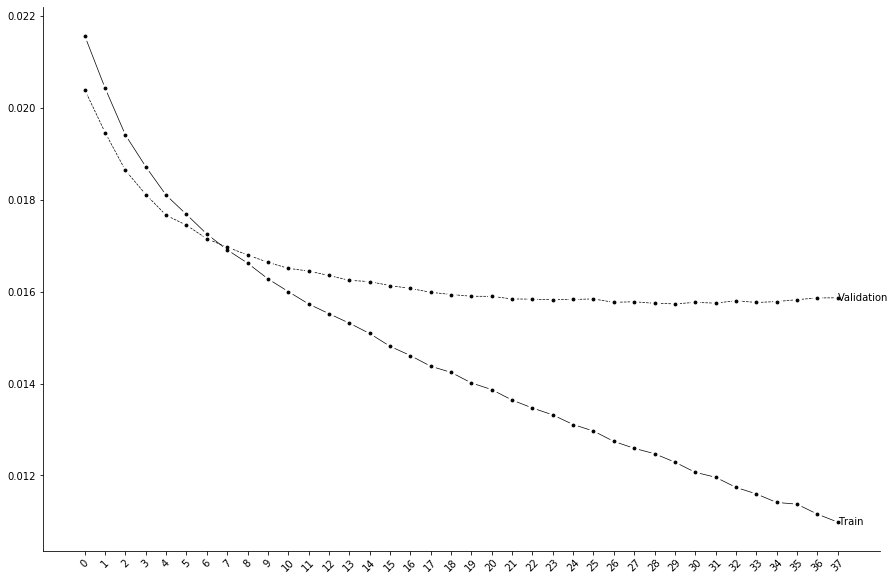

In [276]:
#Hyperparameterization: epochs
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_epochs_aux.csv"
save_file_final = path_holdout + "log_loss_epochs_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 10
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []
hyperparameter = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190
                 , 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350
                 , 360, 370, 380, 390, 400]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = parameter               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.ReLU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)






  0%|          | 0/10 [00:00<?, ?it/s]




 10%|█         | 1/10 [12:03<1:48:31, 723.45s/it]


0.2
Elapsed: 00:20:39
Total run time: 01:43:15
Time to finish: 01:22:36








 20%|██        | 2/10 [20:38<1:28:08, 661.06s/it]




 30%|███       | 3/10 [26:53<1:07:05, 575.08s/it]


0.4
Elapsed: 00:32:23
Total run time: 01:20:58
Time to finish: 00:48:35








 40%|████      | 4/10 [32:23<50:08, 501.46s/it]  




 50%|█████     | 5/10 [37:26<36:50, 442.08s/it]


0.6
Elapsed: 00:42:11
Total run time: 01:10:18
Time to finish: 00:28:07








 60%|██████    | 6/10 [42:11<26:19, 394.86s/it]




 70%|███████   | 7/10 [46:34<17:46, 355.47s/it]


0.8
Elapsed: 00:50:32
Total run time: 01:03:10
Time to finish: 00:12:38








 80%|████████  | 8/10 [50:31<10:39, 319.91s/it]




 90%|█████████ | 9/10 [54:10<04:49, 289.61s/it]


1.0
Elapsed: 00:57:32
Total run time: 00:57:32
Time to finish: 00:00:00








100%|██████████| 10/10 [57:31<00:00, 345.20s/it]



Smallest log loss: 0.0158
Smallest log loss parameter: 26.0


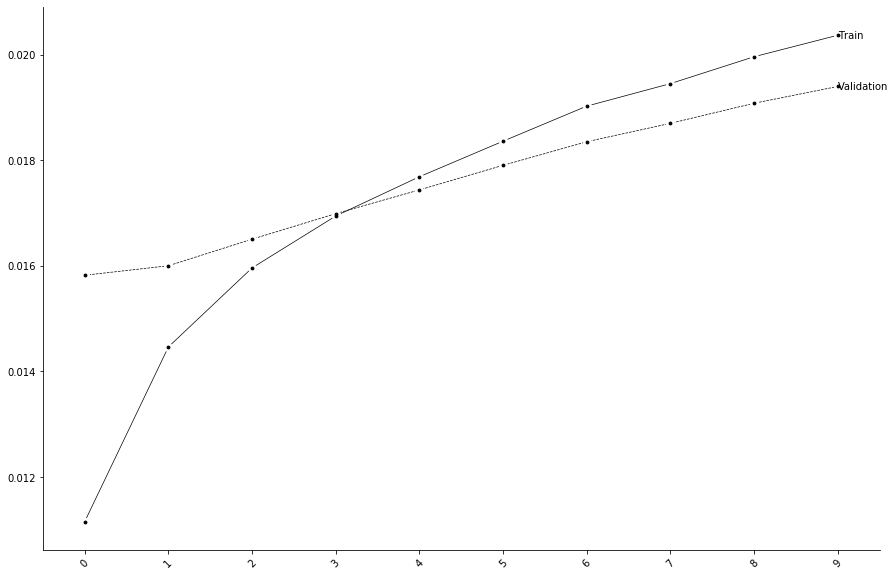

In [293]:
#Hyperparameterization: batch_size
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_batch_size_aux.csv"
save_file_final = path_holdout + "log_loss_batch_size_hp.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []
# batch_size = 26, 676 batches
hyperparameter = [26, 52, 78, 104, 130, 156, 182, 208, 234, 260]  # 32 is better

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = parameter             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.ReLU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
        lr = 0.1 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)






  0%|          | 0/20 [00:00<?, ?it/s]




  5%|▌         | 1/20 [11:27<3:37:39, 687.37s/it]


0.1
Elapsed: 00:23:00
Total run time: 03:50:00
Time to finish: 03:27:00








 10%|█         | 2/20 [23:00<3:26:42, 689.00s/it]




 15%|█▌        | 3/20 [34:43<3:16:25, 693.28s/it]


0.2
Elapsed: 00:46:00
Total run time: 03:50:00
Time to finish: 03:04:00








 20%|██        | 4/20 [45:59<3:03:30, 688.15s/it]




 25%|██▌       | 5/20 [56:35<2:48:04, 672.32s/it]


0.3
Elapsed: 01:07:21
Total run time: 03:44:30
Time to finish: 02:37:09








 30%|███       | 6/20 [1:07:21<2:35:02, 664.45s/it]




 35%|███▌      | 7/20 [1:18:07<2:22:49, 659.18s/it]


0.4
Elapsed: 01:28:34
Total run time: 03:41:25
Time to finish: 02:12:51








 40%|████      | 8/20 [1:28:33<2:09:50, 649.19s/it]




 45%|████▌     | 9/20 [1:39:07<1:58:09, 644.48s/it]


0.5
Elapsed: 01:49:39
Total run time: 03:39:18
Time to finish: 01:49:39








 50%|█████     | 10/20 [1:49:38<1:46:46, 640.62s/it]




 55%|█████▌    | 11/20 [1:59:58<1:35:08, 634.25s/it]


0.6
Elapsed: 02:10:32
Total run time: 03:37:33
Time to finish: 01:27:01








 60%|██████    | 12/20 [2:10:31<1:24:31, 633.96s/it]




 65%|██████▌   | 13/20 [2:21:09<1:14:05, 635.00s/it]


0.7
Elapsed: 02:31:24
Total run time: 03:36:17
Time to finish: 01:04:53








 70%|███████   | 14/20 [2:31:23<1:02:53, 628.97s/it]




 75%|███████▌  | 15/20 [2:42:03<52:40, 632.08s/it]  


0.8
Elapsed: 02:52:30
Total run time: 03:35:38
Time to finish: 00:43:08








 80%|████████  | 16/20 [2:52:30<42:02, 630.53s/it]




 85%|████████▌ | 17/20 [3:02:37<31:11, 623.70s/it]


0.9
Elapsed: 03:13:04
Total run time: 03:34:31
Time to finish: 00:21:27








 90%|█████████ | 18/20 [3:13:03<20:48, 624.40s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)





 95%|█████████▌| 19/20 [3:23:33<10:25, 625.95s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)



1.0
Elapsed: 03:34:00
Total run time: 03:34:00
Time to finish: 00:00:00








100%|██████████| 20/20 [3:34:00<00:00, 642.00s/it]



Smallest log loss: 0.0158
Smallest log loss parameter: 0.11


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


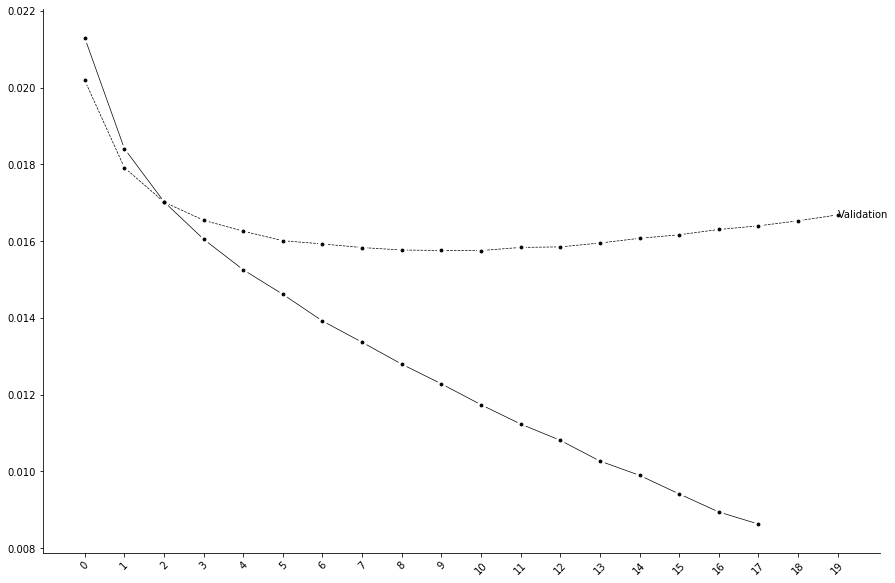

In [294]:
#Hyperparameterization: learnin rate
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_lr_aux.csv"
save_file_final = path_holdout + "log_loss_lr_hp.csv"

#Load stoped process
# log_loss_hp_aux = pd.read_csv(save_file_aux)
# load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1
                , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.ReLU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
        lr = parameter #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

In [298]:
# Lets try differents activation functions
def activation_functions_1(parameter):
    if parameter == 1: #ReLu()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.ReLU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 2: #tanh()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.Tanh(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 3: #LeakyReLU()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.LeakyReLU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 4: #PReLU()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.PReLU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 5: #ReLU6()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.ReLU6(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 6: #RReLU()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.RReLU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 7: #SELU()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.SELU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 8: #CELU()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.CELU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 9: #GELU()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.GELU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 10: #Softplus()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.Softplus(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 11: #Softsign()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.Softsign(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 12: #Tanhshrink()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.Tanhshrink(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 13: #LogSoftmax()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.LogSoftmax(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 14: #.Softmax(dim=1)
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.Softmax(dim=1),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 15: #.ELU()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.ELU(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 16: #.LogSigmoid()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.LogSigmoid(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
    if parameter == 17: #.Sigmoid()
        return nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.Sigmoid(),  
                    nn.Linear(X_train.shape[1], 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )







  0%|          | 0/17 [00:00<?, ?it/s]





 88%|████████▊ | 15/17 [11:14<01:29, 44.97s/it]


169.7647
Elapsed: 00:22:05
Total run time: 00:00:08
Time to finish: -1:38:03









 94%|█████████▍| 16/17 [22:05<03:46, 226.72s/it]





100%|██████████| 17/17 [32:02<00:00, 113.08s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 5.0


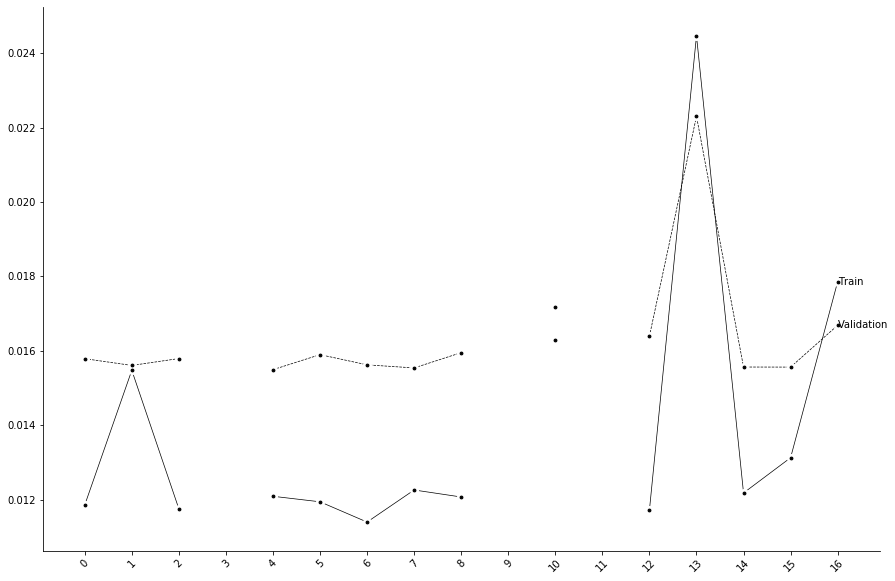

In [299]:
#Hyperparameterization: model
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_model_1_aux.csv"
save_file_final = path_holdout + "log_loss_model_1_hp.csv"

#Load stoped process
log_loss_hp_aux = pd.read_csv(save_file_aux)
load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
# load_parameter = []  #If there isn't a file to load


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = activation_functions_1(parameter)
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Not all activation functions worked, because of this we have some points without value. Also, we should remember that our parameters start at 1, so the parameter 5 is the point 4 in the graph. Parameter 5 is the ReLU6 activation function.

https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html#torch.nn.ReLU6
Applies the element-wise function:

ReLU6(x)=min(max(0,x),6)


It is interesting to notice that parameter 2 (tanh function) has a good log loss and is more stable, the performance in train and validation are close.\
Lets try some more changes in our model.







  0%|          | 0/16 [00:00<?, ?it/s]





  6%|▋         | 1/16 [03:35<53:47, 215.15s/it]


0.125
Elapsed: 00:09:32
Total run time: 01:16:16
Time to finish: 01:06:44









 12%|█▎        | 2/16 [09:32<1:00:07, 257.69s/it]





 19%|█▉        | 3/16 [16:50<1:07:35, 311.99s/it]


0.25
Elapsed: 00:26:05
Total run time: 01:44:20
Time to finish: 01:18:15









 25%|██▌       | 4/16 [26:04<1:16:55, 384.58s/it]





 31%|███▏      | 5/16 [37:27<1:26:53, 473.99s/it]


0.375
Elapsed: 00:50:10
Total run time: 02:13:47
Time to finish: 01:23:37









 38%|███▊      | 6/16 [50:10<1:33:26, 560.66s/it]





 44%|████▍     | 7/16 [1:04:45<1:38:15, 655.04s/it]


0.5
Elapsed: 01:21:36
Total run time: 02:43:12
Time to finish: 01:21:36









 50%|█████     | 8/16 [1:21:36<1:41:33, 761.74s/it]





 56%|█████▋    | 9/16 [1:40:24<1:41:41, 871.62s/it]


0.625
Elapsed: 02:01:05
Total run time: 03:13:44
Time to finish: 01:12:39









 62%|██████▎   | 10/16 [2:01:05<1:38:14, 982.47s/it]





 69%|██████▉   | 11/16 [2:25:30<1:33:56, 1127.36s/it]


0.75
Elapsed: 02:51:47
Total run time: 03:49:03
Time to finish: 00:57:16









 75%|███████▌  | 12/16 [2:51:46<1:24:07, 1261.95s/it]





 81%|████████▏ | 13/16 [3:19:58<1:09:32, 1390.81s/it]


0.875
Elapsed: 03:50:28
Total run time: 04:23:23
Time to finish: 00:32:55









 88%|████████▊ | 14/16 [3:50:27<50:44, 1522.49s/it]  





 94%|█████████▍| 15/16 [4:22:59<27:31, 1651.24s/it]


1.0
Elapsed: 04:57:27
Total run time: 04:57:27
Time to finish: 00:00:00









100%|██████████| 16/16 [4:57:27<00:00, 1115.46s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: 0.5


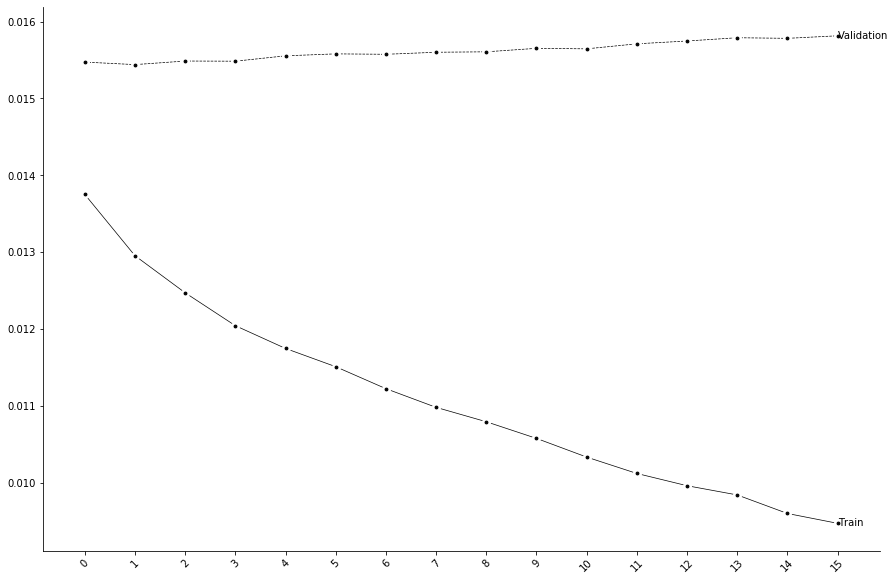

In [304]:
#Hyperparameterization: layer_1_out
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_layer_1_out_aux.csv"
save_file_final = path_holdout + "log_loss_layer_1_out_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(parameter*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(parameter*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Now, lets add some layers to our model.

In [310]:
# Lets try differents activation functions
def new_activation_function(parameter):
    if parameter == 0: #ReLu()
        return nn.ReLU()

    if parameter == 1: #tanh()
        return nn.Tanh()

    if parameter == 2: #LeakyReLU()
        return nn.LeakyReLU()
            
    if parameter == 3: #ReLU6()
        return nn.ReLU6() 

    if parameter == 4: #RReLU()
        return nn.RReLU() 

    if parameter == 5: #SELU()
        return nn.SELU()

    if parameter == 6: #CELU()
        return nn.CELU()
 
    if parameter == 7: #GELU()
        return nn.GELU()
       
    if parameter == 8: #Softsign()
        return nn.Softsign()
    
    if parameter == 9: #LogSoftmax()
        return nn.LogSoftmax()

    if parameter == 10: #.Softmax(dim=1)
        return  nn.Softmax(dim=1)

    if parameter == 11: #.ELU()
        return nn.ELU()

    if parameter == 12: #.LogSigmoid()
        return nn.LogSigmoid()
  
    if parameter == 13: #.Sigmoid()
        return nn.Sigmoid()
    
    if parameter == 14: #.PReLU()
        return nn.PReLU()
    
    if parameter == 15: #.Softplus()
        return nn.Softplus()
    
    if parameter == 16: #.Tanhshrink()
        return nn.Tanhshrink() 









  0%|          | 0/17 [00:00<?, ?it/s]







 18%|█▊        | 3/17 [08:48<41:05, 176.08s/it]


24.3529
Elapsed: 00:17:18
Total run time: 00:00:43
Time to finish: -1:43:25











 24%|██▎       | 4/17 [17:18<59:51, 276.29s/it]







 29%|██▉       | 5/17 [26:06<1:10:21, 351.76s/it]


24.4706
Elapsed: 00:35:08
Total run time: 00:01:26
Time to finish: -1:26:18











 35%|███▌      | 6/17 [35:08<1:14:57, 408.86s/it]







 41%|████      | 7/17 [43:34<1:13:00, 438.03s/it]


24.5882
Elapsed: 00:51:42
Total run time: 00:02:06
Time to finish: -1:10:24











 47%|████▋     | 8/17 [51:41<1:07:55, 452.85s/it]







 53%|█████▎    | 9/17 [1:01:14<1:05:11, 488.94s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



24.7059
Elapsed: 01:09:29
Total run time: 00:02:49
Time to finish: -2:53:20











 59%|█████▉    | 10/17 [1:09:29<57:13, 490.54s/it] 







 65%|██████▍   | 11/17 [1:17:18<48:24, 484.01s/it]


24.8235
Elapsed: 01:26:14
Total run time: 00:03:28
Time to finish: -2:37:14











 71%|███████   | 12/17 [1:26:14<41:38, 499.65s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)








 76%|███████▋  | 13/17 [1:34:25<33:08, 497.09s/it]


24.9412
Elapsed: 01:42:48
Total run time: 00:04:07
Time to finish: -2:21:19











 82%|████████▏ | 14/17 [1:42:47<24:56, 498.68s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels

C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)








 88%|████████▊ | 15/17 [1:50:45<16:25, 492.51s/it]


25.0588
Elapsed: 01:59:35
Total run time: 00:04:46
Time to finish: -2:05:11











 94%|█████████▍| 16/17 [1:59:34<08:23, 503.52s/it]







100%|██████████| 17/17 [2:07:52<00:00, 451.34s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 4.0


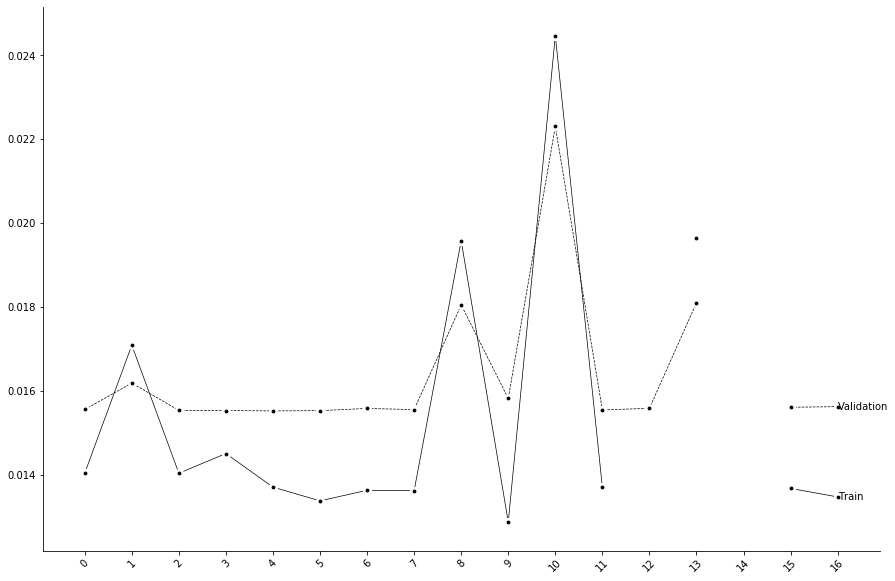

In [311]:
#Hyperparameterization: new_layer_2
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_new_layer_2_aux.csv"
save_file_final = path_holdout + "log_loss_new_layer_2_hp.csv"

#Load stoped process
load = 1
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), int(0.5*X_train.shape[1])),  
                    new_activation_function(parameter),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)









  0%|          | 0/17 [00:00<?, ?it/s]







  6%|▌         | 1/17 [13:40<3:38:40, 820.06s/it]


0.1176
Elapsed: 00:25:49
Total run time: 03:39:32
Time to finish: 03:13:43











 12%|█▏        | 2/17 [25:48<3:18:10, 792.69s/it]







 18%|█▊        | 3/17 [39:29<3:06:56, 801.16s/it]


0.2353
Elapsed: 00:52:26
Total run time: 03:42:50
Time to finish: 02:50:24











 24%|██▎       | 4/17 [52:26<2:51:59, 793.82s/it]







 29%|██▉       | 5/17 [1:05:37<2:38:35, 792.97s/it]


0.3529
Elapsed: 01:20:04
Total run time: 03:46:53
Time to finish: 02:26:49











 35%|███▌      | 6/17 [1:20:04<2:29:26, 815.18s/it]







 41%|████      | 7/17 [1:34:21<2:17:58, 827.86s/it]


0.4706
Elapsed: 01:46:56
Total run time: 03:47:14
Time to finish: 02:00:18











 47%|████▋     | 8/17 [1:46:56<2:00:52, 805.78s/it]







 53%|█████▎    | 9/17 [2:02:24<1:52:19, 842.49s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



0.5882
Elapsed: 02:15:43
Total run time: 03:50:44
Time to finish: 01:35:01











 59%|█████▉    | 10/17 [2:15:43<1:36:45, 829.37s/it]







 65%|██████▍   | 11/17 [2:28:05<1:20:19, 803.19s/it]


0.7059
Elapsed: 02:42:16
Total run time: 03:49:52
Time to finish: 01:07:36











 71%|███████   | 12/17 [2:42:16<1:08:07, 817.48s/it]







 76%|███████▋  | 13/17 [2:56:10<54:50, 822.71s/it]  


0.8235
Elapsed: 03:09:04
Total run time: 03:49:35
Time to finish: 00:40:31











 82%|████████▏ | 14/17 [3:09:04<40:23, 807.93s/it]







 88%|████████▊ | 15/17 [3:21:56<26:34, 797.28s/it]


0.9412
Elapsed: 03:36:51
Total run time: 03:50:24
Time to finish: 00:13:33











 94%|█████████▍| 16/17 [3:36:51<13:46, 826.47s/it]







100%|██████████| 17/17 [3:50:16<00:00, 812.74s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 7.0


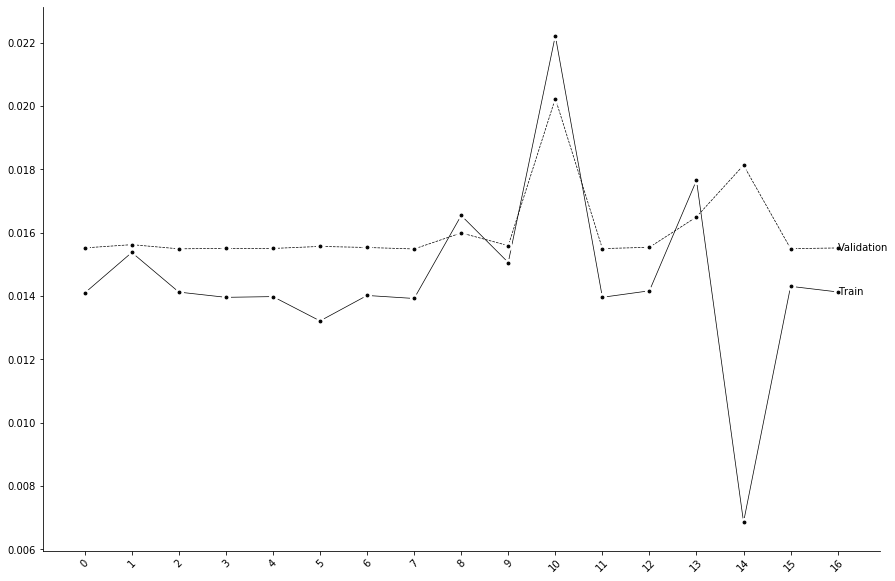

In [312]:
#Hyperparameterization: new_layer_2 second try
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_new_layer_2_2_aux.csv"
save_file_final = path_holdout + "log_loss_new_layer_2_2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    new_activation_function(parameter),  
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

We did not achieve a better log loss at validation. However, the log loss did not increase significantly and this model has a little less of overfitting.\
Lets try to add one more layer.









  0%|          | 0/17 [00:00<?, ?it/s]







  6%|▌         | 1/17 [23:34<6:17:11, 1414.45s/it]







 12%|█▏        | 2/17 [44:37<5:42:17, 1369.14s/it]


0.1765
Elapsed: 01:06:34
Total run time: 06:17:09
Time to finish: 05:10:35











 18%|█▊        | 3/17 [1:06:34<5:15:46, 1353.33s/it]







 24%|██▎       | 4/17 [1:29:55<4:56:21, 1367.83s/it]







 29%|██▉       | 5/17 [1:52:43<4:33:34, 1367.85s/it]


0.3529
Elapsed: 02:16:31
Total run time: 06:26:51
Time to finish: 04:10:20











 35%|███▌      | 6/17 [2:16:30<4:14:01, 1385.60s/it]







 41%|████      | 7/17 [2:39:33<3:50:47, 1384.80s/it]







 47%|████▋     | 8/17 [3:01:25<3:24:27, 1363.01s/it]


0.5294
Elapsed: 03:25:01
Total run time: 06:27:16
Time to finish: 03:02:15











 53%|█████▎    | 9/17 [3:25:00<3:03:48, 1378.51s/it]C:\Users\maxwi\Anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)








 59%|█████▉    | 10/17 [3:48:40<2:42:16, 1390.89s/it]







 65%|██████▍   | 11/17 [4:09:45<2:15:18, 1353.11s/it]


0.7059
Elapsed: 04:32:55
Total run time: 06:26:37
Time to finish: 01:53:42











 71%|███████   | 12/17 [4:32:55<1:53:40, 1364.15s/it]







 76%|███████▋  | 13/17 [4:55:41<1:30:58, 1364.68s/it]







 82%|████████▏ | 14/17 [5:17:27<1:07:21, 1347.30s/it]


0.8824
Elapsed: 05:38:46
Total run time: 06:23:55
Time to finish: 00:45:09











 88%|████████▊ | 15/17 [5:38:46<44:13, 1326.60s/it]  







 94%|█████████▍| 16/17 [6:02:38<22:38, 1358.33s/it]







100%|██████████| 17/17 [6:25:03<00:00, 1359.01s/it]



Smallest log loss: 0.0156
Smallest log loss parameter: 5.0


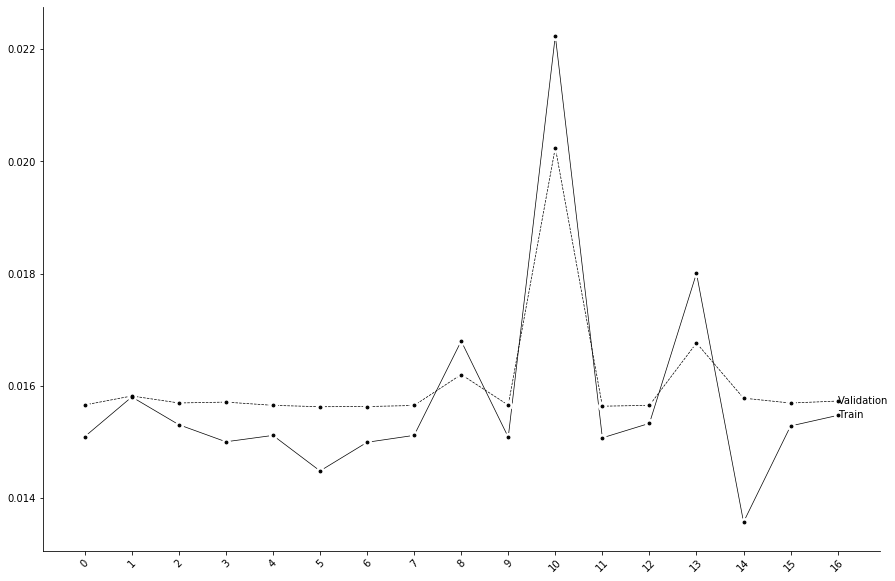

In [314]:
#Hyperparameterization: new_layer_3
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_new_layer_3_aux.csv"
save_file_final = path_holdout + "log_loss_new_layer_3_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    new_activation_function(parameter),  
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.GELU(),
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Adding a third layes increased our log loss.
However, before discarting it, lets try some hyperparametrization.













  0%|          | 0/11 [00:00<?, ?it/s]


0.2727
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.5455
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.8182
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00















100%|██████████| 11/11 [31:55<00:00, 174.14s/it]



Smallest log loss: 0.0156
Smallest log loss parameter: 310.0


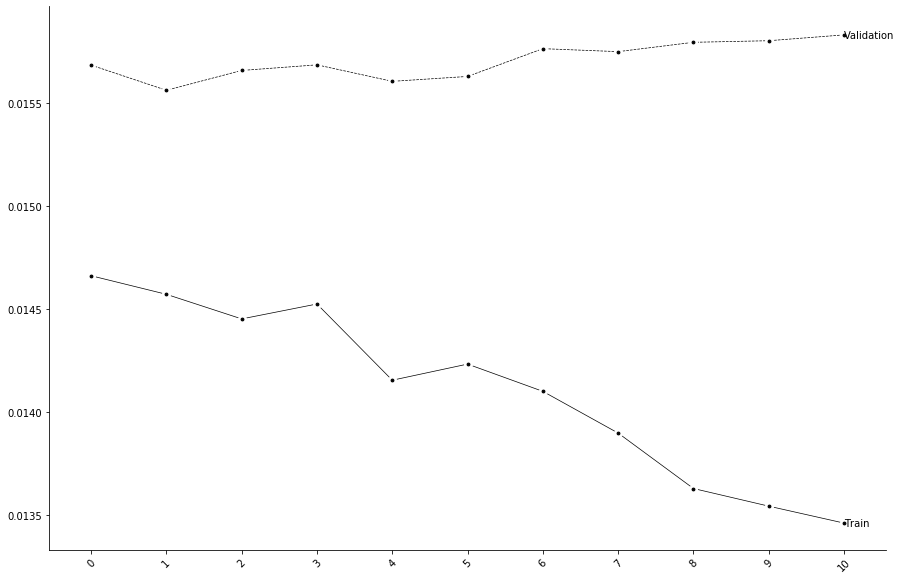

In [323]:
#Hyperparameterization: epochs_2
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_epochs_2_aux.csv"
save_file_final = path_holdout + "log_loss_epochs_2_hp.csv"

#Load stoped process
load = 1
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = parameter        # Hyperparameter
        batch_size = 32             # Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.SELU(),  
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.GELU(),
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
        #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)













  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log


0.375
Elapsed: 02:13:36
Total run time: 05:56:16
Time to finish: 03:42:40















 38%|███▊      | 3/8 [2:13:36<4:09:09, 2989.96s/it]











 50%|█████     | 4/8 [2:36:18<2:46:47, 2501.77s/it]











 62%|██████▎   | 5/8 [2:55:18<1:44:39, 2093.14s/it]


0.75
Elapsed: 03:12:20
Total run time: 04:16:27
Time to finish: 01:04:07















 75%|███████▌  | 6/8 [3:12:20<59:03, 1771.70s/it]  











 88%|████████▊ | 7/8 [3:28:02<25:22, 1522.75s/it]











100%|██████████| 8/8 [3:42:19<00:00, 1667.45s/it]



Smallest log loss: 0.0156
Smallest log loss parameter: 32.0


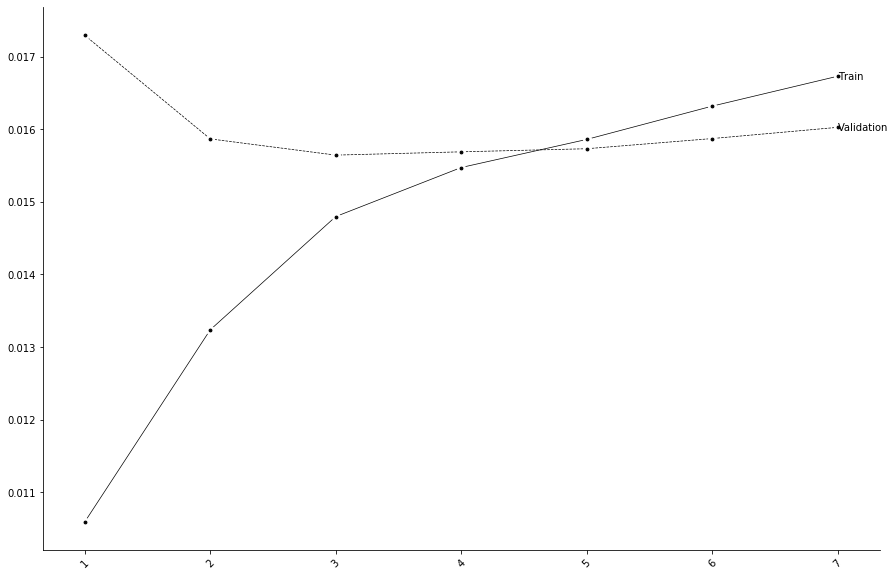

In [325]:
#Hyperparameterization: batch_2
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_batch_2_aux.csv"
save_file_final = path_holdout + "log_loss_batch_2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [8, 16, 24, 32 ,40 ,48, 56, 64]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 310        # Hyperparameter
        batch_size = parameter             # Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.SELU(),  
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.GELU(),
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
        #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)













  0%|          | 0/11 [00:00<?, ?it/s]











  9%|▉         | 1/11 [19:33<3:15:37, 1173.79s/it]











 18%|█▊        | 2/11 [40:08<2:58:47, 1191.96s/it]


0.2727
Elapsed: 01:01:41
Total run time: 03:46:12
Time to finish: 02:44:31















 27%|██▋       | 3/11 [1:01:41<2:42:57, 1222.24s/it]











 36%|███▋      | 4/11 [1:24:08<2:26:58, 1259.83s/it]











 45%|████▌     | 5/11 [1:47:05<2:09:30, 1295.11s/it]


0.5455
Elapsed: 02:11:45
Total run time: 04:01:31
Time to finish: 01:49:46















 55%|█████▍    | 6/11 [2:11:45<1:52:31, 1350.34s/it]











 64%|██████▎   | 7/11 [2:37:01<1:33:20, 1400.05s/it]











 73%|███████▎  | 8/11 [3:03:09<1:12:31, 1450.54s/it]


0.8182
Elapsed: 03:30:34
Total run time: 04:17:21
Time to finish: 00:46:47















 82%|████████▏ | 9/11 [3:30:33<50:17, 1508.58s/it]  











 91%|█████████ | 10/11 [3:58:43<26:02, 1562.94s/it]











100%|██████████| 11/11 [4:27:16<00:00, 1457.83s/it]



Smallest log loss: 0.0156
Smallest log loss parameter: 0.5


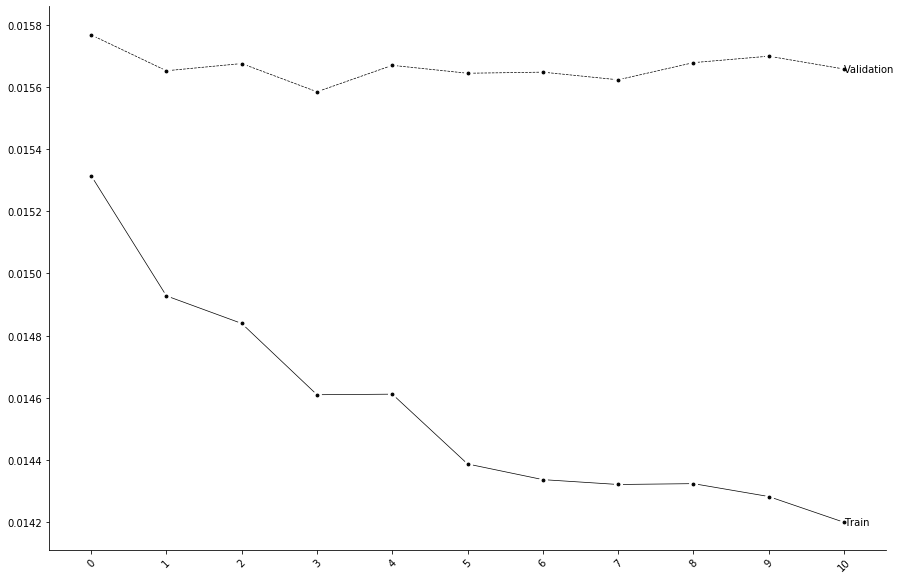

In [326]:
#Hyperparameterization: units_3
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_units_3_aux.csv"
save_file_final = path_holdout + "log_loss_units_3_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 1).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 310        # Hyperparameter
        batch_size = 32             # Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.SELU(),  
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.GELU(),
                    nn.Linear(X_train.shape[1], int(parameter*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(parameter*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
        #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)














  0%|          | 0/19 [00:00<?, ?it/s]


0.1579
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.3158
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.4737
Elapsed: 00:00:00
Total run time: 00:00:00
Time to finish: 00:00:00


0.6316
Elapsed: 00:26:15
Total run time: 00:41:34
Time to finish: 00:15:19
















 63%|██████▎   | 12/19 [26:14<15:18, 131.22s/it]












 68%|██████▊   | 13/19 [52:51<57:04, 570.77s/it]












 74%|███████▎  | 14/19 [1:20:34<1:14:52, 898.52s/it]


0.7895
Elapsed: 01:49:17
Total run time: 02:18:25
Time to finish: 00:29:08
















 79%|███████▉  | 15/19 [1:49:16<1:16:23, 1145.76s/it]












 84%|████████▍ | 16/19 [2:18:26<1:06:20, 1326.86s/it]












 89%|████████▉ | 17/19 [2:48:49<49:11, 1475.68s/it]  


0.9474
Elapsed: 03:20:04
Total run time: 03:31:10
Time to finish: 00:11:06
















 95%|█████████▍| 18/19 [3:20:04<26:35, 1595.48s/it]












100%|██████████| 19/19 [3:51:58<00:00, 732.57s/it] 



Smallest log loss: 0.0156
Smallest log loss parameter: 1.3


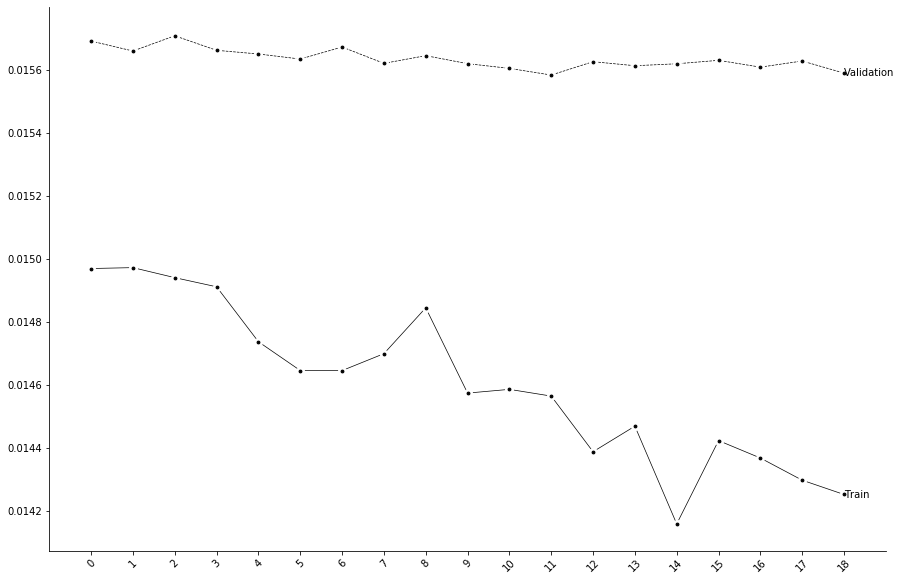

In [329]:
#Hyperparameterization: units_2_ml3
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_units_2_ml3_aux.csv"
save_file_final = path_holdout + "log_loss_units_2_ml3_hp.csv"

#Load stoped process
load = 1
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 1).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 310        # Hyperparameter
        batch_size = 32             # Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], X_train.shape[1]), 
                    nn.SELU(),  
                    nn.Linear(X_train.shape[1], int(parameter*X_train.shape[1])), 
                    nn.GELU(),
                    nn.Linear(int(parameter*X_train.shape[1]), int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)














  0%|          | 0/19 [00:00<?, ?it/s]












  5%|▌         | 1/19 [11:36<3:29:04, 696.93s/it]












 11%|█         | 2/19 [25:18<3:28:05, 734.44s/it]


0.1579
Elapsed: 00:40:30
Total run time: 04:16:29
Time to finish: 03:35:59
















 16%|█▌        | 3/19 [40:30<3:30:00, 787.53s/it]












 21%|██        | 4/19 [57:51<3:35:52, 863.51s/it]












 26%|██▋       | 5/19 [1:16:34<3:39:42, 941.60s/it]


0.3158
Elapsed: 01:37:26
Total run time: 05:08:32
Time to finish: 03:31:06
















 32%|███▏      | 6/19 [1:37:25<3:44:06, 1034.37s/it]












 37%|███▋      | 7/19 [1:59:38<3:44:47, 1123.95s/it]












 42%|████▏     | 8/19 [2:23:51<3:44:07, 1222.50s/it]


0.4737
Elapsed: 02:49:36
Total run time: 05:58:02
Time to finish: 03:08:26
















 47%|████▋     | 9/19 [2:49:35<3:39:50, 1319.10s/it]












 53%|█████▎    | 10/19 [3:17:19<3:33:23, 1422.64s/it]












 58%|█████▊    | 11/19 [3:45:19<3:19:56, 1499.61s/it]


0.6316
Elapsed: 04:14:50
Total run time: 06:43:28
Time to finish: 02:28:38
















 63%|██████▎   | 12/19 [4:14:50<3:04:27, 1581.03s/it]












 68%|██████▊   | 13/19 [4:45:05<2:45:08, 1651.39s/it]












 74%|███████▎  | 14/19 [5:17:10<2:24:27, 1733.44s/it]


0.7895
Elapsed: 05:49:58
Total run time: 07:23:17
Time to finish: 01:33:19
















 79%|███████▉  | 15/19 [5:49:57<2:00:14, 1803.60s/it]












 84%|████████▍ | 16/19 [6:24:42<1:34:23, 1887.76s/it]












 89%|████████▉ | 17/19 [7:00:39<1:05:37, 1968.61s/it]


0.9474
Elapsed: 07:37:56
Total run time: 08:03:21
Time to finish: 00:25:25
















 95%|█████████▍| 18/19 [7:37:56<34:09, 2049.05s/it]  












100%|██████████| 19/19 [8:16:43<00:00, 1568.60s/it]



Smallest log loss: 0.0156
Smallest log loss parameter: 0.4


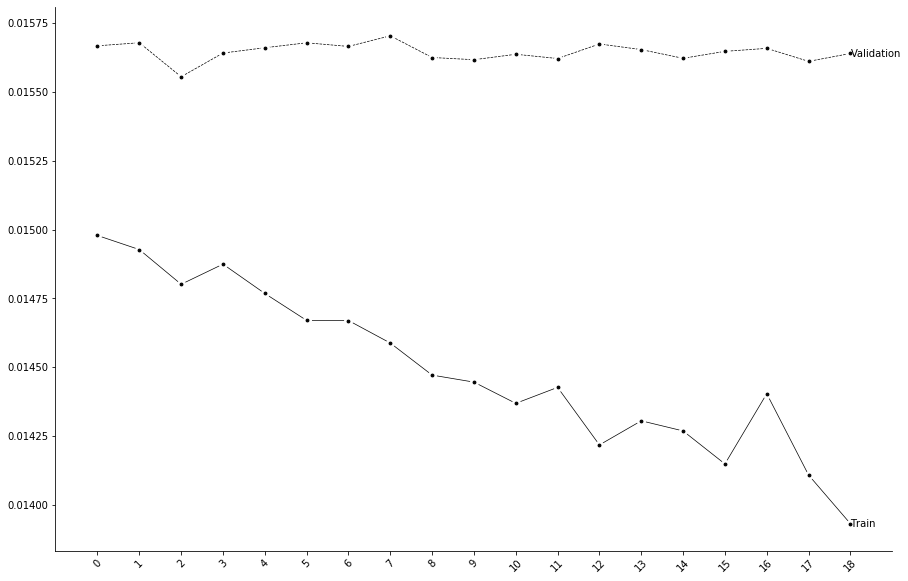

In [330]:
#Hyperparameterization: units_1_ml3
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_units_1_ml3_aux.csv"
save_file_final = path_holdout + "log_loss_units_1_ml3_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 1).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 310        # Hyperparameter
        batch_size = 32             # Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(parameter*X_train.shape[1])), 
                    nn.SELU(),  
                    nn.Linear(int(parameter*X_train.shape[1]), int(1.3*X_train.shape[1])), 
                    nn.GELU(),
                    nn.Linear(int(1.3*X_train.shape[1]), int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)














  0%|          | 0/7 [00:00<?, ?it/s]












 14%|█▍        | 1/7 [15:43<1:34:19, 943.31s/it]












 29%|██▊       | 2/7 [31:23<1:18:32, 942.48s/it]


0.4286
Elapsed: 00:47:02
Total run time: 01:49:44
Time to finish: 01:02:42
















 43%|████▎     | 3/7 [47:02<1:02:44, 941.20s/it]












 57%|█████▋    | 4/7 [1:02:46<47:06, 942.25s/it]












 71%|███████▏  | 5/7 [1:18:27<31:23, 941.68s/it]


0.8571
Elapsed: 01:33:58
Total run time: 01:49:38
Time to finish: 00:15:40
















 86%|████████▌ | 6/7 [1:33:58<15:38, 938.44s/it]












100%|██████████| 7/7 [1:49:41<00:00, 940.25s/it]



Smallest log loss: 0.0156
Smallest log loss parameter: 0.09


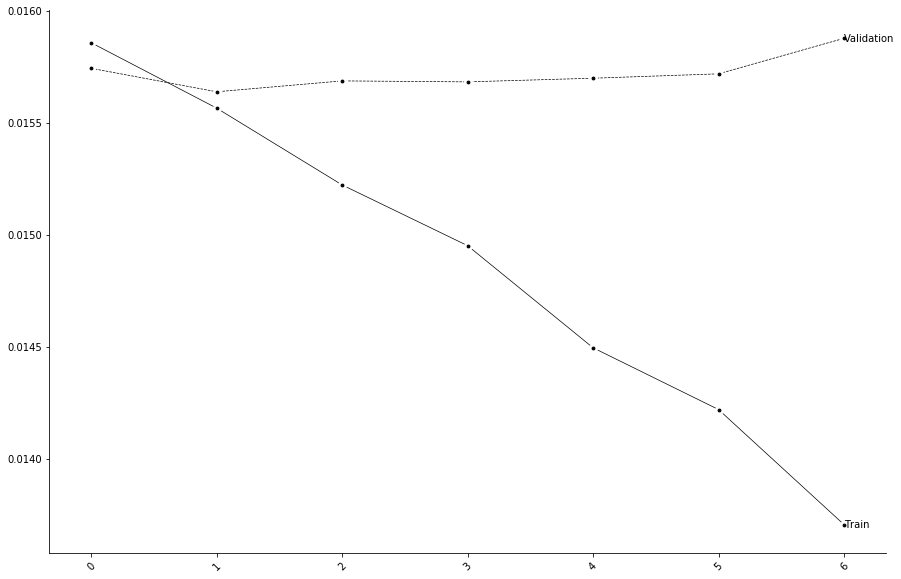

In [331]:
#Hyperparameterization: learning_rate_ml3
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_lr_ml3_aux.csv"
save_file_final = path_holdout + "log_loss_lr_ml3_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 1).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 310        # Hyperparameter
        batch_size = 32             # Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.4*X_train.shape[1])), 
                    nn.SELU(),  
                    nn.Linear(int(0.4*X_train.shape[1]), int(1.3*X_train.shape[1])), 
                    nn.GELU(),
                    nn.Linear(int(1.3*X_train.shape[1]), int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = parameter #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

The best model is with only 1 layer. However, lets save the parameters of this model with 3 layers because it appears that there isn't any problem of overfitting.

Lets try to find better parameters for the 1 layers model.

















  0%|          | 0/7 [00:00<?, ?it/s]















 14%|█▍        | 1/7 [05:25<32:30, 325.04s/it]


0.2857
Elapsed: 00:10:50
Total run time: 00:37:55
Time to finish: 00:27:05



















 29%|██▊       | 2/7 [10:49<27:04, 324.90s/it]















 43%|████▎     | 3/7 [16:41<22:11, 332.88s/it]


0.5714
Elapsed: 00:22:38
Total run time: 00:39:37
Time to finish: 00:16:59



















 57%|█████▋    | 4/7 [22:37<17:00, 340.03s/it]















 71%|███████▏  | 5/7 [28:46<11:37, 348.68s/it]


0.8571
Elapsed: 00:35:05
Total run time: 00:40:56
Time to finish: 00:05:51



















 86%|████████▌ | 6/7 [35:04<05:57, 357.42s/it]















100%|██████████| 7/7 [41:39<00:00, 357.04s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: 290.0


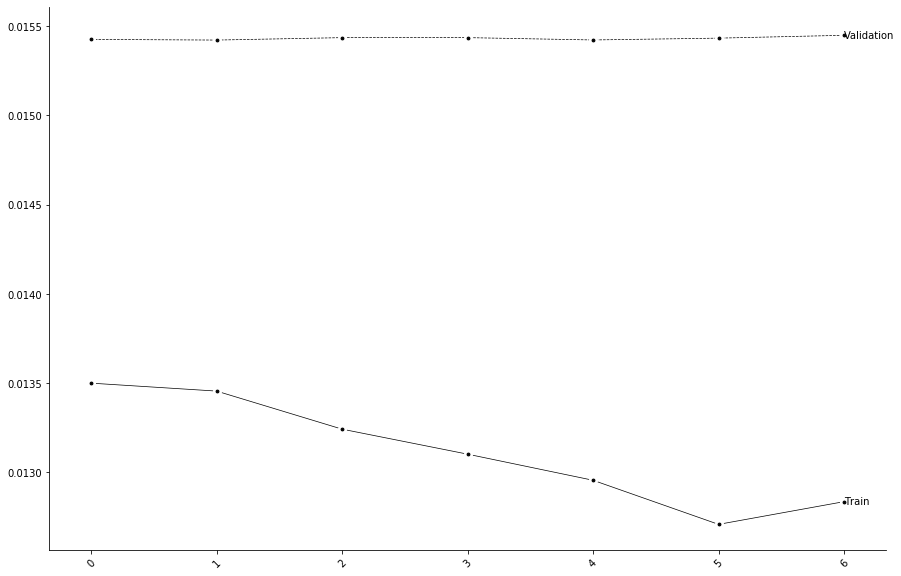

In [339]:
#Hyperparameterization: epochs
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_epochs_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_epochs_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [280, 290, 300, 310, 320, 330, 340]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = parameter               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

















  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np


0.2857
Elapsed: 00:23:24
Total run time: 01:21:54
Time to finish: 00:58:30



















 29%|██▊       | 2/7 [23:23<1:04:33, 774.70s/it]















 43%|████▎     | 3/7 [28:51<42:41, 640.47s/it]  


0.5714
Elapsed: 00:33:49
Total run time: 00:59:11
Time to finish: 00:25:22



















 57%|█████▋    | 4/7 [33:49<26:53, 537.73s/it]















 71%|███████▏  | 5/7 [38:16<15:13, 456.60s/it]


0.8571
Elapsed: 00:42:34
Total run time: 00:49:40
Time to finish: 00:07:06



















 86%|████████▌ | 6/7 [42:34<06:36, 396.90s/it]















100%|██████████| 7/7 [46:37<00:00, 399.60s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: 32.0


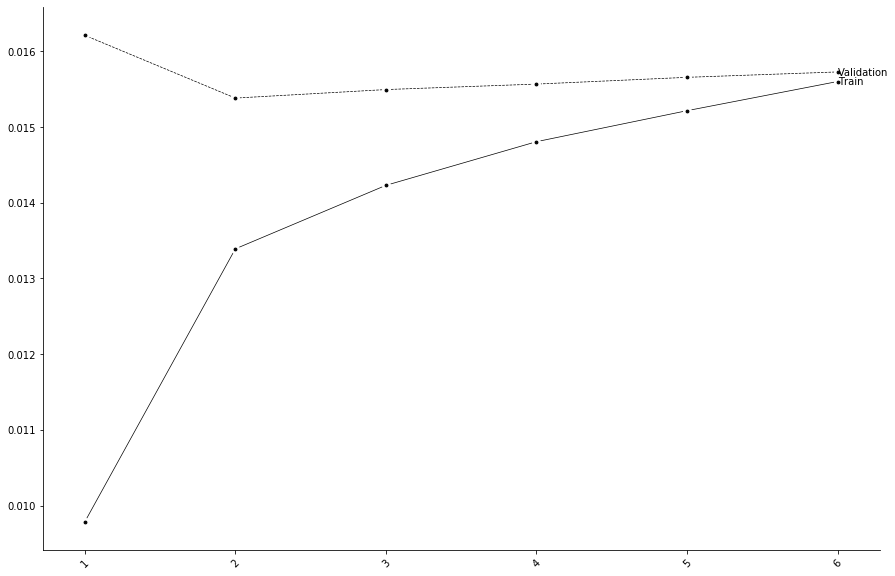

In [340]:
#Hyperparameterization: batch_size
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_batch_size_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_batch_size_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [8, 16, 32, 40, 48, 56, 64]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 290               #Hyperparameter
        batch_size = parameter             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

















  0%|          | 0/7 [00:00<?, ?it/s]















 14%|█▍        | 1/7 [05:47<34:46, 347.77s/it]


0.2857
Elapsed: 00:11:16
Total run time: 00:39:26
Time to finish: 00:28:10



















 29%|██▊       | 2/7 [11:15<28:29, 341.83s/it]















 43%|████▎     | 3/7 [16:52<22:41, 340.45s/it]


0.5714
Elapsed: 00:22:36
Total run time: 00:39:33
Time to finish: 00:16:57



















 57%|█████▋    | 4/7 [22:36<17:03, 341.26s/it]















 71%|███████▏  | 5/7 [28:04<11:14, 337.35s/it]


0.8571
Elapsed: 00:33:38
Total run time: 00:39:14
Time to finish: 00:05:36



















 86%|████████▌ | 6/7 [33:37<05:36, 336.20s/it]















100%|██████████| 7/7 [39:13<00:00, 336.15s/it]



Smallest log loss: 0.0154
Smallest log loss parameter: 0.1


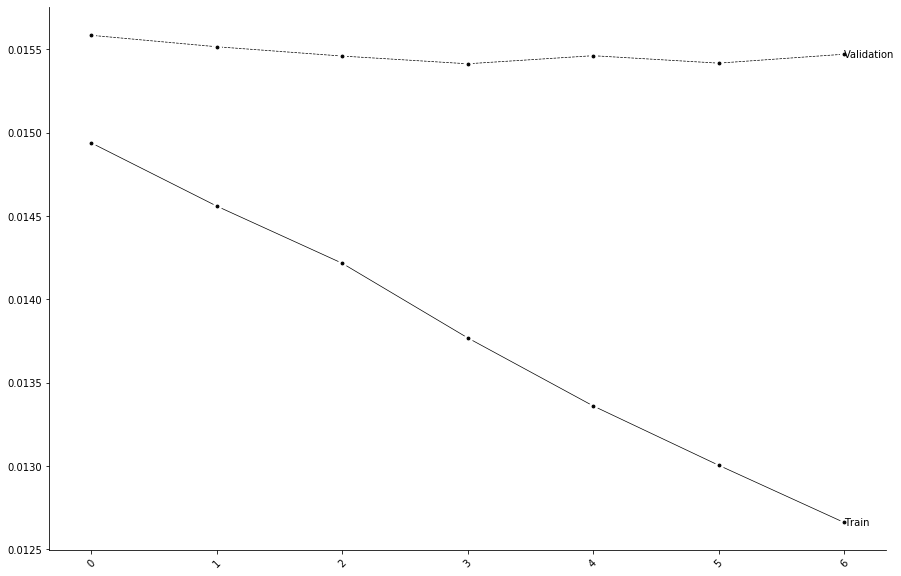

In [341]:
#Hyperparameterization: learning rate
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_lr_ml1_aux.csv"
save_file_final = path_holdout + "log_loss_lr_ml1_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 2
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 290               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = parameter #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Considering that our log loss did not change too much considering 1, 2, or 3 hidden layers, lets find some parameters for the model with 2 hidden layers. 



















  0%|          | 0/10 [00:00<?, ?it/s]

















 10%|█         | 1/10 [04:46<42:59, 286.65s/it]

















 20%|██        | 2/10 [10:01<39:21, 295.20s/it]


0.3
Elapsed: 00:15:29
Total run time: 00:51:37
Time to finish: 00:36:08





















 30%|███       | 3/10 [15:28<35:33, 304.73s/it]

















 40%|████      | 4/10 [21:22<31:56, 319.41s/it]

















 50%|█████     | 5/10 [27:48<28:17, 339.54s/it]


0.6
Elapsed: 00:34:13
Total run time: 00:57:02
Time to finish: 00:22:49





















 60%|██████    | 6/10 [34:12<23:31, 352.76s/it]

















 70%|███████   | 7/10 [41:02<18:29, 369.92s/it]

















 80%|████████  | 8/10 [48:25<13:03, 391.72s/it]


0.9
Elapsed: 00:55:44
Total run time: 01:01:56
Time to finish: 00:06:12





















 90%|█████████ | 9/10 [55:44<06:45, 405.98s/it]

















100%|██████████| 10/10 [1:03:24<00:00, 380.49s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 0.4


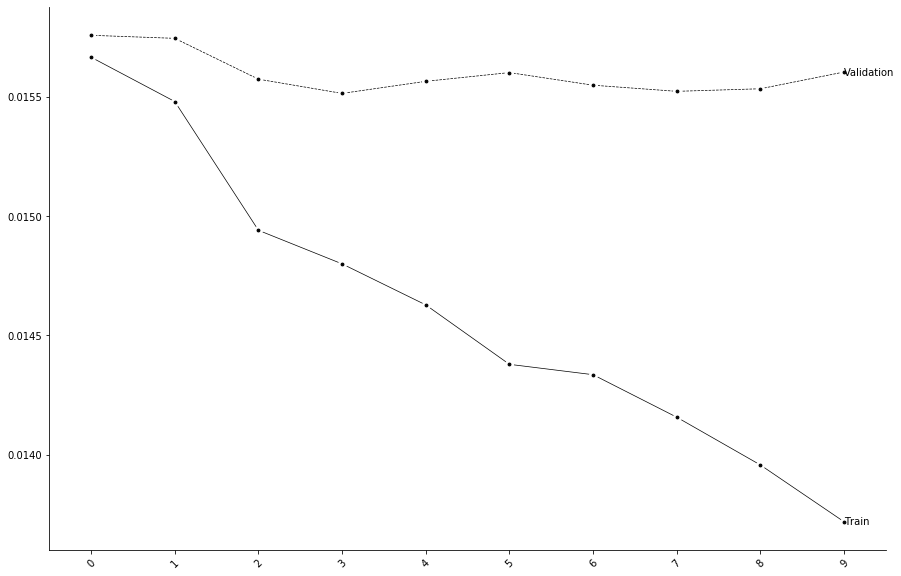

In [352]:
#Hyperparameterization: units_2
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_units_2_ml2_aux.csv"
save_file_final = path_holdout + "log_loss_units_2_ml2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention tothe precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.3*X_train.shape[1])), 
                    nn.GELU(),
                    nn.Linear(int(0.3*X_train.shape[1]), int(parameter*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(parameter*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)



















  0%|          | 0/7 [00:00<?, ?it/s]

















 14%|█▍        | 1/7 [04:56<29:39, 296.52s/it]

















 29%|██▊       | 2/7 [10:09<25:07, 301.50s/it]


0.4286
Elapsed: 00:16:02
Total run time: 00:37:25
Time to finish: 00:21:23





















 43%|████▎     | 3/7 [16:02<21:07, 316.89s/it]

















 57%|█████▋    | 4/7 [23:09<17:29, 349.84s/it]

















 71%|███████▏  | 5/7 [31:00<12:52, 386.14s/it]


0.8571
Elapsed: 00:39:30
Total run time: 00:46:05
Time to finish: 00:06:35





















 86%|████████▌ | 6/7 [39:30<07:03, 423.35s/it]

















100%|██████████| 7/7 [49:01<00:00, 420.22s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 0.5


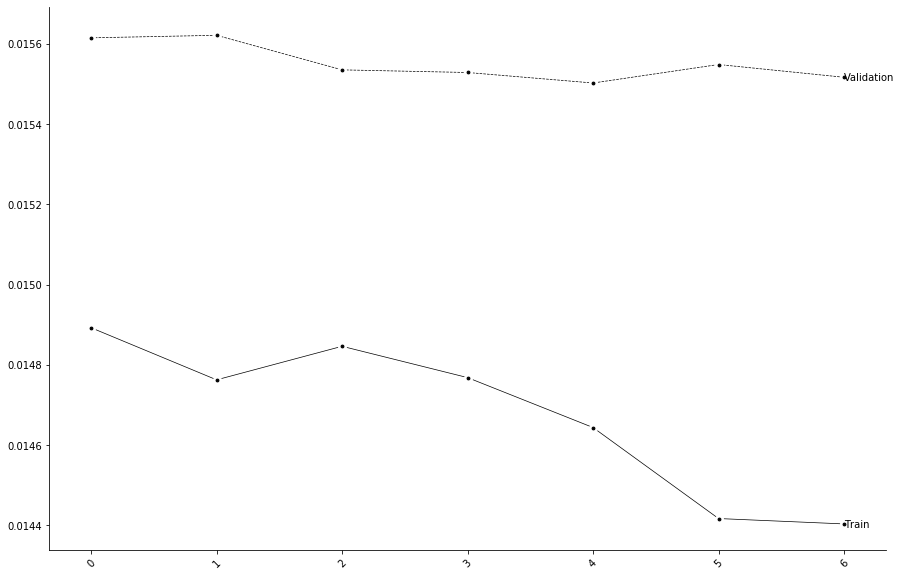

In [353]:
#Hyperparameterization: units_1
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_units_1_ml2_aux.csv"
save_file_final = path_holdout + "log_loss_units_1_ml2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 2).values #Pay attention to the precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 320               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(parameter*X_train.shape[1])), 
                    nn.GELU(),
                    nn.Linear(int(parameter*X_train.shape[1]), int(0.4*X_train.shape[1])),     #CONFERIR
                    nn.ReLU6(),
                    nn.Linear(int(0.4*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)




















  0%|          | 0/7 [00:00<?, ?it/s]


















 14%|█▍        | 1/7 [07:14<43:26, 434.34s/it]


















 29%|██▊       | 2/7 [14:42<36:32, 438.52s/it]


0.4286
Elapsed: 00:22:22
Total run time: 00:52:11
Time to finish: 00:29:49






















 43%|████▎     | 3/7 [22:22<29:39, 444.87s/it]


















 57%|█████▋    | 4/7 [30:24<22:48, 456.05s/it]


















 71%|███████▏  | 5/7 [38:33<15:32, 466.05s/it]


0.8571
Elapsed: 00:46:53
Total run time: 00:54:42
Time to finish: 00:07:49






















 86%|████████▌ | 6/7 [46:53<07:56, 476.07s/it]


















100%|██████████| 7/7 [55:43<00:00, 477.68s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 330.0


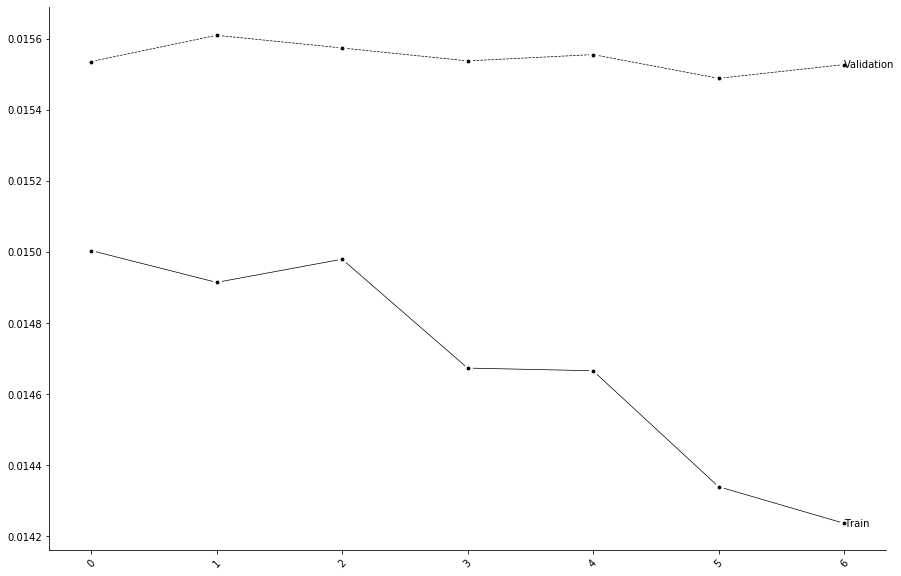

In [355]:
#Hyperparameterization: epochs
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_epochs_ml2_aux.csv"
save_file_final = path_holdout + "log_loss_epochs_ml2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention to the precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [280, 290, 300, 310, 320, 330, 340]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = parameter               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),         
                    nn.GELU(),
                    nn.Linear(int(0.5*X_train.shape[1]), int(0.4*X_train.shape[1])),     
                    nn.ReLU6(),
                    nn.Linear(int(0.4*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)




















  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\maxwi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)



















 12%|█▎        | 1/8 [21:05<2:27:35, 1265.12s/it]


















 25%|██▌       | 2/8 [33:12<1:50:22, 1103.81s/it]


0.375
Elapsed: 00:42:32
Total run time: 01:53:25
Time to finish: 01:10:53






















 38%|███▊      | 3/8 [42:31<1:18:22, 940.40s/it] 


















 50%|█████     | 4/8 [51:03<54:07, 811.85s/it]  


















 62%|██████▎   | 5/8 [58:37<35:13, 704.38s/it]


0.75
Elapsed: 01:05:22
Total run time: 01:27:09
Time to finish: 00:21:47






















 75%|███████▌  | 6/8 [1:05:22<20:29, 614.57s/it]


















 88%|████████▊ | 7/8 [1:11:51<09:07, 547.04s/it]


















100%|██████████| 8/8 [1:17:43<00:00, 582.99s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 32.0


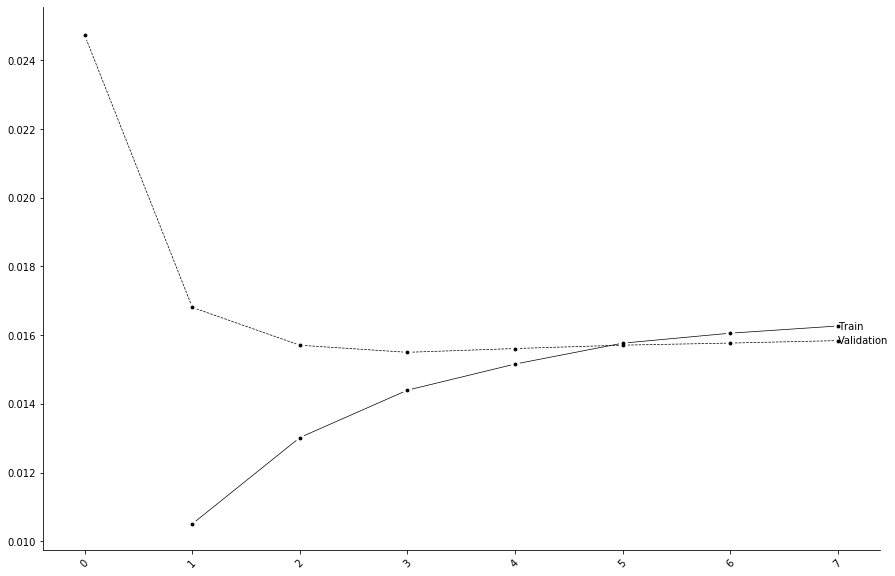

In [356]:
#Hyperparameterization: batch_size
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_batch_size_ml2_aux.csv"
save_file_final = path_holdout + "log_loss_batch_size_ml2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention to the precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [8, 16, 24, 32, 40, 48, 56, 64]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 330               #Hyperparameter
        batch_size = parameter             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),         
                    nn.GELU(),
                    nn.Linear(int(0.5*X_train.shape[1]), int(0.4*X_train.shape[1])),     
                    nn.ReLU6(),
                    nn.Linear(int(0.4*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = 0.11 #Hyperparameter
        momentum = 0 #Hyperparameter
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)




















  0%|          | 0/11 [00:00<?, ?it/s]


















  9%|▉         | 1/11 [08:32<1:25:23, 512.32s/it]


















 18%|█▊        | 2/11 [16:54<1:16:23, 509.24s/it]


0.2727
Elapsed: 00:25:06
Total run time: 01:32:03
Time to finish: 01:06:57






















 27%|██▋       | 3/11 [25:05<1:07:11, 503.89s/it]


















 36%|███▋      | 4/11 [33:34<58:57, 505.37s/it]  


















 45%|████▌     | 5/11 [42:09<50:49, 508.29s/it]


0.5455
Elapsed: 00:50:19
Total run time: 01:32:14
Time to finish: 00:41:55






















 55%|█████▍    | 6/11 [50:18<41:52, 502.58s/it]


















 64%|██████▎   | 7/11 [58:50<33:40, 505.21s/it]


















 73%|███████▎  | 8/11 [1:07:21<25:21, 507.15s/it]


0.8182
Elapsed: 01:15:33
Total run time: 01:32:20
Time to finish: 00:16:47






















 82%|████████▏ | 9/11 [1:15:32<16:44, 502.18s/it]


















 91%|█████████ | 10/11 [1:24:07<08:26, 506.07s/it]


















100%|██████████| 11/11 [1:32:38<00:00, 505.30s/it]



Smallest log loss: 0.0155
Smallest log loss parameter: 0.11


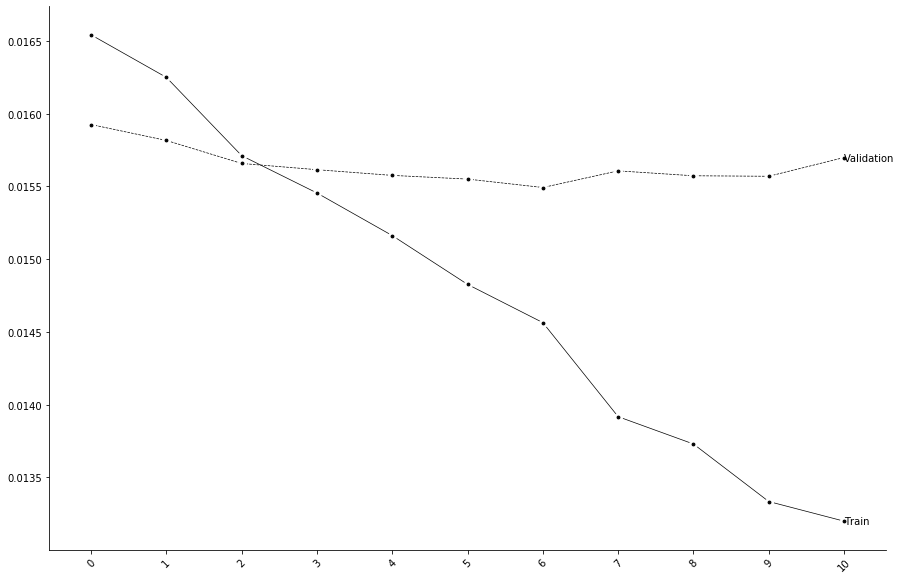

In [357]:
#Hyperparameterization: learning rate
X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)


save_file_aux = path_holdout + "log_loss_lr_ml2_aux.csv"
save_file_final = path_holdout + "log_loss_lr_ml2_hp.csv"

#Load stoped process
load = 0
if load == 1:
    log_loss_hp_aux = pd.read_csv(save_file_aux)
    load_parameter = round(log_loss_hp_aux['parameter'], 0).values #Pay attention to the precision number.
elif load == 0:
    load_parameter = []  #If there isn't a file to load
else:
    raise TypeError("Wrong load option!")


progress = 0  #Usefull to see the progress of the code. 
progress_check = 1
progress_mult = 3
start = time.time()

parameters_tested = []   #used to save progress
parameters_index = []    #used to save progress
parameters_index_aux = 0 #used to save progress
log_loss_train = []
log_loss_validation = []

hyperparameter = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

for parameter in tqdm(hyperparameter):
    if parameter in load_parameter:   
        #Load stoped process
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_train.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_train'].values[0])
        log_loss_validation.append(log_loss_hp_aux[np.in1d(load_parameter, parameter)]['log_loss_validation'].values[0])
        progress_check = int(progress / progress_mult) + 1
        
    else:
        
        n_epochs = 330               #Hyperparameter
        batch_size = 32             #Hyperparameter
        batch_size_val = len(Y_dev)  
        train_batches = batchify_data(X_train, Y_train, batch_size)
        dev_batches = batchify_data(X_dev, Y_dev, batch_size)

        train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
        dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


        #################################
        ## Model specification
        model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),         
                    nn.GELU(),
                    nn.Linear(int(0.5*X_train.shape[1]), int(0.4*X_train.shape[1])),     
                    nn.ReLU6(),
                    nn.Linear(int(0.4*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
 
        lr = parameter #Hyperparameter
        momentum = 0 
        ##################################

        #Train model
        train_model_h(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs)

        # Get output.
        # Evaluate the model on test data.
        loss_train, out_train = run_epoch_h(train_batches_full_base, model.eval(), None)
        loss_dev, out_dev = run_epoch_h(dev_batches_full_base, model.eval(), None)  
    
        # Calculate log loss.
        out_train = out_train.detach().numpy()
        out_train = pd.DataFrame(data = out_train)

        # Adjust out_dev for the control group
        out_dev = out_dev.detach().numpy()
        # Make a matrix with zeros when control.
        treatment_flag = test_x_control['cp_type'] == 'trt_cp'
        treatment_flag = np.array([treatment_flag])
        treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
        out_dev = out_dev*treatment_flag
        out_dev = pd.DataFrame(data = out_dev)

        log_loss_train.append(log_loss_mean(Y_train, out_train))
        log_loss_validation.append(log_loss_mean(Y_dev, out_dev))


        # Save progress
        parameters_tested.append(parameter)
        parameters_index.append(parameters_index_aux)
        parameters_index_aux += 1
        log_loss_hp_aux = pd.DataFrame(data = [parameters_index, parameters_tested, log_loss_train, log_loss_validation])
        log_loss_hp_aux = log_loss_hp_aux.transpose()
        log_loss_hp_aux.columns = ['parameter_index', 'parameter', 'log_loss_train', 'log_loss_validation']
        log_loss_hp_aux.to_csv(save_file_aux, index = False)
        
    #Running time
    progress += 1 #Changed to satisfy both situation if loading or not a saved progress.
    progress_check += print_time_to_end(progress_count = progress_check, step_size = progress_mult
                        , already_read = progress, full_db_size = len(hyperparameter))
        
          
log_loss_hp = log_loss_hp_aux.copy()  #Save the final version of log_loss_hp_aux

#Plot train and validation log loss
loss_train_validation(db = log_loss_hp, rotation_x = 45, save_to = save_file_final)

Lets run our final models with one, two, and three hidden layers.

In [13]:
# Final model 1 hidden layer

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

n_epochs = 290               #Hyperparameter
batch_size = 32             #Hyperparameter
batch_size_val = len(Y_dev)  
train_batches = batchify_data(X_train, Y_train, batch_size)
dev_batches = batchify_data(X_dev, Y_dev, batch_size)

train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


#################################
## Model specification
model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])), 
                    nn.ReLU6(),  
                    nn.Linear(int(0.5*X_train.shape[1]), 206),  
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
lr = 0.1 # Hyperparameter
momentum = 0
##################################

#Train model
train_model(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs, save_model = 'FNN_layer_1')
# train_model(train_batches, dev_batches, model, lr = lr, n_epochs = n_epochs)   # Used to try another optimizer.

# Get output.
# Evaluate the model on test data.
loss_train, accuracy_train, out_train = run_epoch(train_batches_full_base, model.eval(), None)
loss_dev, accuracy_dev, out_dev = run_epoch(dev_batches_full_base, model.eval(), None)  

out_train = out_train.detach().numpy()
out_train_layers_1 = pd.DataFrame(data = out_train)

# Adjust out_dev for the control group
out_dev = out_dev.detach().numpy()
# Make a matrix with zeros when control.
treatment_flag = test_x_control['cp_type'] == 'trt_cp'
treatment_flag = np.array([treatment_flag])
treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
out_dev = out_dev*treatment_flag
out_dev_layers_1 = pd.DataFrame(data = out_dev)
    
print()
print('Log loss train:', log_loss_mean(Y_train, out_train_layers_1))
print('Log loss dev:', log_loss_mean(Y_dev, out_dev_layers_1))

-------------
Epoch 1:



100%|██████████| 549/549 [00:01<00:00, 468.70it/s]


Train loss: 0.039060 | Train accuracy: 0.993632


100%|██████████| 148/148 [00:00<00:00, 1612.62it/s]


Val loss:   0.020973 | Val accuracy:   0.996824
-------------
Epoch 2:



100%|██████████| 549/549 [00:01<00:00, 478.85it/s]


Train loss: 0.021917 | Train accuracy: 0.996536


100%|██████████| 148/148 [00:00<00:00, 1079.25it/s]


Val loss:   0.020039 | Val accuracy:   0.996827
-------------
Epoch 3:



100%|██████████| 549/549 [00:01<00:00, 433.52it/s]


Train loss: 0.021268 | Train accuracy: 0.996543


100%|██████████| 148/148 [00:00<00:00, 1363.94it/s]


Val loss:   0.019623 | Val accuracy:   0.996837
-------------
Epoch 4:



100%|██████████| 549/549 [00:01<00:00, 467.39it/s]


Train loss: 0.020907 | Train accuracy: 0.996550


100%|██████████| 148/148 [00:00<00:00, 1244.31it/s]


Val loss:   0.019360 | Val accuracy:   0.996843
-------------
Epoch 5:



100%|██████████| 549/549 [00:01<00:00, 493.77it/s]


Train loss: 0.020651 | Train accuracy: 0.996557


100%|██████████| 148/148 [00:00<00:00, 1642.21it/s]


Val loss:   0.019165 | Val accuracy:   0.996849
-------------
Epoch 6:



100%|██████████| 549/549 [00:01<00:00, 498.38it/s]


Train loss: 0.020450 | Train accuracy: 0.996569


100%|██████████| 148/148 [00:00<00:00, 1763.39it/s]


Val loss:   0.019011 | Val accuracy:   0.996859
-------------
Epoch 7:



100%|██████████| 549/549 [00:01<00:00, 484.16it/s]


Train loss: 0.020285 | Train accuracy: 0.996585


100%|██████████| 148/148 [00:00<00:00, 1894.81it/s]


Val loss:   0.018882 | Val accuracy:   0.996871
-------------
Epoch 8:



100%|██████████| 549/549 [00:01<00:00, 535.04it/s]


Train loss: 0.020143 | Train accuracy: 0.996605


100%|██████████| 148/148 [00:00<00:00, 1347.21it/s]


Val loss:   0.018773 | Val accuracy:   0.996897
-------------
Epoch 9:



100%|██████████| 549/549 [00:01<00:00, 527.38it/s]


Train loss: 0.020020 | Train accuracy: 0.996622


100%|██████████| 148/148 [00:00<00:00, 1606.56it/s]


Val loss:   0.018676 | Val accuracy:   0.996913
-------------
Epoch 10:



100%|██████████| 549/549 [00:01<00:00, 527.66it/s]


Train loss: 0.019910 | Train accuracy: 0.996635


100%|██████████| 148/148 [00:00<00:00, 1403.26it/s]


Val loss:   0.018590 | Val accuracy:   0.996923
-------------
Epoch 11:



100%|██████████| 549/549 [00:01<00:00, 519.86it/s]


Train loss: 0.019810 | Train accuracy: 0.996646


100%|██████████| 148/148 [00:00<00:00, 1885.74it/s]


Val loss:   0.018512 | Val accuracy:   0.996927
-------------
Epoch 12:



100%|██████████| 549/549 [00:01<00:00, 524.70it/s]


Train loss: 0.019718 | Train accuracy: 0.996655


100%|██████████| 148/148 [00:00<00:00, 1894.87it/s]


Val loss:   0.018439 | Val accuracy:   0.996934
-------------
Epoch 13:



100%|██████████| 549/549 [00:01<00:00, 545.30it/s]


Train loss: 0.019632 | Train accuracy: 0.996666


100%|██████████| 148/148 [00:00<00:00, 1305.27it/s]


Val loss:   0.018372 | Val accuracy:   0.996941
-------------
Epoch 14:



100%|██████████| 549/549 [00:01<00:00, 528.36it/s]


Train loss: 0.019551 | Train accuracy: 0.996675


100%|██████████| 148/148 [00:00<00:00, 1555.10it/s]


Val loss:   0.018308 | Val accuracy:   0.996948
-------------
Epoch 15:



100%|██████████| 549/549 [00:01<00:00, 524.43it/s]


Train loss: 0.019474 | Train accuracy: 0.996682


100%|██████████| 148/148 [00:00<00:00, 1894.91it/s]


Val loss:   0.018247 | Val accuracy:   0.996950
-------------
Epoch 16:



100%|██████████| 549/549 [00:01<00:00, 480.40it/s]


Train loss: 0.019400 | Train accuracy: 0.996689


100%|██████████| 148/148 [00:00<00:00, 1266.33it/s]


Val loss:   0.018188 | Val accuracy:   0.996955
-------------
Epoch 17:



100%|██████████| 549/549 [00:01<00:00, 507.96it/s]


Train loss: 0.019328 | Train accuracy: 0.996692


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.018132 | Val accuracy:   0.996958
-------------
Epoch 18:



100%|██████████| 549/549 [00:01<00:00, 515.50it/s]


Train loss: 0.019259 | Train accuracy: 0.996698


100%|██████████| 148/148 [00:00<00:00, 1894.85it/s]


Val loss:   0.018078 | Val accuracy:   0.996959
-------------
Epoch 19:



100%|██████████| 549/549 [00:01<00:00, 470.86it/s]


Train loss: 0.019192 | Train accuracy: 0.996703


100%|██████████| 148/148 [00:00<00:00, 1009.50it/s]


Val loss:   0.018025 | Val accuracy:   0.996962
-------------
Epoch 20:



100%|██████████| 549/549 [00:01<00:00, 486.07it/s]


Train loss: 0.019127 | Train accuracy: 0.996711


100%|██████████| 148/148 [00:00<00:00, 1133.50it/s]


Val loss:   0.017974 | Val accuracy:   0.996965
-------------
Epoch 21:



100%|██████████| 549/549 [00:01<00:00, 502.92it/s]


Train loss: 0.019063 | Train accuracy: 0.996716


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.017924 | Val accuracy:   0.996968
-------------
Epoch 22:



100%|██████████| 549/549 [00:01<00:00, 484.24it/s]


Train loss: 0.019002 | Train accuracy: 0.996721


100%|██████████| 148/148 [00:00<00:00, 1030.60it/s]


Val loss:   0.017876 | Val accuracy:   0.996978
-------------
Epoch 23:



100%|██████████| 549/549 [00:01<00:00, 474.39it/s]


Train loss: 0.018941 | Train accuracy: 0.996729


100%|██████████| 148/148 [00:00<00:00, 1174.84it/s]


Val loss:   0.017829 | Val accuracy:   0.996983
-------------
Epoch 24:



100%|██████████| 549/549 [00:01<00:00, 478.47it/s]


Train loss: 0.018883 | Train accuracy: 0.996731


100%|██████████| 148/148 [00:00<00:00, 1124.21it/s]


Val loss:   0.017784 | Val accuracy:   0.996990
-------------
Epoch 25:



100%|██████████| 549/549 [00:01<00:00, 396.88it/s]


Train loss: 0.018826 | Train accuracy: 0.996739


100%|██████████| 148/148 [00:00<00:00, 1242.09it/s]


Val loss:   0.017739 | Val accuracy:   0.996997
-------------
Epoch 26:



100%|██████████| 549/549 [00:01<00:00, 391.83it/s]


Train loss: 0.018770 | Train accuracy: 0.996748


100%|██████████| 148/148 [00:00<00:00, 1083.18it/s]


Val loss:   0.017696 | Val accuracy:   0.997001
-------------
Epoch 27:



100%|██████████| 549/549 [00:01<00:00, 387.65it/s]


Train loss: 0.018717 | Train accuracy: 0.996754


100%|██████████| 148/148 [00:00<00:00, 1141.51it/s]


Val loss:   0.017655 | Val accuracy:   0.997004
-------------
Epoch 28:



100%|██████████| 549/549 [00:01<00:00, 384.67it/s]


Train loss: 0.018664 | Train accuracy: 0.996760


100%|██████████| 148/148 [00:00<00:00, 989.31it/s]


Val loss:   0.017615 | Val accuracy:   0.997006
-------------
Epoch 29:



100%|██████████| 549/549 [00:01<00:00, 403.57it/s]


Train loss: 0.018613 | Train accuracy: 0.996768


100%|██████████| 148/148 [00:00<00:00, 1236.63it/s]


Val loss:   0.017576 | Val accuracy:   0.997010
-------------
Epoch 30:



100%|██████████| 549/549 [00:01<00:00, 429.05it/s]


Train loss: 0.018563 | Train accuracy: 0.996776


100%|██████████| 148/148 [00:00<00:00, 1037.74it/s]


Val loss:   0.017538 | Val accuracy:   0.997014
-------------
Epoch 31:



100%|██████████| 549/549 [00:01<00:00, 424.42it/s]


Train loss: 0.018515 | Train accuracy: 0.996782


100%|██████████| 148/148 [00:00<00:00, 1216.35it/s]


Val loss:   0.017502 | Val accuracy:   0.997019
-------------
Epoch 32:



100%|██████████| 549/549 [00:01<00:00, 392.91it/s]


Train loss: 0.018468 | Train accuracy: 0.996788


100%|██████████| 148/148 [00:00<00:00, 1091.15it/s]


Val loss:   0.017467 | Val accuracy:   0.997022
-------------
Epoch 33:



100%|██████████| 549/549 [00:01<00:00, 393.75it/s]


Train loss: 0.018422 | Train accuracy: 0.996792


100%|██████████| 148/148 [00:00<00:00, 1115.76it/s]


Val loss:   0.017433 | Val accuracy:   0.997026
-------------
Epoch 34:



100%|██████████| 549/549 [00:01<00:00, 391.51it/s]


Train loss: 0.018377 | Train accuracy: 0.996799


100%|██████████| 148/148 [00:00<00:00, 1268.35it/s]


Val loss:   0.017399 | Val accuracy:   0.997031
-------------
Epoch 35:



100%|██████████| 549/549 [00:01<00:00, 374.21it/s]


Train loss: 0.018333 | Train accuracy: 0.996805


100%|██████████| 148/148 [00:00<00:00, 878.08it/s]


Val loss:   0.017367 | Val accuracy:   0.997036
-------------
Epoch 36:



100%|██████████| 549/549 [00:01<00:00, 379.54it/s]


Train loss: 0.018290 | Train accuracy: 0.996811


100%|██████████| 148/148 [00:00<00:00, 1073.93it/s]


Val loss:   0.017336 | Val accuracy:   0.997039
-------------
Epoch 37:



100%|██████████| 549/549 [00:01<00:00, 452.75it/s]


Train loss: 0.018249 | Train accuracy: 0.996815


100%|██████████| 148/148 [00:00<00:00, 1196.76it/s]


Val loss:   0.017306 | Val accuracy:   0.997049
-------------
Epoch 38:



100%|██████████| 549/549 [00:01<00:00, 417.46it/s]


Train loss: 0.018208 | Train accuracy: 0.996818


100%|██████████| 148/148 [00:00<00:00, 1177.75it/s]


Val loss:   0.017276 | Val accuracy:   0.997052
-------------
Epoch 39:



100%|██████████| 549/549 [00:01<00:00, 431.13it/s]


Train loss: 0.018168 | Train accuracy: 0.996823


100%|██████████| 148/148 [00:00<00:00, 1361.43it/s]


Val loss:   0.017248 | Val accuracy:   0.997056
-------------
Epoch 40:



100%|██████████| 549/549 [00:01<00:00, 436.84it/s]


Train loss: 0.018129 | Train accuracy: 0.996829


100%|██████████| 148/148 [00:00<00:00, 1651.56it/s]


Val loss:   0.017221 | Val accuracy:   0.997063
-------------
Epoch 41:



100%|██████████| 549/549 [00:01<00:00, 490.17it/s]


Train loss: 0.018091 | Train accuracy: 0.996835


100%|██████████| 148/148 [00:00<00:00, 1928.06it/s]


Val loss:   0.017194 | Val accuracy:   0.997070
-------------
Epoch 42:



100%|██████████| 549/549 [00:01<00:00, 527.18it/s]


Train loss: 0.018054 | Train accuracy: 0.996843


100%|██████████| 148/148 [00:00<00:00, 1769.35it/s]


Val loss:   0.017169 | Val accuracy:   0.997081
-------------
Epoch 43:



100%|██████████| 549/549 [00:01<00:00, 448.58it/s]


Train loss: 0.018018 | Train accuracy: 0.996848


100%|██████████| 148/148 [00:00<00:00, 1121.57it/s]


Val loss:   0.017144 | Val accuracy:   0.997089
-------------
Epoch 44:



100%|██████████| 549/549 [00:01<00:00, 488.27it/s]


Train loss: 0.017982 | Train accuracy: 0.996853


100%|██████████| 148/148 [00:00<00:00, 1047.21it/s]


Val loss:   0.017120 | Val accuracy:   0.997094
-------------
Epoch 45:



100%|██████████| 549/549 [00:01<00:00, 457.96it/s]


Train loss: 0.017947 | Train accuracy: 0.996859


100%|██████████| 148/148 [00:00<00:00, 1595.66it/s]


Val loss:   0.017097 | Val accuracy:   0.997097
-------------
Epoch 46:



100%|██████████| 549/549 [00:01<00:00, 424.74it/s]


Train loss: 0.017914 | Train accuracy: 0.996865


100%|██████████| 148/148 [00:00<00:00, 1075.33it/s]


Val loss:   0.017074 | Val accuracy:   0.997097
-------------
Epoch 47:



100%|██████████| 549/549 [00:01<00:00, 444.31it/s]


Train loss: 0.017880 | Train accuracy: 0.996869


100%|██████████| 148/148 [00:00<00:00, 1290.40it/s]


Val loss:   0.017053 | Val accuracy:   0.997107
-------------
Epoch 48:



100%|██████████| 549/549 [00:01<00:00, 429.38it/s]


Train loss: 0.017848 | Train accuracy: 0.996872


100%|██████████| 148/148 [00:00<00:00, 1413.29it/s]


Val loss:   0.017031 | Val accuracy:   0.997110
-------------
Epoch 49:



100%|██████████| 549/549 [00:01<00:00, 442.50it/s]


Train loss: 0.017816 | Train accuracy: 0.996877


100%|██████████| 148/148 [00:00<00:00, 1226.43it/s]


Val loss:   0.017010 | Val accuracy:   0.997113
-------------
Epoch 50:



100%|██████████| 549/549 [00:01<00:00, 436.88it/s]


Train loss: 0.017785 | Train accuracy: 0.996883


100%|██████████| 148/148 [00:00<00:00, 1226.41it/s]


Val loss:   0.016990 | Val accuracy:   0.997117
-------------
Epoch 51:



100%|██████████| 549/549 [00:01<00:00, 410.49it/s]


Train loss: 0.017754 | Train accuracy: 0.996888


100%|██████████| 148/148 [00:00<00:00, 1313.21it/s]


Val loss:   0.016971 | Val accuracy:   0.997122
-------------
Epoch 52:



100%|██████████| 549/549 [00:01<00:00, 462.97it/s]


Train loss: 0.017724 | Train accuracy: 0.996893


100%|██████████| 148/148 [00:00<00:00, 1440.72it/s]


Val loss:   0.016951 | Val accuracy:   0.997125
-------------
Epoch 53:



100%|██████████| 549/549 [00:01<00:00, 453.23it/s]


Train loss: 0.017695 | Train accuracy: 0.996897


100%|██████████| 148/148 [00:00<00:00, 1866.37it/s]


Val loss:   0.016933 | Val accuracy:   0.997125
-------------
Epoch 54:



100%|██████████| 549/549 [00:01<00:00, 462.82it/s]


Train loss: 0.017666 | Train accuracy: 0.996900


100%|██████████| 148/148 [00:00<00:00, 1374.04it/s]


Val loss:   0.016914 | Val accuracy:   0.997125
-------------
Epoch 55:



100%|██████████| 549/549 [00:01<00:00, 504.19it/s]


Train loss: 0.017637 | Train accuracy: 0.996902


100%|██████████| 148/148 [00:00<00:00, 1313.22it/s]


Val loss:   0.016896 | Val accuracy:   0.997126
-------------
Epoch 56:



100%|██████████| 549/549 [00:01<00:00, 482.36it/s]


Train loss: 0.017609 | Train accuracy: 0.996906


100%|██████████| 148/148 [00:00<00:00, 1153.57it/s]


Val loss:   0.016879 | Val accuracy:   0.997129
-------------
Epoch 57:



100%|██████████| 549/549 [00:01<00:00, 451.69it/s]


Train loss: 0.017582 | Train accuracy: 0.996909


100%|██████████| 148/148 [00:00<00:00, 1579.04it/s]


Val loss:   0.016862 | Val accuracy:   0.997132
-------------
Epoch 58:



100%|██████████| 549/549 [00:01<00:00, 492.24it/s]


Train loss: 0.017554 | Train accuracy: 0.996912


100%|██████████| 148/148 [00:00<00:00, 1023.73it/s]


Val loss:   0.016845 | Val accuracy:   0.997133
-------------
Epoch 59:



100%|██████████| 549/549 [00:01<00:00, 464.26it/s]


Train loss: 0.017527 | Train accuracy: 0.996914


100%|██████████| 148/148 [00:00<00:00, 1579.06it/s]


Val loss:   0.016828 | Val accuracy:   0.997138
-------------
Epoch 60:



100%|██████████| 549/549 [00:01<00:00, 498.73it/s]


Train loss: 0.017501 | Train accuracy: 0.996919


100%|██████████| 148/148 [00:00<00:00, 1102.54it/s]


Val loss:   0.016812 | Val accuracy:   0.997141
-------------
Epoch 61:



100%|██████████| 549/549 [00:01<00:00, 445.17it/s]


Train loss: 0.017475 | Train accuracy: 0.996923


100%|██████████| 148/148 [00:00<00:00, 1894.85it/s]


Val loss:   0.016796 | Val accuracy:   0.997143
-------------
Epoch 62:



100%|██████████| 549/549 [00:01<00:00, 492.03it/s]


Train loss: 0.017449 | Train accuracy: 0.996927


100%|██████████| 148/148 [00:00<00:00, 1248.45it/s]


Val loss:   0.016781 | Val accuracy:   0.997147
-------------
Epoch 63:



100%|██████████| 549/549 [00:01<00:00, 433.35it/s]


Train loss: 0.017424 | Train accuracy: 0.996930


100%|██████████| 148/148 [00:00<00:00, 1304.53it/s]


Val loss:   0.016766 | Val accuracy:   0.997148
-------------
Epoch 64:



100%|██████████| 549/549 [00:01<00:00, 469.31it/s]


Train loss: 0.017398 | Train accuracy: 0.996934


100%|██████████| 148/148 [00:00<00:00, 1433.23it/s]


Val loss:   0.016751 | Val accuracy:   0.997148
-------------
Epoch 65:



100%|██████████| 549/549 [00:01<00:00, 491.47it/s]


Train loss: 0.017373 | Train accuracy: 0.996936


100%|██████████| 148/148 [00:00<00:00, 1894.86it/s]


Val loss:   0.016736 | Val accuracy:   0.997151
-------------
Epoch 66:



100%|██████████| 549/549 [00:01<00:00, 472.75it/s]


Train loss: 0.017349 | Train accuracy: 0.996941


100%|██████████| 148/148 [00:00<00:00, 1141.51it/s]


Val loss:   0.016722 | Val accuracy:   0.997152
-------------
Epoch 67:



100%|██████████| 549/549 [00:01<00:00, 494.47it/s]


Train loss: 0.017324 | Train accuracy: 0.996944


100%|██████████| 148/148 [00:00<00:00, 1106.55it/s]


Val loss:   0.016707 | Val accuracy:   0.997157
-------------
Epoch 68:



100%|██████████| 549/549 [00:01<00:00, 500.30it/s]


Train loss: 0.017300 | Train accuracy: 0.996947


100%|██████████| 148/148 [00:00<00:00, 1894.92it/s]


Val loss:   0.016693 | Val accuracy:   0.997160
-------------
Epoch 69:



100%|██████████| 549/549 [00:01<00:00, 523.84it/s]


Train loss: 0.017276 | Train accuracy: 0.996952


100%|██████████| 148/148 [00:00<00:00, 1554.95it/s]


Val loss:   0.016679 | Val accuracy:   0.997160
-------------
Epoch 70:



100%|██████████| 549/549 [00:01<00:00, 513.75it/s]


Train loss: 0.017253 | Train accuracy: 0.996956


100%|██████████| 148/148 [00:00<00:00, 1636.79it/s]


Val loss:   0.016666 | Val accuracy:   0.997160
-------------
Epoch 71:



100%|██████████| 549/549 [00:01<00:00, 522.91it/s]


Train loss: 0.017229 | Train accuracy: 0.996959


100%|██████████| 148/148 [00:00<00:00, 2292.98it/s]


Val loss:   0.016652 | Val accuracy:   0.997163
-------------
Epoch 72:



100%|██████████| 549/549 [00:01<00:00, 498.56it/s]


Train loss: 0.017206 | Train accuracy: 0.996962


100%|██████████| 148/148 [00:00<00:00, 908.86it/s]


Val loss:   0.016639 | Val accuracy:   0.997168
-------------
Epoch 73:



100%|██████████| 549/549 [00:01<00:00, 440.07it/s]


Train loss: 0.017183 | Train accuracy: 0.996963


100%|██████████| 148/148 [00:00<00:00, 1894.85it/s]


Val loss:   0.016627 | Val accuracy:   0.997171
-------------
Epoch 74:



100%|██████████| 549/549 [00:01<00:00, 428.64it/s]


Train loss: 0.017160 | Train accuracy: 0.996964


100%|██████████| 148/148 [00:00<00:00, 1332.29it/s]


Val loss:   0.016614 | Val accuracy:   0.997173
-------------
Epoch 75:



100%|██████████| 549/549 [00:01<00:00, 443.70it/s]


Train loss: 0.017138 | Train accuracy: 0.996968


100%|██████████| 148/148 [00:00<00:00, 1380.05it/s]


Val loss:   0.016602 | Val accuracy:   0.997176
-------------
Epoch 76:



100%|██████████| 549/549 [00:01<00:00, 446.09it/s]


Train loss: 0.017115 | Train accuracy: 0.996971


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.016590 | Val accuracy:   0.997179
-------------
Epoch 77:



100%|██████████| 549/549 [00:01<00:00, 456.73it/s]


Train loss: 0.017093 | Train accuracy: 0.996974


100%|██████████| 148/148 [00:00<00:00, 1332.16it/s]


Val loss:   0.016578 | Val accuracy:   0.997179
-------------
Epoch 78:



100%|██████████| 549/549 [00:01<00:00, 494.59it/s]


Train loss: 0.017071 | Train accuracy: 0.996977


100%|██████████| 148/148 [00:00<00:00, 1124.22it/s]


Val loss:   0.016566 | Val accuracy:   0.997183
-------------
Epoch 79:



100%|██████████| 549/549 [00:01<00:00, 540.26it/s]


Train loss: 0.017050 | Train accuracy: 0.996982


100%|██████████| 148/148 [00:00<00:00, 1393.15it/s]


Val loss:   0.016554 | Val accuracy:   0.997187
-------------
Epoch 80:



100%|██████████| 549/549 [00:01<00:00, 519.64it/s]


Train loss: 0.017028 | Train accuracy: 0.996984


100%|██████████| 148/148 [00:00<00:00, 1558.60it/s]


Val loss:   0.016543 | Val accuracy:   0.997189
-------------
Epoch 81:



100%|██████████| 549/549 [00:01<00:00, 542.95it/s]


Train loss: 0.017007 | Train accuracy: 0.996987


100%|██████████| 148/148 [00:00<00:00, 1311.47it/s]


Val loss:   0.016532 | Val accuracy:   0.997192
-------------
Epoch 82:



100%|██████████| 549/549 [00:01<00:00, 498.30it/s]


Train loss: 0.016986 | Train accuracy: 0.996987


100%|██████████| 148/148 [00:00<00:00, 1353.48it/s]


Val loss:   0.016521 | Val accuracy:   0.997195
-------------
Epoch 83:



100%|██████████| 549/549 [00:01<00:00, 535.88it/s]


Train loss: 0.016964 | Train accuracy: 0.996990


100%|██████████| 148/148 [00:00<00:00, 1579.08it/s]


Val loss:   0.016509 | Val accuracy:   0.997197
-------------
Epoch 84:



100%|██████████| 549/549 [00:01<00:00, 461.10it/s]


Train loss: 0.016944 | Train accuracy: 0.996992


100%|██████████| 148/148 [00:00<00:00, 1324.93it/s]


Val loss:   0.016499 | Val accuracy:   0.997197
-------------
Epoch 85:



100%|██████████| 549/549 [00:01<00:00, 486.10it/s]


Train loss: 0.016923 | Train accuracy: 0.996993


100%|██████████| 148/148 [00:00<00:00, 1746.59it/s]


Val loss:   0.016488 | Val accuracy:   0.997198
-------------
Epoch 86:



100%|██████████| 549/549 [00:01<00:00, 526.52it/s]


Train loss: 0.016902 | Train accuracy: 0.996996


100%|██████████| 148/148 [00:00<00:00, 1361.41it/s]


Val loss:   0.016478 | Val accuracy:   0.997198
-------------
Epoch 87:



100%|██████████| 549/549 [00:01<00:00, 488.50it/s]


Train loss: 0.016882 | Train accuracy: 0.996999


100%|██████████| 148/148 [00:00<00:00, 1578.48it/s]


Val loss:   0.016467 | Val accuracy:   0.997199
-------------
Epoch 88:



100%|██████████| 549/549 [00:01<00:00, 464.92it/s]


Train loss: 0.016861 | Train accuracy: 0.997001


100%|██████████| 148/148 [00:00<00:00, 1505.47it/s]


Val loss:   0.016457 | Val accuracy:   0.997199
-------------
Epoch 89:



100%|██████████| 549/549 [00:01<00:00, 447.11it/s]


Train loss: 0.016841 | Train accuracy: 0.997003


100%|██████████| 148/148 [00:00<00:00, 1206.46it/s]


Val loss:   0.016447 | Val accuracy:   0.997199
-------------
Epoch 90:



100%|██████████| 549/549 [00:01<00:00, 447.26it/s]


Train loss: 0.016821 | Train accuracy: 0.997006


100%|██████████| 148/148 [00:00<00:00, 1509.19it/s]


Val loss:   0.016437 | Val accuracy:   0.997199
-------------
Epoch 91:



100%|██████████| 549/549 [00:01<00:00, 532.33it/s]


Train loss: 0.016801 | Train accuracy: 0.997008


100%|██████████| 148/148 [00:00<00:00, 1140.73it/s]


Val loss:   0.016427 | Val accuracy:   0.997200
-------------
Epoch 92:



100%|██████████| 549/549 [00:01<00:00, 466.68it/s]


Train loss: 0.016782 | Train accuracy: 0.997009


100%|██████████| 148/148 [00:00<00:00, 1606.63it/s]


Val loss:   0.016418 | Val accuracy:   0.997202
-------------
Epoch 93:



100%|██████████| 549/549 [00:01<00:00, 521.63it/s]


Train loss: 0.016762 | Train accuracy: 0.997011


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.016408 | Val accuracy:   0.997202
-------------
Epoch 94:



100%|██████████| 549/549 [00:01<00:00, 544.22it/s]


Train loss: 0.016743 | Train accuracy: 0.997013


100%|██████████| 148/148 [00:00<00:00, 1184.28it/s]


Val loss:   0.016399 | Val accuracy:   0.997206
-------------
Epoch 95:



100%|██████████| 549/549 [00:01<00:00, 497.74it/s]


Train loss: 0.016723 | Train accuracy: 0.997015


100%|██████████| 148/148 [00:00<00:00, 1158.11it/s]


Val loss:   0.016390 | Val accuracy:   0.997208
-------------
Epoch 96:



100%|██████████| 549/549 [00:01<00:00, 449.68it/s]


Train loss: 0.016704 | Train accuracy: 0.997017


100%|██████████| 148/148 [00:00<00:00, 1340.50it/s]


Val loss:   0.016381 | Val accuracy:   0.997207
-------------
Epoch 97:



100%|██████████| 549/549 [00:01<00:00, 471.98it/s]


Train loss: 0.016685 | Train accuracy: 0.997019


100%|██████████| 148/148 [00:00<00:00, 1374.03it/s]


Val loss:   0.016372 | Val accuracy:   0.997207
-------------
Epoch 98:



100%|██████████| 549/549 [00:01<00:00, 524.58it/s]


Train loss: 0.016667 | Train accuracy: 0.997023


100%|██████████| 148/148 [00:00<00:00, 1598.13it/s]


Val loss:   0.016363 | Val accuracy:   0.997209
-------------
Epoch 99:



100%|██████████| 549/549 [00:01<00:00, 478.53it/s]


Train loss: 0.016648 | Train accuracy: 0.997025


100%|██████████| 148/148 [00:00<00:00, 1510.29it/s]


Val loss:   0.016355 | Val accuracy:   0.997209
-------------
Epoch 100:



100%|██████████| 549/549 [00:01<00:00, 489.32it/s]


Train loss: 0.016629 | Train accuracy: 0.997028


100%|██████████| 148/148 [00:00<00:00, 1435.87it/s]


Val loss:   0.016346 | Val accuracy:   0.997210
-------------
Epoch 101:



100%|██████████| 549/549 [00:01<00:00, 454.88it/s]


Train loss: 0.016610 | Train accuracy: 0.997029


100%|██████████| 148/148 [00:00<00:00, 1099.22it/s]


Val loss:   0.016338 | Val accuracy:   0.997211
-------------
Epoch 102:



100%|██████████| 549/549 [00:01<00:00, 497.07it/s]


Train loss: 0.016592 | Train accuracy: 0.997032


100%|██████████| 148/148 [00:00<00:00, 1558.26it/s]


Val loss:   0.016329 | Val accuracy:   0.997214
-------------
Epoch 103:



100%|██████████| 549/549 [00:01<00:00, 485.45it/s]


Train loss: 0.016574 | Train accuracy: 0.997034


100%|██████████| 148/148 [00:00<00:00, 1221.69it/s]


Val loss:   0.016321 | Val accuracy:   0.997214
-------------
Epoch 104:



100%|██████████| 549/549 [00:01<00:00, 496.12it/s]


Train loss: 0.016555 | Train accuracy: 0.997035


100%|██████████| 148/148 [00:00<00:00, 1324.95it/s]


Val loss:   0.016313 | Val accuracy:   0.997216
-------------
Epoch 105:



100%|██████████| 549/549 [00:01<00:00, 503.22it/s]


Train loss: 0.016537 | Train accuracy: 0.997037


100%|██████████| 148/148 [00:00<00:00, 1338.53it/s]


Val loss:   0.016305 | Val accuracy:   0.997215
-------------
Epoch 106:



100%|██████████| 549/549 [00:00<00:00, 553.56it/s]


Train loss: 0.016519 | Train accuracy: 0.997038


100%|██████████| 148/148 [00:00<00:00, 1854.58it/s]


Val loss:   0.016297 | Val accuracy:   0.997215
-------------
Epoch 107:



100%|██████████| 549/549 [00:01<00:00, 472.25it/s]


Train loss: 0.016501 | Train accuracy: 0.997040


100%|██████████| 148/148 [00:00<00:00, 1579.03it/s]


Val loss:   0.016290 | Val accuracy:   0.997216
-------------
Epoch 108:



100%|██████████| 549/549 [00:01<00:00, 505.12it/s]


Train loss: 0.016483 | Train accuracy: 0.997042


100%|██████████| 148/148 [00:00<00:00, 2026.41it/s]


Val loss:   0.016282 | Val accuracy:   0.997216
-------------
Epoch 109:



100%|██████████| 549/549 [00:01<00:00, 537.85it/s]


Train loss: 0.016465 | Train accuracy: 0.997044


100%|██████████| 148/148 [00:00<00:00, 1579.03it/s]


Val loss:   0.016274 | Val accuracy:   0.997217
-------------
Epoch 110:



100%|██████████| 549/549 [00:00<00:00, 553.26it/s]


Train loss: 0.016448 | Train accuracy: 0.997047


100%|██████████| 148/148 [00:00<00:00, 1184.27it/s]


Val loss:   0.016267 | Val accuracy:   0.997217
-------------
Epoch 111:



100%|██████████| 549/549 [00:01<00:00, 547.87it/s]


Train loss: 0.016430 | Train accuracy: 0.997049


100%|██████████| 148/148 [00:00<00:00, 1349.03it/s]


Val loss:   0.016260 | Val accuracy:   0.997219
-------------
Epoch 112:



100%|██████████| 549/549 [00:01<00:00, 527.01it/s]


Train loss: 0.016412 | Train accuracy: 0.997050


100%|██████████| 148/148 [00:00<00:00, 1409.98it/s]


Val loss:   0.016252 | Val accuracy:   0.997219
-------------
Epoch 113:



100%|██████████| 549/549 [00:01<00:00, 528.87it/s]


Train loss: 0.016395 | Train accuracy: 0.997052


100%|██████████| 148/148 [00:00<00:00, 1579.10it/s]


Val loss:   0.016245 | Val accuracy:   0.997219
-------------
Epoch 114:



100%|██████████| 549/549 [00:01<00:00, 459.36it/s]


Train loss: 0.016378 | Train accuracy: 0.997053


100%|██████████| 148/148 [00:00<00:00, 1206.48it/s]


Val loss:   0.016238 | Val accuracy:   0.997221
-------------
Epoch 115:



100%|██████████| 549/549 [00:01<00:00, 435.74it/s]


Train loss: 0.016360 | Train accuracy: 0.997055


100%|██████████| 148/148 [00:00<00:00, 1395.15it/s]


Val loss:   0.016231 | Val accuracy:   0.997221
-------------
Epoch 116:



100%|██████████| 549/549 [00:01<00:00, 469.21it/s]


Train loss: 0.016343 | Train accuracy: 0.997057


100%|██████████| 148/148 [00:00<00:00, 1579.09it/s]


Val loss:   0.016223 | Val accuracy:   0.997221
-------------
Epoch 117:



100%|██████████| 549/549 [00:01<00:00, 537.29it/s]


Train loss: 0.016326 | Train accuracy: 0.997058


100%|██████████| 148/148 [00:00<00:00, 1353.50it/s]


Val loss:   0.016217 | Val accuracy:   0.997224
-------------
Epoch 118:



100%|██████████| 549/549 [00:01<00:00, 526.74it/s]


Train loss: 0.016309 | Train accuracy: 0.997060


100%|██████████| 148/148 [00:00<00:00, 1894.87it/s]


Val loss:   0.016210 | Val accuracy:   0.997224
-------------
Epoch 119:



100%|██████████| 549/549 [00:01<00:00, 499.56it/s]


Train loss: 0.016292 | Train accuracy: 0.997062


100%|██████████| 148/148 [00:00<00:00, 1067.60it/s]


Val loss:   0.016203 | Val accuracy:   0.997226
-------------
Epoch 120:



100%|██████████| 549/549 [00:01<00:00, 490.95it/s]


Train loss: 0.016275 | Train accuracy: 0.997064


100%|██████████| 148/148 [00:00<00:00, 1208.07it/s]


Val loss:   0.016196 | Val accuracy:   0.997226
-------------
Epoch 121:



100%|██████████| 549/549 [00:01<00:00, 496.02it/s]


Train loss: 0.016258 | Train accuracy: 0.997065


100%|██████████| 148/148 [00:00<00:00, 1222.15it/s]


Val loss:   0.016189 | Val accuracy:   0.997228
-------------
Epoch 122:



100%|██████████| 549/549 [00:01<00:00, 474.58it/s]


Train loss: 0.016241 | Train accuracy: 0.997066


100%|██████████| 148/148 [00:00<00:00, 1396.18it/s]


Val loss:   0.016183 | Val accuracy:   0.997228
-------------
Epoch 123:



100%|██████████| 549/549 [00:01<00:00, 495.87it/s]


Train loss: 0.016224 | Train accuracy: 0.997069


100%|██████████| 148/148 [00:00<00:00, 1320.88it/s]


Val loss:   0.016176 | Val accuracy:   0.997228
-------------
Epoch 124:



100%|██████████| 549/549 [00:01<00:00, 458.19it/s]


Train loss: 0.016208 | Train accuracy: 0.997070


100%|██████████| 148/148 [00:00<00:00, 1572.52it/s]


Val loss:   0.016170 | Val accuracy:   0.997230
-------------
Epoch 125:



100%|██████████| 549/549 [00:01<00:00, 465.29it/s]


Train loss: 0.016191 | Train accuracy: 0.997071


100%|██████████| 148/148 [00:00<00:00, 1294.05it/s]


Val loss:   0.016163 | Val accuracy:   0.997231
-------------
Epoch 126:



100%|██████████| 549/549 [00:01<00:00, 467.97it/s]


Train loss: 0.016175 | Train accuracy: 0.997074


100%|██████████| 148/148 [00:00<00:00, 1332.59it/s]


Val loss:   0.016157 | Val accuracy:   0.997230
-------------
Epoch 127:



100%|██████████| 549/549 [00:01<00:00, 442.72it/s]


Train loss: 0.016158 | Train accuracy: 0.997076


100%|██████████| 148/148 [00:00<00:00, 1187.17it/s]


Val loss:   0.016151 | Val accuracy:   0.997230
-------------
Epoch 128:



100%|██████████| 549/549 [00:01<00:00, 475.31it/s]


Train loss: 0.016142 | Train accuracy: 0.997076


100%|██████████| 148/148 [00:00<00:00, 1205.25it/s]


Val loss:   0.016145 | Val accuracy:   0.997230
-------------
Epoch 129:



100%|██████████| 549/549 [00:01<00:00, 439.28it/s]


Train loss: 0.016125 | Train accuracy: 0.997077


100%|██████████| 148/148 [00:00<00:00, 1370.52it/s]


Val loss:   0.016139 | Val accuracy:   0.997233
-------------
Epoch 130:



100%|██████████| 549/549 [00:01<00:00, 418.39it/s]


Train loss: 0.016109 | Train accuracy: 0.997080


100%|██████████| 148/148 [00:00<00:00, 1187.16it/s]


Val loss:   0.016133 | Val accuracy:   0.997235
-------------
Epoch 131:



100%|██████████| 549/549 [00:01<00:00, 468.00it/s]


Train loss: 0.016092 | Train accuracy: 0.997080


100%|██████████| 148/148 [00:00<00:00, 1273.87it/s]


Val loss:   0.016127 | Val accuracy:   0.997235
-------------
Epoch 132:



100%|██████████| 549/549 [00:01<00:00, 477.17it/s]


Train loss: 0.016076 | Train accuracy: 0.997080


100%|██████████| 148/148 [00:00<00:00, 1422.18it/s]


Val loss:   0.016121 | Val accuracy:   0.997235
-------------
Epoch 133:



100%|██████████| 549/549 [00:01<00:00, 541.28it/s]


Train loss: 0.016060 | Train accuracy: 0.997083


100%|██████████| 148/148 [00:00<00:00, 1894.86it/s]


Val loss:   0.016115 | Val accuracy:   0.997237
-------------
Epoch 134:



100%|██████████| 549/549 [00:01<00:00, 544.88it/s]


Train loss: 0.016044 | Train accuracy: 0.997084


100%|██████████| 148/148 [00:00<00:00, 1579.08it/s]


Val loss:   0.016110 | Val accuracy:   0.997236
-------------
Epoch 135:



100%|██████████| 549/549 [00:00<00:00, 554.72it/s]


Train loss: 0.016028 | Train accuracy: 0.997086


100%|██████████| 148/148 [00:00<00:00, 1894.90it/s]


Val loss:   0.016104 | Val accuracy:   0.997237
-------------
Epoch 136:



100%|██████████| 549/549 [00:00<00:00, 563.55it/s]


Train loss: 0.016011 | Train accuracy: 0.997087


100%|██████████| 148/148 [00:00<00:00, 1579.06it/s]


Val loss:   0.016098 | Val accuracy:   0.997237
-------------
Epoch 137:



100%|██████████| 549/549 [00:01<00:00, 532.19it/s]


Train loss: 0.015995 | Train accuracy: 0.997088


100%|██████████| 148/148 [00:00<00:00, 1698.78it/s]


Val loss:   0.016093 | Val accuracy:   0.997237
-------------
Epoch 138:



100%|██████████| 549/549 [00:00<00:00, 561.91it/s]


Train loss: 0.015979 | Train accuracy: 0.997090


100%|██████████| 148/148 [00:00<00:00, 1328.93it/s]


Val loss:   0.016087 | Val accuracy:   0.997237
-------------
Epoch 139:



100%|██████████| 549/549 [00:01<00:00, 483.79it/s]


Train loss: 0.015963 | Train accuracy: 0.997091


100%|██████████| 148/148 [00:00<00:00, 1870.35it/s]


Val loss:   0.016082 | Val accuracy:   0.997238
-------------
Epoch 140:



100%|██████████| 549/549 [00:01<00:00, 497.51it/s]


Train loss: 0.015947 | Train accuracy: 0.997093


100%|██████████| 148/148 [00:00<00:00, 1716.28it/s]


Val loss:   0.016076 | Val accuracy:   0.997238
-------------
Epoch 141:



100%|██████████| 549/549 [00:01<00:00, 492.62it/s]


Train loss: 0.015932 | Train accuracy: 0.997093


100%|██████████| 148/148 [00:00<00:00, 1579.04it/s]


Val loss:   0.016071 | Val accuracy:   0.997239
-------------
Epoch 142:



100%|██████████| 549/549 [00:01<00:00, 525.43it/s]


Train loss: 0.015916 | Train accuracy: 0.997093


100%|██████████| 148/148 [00:00<00:00, 1184.28it/s]


Val loss:   0.016066 | Val accuracy:   0.997239
-------------
Epoch 143:



100%|██████████| 549/549 [00:01<00:00, 543.03it/s]


Train loss: 0.015900 | Train accuracy: 0.997095


100%|██████████| 148/148 [00:00<00:00, 1402.15it/s]


Val loss:   0.016060 | Val accuracy:   0.997241
-------------
Epoch 144:



100%|██████████| 549/549 [00:01<00:00, 545.95it/s]


Train loss: 0.015884 | Train accuracy: 0.997096


100%|██████████| 148/148 [00:00<00:00, 1357.69it/s]


Val loss:   0.016055 | Val accuracy:   0.997241
-------------
Epoch 145:



100%|██████████| 549/549 [00:01<00:00, 540.05it/s]


Train loss: 0.015868 | Train accuracy: 0.997097


100%|██████████| 148/148 [00:00<00:00, 1579.10it/s]


Val loss:   0.016050 | Val accuracy:   0.997239
-------------
Epoch 146:



100%|██████████| 549/549 [00:01<00:00, 529.44it/s]


Train loss: 0.015853 | Train accuracy: 0.997099


100%|██████████| 148/148 [00:00<00:00, 1894.86it/s]


Val loss:   0.016045 | Val accuracy:   0.997238
-------------
Epoch 147:



100%|██████████| 549/549 [00:01<00:00, 537.09it/s]


Train loss: 0.015837 | Train accuracy: 0.997100


100%|██████████| 148/148 [00:00<00:00, 1894.88it/s]


Val loss:   0.016040 | Val accuracy:   0.997239
-------------
Epoch 148:



100%|██████████| 549/549 [00:01<00:00, 529.74it/s]


Train loss: 0.015821 | Train accuracy: 0.997102


100%|██████████| 148/148 [00:00<00:00, 1353.49it/s]


Val loss:   0.016035 | Val accuracy:   0.997239
-------------
Epoch 149:



100%|██████████| 549/549 [00:00<00:00, 563.74it/s]


Train loss: 0.015806 | Train accuracy: 0.997103


100%|██████████| 148/148 [00:00<00:00, 1579.04it/s]


Val loss:   0.016030 | Val accuracy:   0.997239
-------------
Epoch 150:



100%|██████████| 549/549 [00:00<00:00, 559.15it/s]


Train loss: 0.015790 | Train accuracy: 0.997104


100%|██████████| 148/148 [00:00<00:00, 1052.68it/s]


Val loss:   0.016025 | Val accuracy:   0.997239
-------------
Epoch 151:



100%|██████████| 549/549 [00:01<00:00, 537.34it/s]


Train loss: 0.015774 | Train accuracy: 0.997104


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.016020 | Val accuracy:   0.997240
-------------
Epoch 152:



100%|██████████| 549/549 [00:00<00:00, 561.16it/s]


Train loss: 0.015759 | Train accuracy: 0.997105


100%|██████████| 148/148 [00:00<00:00, 1239.89it/s]


Val loss:   0.016015 | Val accuracy:   0.997241
-------------
Epoch 153:



100%|██████████| 549/549 [00:01<00:00, 527.99it/s]


Train loss: 0.015743 | Train accuracy: 0.997106


100%|██████████| 148/148 [00:00<00:00, 1614.67it/s]


Val loss:   0.016011 | Val accuracy:   0.997242
-------------
Epoch 154:



100%|██████████| 549/549 [00:01<00:00, 497.76it/s]


Train loss: 0.015728 | Train accuracy: 0.997107


100%|██████████| 148/148 [00:00<00:00, 1529.12it/s]


Val loss:   0.016006 | Val accuracy:   0.997243
-------------
Epoch 155:



100%|██████████| 549/549 [00:01<00:00, 446.47it/s]


Train loss: 0.015712 | Train accuracy: 0.997109


100%|██████████| 148/148 [00:00<00:00, 1681.40it/s]


Val loss:   0.016001 | Val accuracy:   0.997241
-------------
Epoch 156:



100%|██████████| 549/549 [00:01<00:00, 460.53it/s]


Train loss: 0.015697 | Train accuracy: 0.997111


100%|██████████| 148/148 [00:00<00:00, 1283.71it/s]


Val loss:   0.015996 | Val accuracy:   0.997243
-------------
Epoch 157:



100%|██████████| 549/549 [00:01<00:00, 490.91it/s]


Train loss: 0.015682 | Train accuracy: 0.997111


100%|██████████| 148/148 [00:00<00:00, 1408.96it/s]


Val loss:   0.015992 | Val accuracy:   0.997244
-------------
Epoch 158:



100%|██████████| 549/549 [00:01<00:00, 528.07it/s]


Train loss: 0.015666 | Train accuracy: 0.997112


100%|██████████| 148/148 [00:00<00:00, 1353.40it/s]


Val loss:   0.015987 | Val accuracy:   0.997244
-------------
Epoch 159:



100%|██████████| 549/549 [00:01<00:00, 478.56it/s]


Train loss: 0.015651 | Train accuracy: 0.997114


100%|██████████| 148/148 [00:00<00:00, 1187.16it/s]


Val loss:   0.015982 | Val accuracy:   0.997243
-------------
Epoch 160:



100%|██████████| 549/549 [00:01<00:00, 499.26it/s]


Train loss: 0.015635 | Train accuracy: 0.997116


100%|██████████| 148/148 [00:00<00:00, 1445.86it/s]


Val loss:   0.015978 | Val accuracy:   0.997242
-------------
Epoch 161:



100%|██████████| 549/549 [00:01<00:00, 512.52it/s]


Train loss: 0.015620 | Train accuracy: 0.997117


100%|██████████| 148/148 [00:00<00:00, 1288.55it/s]


Val loss:   0.015973 | Val accuracy:   0.997241
-------------
Epoch 162:



100%|██████████| 549/549 [00:01<00:00, 466.29it/s]


Train loss: 0.015605 | Train accuracy: 0.997119


100%|██████████| 148/148 [00:00<00:00, 1257.61it/s]


Val loss:   0.015969 | Val accuracy:   0.997240
-------------
Epoch 163:



100%|██████████| 549/549 [00:01<00:00, 507.30it/s]


Train loss: 0.015589 | Train accuracy: 0.997121


100%|██████████| 148/148 [00:00<00:00, 1842.66it/s]


Val loss:   0.015964 | Val accuracy:   0.997242
-------------
Epoch 164:



100%|██████████| 549/549 [00:01<00:00, 503.53it/s]


Train loss: 0.015574 | Train accuracy: 0.997122


100%|██████████| 148/148 [00:00<00:00, 1894.93it/s]


Val loss:   0.015960 | Val accuracy:   0.997243
-------------
Epoch 165:



100%|██████████| 549/549 [00:01<00:00, 531.39it/s]


Train loss: 0.015559 | Train accuracy: 0.997123


100%|██████████| 148/148 [00:00<00:00, 1532.60it/s]


Val loss:   0.015955 | Val accuracy:   0.997244
-------------
Epoch 166:



100%|██████████| 549/549 [00:01<00:00, 507.23it/s]


Train loss: 0.015544 | Train accuracy: 0.997124


100%|██████████| 148/148 [00:00<00:00, 1722.11it/s]


Val loss:   0.015951 | Val accuracy:   0.997245
-------------
Epoch 167:



100%|██████████| 549/549 [00:01<00:00, 461.26it/s]


Train loss: 0.015529 | Train accuracy: 0.997126


100%|██████████| 148/148 [00:00<00:00, 1555.96it/s]


Val loss:   0.015946 | Val accuracy:   0.997245
-------------
Epoch 168:



100%|██████████| 549/549 [00:01<00:00, 481.00it/s]


Train loss: 0.015513 | Train accuracy: 0.997129


100%|██████████| 148/148 [00:00<00:00, 1425.68it/s]


Val loss:   0.015942 | Val accuracy:   0.997245
-------------
Epoch 169:



100%|██████████| 549/549 [00:01<00:00, 505.75it/s]


Train loss: 0.015498 | Train accuracy: 0.997129


100%|██████████| 148/148 [00:00<00:00, 1453.88it/s]


Val loss:   0.015938 | Val accuracy:   0.997245
-------------
Epoch 170:



100%|██████████| 549/549 [00:01<00:00, 462.91it/s]


Train loss: 0.015483 | Train accuracy: 0.997130


100%|██████████| 148/148 [00:00<00:00, 1268.34it/s]


Val loss:   0.015934 | Val accuracy:   0.997246
-------------
Epoch 171:



100%|██████████| 549/549 [00:01<00:00, 492.77it/s]


Train loss: 0.015468 | Train accuracy: 0.997130


100%|██████████| 148/148 [00:00<00:00, 1242.60it/s]


Val loss:   0.015929 | Val accuracy:   0.997246
-------------
Epoch 172:



100%|██████████| 549/549 [00:01<00:00, 506.30it/s]


Train loss: 0.015453 | Train accuracy: 0.997132


100%|██████████| 148/148 [00:00<00:00, 1216.33it/s]


Val loss:   0.015925 | Val accuracy:   0.997248
-------------
Epoch 173:



100%|██████████| 549/549 [00:01<00:00, 498.46it/s]


Train loss: 0.015438 | Train accuracy: 0.997133


100%|██████████| 148/148 [00:00<00:00, 1354.01it/s]


Val loss:   0.015921 | Val accuracy:   0.997250
-------------
Epoch 174:



100%|██████████| 549/549 [00:01<00:00, 519.57it/s]


Train loss: 0.015423 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 1177.76it/s]


Val loss:   0.015917 | Val accuracy:   0.997252
-------------
Epoch 175:



100%|██████████| 549/549 [00:01<00:00, 481.12it/s]


Train loss: 0.015408 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 1380.05it/s]


Val loss:   0.015913 | Val accuracy:   0.997252
-------------
Epoch 176:



100%|██████████| 549/549 [00:01<00:00, 486.34it/s]


Train loss: 0.015393 | Train accuracy: 0.997136


100%|██████████| 148/148 [00:00<00:00, 1712.07it/s]


Val loss:   0.015909 | Val accuracy:   0.997253
-------------
Epoch 177:



100%|██████████| 549/549 [00:01<00:00, 484.97it/s]


Train loss: 0.015378 | Train accuracy: 0.997136


100%|██████████| 148/148 [00:00<00:00, 1262.82it/s]


Val loss:   0.015905 | Val accuracy:   0.997253
-------------
Epoch 178:



100%|██████████| 549/549 [00:01<00:00, 490.87it/s]


Train loss: 0.015363 | Train accuracy: 0.997137


100%|██████████| 148/148 [00:00<00:00, 1347.69it/s]


Val loss:   0.015901 | Val accuracy:   0.997253
-------------
Epoch 179:



100%|██████████| 549/549 [00:01<00:00, 471.52it/s]


Train loss: 0.015348 | Train accuracy: 0.997138


100%|██████████| 148/148 [00:00<00:00, 1091.78it/s]


Val loss:   0.015897 | Val accuracy:   0.997254
-------------
Epoch 180:



100%|██████████| 549/549 [00:01<00:00, 444.07it/s]


Train loss: 0.015333 | Train accuracy: 0.997140


100%|██████████| 148/148 [00:00<00:00, 1023.41it/s]


Val loss:   0.015893 | Val accuracy:   0.997255
-------------
Epoch 181:



100%|██████████| 549/549 [00:01<00:00, 485.89it/s]


Train loss: 0.015318 | Train accuracy: 0.997141


100%|██████████| 148/148 [00:00<00:00, 1181.13it/s]


Val loss:   0.015889 | Val accuracy:   0.997253
-------------
Epoch 182:



100%|██████████| 549/549 [00:01<00:00, 477.32it/s]


Train loss: 0.015303 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 1957.27it/s]


Val loss:   0.015886 | Val accuracy:   0.997254
-------------
Epoch 183:



100%|██████████| 549/549 [00:01<00:00, 460.83it/s]


Train loss: 0.015288 | Train accuracy: 0.997145


100%|██████████| 148/148 [00:00<00:00, 1395.65it/s]


Val loss:   0.015882 | Val accuracy:   0.997255
-------------
Epoch 184:



100%|██████████| 549/549 [00:01<00:00, 519.36it/s]


Train loss: 0.015273 | Train accuracy: 0.997147


100%|██████████| 148/148 [00:00<00:00, 1830.97it/s]


Val loss:   0.015878 | Val accuracy:   0.997255
-------------
Epoch 185:



100%|██████████| 549/549 [00:01<00:00, 499.73it/s]


Train loss: 0.015258 | Train accuracy: 0.997147


100%|██████████| 148/148 [00:00<00:00, 1894.85it/s]


Val loss:   0.015874 | Val accuracy:   0.997255
-------------
Epoch 186:



100%|██████████| 549/549 [00:01<00:00, 493.81it/s]


Train loss: 0.015244 | Train accuracy: 0.997148


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.015871 | Val accuracy:   0.997255
-------------
Epoch 187:



100%|██████████| 549/549 [00:01<00:00, 498.31it/s]


Train loss: 0.015229 | Train accuracy: 0.997149


100%|██████████| 148/148 [00:00<00:00, 1194.81it/s]


Val loss:   0.015867 | Val accuracy:   0.997254
-------------
Epoch 188:



100%|██████████| 549/549 [00:01<00:00, 428.69it/s]


Train loss: 0.015214 | Train accuracy: 0.997150


100%|██████████| 148/148 [00:00<00:00, 1338.29it/s]


Val loss:   0.015863 | Val accuracy:   0.997254
-------------
Epoch 189:



100%|██████████| 549/549 [00:01<00:00, 485.76it/s]


Train loss: 0.015199 | Train accuracy: 0.997152


100%|██████████| 148/148 [00:00<00:00, 1252.90it/s]


Val loss:   0.015860 | Val accuracy:   0.997254
-------------
Epoch 190:



100%|██████████| 549/549 [00:01<00:00, 532.41it/s]


Train loss: 0.015184 | Train accuracy: 0.997154


100%|██████████| 148/148 [00:00<00:00, 1929.92it/s]


Val loss:   0.015856 | Val accuracy:   0.997254
-------------
Epoch 191:



100%|██████████| 549/549 [00:01<00:00, 535.94it/s]


Train loss: 0.015170 | Train accuracy: 0.997156


100%|██████████| 148/148 [00:00<00:00, 1854.19it/s]


Val loss:   0.015852 | Val accuracy:   0.997255
-------------
Epoch 192:



100%|██████████| 549/549 [00:01<00:00, 497.08it/s]


Train loss: 0.015155 | Train accuracy: 0.997157


100%|██████████| 148/148 [00:00<00:00, 1615.38it/s]


Val loss:   0.015849 | Val accuracy:   0.997258
-------------
Epoch 193:



100%|██████████| 549/549 [00:01<00:00, 465.00it/s]


Train loss: 0.015140 | Train accuracy: 0.997158


100%|██████████| 148/148 [00:00<00:00, 1183.81it/s]


Val loss:   0.015846 | Val accuracy:   0.997257
-------------
Epoch 194:



100%|██████████| 549/549 [00:01<00:00, 493.48it/s]


Train loss: 0.015126 | Train accuracy: 0.997159


100%|██████████| 148/148 [00:00<00:00, 1287.74it/s]


Val loss:   0.015842 | Val accuracy:   0.997257
-------------
Epoch 195:



100%|██████████| 549/549 [00:01<00:00, 508.63it/s]


Train loss: 0.015111 | Train accuracy: 0.997160


100%|██████████| 148/148 [00:00<00:00, 1247.02it/s]


Val loss:   0.015839 | Val accuracy:   0.997255
-------------
Epoch 196:



100%|██████████| 549/549 [00:01<00:00, 487.42it/s]


Train loss: 0.015096 | Train accuracy: 0.997161


100%|██████████| 148/148 [00:00<00:00, 1483.90it/s]


Val loss:   0.015835 | Val accuracy:   0.997256
-------------
Epoch 197:



100%|██████████| 549/549 [00:01<00:00, 510.85it/s]


Train loss: 0.015082 | Train accuracy: 0.997162


100%|██████████| 148/148 [00:00<00:00, 1353.49it/s]


Val loss:   0.015832 | Val accuracy:   0.997257
-------------
Epoch 198:



100%|██████████| 549/549 [00:01<00:00, 513.63it/s]


Train loss: 0.015067 | Train accuracy: 0.997162


100%|██████████| 148/148 [00:00<00:00, 1498.71it/s]


Val loss:   0.015829 | Val accuracy:   0.997256
-------------
Epoch 199:



100%|██████████| 549/549 [00:01<00:00, 515.36it/s]


Train loss: 0.015052 | Train accuracy: 0.997163


100%|██████████| 148/148 [00:00<00:00, 1721.22it/s]


Val loss:   0.015825 | Val accuracy:   0.997255
-------------
Epoch 200:



100%|██████████| 549/549 [00:01<00:00, 542.42it/s]


Train loss: 0.015038 | Train accuracy: 0.997164


100%|██████████| 148/148 [00:00<00:00, 1694.71it/s]


Val loss:   0.015822 | Val accuracy:   0.997256
-------------
Epoch 201:



100%|██████████| 549/549 [00:01<00:00, 520.02it/s]


Train loss: 0.015023 | Train accuracy: 0.997165


100%|██████████| 148/148 [00:00<00:00, 1353.42it/s]


Val loss:   0.015819 | Val accuracy:   0.997256
-------------
Epoch 202:



100%|██████████| 549/549 [00:01<00:00, 489.28it/s]


Train loss: 0.015009 | Train accuracy: 0.997166


100%|██████████| 148/148 [00:00<00:00, 1149.78it/s]


Val loss:   0.015816 | Val accuracy:   0.997256
-------------
Epoch 203:



100%|██████████| 549/549 [00:01<00:00, 490.77it/s]


Train loss: 0.014994 | Train accuracy: 0.997167


100%|██████████| 148/148 [00:00<00:00, 1267.54it/s]


Val loss:   0.015813 | Val accuracy:   0.997256
-------------
Epoch 204:



100%|██████████| 549/549 [00:01<00:00, 519.22it/s]


Train loss: 0.014979 | Train accuracy: 0.997167


100%|██████████| 148/148 [00:00<00:00, 1579.04it/s]


Val loss:   0.015810 | Val accuracy:   0.997255
-------------
Epoch 205:



100%|██████████| 549/549 [00:01<00:00, 497.76it/s]


Train loss: 0.014965 | Train accuracy: 0.997168


100%|██████████| 148/148 [00:00<00:00, 1894.86it/s]


Val loss:   0.015806 | Val accuracy:   0.997255
-------------
Epoch 206:



100%|██████████| 549/549 [00:01<00:00, 476.43it/s]


Train loss: 0.014950 | Train accuracy: 0.997169


100%|██████████| 148/148 [00:00<00:00, 1406.27it/s]


Val loss:   0.015803 | Val accuracy:   0.997257
-------------
Epoch 207:



100%|██████████| 549/549 [00:01<00:00, 497.23it/s]


Train loss: 0.014936 | Train accuracy: 0.997170


100%|██████████| 148/148 [00:00<00:00, 1397.78it/s]


Val loss:   0.015800 | Val accuracy:   0.997258
-------------
Epoch 208:



100%|██████████| 549/549 [00:01<00:00, 454.47it/s]


Train loss: 0.014921 | Train accuracy: 0.997170


100%|██████████| 148/148 [00:00<00:00, 1271.39it/s]


Val loss:   0.015797 | Val accuracy:   0.997259
-------------
Epoch 209:



100%|██████████| 549/549 [00:01<00:00, 469.93it/s]


Train loss: 0.014907 | Train accuracy: 0.997172


100%|██████████| 148/148 [00:00<00:00, 1107.39it/s]


Val loss:   0.015794 | Val accuracy:   0.997260
-------------
Epoch 210:



100%|██████████| 549/549 [00:01<00:00, 468.39it/s]


Train loss: 0.014893 | Train accuracy: 0.997173


100%|██████████| 148/148 [00:00<00:00, 1786.03it/s]


Val loss:   0.015791 | Val accuracy:   0.997260
-------------
Epoch 211:



100%|██████████| 549/549 [00:01<00:00, 491.93it/s]


Train loss: 0.014878 | Train accuracy: 0.997174


100%|██████████| 148/148 [00:00<00:00, 1301.33it/s]


Val loss:   0.015788 | Val accuracy:   0.997260
-------------
Epoch 212:



100%|██████████| 549/549 [00:01<00:00, 523.81it/s]


Train loss: 0.014864 | Train accuracy: 0.997174


100%|██████████| 148/148 [00:00<00:00, 1301.71it/s]


Val loss:   0.015786 | Val accuracy:   0.997260
-------------
Epoch 213:



100%|██████████| 549/549 [00:01<00:00, 491.10it/s]


Train loss: 0.014849 | Train accuracy: 0.997176


100%|██████████| 148/148 [00:00<00:00, 1352.09it/s]


Val loss:   0.015783 | Val accuracy:   0.997260
-------------
Epoch 214:



100%|██████████| 549/549 [00:01<00:00, 475.53it/s]


Train loss: 0.014835 | Train accuracy: 0.997177


100%|██████████| 148/148 [00:00<00:00, 1894.89it/s]


Val loss:   0.015780 | Val accuracy:   0.997261
-------------
Epoch 215:



100%|██████████| 549/549 [00:01<00:00, 504.31it/s]


Train loss: 0.014820 | Train accuracy: 0.997178


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.015778 | Val accuracy:   0.997261
-------------
Epoch 216:



100%|██████████| 549/549 [00:00<00:00, 562.80it/s]


Train loss: 0.014806 | Train accuracy: 0.997179


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.015775 | Val accuracy:   0.997262
-------------
Epoch 217:



100%|██████████| 549/549 [00:01<00:00, 523.95it/s]


Train loss: 0.014792 | Train accuracy: 0.997179


100%|██████████| 148/148 [00:00<00:00, 1319.12it/s]


Val loss:   0.015772 | Val accuracy:   0.997262
-------------
Epoch 218:



100%|██████████| 549/549 [00:01<00:00, 497.02it/s]


Train loss: 0.014777 | Train accuracy: 0.997181


100%|██████████| 148/148 [00:00<00:00, 1260.89it/s]


Val loss:   0.015769 | Val accuracy:   0.997261
-------------
Epoch 219:



100%|██████████| 549/549 [00:01<00:00, 418.68it/s]


Train loss: 0.014763 | Train accuracy: 0.997181


100%|██████████| 148/148 [00:00<00:00, 1097.19it/s]


Val loss:   0.015767 | Val accuracy:   0.997260
-------------
Epoch 220:



100%|██████████| 549/549 [00:01<00:00, 456.67it/s]


Train loss: 0.014749 | Train accuracy: 0.997183


100%|██████████| 148/148 [00:00<00:00, 1485.14it/s]


Val loss:   0.015764 | Val accuracy:   0.997261
-------------
Epoch 221:



100%|██████████| 549/549 [00:01<00:00, 484.58it/s]


Train loss: 0.014734 | Train accuracy: 0.997185


100%|██████████| 148/148 [00:00<00:00, 1894.88it/s]


Val loss:   0.015761 | Val accuracy:   0.997262
-------------
Epoch 222:



100%|██████████| 549/549 [00:01<00:00, 496.31it/s]


Train loss: 0.014720 | Train accuracy: 0.997186


100%|██████████| 148/148 [00:00<00:00, 1057.59it/s]


Val loss:   0.015759 | Val accuracy:   0.997263
-------------
Epoch 223:



100%|██████████| 549/549 [00:01<00:00, 406.86it/s]


Train loss: 0.014706 | Train accuracy: 0.997187


100%|██████████| 148/148 [00:00<00:00, 1204.32it/s]


Val loss:   0.015756 | Val accuracy:   0.997262
-------------
Epoch 224:



100%|██████████| 549/549 [00:01<00:00, 493.22it/s]


Train loss: 0.014692 | Train accuracy: 0.997188


100%|██████████| 148/148 [00:00<00:00, 1456.44it/s]


Val loss:   0.015754 | Val accuracy:   0.997262
-------------
Epoch 225:



100%|██████████| 549/549 [00:01<00:00, 475.69it/s]


Train loss: 0.014677 | Train accuracy: 0.997188


100%|██████████| 148/148 [00:00<00:00, 1631.91it/s]


Val loss:   0.015751 | Val accuracy:   0.997263
-------------
Epoch 226:



100%|██████████| 549/549 [00:01<00:00, 484.28it/s]


Train loss: 0.014663 | Train accuracy: 0.997190


100%|██████████| 148/148 [00:00<00:00, 1374.64it/s]


Val loss:   0.015749 | Val accuracy:   0.997264
-------------
Epoch 227:



100%|██████████| 549/549 [00:01<00:00, 464.91it/s]


Train loss: 0.014649 | Train accuracy: 0.997191


100%|██████████| 148/148 [00:00<00:00, 1231.81it/s]


Val loss:   0.015746 | Val accuracy:   0.997264
-------------
Epoch 228:



100%|██████████| 549/549 [00:01<00:00, 410.81it/s]


Train loss: 0.014635 | Train accuracy: 0.997193


100%|██████████| 148/148 [00:00<00:00, 1268.34it/s]


Val loss:   0.015744 | Val accuracy:   0.997264
-------------
Epoch 229:



100%|██████████| 549/549 [00:01<00:00, 466.92it/s]


Train loss: 0.014620 | Train accuracy: 0.997195


100%|██████████| 148/148 [00:00<00:00, 1356.23it/s]


Val loss:   0.015742 | Val accuracy:   0.997265
-------------
Epoch 230:



100%|██████████| 549/549 [00:01<00:00, 474.69it/s]


Train loss: 0.014606 | Train accuracy: 0.997195


100%|██████████| 148/148 [00:00<00:00, 1745.83it/s]


Val loss:   0.015739 | Val accuracy:   0.997266
-------------
Epoch 231:



100%|██████████| 549/549 [00:01<00:00, 447.15it/s]


Train loss: 0.014592 | Train accuracy: 0.997196


100%|██████████| 148/148 [00:00<00:00, 1216.36it/s]


Val loss:   0.015737 | Val accuracy:   0.997266
-------------
Epoch 232:



100%|██████████| 549/549 [00:01<00:00, 490.47it/s]


Train loss: 0.014578 | Train accuracy: 0.997196


100%|██████████| 148/148 [00:00<00:00, 1300.22it/s]


Val loss:   0.015734 | Val accuracy:   0.997266
-------------
Epoch 233:



100%|██████████| 549/549 [00:01<00:00, 499.65it/s]


Train loss: 0.014564 | Train accuracy: 0.997197


100%|██████████| 148/148 [00:00<00:00, 1631.57it/s]


Val loss:   0.015732 | Val accuracy:   0.997269
-------------
Epoch 234:



100%|██████████| 549/549 [00:01<00:00, 523.70it/s]


Train loss: 0.014550 | Train accuracy: 0.997198


100%|██████████| 148/148 [00:00<00:00, 1279.61it/s]


Val loss:   0.015730 | Val accuracy:   0.997269
-------------
Epoch 235:



100%|██████████| 549/549 [00:01<00:00, 468.51it/s]


Train loss: 0.014536 | Train accuracy: 0.997200


100%|██████████| 148/148 [00:00<00:00, 1579.04it/s]


Val loss:   0.015728 | Val accuracy:   0.997269
-------------
Epoch 236:



100%|██████████| 549/549 [00:01<00:00, 517.50it/s]


Train loss: 0.014521 | Train accuracy: 0.997200


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.015726 | Val accuracy:   0.997269
-------------
Epoch 237:



100%|██████████| 549/549 [00:01<00:00, 502.21it/s]


Train loss: 0.014507 | Train accuracy: 0.997201


100%|██████████| 148/148 [00:00<00:00, 1738.77it/s]


Val loss:   0.015723 | Val accuracy:   0.997269
-------------
Epoch 238:



100%|██████████| 549/549 [00:01<00:00, 526.36it/s]


Train loss: 0.014493 | Train accuracy: 0.997202


100%|██████████| 148/148 [00:00<00:00, 1562.19it/s]


Val loss:   0.015721 | Val accuracy:   0.997270
-------------
Epoch 239:



100%|██████████| 549/549 [00:01<00:00, 482.38it/s]


Train loss: 0.014479 | Train accuracy: 0.997204


100%|██████████| 148/148 [00:00<00:00, 1579.06it/s]


Val loss:   0.015719 | Val accuracy:   0.997269
-------------
Epoch 240:



100%|██████████| 549/549 [00:01<00:00, 495.10it/s]


Train loss: 0.014465 | Train accuracy: 0.997204


100%|██████████| 148/148 [00:00<00:00, 1322.88it/s]


Val loss:   0.015717 | Val accuracy:   0.997269
-------------
Epoch 241:



100%|██████████| 549/549 [00:01<00:00, 542.33it/s]


Train loss: 0.014451 | Train accuracy: 0.997204


100%|██████████| 148/148 [00:00<00:00, 1184.29it/s]


Val loss:   0.015715 | Val accuracy:   0.997270
-------------
Epoch 242:



100%|██████████| 549/549 [00:01<00:00, 548.05it/s]


Train loss: 0.014437 | Train accuracy: 0.997205


100%|██████████| 148/148 [00:00<00:00, 1894.91it/s]


Val loss:   0.015713 | Val accuracy:   0.997270
-------------
Epoch 243:



100%|██████████| 549/549 [00:01<00:00, 515.73it/s]


Train loss: 0.014423 | Train accuracy: 0.997206


100%|██████████| 148/148 [00:00<00:00, 1520.79it/s]


Val loss:   0.015712 | Val accuracy:   0.997271
-------------
Epoch 244:



100%|██████████| 549/549 [00:01<00:00, 472.85it/s]


Train loss: 0.014409 | Train accuracy: 0.997207


100%|██████████| 148/148 [00:00<00:00, 1471.84it/s]


Val loss:   0.015709 | Val accuracy:   0.997272
-------------
Epoch 245:



100%|██████████| 549/549 [00:01<00:00, 451.34it/s]


Train loss: 0.014395 | Train accuracy: 0.997208


100%|██████████| 148/148 [00:00<00:00, 1446.82it/s]


Val loss:   0.015708 | Val accuracy:   0.997274
-------------
Epoch 246:



100%|██████████| 549/549 [00:01<00:00, 516.04it/s]


Train loss: 0.014381 | Train accuracy: 0.997209


100%|██████████| 148/148 [00:00<00:00, 1579.07it/s]


Val loss:   0.015706 | Val accuracy:   0.997272
-------------
Epoch 247:



100%|██████████| 549/549 [00:01<00:00, 503.85it/s]


Train loss: 0.014367 | Train accuracy: 0.997211


100%|██████████| 148/148 [00:00<00:00, 1075.33it/s]


Val loss:   0.015704 | Val accuracy:   0.997272
-------------
Epoch 248:



100%|██████████| 549/549 [00:01<00:00, 508.56it/s]


Train loss: 0.014353 | Train accuracy: 0.997211


100%|██████████| 148/148 [00:00<00:00, 1601.40it/s]


Val loss:   0.015702 | Val accuracy:   0.997272
-------------
Epoch 249:



100%|██████████| 549/549 [00:01<00:00, 507.83it/s]


Train loss: 0.014339 | Train accuracy: 0.997212


100%|██████████| 148/148 [00:00<00:00, 1579.08it/s]


Val loss:   0.015700 | Val accuracy:   0.997272
-------------
Epoch 250:



100%|██████████| 549/549 [00:01<00:00, 470.26it/s]


Train loss: 0.014325 | Train accuracy: 0.997214


100%|██████████| 148/148 [00:00<00:00, 1894.83it/s]


Val loss:   0.015699 | Val accuracy:   0.997272
-------------
Epoch 251:



100%|██████████| 549/549 [00:01<00:00, 504.39it/s]


Train loss: 0.014311 | Train accuracy: 0.997214


100%|██████████| 148/148 [00:00<00:00, 1894.89it/s]


Val loss:   0.015697 | Val accuracy:   0.997271
-------------
Epoch 252:



100%|██████████| 549/549 [00:01<00:00, 484.24it/s]


Train loss: 0.014297 | Train accuracy: 0.997214


100%|██████████| 148/148 [00:00<00:00, 1166.28it/s]


Val loss:   0.015695 | Val accuracy:   0.997272
-------------
Epoch 253:



100%|██████████| 549/549 [00:01<00:00, 518.70it/s]


Train loss: 0.014283 | Train accuracy: 0.997216


100%|██████████| 148/148 [00:00<00:00, 1578.98it/s]


Val loss:   0.015693 | Val accuracy:   0.997272
-------------
Epoch 254:



100%|██████████| 549/549 [00:00<00:00, 561.18it/s]


Train loss: 0.014269 | Train accuracy: 0.997216


100%|██████████| 148/148 [00:00<00:00, 1291.67it/s]


Val loss:   0.015692 | Val accuracy:   0.997271
-------------
Epoch 255:



100%|██████████| 549/549 [00:01<00:00, 524.56it/s]


Train loss: 0.014255 | Train accuracy: 0.997217


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.015690 | Val accuracy:   0.997271
-------------
Epoch 256:



100%|██████████| 549/549 [00:01<00:00, 522.39it/s]


Train loss: 0.014242 | Train accuracy: 0.997217


100%|██████████| 148/148 [00:00<00:00, 1579.08it/s]


Val loss:   0.015688 | Val accuracy:   0.997271
-------------
Epoch 257:



100%|██████████| 549/549 [00:00<00:00, 554.23it/s]


Train loss: 0.014228 | Train accuracy: 0.997218


100%|██████████| 148/148 [00:00<00:00, 1575.42it/s]


Val loss:   0.015687 | Val accuracy:   0.997271
-------------
Epoch 258:



100%|██████████| 549/549 [00:01<00:00, 474.40it/s]


Train loss: 0.014214 | Train accuracy: 0.997220


100%|██████████| 148/148 [00:00<00:00, 1201.02it/s]


Val loss:   0.015685 | Val accuracy:   0.997271
-------------
Epoch 259:



100%|██████████| 549/549 [00:01<00:00, 510.04it/s]


Train loss: 0.014200 | Train accuracy: 0.997219


100%|██████████| 148/148 [00:00<00:00, 1454.59it/s]


Val loss:   0.015684 | Val accuracy:   0.997271
-------------
Epoch 260:



100%|██████████| 549/549 [00:00<00:00, 566.06it/s]


Train loss: 0.014186 | Train accuracy: 0.997221


100%|██████████| 148/148 [00:00<00:00, 1579.08it/s]


Val loss:   0.015682 | Val accuracy:   0.997271
-------------
Epoch 261:



100%|██████████| 549/549 [00:00<00:00, 561.74it/s]


Train loss: 0.014172 | Train accuracy: 0.997222


100%|██████████| 148/148 [00:00<00:00, 1558.43it/s]


Val loss:   0.015681 | Val accuracy:   0.997271
-------------
Epoch 262:



100%|██████████| 549/549 [00:00<00:00, 556.66it/s]


Train loss: 0.014158 | Train accuracy: 0.997224


100%|██████████| 148/148 [00:00<00:00, 1555.69it/s]


Val loss:   0.015679 | Val accuracy:   0.997270
-------------
Epoch 263:



100%|██████████| 549/549 [00:01<00:00, 476.33it/s]


Train loss: 0.014144 | Train accuracy: 0.997225


100%|██████████| 148/148 [00:00<00:00, 1431.21it/s]


Val loss:   0.015678 | Val accuracy:   0.997271
-------------
Epoch 264:



100%|██████████| 549/549 [00:01<00:00, 458.21it/s]


Train loss: 0.014131 | Train accuracy: 0.997226


100%|██████████| 148/148 [00:00<00:00, 1141.51it/s]


Val loss:   0.015677 | Val accuracy:   0.997272
-------------
Epoch 265:



100%|██████████| 549/549 [00:01<00:00, 488.65it/s]


Train loss: 0.014117 | Train accuracy: 0.997227


100%|██████████| 148/148 [00:00<00:00, 1690.80it/s]


Val loss:   0.015675 | Val accuracy:   0.997272
-------------
Epoch 266:



100%|██████████| 549/549 [00:01<00:00, 469.24it/s]


Train loss: 0.014103 | Train accuracy: 0.997228


100%|██████████| 148/148 [00:00<00:00, 1361.13it/s]


Val loss:   0.015674 | Val accuracy:   0.997272
-------------
Epoch 267:



100%|██████████| 549/549 [00:01<00:00, 506.23it/s]


Train loss: 0.014089 | Train accuracy: 0.997229


100%|██████████| 148/148 [00:00<00:00, 1260.89it/s]


Val loss:   0.015673 | Val accuracy:   0.997272
-------------
Epoch 268:



100%|██████████| 549/549 [00:01<00:00, 460.10it/s]


Train loss: 0.014075 | Train accuracy: 0.997230


100%|██████████| 148/148 [00:00<00:00, 1550.40it/s]


Val loss:   0.015671 | Val accuracy:   0.997272
-------------
Epoch 269:



100%|██████████| 549/549 [00:01<00:00, 453.31it/s]


Train loss: 0.014062 | Train accuracy: 0.997231


100%|██████████| 148/148 [00:00<00:00, 1483.30it/s]


Val loss:   0.015670 | Val accuracy:   0.997271
-------------
Epoch 270:



100%|██████████| 549/549 [00:01<00:00, 445.40it/s]


Train loss: 0.014048 | Train accuracy: 0.997232


100%|██████████| 148/148 [00:00<00:00, 1001.93it/s]


Val loss:   0.015669 | Val accuracy:   0.997271
-------------
Epoch 271:



100%|██████████| 549/549 [00:01<00:00, 420.20it/s]


Train loss: 0.014034 | Train accuracy: 0.997232


100%|██████████| 148/148 [00:00<00:00, 1434.29it/s]


Val loss:   0.015668 | Val accuracy:   0.997272
-------------
Epoch 272:



100%|██████████| 549/549 [00:01<00:00, 423.05it/s]


Train loss: 0.014020 | Train accuracy: 0.997233


100%|██████████| 148/148 [00:00<00:00, 1331.43it/s]


Val loss:   0.015667 | Val accuracy:   0.997272
-------------
Epoch 273:



100%|██████████| 549/549 [00:01<00:00, 450.56it/s]


Train loss: 0.014007 | Train accuracy: 0.997234


100%|██████████| 148/148 [00:00<00:00, 1353.44it/s]


Val loss:   0.015665 | Val accuracy:   0.997275
-------------
Epoch 274:



100%|██████████| 549/549 [00:01<00:00, 400.15it/s]


Train loss: 0.013993 | Train accuracy: 0.997235


100%|██████████| 148/148 [00:00<00:00, 1894.81it/s]


Val loss:   0.015664 | Val accuracy:   0.997276
-------------
Epoch 275:



100%|██████████| 549/549 [00:01<00:00, 527.57it/s]


Train loss: 0.013979 | Train accuracy: 0.997236


100%|██████████| 148/148 [00:00<00:00, 1894.86it/s]


Val loss:   0.015663 | Val accuracy:   0.997277
-------------
Epoch 276:



100%|██████████| 549/549 [00:01<00:00, 535.82it/s]


Train loss: 0.013966 | Train accuracy: 0.997237


100%|██████████| 148/148 [00:00<00:00, 1508.98it/s]


Val loss:   0.015662 | Val accuracy:   0.997278
-------------
Epoch 277:



100%|██████████| 549/549 [00:01<00:00, 497.92it/s]


Train loss: 0.013952 | Train accuracy: 0.997238


100%|██████████| 148/148 [00:00<00:00, 1579.06it/s]


Val loss:   0.015661 | Val accuracy:   0.997278
-------------
Epoch 278:



100%|██████████| 549/549 [00:01<00:00, 526.75it/s]


Train loss: 0.013938 | Train accuracy: 0.997239


100%|██████████| 148/148 [00:00<00:00, 1533.32it/s]


Val loss:   0.015660 | Val accuracy:   0.997279
-------------
Epoch 279:



100%|██████████| 549/549 [00:01<00:00, 491.66it/s]


Train loss: 0.013925 | Train accuracy: 0.997239


100%|██████████| 148/148 [00:00<00:00, 1895.61it/s]


Val loss:   0.015659 | Val accuracy:   0.997280
-------------
Epoch 280:



100%|██████████| 549/549 [00:01<00:00, 463.00it/s]


Train loss: 0.013911 | Train accuracy: 0.997242


100%|██████████| 148/148 [00:00<00:00, 1037.74it/s]


Val loss:   0.015658 | Val accuracy:   0.997280
-------------
Epoch 281:



100%|██████████| 549/549 [00:01<00:00, 405.19it/s]


Train loss: 0.013897 | Train accuracy: 0.997244


100%|██████████| 148/148 [00:00<00:00, 1187.16it/s]


Val loss:   0.015657 | Val accuracy:   0.997280
-------------
Epoch 282:



100%|██████████| 549/549 [00:01<00:00, 415.76it/s]


Train loss: 0.013884 | Train accuracy: 0.997244


100%|██████████| 148/148 [00:00<00:00, 1268.34it/s]


Val loss:   0.015656 | Val accuracy:   0.997280
-------------
Epoch 283:



100%|██████████| 549/549 [00:01<00:00, 366.58it/s]


Train loss: 0.013870 | Train accuracy: 0.997246


100%|██████████| 148/148 [00:00<00:00, 1021.59it/s]


Val loss:   0.015655 | Val accuracy:   0.997281
-------------
Epoch 284:



100%|██████████| 549/549 [00:01<00:00, 407.00it/s]


Train loss: 0.013856 | Train accuracy: 0.997246


100%|██████████| 148/148 [00:00<00:00, 1172.77it/s]


Val loss:   0.015654 | Val accuracy:   0.997281
-------------
Epoch 285:



100%|██████████| 549/549 [00:01<00:00, 421.01it/s]


Train loss: 0.013843 | Train accuracy: 0.997247


100%|██████████| 148/148 [00:00<00:00, 1184.28it/s]


Val loss:   0.015653 | Val accuracy:   0.997281
-------------
Epoch 286:



100%|██████████| 549/549 [00:01<00:00, 445.24it/s]


Train loss: 0.013829 | Train accuracy: 0.997247


100%|██████████| 148/148 [00:00<00:00, 1281.91it/s]


Val loss:   0.015652 | Val accuracy:   0.997281
-------------
Epoch 287:



100%|██████████| 549/549 [00:01<00:00, 446.36it/s]


Train loss: 0.013815 | Train accuracy: 0.997249


100%|██████████| 148/148 [00:00<00:00, 1463.46it/s]


Val loss:   0.015651 | Val accuracy:   0.997282
-------------
Epoch 288:



100%|██████████| 549/549 [00:01<00:00, 434.86it/s]


Train loss: 0.013802 | Train accuracy: 0.997250


100%|██████████| 148/148 [00:00<00:00, 1093.01it/s]


Val loss:   0.015650 | Val accuracy:   0.997282
-------------
Epoch 289:



100%|██████████| 549/549 [00:01<00:00, 458.35it/s]


Train loss: 0.013788 | Train accuracy: 0.997251


100%|██████████| 148/148 [00:00<00:00, 1894.84it/s]


Val loss:   0.015650 | Val accuracy:   0.997282


100%|██████████| 1/1 [00:00<00:00, 23.30it/s]



Log loss train: 0.01374861440967069
Log loss dev: 0.01543760258601812


In [14]:
# Final model 2 hidden layers

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

n_epochs = 330               #Hyperparameter
batch_size = 32             #Hyperparameter
batch_size_val = len(Y_dev)  
train_batches = batchify_data(X_train, Y_train, batch_size)
dev_batches = batchify_data(X_dev, Y_dev, batch_size)

train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


#################################
## Model specification
model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.5*X_train.shape[1])),         
                    nn.GELU(),
                    nn.Linear(int(0.5*X_train.shape[1]), int(0.4*X_train.shape[1])),     
                    nn.ReLU6(),
                    nn.Linear(int(0.4*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
lr = 0.11 # Hyperparameter
momentum = 0
##################################

#Train model
train_model(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs, save_model = 'FNN_layer_2')
# train_model(train_batches, dev_batches, model, lr = lr, n_epochs = n_epochs)   # Used to try another optimizer.

# Get output.
# Evaluate the model on test data.
loss_train, accuracy_train, out_train = run_epoch(train_batches_full_base, model.eval(), None)
loss_dev, accuracy_dev, out_dev = run_epoch(dev_batches_full_base, model.eval(), None)  

out_train = out_train.detach().numpy()
out_train_layers_2 = pd.DataFrame(data = out_train)

# Adjust out_dev for the control group
out_dev = out_dev.detach().numpy()
# Make a matrix with zeros when control.
treatment_flag = test_x_control['cp_type'] == 'trt_cp'
treatment_flag = np.array([treatment_flag])
treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
out_dev = out_dev*treatment_flag
out_dev_layers_2 = pd.DataFrame(data = out_dev)
    
print()
print('Log loss train:', log_loss_mean(Y_train, out_train_layers_2))
print('Log loss dev:', log_loss_mean(Y_dev, out_dev_layers_2))

-------------
Epoch 1:



100%|██████████| 549/549 [00:01<00:00, 379.02it/s]


Train loss: 0.044678 | Train accuracy: 0.990049


100%|██████████| 148/148 [00:00<00:00, 1234.50it/s]


Val loss:   0.020267 | Val accuracy:   0.996745
-------------
Epoch 2:



100%|██████████| 549/549 [00:01<00:00, 382.24it/s]


Train loss: 0.021504 | Train accuracy: 0.996508


100%|██████████| 148/148 [00:00<00:00, 1129.09it/s]


Val loss:   0.019778 | Val accuracy:   0.996843
-------------
Epoch 3:



100%|██████████| 549/549 [00:01<00:00, 380.56it/s]


Train loss: 0.021208 | Train accuracy: 0.996546


100%|██████████| 148/148 [00:00<00:00, 1188.42it/s]


Val loss:   0.019614 | Val accuracy:   0.996841
-------------
Epoch 4:



100%|██████████| 549/549 [00:01<00:00, 342.82it/s]


Train loss: 0.021068 | Train accuracy: 0.996549


100%|██████████| 148/148 [00:00<00:00, 1558.77it/s]


Val loss:   0.019516 | Val accuracy:   0.996841
-------------
Epoch 5:



100%|██████████| 549/549 [00:01<00:00, 378.23it/s]


Train loss: 0.020970 | Train accuracy: 0.996551


100%|██████████| 148/148 [00:00<00:00, 1048.60it/s]


Val loss:   0.019443 | Val accuracy:   0.996844
-------------
Epoch 6:



100%|██████████| 549/549 [00:01<00:00, 404.21it/s]


Train loss: 0.020892 | Train accuracy: 0.996554


100%|██████████| 148/148 [00:00<00:00, 1338.63it/s]


Val loss:   0.019382 | Val accuracy:   0.996846
-------------
Epoch 7:



100%|██████████| 549/549 [00:01<00:00, 369.32it/s]


Train loss: 0.020822 | Train accuracy: 0.996555


100%|██████████| 148/148 [00:00<00:00, 1232.40it/s]


Val loss:   0.019326 | Val accuracy:   0.996850
-------------
Epoch 8:



100%|██████████| 549/549 [00:01<00:00, 380.07it/s]


Train loss: 0.020755 | Train accuracy: 0.996557


100%|██████████| 148/148 [00:00<00:00, 1031.53it/s]


Val loss:   0.019271 | Val accuracy:   0.996853
-------------
Epoch 9:



100%|██████████| 549/549 [00:01<00:00, 330.98it/s]


Train loss: 0.020690 | Train accuracy: 0.996559


100%|██████████| 148/148 [00:00<00:00, 944.46it/s]


Val loss:   0.019216 | Val accuracy:   0.996856
-------------
Epoch 10:



100%|██████████| 549/549 [00:01<00:00, 388.92it/s]


Train loss: 0.020624 | Train accuracy: 0.996561


100%|██████████| 148/148 [00:00<00:00, 1523.66it/s]


Val loss:   0.019161 | Val accuracy:   0.996858
-------------
Epoch 11:



100%|██████████| 549/549 [00:01<00:00, 372.82it/s]


Train loss: 0.020556 | Train accuracy: 0.996563


100%|██████████| 148/148 [00:00<00:00, 934.28it/s]


Val loss:   0.019104 | Val accuracy:   0.996859
-------------
Epoch 12:



100%|██████████| 549/549 [00:01<00:00, 383.04it/s]


Train loss: 0.020488 | Train accuracy: 0.996564


100%|██████████| 148/148 [00:00<00:00, 1242.53it/s]


Val loss:   0.019048 | Val accuracy:   0.996860
-------------
Epoch 13:



100%|██████████| 549/549 [00:01<00:00, 394.79it/s]


Train loss: 0.020420 | Train accuracy: 0.996565


100%|██████████| 148/148 [00:00<00:00, 1354.74it/s]


Val loss:   0.018991 | Val accuracy:   0.996864
-------------
Epoch 14:



100%|██████████| 549/549 [00:01<00:00, 370.72it/s]


Train loss: 0.020351 | Train accuracy: 0.996567


100%|██████████| 148/148 [00:00<00:00, 1284.04it/s]


Val loss:   0.018934 | Val accuracy:   0.996864
-------------
Epoch 15:



100%|██████████| 549/549 [00:01<00:00, 419.68it/s]


Train loss: 0.020284 | Train accuracy: 0.996570


100%|██████████| 148/148 [00:00<00:00, 1606.63it/s]


Val loss:   0.018879 | Val accuracy:   0.996869
-------------
Epoch 16:



100%|██████████| 549/549 [00:01<00:00, 423.39it/s]


Train loss: 0.020218 | Train accuracy: 0.996578


100%|██████████| 148/148 [00:00<00:00, 1538.85it/s]


Val loss:   0.018825 | Val accuracy:   0.996872
-------------
Epoch 17:



100%|██████████| 549/549 [00:01<00:00, 392.91it/s]


Train loss: 0.020154 | Train accuracy: 0.996589


100%|██████████| 148/148 [00:00<00:00, 984.97it/s]


Val loss:   0.018773 | Val accuracy:   0.996882
-------------
Epoch 18:



100%|██████████| 549/549 [00:01<00:00, 346.52it/s]


Train loss: 0.020093 | Train accuracy: 0.996599


100%|██████████| 148/148 [00:00<00:00, 1362.54it/s]


Val loss:   0.018724 | Val accuracy:   0.996896
-------------
Epoch 19:



100%|██████████| 549/549 [00:01<00:00, 397.94it/s]


Train loss: 0.020035 | Train accuracy: 0.996608


100%|██████████| 148/148 [00:00<00:00, 1009.60it/s]


Val loss:   0.018676 | Val accuracy:   0.996906
-------------
Epoch 20:



100%|██████████| 549/549 [00:01<00:00, 390.71it/s]


Train loss: 0.019979 | Train accuracy: 0.996616


100%|██████████| 148/148 [00:00<00:00, 1196.72it/s]


Val loss:   0.018630 | Val accuracy:   0.996914
-------------
Epoch 21:



100%|██████████| 549/549 [00:01<00:00, 403.21it/s]


Train loss: 0.019924 | Train accuracy: 0.996625


100%|██████████| 148/148 [00:00<00:00, 1021.68it/s]


Val loss:   0.018586 | Val accuracy:   0.996915
-------------
Epoch 22:



100%|██████████| 549/549 [00:01<00:00, 394.09it/s]


Train loss: 0.019872 | Train accuracy: 0.996634


100%|██████████| 148/148 [00:00<00:00, 1009.01it/s]


Val loss:   0.018544 | Val accuracy:   0.996924
-------------
Epoch 23:



100%|██████████| 549/549 [00:01<00:00, 418.62it/s]


Train loss: 0.019823 | Train accuracy: 0.996644


100%|██████████| 148/148 [00:00<00:00, 1171.36it/s]


Val loss:   0.018504 | Val accuracy:   0.996926
-------------
Epoch 24:



100%|██████████| 549/549 [00:01<00:00, 347.48it/s]


Train loss: 0.019775 | Train accuracy: 0.996654


100%|██████████| 148/148 [00:00<00:00, 1093.58it/s]


Val loss:   0.018465 | Val accuracy:   0.996929
-------------
Epoch 25:



100%|██████████| 549/549 [00:01<00:00, 393.80it/s]


Train loss: 0.019728 | Train accuracy: 0.996659


100%|██████████| 148/148 [00:00<00:00, 1276.95it/s]


Val loss:   0.018427 | Val accuracy:   0.996935
-------------
Epoch 26:



100%|██████████| 549/549 [00:01<00:00, 378.92it/s]


Train loss: 0.019683 | Train accuracy: 0.996664


100%|██████████| 148/148 [00:00<00:00, 1037.24it/s]


Val loss:   0.018391 | Val accuracy:   0.996939
-------------
Epoch 27:



100%|██████████| 549/549 [00:01<00:00, 367.97it/s]


Train loss: 0.019638 | Train accuracy: 0.996671


100%|██████████| 148/148 [00:00<00:00, 1184.25it/s]


Val loss:   0.018355 | Val accuracy:   0.996942
-------------
Epoch 28:



100%|██████████| 549/549 [00:01<00:00, 411.42it/s]


Train loss: 0.019594 | Train accuracy: 0.996676


100%|██████████| 148/148 [00:00<00:00, 1116.18it/s]


Val loss:   0.018320 | Val accuracy:   0.996942
-------------
Epoch 29:



100%|██████████| 549/549 [00:01<00:00, 411.78it/s]


Train loss: 0.019551 | Train accuracy: 0.996680


100%|██████████| 148/148 [00:00<00:00, 1184.26it/s]


Val loss:   0.018285 | Val accuracy:   0.996947
-------------
Epoch 30:



100%|██████████| 549/549 [00:01<00:00, 414.72it/s]


Train loss: 0.019508 | Train accuracy: 0.996685


100%|██████████| 148/148 [00:00<00:00, 1076.91it/s]


Val loss:   0.018250 | Val accuracy:   0.996950
-------------
Epoch 31:



100%|██████████| 549/549 [00:01<00:00, 428.30it/s]


Train loss: 0.019466 | Train accuracy: 0.996688


100%|██████████| 148/148 [00:00<00:00, 1557.12it/s]


Val loss:   0.018216 | Val accuracy:   0.996952
-------------
Epoch 32:



100%|██████████| 549/549 [00:01<00:00, 440.27it/s]


Train loss: 0.019423 | Train accuracy: 0.996692


100%|██████████| 148/148 [00:00<00:00, 1528.78it/s]


Val loss:   0.018180 | Val accuracy:   0.996953
-------------
Epoch 33:



100%|██████████| 549/549 [00:01<00:00, 424.32it/s]


Train loss: 0.019380 | Train accuracy: 0.996695


100%|██████████| 148/148 [00:00<00:00, 1184.25it/s]


Val loss:   0.018145 | Val accuracy:   0.996955
-------------
Epoch 34:



100%|██████████| 549/549 [00:01<00:00, 431.34it/s]


Train loss: 0.019337 | Train accuracy: 0.996699


100%|██████████| 148/148 [00:00<00:00, 1343.55it/s]


Val loss:   0.018110 | Val accuracy:   0.996958
-------------
Epoch 35:



100%|██████████| 549/549 [00:01<00:00, 379.65it/s]


Train loss: 0.019295 | Train accuracy: 0.996701


100%|██████████| 148/148 [00:00<00:00, 1558.81it/s]


Val loss:   0.018076 | Val accuracy:   0.996961
-------------
Epoch 36:



100%|██████████| 549/549 [00:01<00:00, 435.45it/s]


Train loss: 0.019252 | Train accuracy: 0.996704


100%|██████████| 148/148 [00:00<00:00, 1052.71it/s]


Val loss:   0.018040 | Val accuracy:   0.996961
-------------
Epoch 37:



100%|██████████| 549/549 [00:01<00:00, 432.43it/s]


Train loss: 0.019208 | Train accuracy: 0.996707


100%|██████████| 148/148 [00:00<00:00, 1110.35it/s]


Val loss:   0.018005 | Val accuracy:   0.996961
-------------
Epoch 38:



100%|██████████| 549/549 [00:01<00:00, 426.71it/s]


Train loss: 0.019164 | Train accuracy: 0.996710


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.017969 | Val accuracy:   0.996962
-------------
Epoch 39:



100%|██████████| 549/549 [00:01<00:00, 424.84it/s]


Train loss: 0.019120 | Train accuracy: 0.996712


100%|██████████| 148/148 [00:00<00:00, 1579.09it/s]


Val loss:   0.017933 | Val accuracy:   0.996964
-------------
Epoch 40:



100%|██████████| 549/549 [00:01<00:00, 429.72it/s]


Train loss: 0.019076 | Train accuracy: 0.996715


100%|██████████| 148/148 [00:00<00:00, 1173.33it/s]


Val loss:   0.017897 | Val accuracy:   0.996969
-------------
Epoch 41:



100%|██████████| 549/549 [00:01<00:00, 418.00it/s]


Train loss: 0.019032 | Train accuracy: 0.996720


100%|██████████| 148/148 [00:00<00:00, 1337.18it/s]


Val loss:   0.017861 | Val accuracy:   0.996975
-------------
Epoch 42:



100%|██████████| 549/549 [00:01<00:00, 422.32it/s]


Train loss: 0.018988 | Train accuracy: 0.996725


100%|██████████| 148/148 [00:00<00:00, 1461.30it/s]


Val loss:   0.017826 | Val accuracy:   0.996982
-------------
Epoch 43:



100%|██████████| 549/549 [00:01<00:00, 424.85it/s]


Train loss: 0.018945 | Train accuracy: 0.996730


100%|██████████| 148/148 [00:00<00:00, 1373.96it/s]


Val loss:   0.017790 | Val accuracy:   0.996985
-------------
Epoch 44:



100%|██████████| 549/549 [00:01<00:00, 429.51it/s]


Train loss: 0.018901 | Train accuracy: 0.996734


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.017755 | Val accuracy:   0.996991
-------------
Epoch 45:



100%|██████████| 549/549 [00:01<00:00, 431.78it/s]


Train loss: 0.018858 | Train accuracy: 0.996741


100%|██████████| 148/148 [00:00<00:00, 1553.86it/s]


Val loss:   0.017719 | Val accuracy:   0.996993
-------------
Epoch 46:



100%|██████████| 549/549 [00:01<00:00, 362.03it/s]


Train loss: 0.018815 | Train accuracy: 0.996747


100%|██████████| 148/148 [00:00<00:00, 1171.99it/s]


Val loss:   0.017684 | Val accuracy:   0.996994
-------------
Epoch 47:



100%|██████████| 549/549 [00:01<00:00, 423.68it/s]


Train loss: 0.018773 | Train accuracy: 0.996754


100%|██████████| 148/148 [00:00<00:00, 1304.31it/s]


Val loss:   0.017650 | Val accuracy:   0.996999
-------------
Epoch 48:



100%|██████████| 549/549 [00:01<00:00, 405.80it/s]


Train loss: 0.018731 | Train accuracy: 0.996759


100%|██████████| 148/148 [00:00<00:00, 1464.35it/s]


Val loss:   0.017616 | Val accuracy:   0.997000
-------------
Epoch 49:



100%|██████████| 549/549 [00:01<00:00, 428.35it/s]


Train loss: 0.018689 | Train accuracy: 0.996764


100%|██████████| 148/148 [00:00<00:00, 1196.07it/s]


Val loss:   0.017582 | Val accuracy:   0.997005
-------------
Epoch 50:



100%|██████████| 549/549 [00:01<00:00, 407.89it/s]


Train loss: 0.018649 | Train accuracy: 0.996769


100%|██████████| 148/148 [00:00<00:00, 1573.34it/s]


Val loss:   0.017548 | Val accuracy:   0.997011
-------------
Epoch 51:



100%|██████████| 549/549 [00:01<00:00, 405.14it/s]


Train loss: 0.018609 | Train accuracy: 0.996775


100%|██████████| 148/148 [00:00<00:00, 1428.27it/s]


Val loss:   0.017514 | Val accuracy:   0.997013
-------------
Epoch 52:



100%|██████████| 549/549 [00:01<00:00, 415.54it/s]


Train loss: 0.018569 | Train accuracy: 0.996782


100%|██████████| 148/148 [00:00<00:00, 1172.85it/s]


Val loss:   0.017482 | Val accuracy:   0.997018
-------------
Epoch 53:



100%|██████████| 549/549 [00:01<00:00, 421.82it/s]


Train loss: 0.018531 | Train accuracy: 0.996786


100%|██████████| 148/148 [00:00<00:00, 896.84it/s]


Val loss:   0.017451 | Val accuracy:   0.997018
-------------
Epoch 54:



100%|██████████| 549/549 [00:01<00:00, 447.19it/s]


Train loss: 0.018493 | Train accuracy: 0.996790


100%|██████████| 148/148 [00:00<00:00, 1579.03it/s]


Val loss:   0.017421 | Val accuracy:   0.997024
-------------
Epoch 55:



100%|██████████| 549/549 [00:01<00:00, 436.21it/s]


Train loss: 0.018456 | Train accuracy: 0.996796


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.017392 | Val accuracy:   0.997036
-------------
Epoch 56:



100%|██████████| 549/549 [00:01<00:00, 425.10it/s]


Train loss: 0.018420 | Train accuracy: 0.996801


100%|██████████| 148/148 [00:00<00:00, 1370.73it/s]


Val loss:   0.017363 | Val accuracy:   0.997044
-------------
Epoch 57:



100%|██████████| 549/549 [00:01<00:00, 387.25it/s]


Train loss: 0.018385 | Train accuracy: 0.996807


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.017335 | Val accuracy:   0.997052
-------------
Epoch 58:



100%|██████████| 549/549 [00:01<00:00, 420.77it/s]


Train loss: 0.018351 | Train accuracy: 0.996815


100%|██████████| 148/148 [00:00<00:00, 1391.40it/s]


Val loss:   0.017308 | Val accuracy:   0.997057
-------------
Epoch 59:



100%|██████████| 549/549 [00:01<00:00, 411.20it/s]


Train loss: 0.018318 | Train accuracy: 0.996825


100%|██████████| 148/148 [00:00<00:00, 1386.42it/s]


Val loss:   0.017283 | Val accuracy:   0.997066
-------------
Epoch 60:



100%|██████████| 549/549 [00:01<00:00, 437.78it/s]


Train loss: 0.018286 | Train accuracy: 0.996830


100%|██████████| 148/148 [00:00<00:00, 1157.53it/s]


Val loss:   0.017258 | Val accuracy:   0.997075
-------------
Epoch 61:



100%|██████████| 549/549 [00:01<00:00, 427.99it/s]


Train loss: 0.018256 | Train accuracy: 0.996834


100%|██████████| 148/148 [00:00<00:00, 1234.63it/s]


Val loss:   0.017234 | Val accuracy:   0.997081
-------------
Epoch 62:



100%|██████████| 549/549 [00:01<00:00, 418.43it/s]


Train loss: 0.018225 | Train accuracy: 0.996839


100%|██████████| 148/148 [00:00<00:00, 1362.08it/s]


Val loss:   0.017210 | Val accuracy:   0.997090
-------------
Epoch 63:



100%|██████████| 549/549 [00:01<00:00, 428.03it/s]


Train loss: 0.018196 | Train accuracy: 0.996845


100%|██████████| 148/148 [00:00<00:00, 1353.09it/s]


Val loss:   0.017187 | Val accuracy:   0.997096
-------------
Epoch 64:



100%|██████████| 549/549 [00:01<00:00, 432.28it/s]


Train loss: 0.018168 | Train accuracy: 0.996850


100%|██████████| 148/148 [00:00<00:00, 1579.01it/s]


Val loss:   0.017165 | Val accuracy:   0.997099
-------------
Epoch 65:



100%|██████████| 549/549 [00:01<00:00, 432.15it/s]


Train loss: 0.018140 | Train accuracy: 0.996855


100%|██████████| 148/148 [00:00<00:00, 1156.89it/s]


Val loss:   0.017144 | Val accuracy:   0.997099
-------------
Epoch 66:



100%|██████████| 549/549 [00:01<00:00, 451.34it/s]


Train loss: 0.018113 | Train accuracy: 0.996860


100%|██████████| 148/148 [00:00<00:00, 1246.21it/s]


Val loss:   0.017123 | Val accuracy:   0.997101
-------------
Epoch 67:



100%|██████████| 549/549 [00:01<00:00, 423.28it/s]


Train loss: 0.018087 | Train accuracy: 0.996866


100%|██████████| 148/148 [00:00<00:00, 1268.99it/s]


Val loss:   0.017103 | Val accuracy:   0.997105
-------------
Epoch 68:



100%|██████████| 549/549 [00:01<00:00, 390.05it/s]


Train loss: 0.018061 | Train accuracy: 0.996870


100%|██████████| 148/148 [00:00<00:00, 947.04it/s]


Val loss:   0.017083 | Val accuracy:   0.997106
-------------
Epoch 69:



100%|██████████| 549/549 [00:01<00:00, 408.26it/s]


Train loss: 0.018035 | Train accuracy: 0.996873


100%|██████████| 148/148 [00:00<00:00, 1042.15it/s]


Val loss:   0.017064 | Val accuracy:   0.997108
-------------
Epoch 70:



100%|██████████| 549/549 [00:01<00:00, 432.23it/s]


Train loss: 0.018010 | Train accuracy: 0.996878


100%|██████████| 148/148 [00:00<00:00, 1557.21it/s]


Val loss:   0.017045 | Val accuracy:   0.997112
-------------
Epoch 71:



100%|██████████| 549/549 [00:01<00:00, 431.50it/s]


Train loss: 0.017986 | Train accuracy: 0.996882


100%|██████████| 148/148 [00:00<00:00, 1353.42it/s]


Val loss:   0.017027 | Val accuracy:   0.997114
-------------
Epoch 72:



100%|██████████| 549/549 [00:01<00:00, 416.24it/s]


Train loss: 0.017962 | Train accuracy: 0.996887


100%|██████████| 148/148 [00:00<00:00, 942.23it/s]


Val loss:   0.017009 | Val accuracy:   0.997120
-------------
Epoch 73:



100%|██████████| 549/549 [00:01<00:00, 419.87it/s]


Train loss: 0.017938 | Train accuracy: 0.996891


100%|██████████| 148/148 [00:00<00:00, 1202.48it/s]


Val loss:   0.016991 | Val accuracy:   0.997122
-------------
Epoch 74:



100%|██████████| 549/549 [00:01<00:00, 426.43it/s]


Train loss: 0.017915 | Train accuracy: 0.996896


100%|██████████| 148/148 [00:00<00:00, 988.04it/s]


Val loss:   0.016973 | Val accuracy:   0.997122
-------------
Epoch 75:



100%|██████████| 549/549 [00:01<00:00, 359.77it/s]


Train loss: 0.017892 | Train accuracy: 0.996899


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.016956 | Val accuracy:   0.997124
-------------
Epoch 76:



100%|██████████| 549/549 [00:01<00:00, 391.05it/s]


Train loss: 0.017869 | Train accuracy: 0.996902


100%|██████████| 148/148 [00:00<00:00, 1338.45it/s]


Val loss:   0.016939 | Val accuracy:   0.997125
-------------
Epoch 77:



100%|██████████| 549/549 [00:01<00:00, 386.46it/s]


Train loss: 0.017847 | Train accuracy: 0.996906


100%|██████████| 148/148 [00:00<00:00, 1141.87it/s]


Val loss:   0.016923 | Val accuracy:   0.997127
-------------
Epoch 78:



100%|██████████| 549/549 [00:01<00:00, 414.42it/s]


Train loss: 0.017824 | Train accuracy: 0.996908


100%|██████████| 148/148 [00:00<00:00, 1103.93it/s]


Val loss:   0.016907 | Val accuracy:   0.997128
-------------
Epoch 79:



100%|██████████| 549/549 [00:01<00:00, 367.69it/s]


Train loss: 0.017802 | Train accuracy: 0.996914


100%|██████████| 148/148 [00:00<00:00, 999.21it/s]


Val loss:   0.016892 | Val accuracy:   0.997129
-------------
Epoch 80:



100%|██████████| 549/549 [00:01<00:00, 409.51it/s]


Train loss: 0.017781 | Train accuracy: 0.996917


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.016876 | Val accuracy:   0.997130
-------------
Epoch 81:



100%|██████████| 549/549 [00:01<00:00, 415.81it/s]


Train loss: 0.017759 | Train accuracy: 0.996920


100%|██████████| 148/148 [00:00<00:00, 1303.98it/s]


Val loss:   0.016861 | Val accuracy:   0.997135
-------------
Epoch 82:



100%|██████████| 549/549 [00:01<00:00, 416.08it/s]


Train loss: 0.017738 | Train accuracy: 0.996924


100%|██████████| 148/148 [00:00<00:00, 1353.50it/s]


Val loss:   0.016846 | Val accuracy:   0.997140
-------------
Epoch 83:



100%|██████████| 549/549 [00:01<00:00, 388.95it/s]


Train loss: 0.017717 | Train accuracy: 0.996927


100%|██████████| 148/148 [00:00<00:00, 1043.62it/s]


Val loss:   0.016832 | Val accuracy:   0.997143
-------------
Epoch 84:



100%|██████████| 549/549 [00:01<00:00, 397.53it/s]


Train loss: 0.017697 | Train accuracy: 0.996930


100%|██████████| 148/148 [00:00<00:00, 1413.29it/s]


Val loss:   0.016817 | Val accuracy:   0.997149
-------------
Epoch 85:



100%|██████████| 549/549 [00:01<00:00, 338.63it/s]


Train loss: 0.017676 | Train accuracy: 0.996932


100%|██████████| 148/148 [00:00<00:00, 1047.36it/s]


Val loss:   0.016803 | Val accuracy:   0.997153
-------------
Epoch 86:



100%|██████████| 549/549 [00:01<00:00, 301.70it/s]


Train loss: 0.017656 | Train accuracy: 0.996935


100%|██████████| 148/148 [00:00<00:00, 1275.20it/s]


Val loss:   0.016789 | Val accuracy:   0.997155
-------------
Epoch 87:



100%|██████████| 549/549 [00:01<00:00, 342.54it/s]


Train loss: 0.017636 | Train accuracy: 0.996938


100%|██████████| 148/148 [00:00<00:00, 1067.59it/s]


Val loss:   0.016775 | Val accuracy:   0.997159
-------------
Epoch 88:



100%|██████████| 549/549 [00:01<00:00, 383.02it/s]


Train loss: 0.017616 | Train accuracy: 0.996940


100%|██████████| 148/148 [00:00<00:00, 1217.15it/s]


Val loss:   0.016761 | Val accuracy:   0.997162
-------------
Epoch 89:



100%|██████████| 549/549 [00:01<00:00, 341.33it/s]


Train loss: 0.017596 | Train accuracy: 0.996943


100%|██████████| 148/148 [00:00<00:00, 1559.05it/s]


Val loss:   0.016748 | Val accuracy:   0.997163
-------------
Epoch 90:



100%|██████████| 549/549 [00:01<00:00, 397.06it/s]


Train loss: 0.017577 | Train accuracy: 0.996946


100%|██████████| 148/148 [00:00<00:00, 988.47it/s] 


Val loss:   0.016735 | Val accuracy:   0.997164
-------------
Epoch 91:



100%|██████████| 549/549 [00:01<00:00, 411.33it/s]


Train loss: 0.017558 | Train accuracy: 0.996949


100%|██████████| 148/148 [00:00<00:00, 1384.30it/s]


Val loss:   0.016722 | Val accuracy:   0.997165
-------------
Epoch 92:



100%|██████████| 549/549 [00:01<00:00, 420.37it/s]


Train loss: 0.017539 | Train accuracy: 0.996952


100%|██████████| 148/148 [00:00<00:00, 1143.21it/s]


Val loss:   0.016710 | Val accuracy:   0.997165
-------------
Epoch 93:



100%|██████████| 549/549 [00:01<00:00, 379.45it/s]


Train loss: 0.017520 | Train accuracy: 0.996956


100%|██████████| 148/148 [00:00<00:00, 878.09it/s]


Val loss:   0.016697 | Val accuracy:   0.997169
-------------
Epoch 94:



100%|██████████| 549/549 [00:01<00:00, 356.69it/s]


Train loss: 0.017501 | Train accuracy: 0.996957


100%|██████████| 148/148 [00:00<00:00, 1523.31it/s]


Val loss:   0.016685 | Val accuracy:   0.997171
-------------
Epoch 95:



100%|██████████| 549/549 [00:01<00:00, 398.06it/s]


Train loss: 0.017483 | Train accuracy: 0.996960


100%|██████████| 148/148 [00:00<00:00, 1247.50it/s]


Val loss:   0.016673 | Val accuracy:   0.997171
-------------
Epoch 96:



100%|██████████| 549/549 [00:01<00:00, 398.43it/s]


Train loss: 0.017465 | Train accuracy: 0.996962


100%|██████████| 148/148 [00:00<00:00, 1244.20it/s]


Val loss:   0.016662 | Val accuracy:   0.997179
-------------
Epoch 97:



100%|██████████| 549/549 [00:01<00:00, 420.12it/s]


Train loss: 0.017446 | Train accuracy: 0.996966


100%|██████████| 148/148 [00:00<00:00, 1579.06it/s]


Val loss:   0.016651 | Val accuracy:   0.997179
-------------
Epoch 98:



100%|██████████| 549/549 [00:01<00:00, 432.85it/s]


Train loss: 0.017429 | Train accuracy: 0.996968


100%|██████████| 148/148 [00:00<00:00, 1184.27it/s]


Val loss:   0.016639 | Val accuracy:   0.997179
-------------
Epoch 99:



100%|██████████| 549/549 [00:01<00:00, 399.42it/s]


Train loss: 0.017411 | Train accuracy: 0.996969


100%|██████████| 148/148 [00:00<00:00, 1052.64it/s]


Val loss:   0.016628 | Val accuracy:   0.997180
-------------
Epoch 100:



100%|██████████| 549/549 [00:01<00:00, 385.05it/s]


Train loss: 0.017393 | Train accuracy: 0.996971


100%|██████████| 148/148 [00:00<00:00, 1055.39it/s]


Val loss:   0.016618 | Val accuracy:   0.997182
-------------
Epoch 101:



100%|██████████| 549/549 [00:01<00:00, 433.95it/s]


Train loss: 0.017376 | Train accuracy: 0.996973


100%|██████████| 148/148 [00:00<00:00, 1338.70it/s]


Val loss:   0.016607 | Val accuracy:   0.997185
-------------
Epoch 102:



100%|██████████| 549/549 [00:01<00:00, 415.26it/s]


Train loss: 0.017359 | Train accuracy: 0.996977


100%|██████████| 148/148 [00:00<00:00, 1184.29it/s]


Val loss:   0.016596 | Val accuracy:   0.997187
-------------
Epoch 103:



100%|██████████| 549/549 [00:01<00:00, 447.89it/s]


Train loss: 0.017342 | Train accuracy: 0.996978


100%|██████████| 148/148 [00:00<00:00, 1278.07it/s]


Val loss:   0.016586 | Val accuracy:   0.997187
-------------
Epoch 104:



100%|██████████| 549/549 [00:01<00:00, 430.65it/s]


Train loss: 0.017325 | Train accuracy: 0.996981


100%|██████████| 148/148 [00:00<00:00, 1047.29it/s]


Val loss:   0.016576 | Val accuracy:   0.997189
-------------
Epoch 105:



100%|██████████| 549/549 [00:01<00:00, 442.75it/s]


Train loss: 0.017308 | Train accuracy: 0.996983


100%|██████████| 148/148 [00:00<00:00, 1548.66it/s]


Val loss:   0.016566 | Val accuracy:   0.997190
-------------
Epoch 106:



100%|██████████| 549/549 [00:01<00:00, 420.98it/s]


Train loss: 0.017292 | Train accuracy: 0.996986


100%|██████████| 148/148 [00:00<00:00, 1336.91it/s]


Val loss:   0.016556 | Val accuracy:   0.997188
-------------
Epoch 107:



100%|██████████| 549/549 [00:01<00:00, 374.84it/s]


Train loss: 0.017275 | Train accuracy: 0.996989


100%|██████████| 148/148 [00:00<00:00, 1089.67it/s]


Val loss:   0.016546 | Val accuracy:   0.997190
-------------
Epoch 108:



100%|██████████| 549/549 [00:01<00:00, 402.72it/s]


Train loss: 0.017259 | Train accuracy: 0.996993


100%|██████████| 148/148 [00:00<00:00, 1052.71it/s]


Val loss:   0.016537 | Val accuracy:   0.997190
-------------
Epoch 109:



100%|██████████| 549/549 [00:01<00:00, 427.50it/s]


Train loss: 0.017243 | Train accuracy: 0.996994


100%|██████████| 148/148 [00:00<00:00, 1179.22it/s]


Val loss:   0.016527 | Val accuracy:   0.997194
-------------
Epoch 110:



100%|██████████| 549/549 [00:01<00:00, 386.95it/s]


Train loss: 0.017227 | Train accuracy: 0.996995


100%|██████████| 148/148 [00:00<00:00, 976.26it/s]


Val loss:   0.016517 | Val accuracy:   0.997194
-------------
Epoch 111:



100%|██████████| 549/549 [00:01<00:00, 398.01it/s]


Train loss: 0.017211 | Train accuracy: 0.996997


100%|██████████| 148/148 [00:00<00:00, 1217.97it/s]


Val loss:   0.016508 | Val accuracy:   0.997195
-------------
Epoch 112:



100%|██████████| 549/549 [00:01<00:00, 401.30it/s]


Train loss: 0.017196 | Train accuracy: 0.997000


100%|██████████| 148/148 [00:00<00:00, 1022.11it/s]


Val loss:   0.016499 | Val accuracy:   0.997200
-------------
Epoch 113:



100%|██████████| 549/549 [00:01<00:00, 401.37it/s]


Train loss: 0.017180 | Train accuracy: 0.997000


100%|██████████| 148/148 [00:00<00:00, 1558.86it/s]


Val loss:   0.016491 | Val accuracy:   0.997199
-------------
Epoch 114:



100%|██████████| 549/549 [00:01<00:00, 424.06it/s]


Train loss: 0.017165 | Train accuracy: 0.997003


100%|██████████| 148/148 [00:00<00:00, 1285.56it/s]


Val loss:   0.016482 | Val accuracy:   0.997201
-------------
Epoch 115:



100%|██████████| 549/549 [00:01<00:00, 400.16it/s]


Train loss: 0.017149 | Train accuracy: 0.997006


100%|██████████| 148/148 [00:00<00:00, 1237.61it/s]


Val loss:   0.016474 | Val accuracy:   0.997201
-------------
Epoch 116:



100%|██████████| 549/549 [00:01<00:00, 424.03it/s]


Train loss: 0.017134 | Train accuracy: 0.997007


100%|██████████| 148/148 [00:00<00:00, 1267.08it/s]


Val loss:   0.016465 | Val accuracy:   0.997201
-------------
Epoch 117:



100%|██████████| 549/549 [00:01<00:00, 402.94it/s]


Train loss: 0.017119 | Train accuracy: 0.997007


100%|██████████| 148/148 [00:00<00:00, 1039.10it/s]


Val loss:   0.016457 | Val accuracy:   0.997203
-------------
Epoch 118:



100%|██████████| 549/549 [00:01<00:00, 394.38it/s]


Train loss: 0.017104 | Train accuracy: 0.997008


100%|██████████| 148/148 [00:00<00:00, 1578.96it/s]


Val loss:   0.016449 | Val accuracy:   0.997204
-------------
Epoch 119:



100%|██████████| 549/549 [00:01<00:00, 411.11it/s]


Train loss: 0.017090 | Train accuracy: 0.997009


100%|██████████| 148/148 [00:00<00:00, 1489.84it/s]


Val loss:   0.016441 | Val accuracy:   0.997205
-------------
Epoch 120:



100%|██████████| 549/549 [00:01<00:00, 411.87it/s]


Train loss: 0.017075 | Train accuracy: 0.997011


100%|██████████| 148/148 [00:00<00:00, 1131.71it/s]


Val loss:   0.016433 | Val accuracy:   0.997207
-------------
Epoch 121:



100%|██████████| 549/549 [00:01<00:00, 377.24it/s]


Train loss: 0.017060 | Train accuracy: 0.997011


100%|██████████| 148/148 [00:00<00:00, 1184.27it/s]


Val loss:   0.016425 | Val accuracy:   0.997207
-------------
Epoch 122:



100%|██████████| 549/549 [00:01<00:00, 425.32it/s]


Train loss: 0.017046 | Train accuracy: 0.997014


100%|██████████| 148/148 [00:00<00:00, 1564.57it/s]


Val loss:   0.016417 | Val accuracy:   0.997208
-------------
Epoch 123:



100%|██████████| 549/549 [00:01<00:00, 432.00it/s]


Train loss: 0.017031 | Train accuracy: 0.997015


100%|██████████| 148/148 [00:00<00:00, 995.88it/s] 


Val loss:   0.016410 | Val accuracy:   0.997206
-------------
Epoch 124:



100%|██████████| 549/549 [00:01<00:00, 415.31it/s]


Train loss: 0.017017 | Train accuracy: 0.997017


100%|██████████| 148/148 [00:00<00:00, 1159.35it/s]


Val loss:   0.016403 | Val accuracy:   0.997205
-------------
Epoch 125:



100%|██████████| 549/549 [00:01<00:00, 355.51it/s]


Train loss: 0.017003 | Train accuracy: 0.997019


100%|██████████| 148/148 [00:00<00:00, 1222.58it/s]


Val loss:   0.016395 | Val accuracy:   0.997207
-------------
Epoch 126:



100%|██████████| 549/549 [00:01<00:00, 351.51it/s]


Train loss: 0.016989 | Train accuracy: 0.997022


100%|██████████| 148/148 [00:00<00:00, 997.54it/s] 


Val loss:   0.016388 | Val accuracy:   0.997210
-------------
Epoch 127:



100%|██████████| 549/549 [00:01<00:00, 366.04it/s]


Train loss: 0.016975 | Train accuracy: 0.997023


100%|██████████| 148/148 [00:00<00:00, 1245.80it/s]


Val loss:   0.016381 | Val accuracy:   0.997209
-------------
Epoch 128:



100%|██████████| 549/549 [00:01<00:00, 410.65it/s]


Train loss: 0.016961 | Train accuracy: 0.997025


100%|██████████| 148/148 [00:00<00:00, 1353.44it/s]


Val loss:   0.016374 | Val accuracy:   0.997209
-------------
Epoch 129:



100%|██████████| 549/549 [00:01<00:00, 407.92it/s]


Train loss: 0.016947 | Train accuracy: 0.997027


100%|██████████| 148/148 [00:00<00:00, 1261.02it/s]


Val loss:   0.016367 | Val accuracy:   0.997210
-------------
Epoch 130:



100%|██████████| 549/549 [00:01<00:00, 401.01it/s]


Train loss: 0.016933 | Train accuracy: 0.997028


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.016360 | Val accuracy:   0.997213
-------------
Epoch 131:



100%|██████████| 549/549 [00:01<00:00, 399.68it/s]


Train loss: 0.016920 | Train accuracy: 0.997029


100%|██████████| 148/148 [00:00<00:00, 1103.45it/s]


Val loss:   0.016353 | Val accuracy:   0.997214
-------------
Epoch 132:



100%|██████████| 549/549 [00:01<00:00, 348.65it/s]


Train loss: 0.016906 | Train accuracy: 0.997030


100%|██████████| 148/148 [00:00<00:00, 1354.15it/s]


Val loss:   0.016347 | Val accuracy:   0.997214
-------------
Epoch 133:



100%|██████████| 549/549 [00:01<00:00, 401.10it/s]


Train loss: 0.016893 | Train accuracy: 0.997031


100%|██████████| 148/148 [00:00<00:00, 1445.32it/s]


Val loss:   0.016340 | Val accuracy:   0.997215
-------------
Epoch 134:



100%|██████████| 549/549 [00:01<00:00, 436.16it/s]


Train loss: 0.016879 | Train accuracy: 0.997032


100%|██████████| 148/148 [00:00<00:00, 1353.43it/s]


Val loss:   0.016334 | Val accuracy:   0.997215
-------------
Epoch 135:



100%|██████████| 549/549 [00:01<00:00, 404.23it/s]


Train loss: 0.016866 | Train accuracy: 0.997033


100%|██████████| 148/148 [00:00<00:00, 1353.44it/s]


Val loss:   0.016327 | Val accuracy:   0.997217
-------------
Epoch 136:



100%|██████████| 549/549 [00:01<00:00, 410.81it/s]


Train loss: 0.016853 | Train accuracy: 0.997034


100%|██████████| 148/148 [00:00<00:00, 1497.29it/s]


Val loss:   0.016321 | Val accuracy:   0.997218
-------------
Epoch 137:



100%|██████████| 549/549 [00:01<00:00, 393.27it/s]


Train loss: 0.016839 | Train accuracy: 0.997035


100%|██████████| 148/148 [00:00<00:00, 1579.02it/s]


Val loss:   0.016314 | Val accuracy:   0.997218
-------------
Epoch 138:



100%|██████████| 549/549 [00:01<00:00, 388.16it/s]


Train loss: 0.016826 | Train accuracy: 0.997037


100%|██████████| 148/148 [00:00<00:00, 1359.38it/s]


Val loss:   0.016308 | Val accuracy:   0.997216
-------------
Epoch 139:



100%|██████████| 549/549 [00:01<00:00, 403.40it/s]


Train loss: 0.016813 | Train accuracy: 0.997038


100%|██████████| 148/148 [00:00<00:00, 1132.79it/s]


Val loss:   0.016302 | Val accuracy:   0.997216
-------------
Epoch 140:



100%|██████████| 549/549 [00:01<00:00, 386.07it/s]


Train loss: 0.016800 | Train accuracy: 0.997040


100%|██████████| 148/148 [00:00<00:00, 979.01it/s]


Val loss:   0.016296 | Val accuracy:   0.997218
-------------
Epoch 141:



100%|██████████| 549/549 [00:01<00:00, 388.71it/s]


Train loss: 0.016787 | Train accuracy: 0.997041


100%|██████████| 148/148 [00:00<00:00, 1105.75it/s]


Val loss:   0.016290 | Val accuracy:   0.997218
-------------
Epoch 142:



100%|██████████| 549/549 [00:01<00:00, 375.76it/s]


Train loss: 0.016774 | Train accuracy: 0.997044


100%|██████████| 148/148 [00:00<00:00, 999.31it/s] 


Val loss:   0.016284 | Val accuracy:   0.997219
-------------
Epoch 143:



100%|██████████| 549/549 [00:01<00:00, 339.77it/s]


Train loss: 0.016761 | Train accuracy: 0.997046


100%|██████████| 148/148 [00:00<00:00, 1092.39it/s]


Val loss:   0.016278 | Val accuracy:   0.997219
-------------
Epoch 144:



100%|██████████| 549/549 [00:01<00:00, 383.67it/s]


Train loss: 0.016748 | Train accuracy: 0.997048


100%|██████████| 148/148 [00:00<00:00, 947.44it/s]


Val loss:   0.016272 | Val accuracy:   0.997219
-------------
Epoch 145:



100%|██████████| 549/549 [00:01<00:00, 341.01it/s]


Train loss: 0.016736 | Train accuracy: 0.997049


100%|██████████| 148/148 [00:00<00:00, 1085.69it/s]


Val loss:   0.016267 | Val accuracy:   0.997219
-------------
Epoch 146:



100%|██████████| 549/549 [00:01<00:00, 392.72it/s]


Train loss: 0.016723 | Train accuracy: 0.997050


100%|██████████| 148/148 [00:00<00:00, 1367.24it/s]


Val loss:   0.016261 | Val accuracy:   0.997221
-------------
Epoch 147:



100%|██████████| 549/549 [00:01<00:00, 372.76it/s]


Train loss: 0.016710 | Train accuracy: 0.997051


100%|██████████| 148/148 [00:00<00:00, 1002.68it/s]


Val loss:   0.016255 | Val accuracy:   0.997220
-------------
Epoch 148:



100%|██████████| 549/549 [00:01<00:00, 388.03it/s]


Train loss: 0.016698 | Train accuracy: 0.997052


100%|██████████| 148/148 [00:00<00:00, 1271.66it/s]


Val loss:   0.016250 | Val accuracy:   0.997222
-------------
Epoch 149:



100%|██████████| 549/549 [00:01<00:00, 435.90it/s]


Train loss: 0.016685 | Train accuracy: 0.997053


100%|██████████| 148/148 [00:00<00:00, 1579.07it/s]


Val loss:   0.016244 | Val accuracy:   0.997222
-------------
Epoch 150:



100%|██████████| 549/549 [00:01<00:00, 435.22it/s]


Train loss: 0.016672 | Train accuracy: 0.997054


100%|██████████| 148/148 [00:00<00:00, 1463.65it/s]


Val loss:   0.016239 | Val accuracy:   0.997223
-------------
Epoch 151:



100%|██████████| 549/549 [00:01<00:00, 452.30it/s]


Train loss: 0.016660 | Train accuracy: 0.997056


100%|██████████| 148/148 [00:00<00:00, 1579.02it/s]


Val loss:   0.016233 | Val accuracy:   0.997224
-------------
Epoch 152:



100%|██████████| 549/549 [00:01<00:00, 422.30it/s]


Train loss: 0.016647 | Train accuracy: 0.997058


100%|██████████| 148/148 [00:00<00:00, 1177.41it/s]


Val loss:   0.016228 | Val accuracy:   0.997225
-------------
Epoch 153:



100%|██████████| 549/549 [00:01<00:00, 351.78it/s]


Train loss: 0.016635 | Train accuracy: 0.997059


100%|██████████| 148/148 [00:00<00:00, 1353.44it/s]


Val loss:   0.016223 | Val accuracy:   0.997227
-------------
Epoch 154:



100%|██████████| 549/549 [00:01<00:00, 365.56it/s]


Train loss: 0.016622 | Train accuracy: 0.997062


100%|██████████| 148/148 [00:00<00:00, 1094.62it/s]


Val loss:   0.016218 | Val accuracy:   0.997227
-------------
Epoch 155:



100%|██████████| 549/549 [00:01<00:00, 416.15it/s]


Train loss: 0.016610 | Train accuracy: 0.997062


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.016213 | Val accuracy:   0.997227
-------------
Epoch 156:



100%|██████████| 549/549 [00:01<00:00, 378.96it/s]


Train loss: 0.016598 | Train accuracy: 0.997063


100%|██████████| 148/148 [00:00<00:00, 1250.43it/s]


Val loss:   0.016208 | Val accuracy:   0.997229
-------------
Epoch 157:



100%|██████████| 549/549 [00:01<00:00, 403.42it/s]


Train loss: 0.016586 | Train accuracy: 0.997064


100%|██████████| 148/148 [00:00<00:00, 1638.46it/s]


Val loss:   0.016203 | Val accuracy:   0.997230
-------------
Epoch 158:



100%|██████████| 549/549 [00:01<00:00, 424.93it/s]


Train loss: 0.016573 | Train accuracy: 0.997065


100%|██████████| 148/148 [00:00<00:00, 1586.14it/s]


Val loss:   0.016197 | Val accuracy:   0.997229
-------------
Epoch 159:



100%|██████████| 549/549 [00:01<00:00, 378.16it/s]


Train loss: 0.016561 | Train accuracy: 0.997067


100%|██████████| 148/148 [00:00<00:00, 945.20it/s]


Val loss:   0.016193 | Val accuracy:   0.997230
-------------
Epoch 160:



100%|██████████| 549/549 [00:01<00:00, 408.65it/s]


Train loss: 0.016548 | Train accuracy: 0.997068


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.016188 | Val accuracy:   0.997230
-------------
Epoch 161:



100%|██████████| 549/549 [00:01<00:00, 374.11it/s]


Train loss: 0.016536 | Train accuracy: 0.997068


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.016183 | Val accuracy:   0.997228
-------------
Epoch 162:



100%|██████████| 549/549 [00:01<00:00, 405.81it/s]


Train loss: 0.016524 | Train accuracy: 0.997069


100%|██████████| 148/148 [00:00<00:00, 1184.89it/s]


Val loss:   0.016177 | Val accuracy:   0.997228
-------------
Epoch 163:



100%|██████████| 549/549 [00:01<00:00, 355.48it/s]


Train loss: 0.016512 | Train accuracy: 0.997070


100%|██████████| 148/148 [00:00<00:00, 1184.31it/s]


Val loss:   0.016173 | Val accuracy:   0.997231
-------------
Epoch 164:



100%|██████████| 549/549 [00:01<00:00, 409.33it/s]


Train loss: 0.016499 | Train accuracy: 0.997070


100%|██████████| 148/148 [00:00<00:00, 1373.64it/s]


Val loss:   0.016168 | Val accuracy:   0.997231
-------------
Epoch 165:



100%|██████████| 549/549 [00:01<00:00, 422.61it/s]


Train loss: 0.016487 | Train accuracy: 0.997072


100%|██████████| 148/148 [00:00<00:00, 1538.16it/s]


Val loss:   0.016163 | Val accuracy:   0.997231
-------------
Epoch 166:



100%|██████████| 549/549 [00:01<00:00, 393.36it/s]


Train loss: 0.016475 | Train accuracy: 0.997074


100%|██████████| 148/148 [00:00<00:00, 1206.39it/s]


Val loss:   0.016158 | Val accuracy:   0.997230
-------------
Epoch 167:



100%|██████████| 549/549 [00:01<00:00, 429.21it/s]


Train loss: 0.016463 | Train accuracy: 0.997075


100%|██████████| 148/148 [00:00<00:00, 1184.26it/s]


Val loss:   0.016153 | Val accuracy:   0.997231
-------------
Epoch 168:



100%|██████████| 549/549 [00:01<00:00, 427.75it/s]


Train loss: 0.016451 | Train accuracy: 0.997077


100%|██████████| 148/148 [00:00<00:00, 1184.31it/s]


Val loss:   0.016149 | Val accuracy:   0.997234
-------------
Epoch 169:



100%|██████████| 549/549 [00:01<00:00, 421.73it/s]


Train loss: 0.016439 | Train accuracy: 0.997079


100%|██████████| 148/148 [00:00<00:00, 1519.54it/s]


Val loss:   0.016144 | Val accuracy:   0.997231
-------------
Epoch 170:



100%|██████████| 549/549 [00:01<00:00, 433.39it/s]


Train loss: 0.016427 | Train accuracy: 0.997080


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.016139 | Val accuracy:   0.997231
-------------
Epoch 171:



100%|██████████| 549/549 [00:01<00:00, 428.94it/s]


Train loss: 0.016415 | Train accuracy: 0.997081


100%|██████████| 148/148 [00:00<00:00, 1493.95it/s]


Val loss:   0.016135 | Val accuracy:   0.997230
-------------
Epoch 172:



100%|██████████| 549/549 [00:01<00:00, 367.82it/s]


Train loss: 0.016403 | Train accuracy: 0.997082


100%|██████████| 148/148 [00:00<00:00, 1285.73it/s]


Val loss:   0.016131 | Val accuracy:   0.997230
-------------
Epoch 173:



100%|██████████| 549/549 [00:01<00:00, 418.84it/s]


Train loss: 0.016391 | Train accuracy: 0.997082


100%|██████████| 148/148 [00:00<00:00, 1347.18it/s]


Val loss:   0.016126 | Val accuracy:   0.997230
-------------
Epoch 174:



100%|██████████| 549/549 [00:01<00:00, 359.84it/s]


Train loss: 0.016379 | Train accuracy: 0.997082


100%|██████████| 148/148 [00:00<00:00, 1207.63it/s]


Val loss:   0.016122 | Val accuracy:   0.997231
-------------
Epoch 175:



100%|██████████| 549/549 [00:01<00:00, 412.51it/s]


Train loss: 0.016367 | Train accuracy: 0.997082


100%|██████████| 148/148 [00:00<00:00, 1181.42it/s]


Val loss:   0.016118 | Val accuracy:   0.997233
-------------
Epoch 176:



100%|██████████| 549/549 [00:01<00:00, 415.56it/s]


Train loss: 0.016355 | Train accuracy: 0.997084


100%|██████████| 148/148 [00:00<00:00, 1290.55it/s]


Val loss:   0.016113 | Val accuracy:   0.997231
-------------
Epoch 177:



100%|██████████| 549/549 [00:01<00:00, 395.95it/s]


Train loss: 0.016343 | Train accuracy: 0.997085


100%|██████████| 148/148 [00:00<00:00, 1383.90it/s]


Val loss:   0.016108 | Val accuracy:   0.997230
-------------
Epoch 178:



100%|██████████| 549/549 [00:01<00:00, 414.60it/s]


Train loss: 0.016331 | Train accuracy: 0.997087


100%|██████████| 148/148 [00:00<00:00, 1493.10it/s]


Val loss:   0.016104 | Val accuracy:   0.997231
-------------
Epoch 179:



100%|██████████| 549/549 [00:01<00:00, 374.68it/s]


Train loss: 0.016319 | Train accuracy: 0.997088


100%|██████████| 148/148 [00:00<00:00, 1081.53it/s]


Val loss:   0.016099 | Val accuracy:   0.997231
-------------
Epoch 180:



100%|██████████| 549/549 [00:01<00:00, 409.55it/s]


Train loss: 0.016307 | Train accuracy: 0.997088


100%|██████████| 148/148 [00:00<00:00, 1052.71it/s]


Val loss:   0.016095 | Val accuracy:   0.997234
-------------
Epoch 181:



100%|██████████| 549/549 [00:01<00:00, 434.92it/s]


Train loss: 0.016295 | Train accuracy: 0.997089


100%|██████████| 148/148 [00:00<00:00, 1107.84it/s]


Val loss:   0.016091 | Val accuracy:   0.997235
-------------
Epoch 182:



100%|██████████| 549/549 [00:01<00:00, 443.88it/s]


Train loss: 0.016283 | Train accuracy: 0.997090


100%|██████████| 148/148 [00:00<00:00, 1374.87it/s]


Val loss:   0.016087 | Val accuracy:   0.997233
-------------
Epoch 183:



100%|██████████| 549/549 [00:01<00:00, 408.46it/s]


Train loss: 0.016272 | Train accuracy: 0.997091


100%|██████████| 148/148 [00:00<00:00, 1353.48it/s]


Val loss:   0.016083 | Val accuracy:   0.997233
-------------
Epoch 184:



100%|██████████| 549/549 [00:01<00:00, 391.25it/s]


Train loss: 0.016260 | Train accuracy: 0.997091


100%|██████████| 148/148 [00:00<00:00, 1187.92it/s]


Val loss:   0.016078 | Val accuracy:   0.997234
-------------
Epoch 185:



100%|██████████| 549/549 [00:01<00:00, 377.09it/s]


Train loss: 0.016248 | Train accuracy: 0.997092


100%|██████████| 148/148 [00:00<00:00, 1083.18it/s]


Val loss:   0.016075 | Val accuracy:   0.997234
-------------
Epoch 186:



100%|██████████| 549/549 [00:01<00:00, 363.73it/s]


Train loss: 0.016236 | Train accuracy: 0.997093


100%|██████████| 148/148 [00:00<00:00, 1069.32it/s]


Val loss:   0.016070 | Val accuracy:   0.997236
-------------
Epoch 187:



100%|██████████| 549/549 [00:01<00:00, 373.29it/s]


Train loss: 0.016224 | Train accuracy: 0.997095


100%|██████████| 148/148 [00:00<00:00, 1202.65it/s]


Val loss:   0.016066 | Val accuracy:   0.997236
-------------
Epoch 188:



100%|██████████| 549/549 [00:01<00:00, 403.70it/s]


Train loss: 0.016212 | Train accuracy: 0.997096


100%|██████████| 148/148 [00:00<00:00, 1353.48it/s]


Val loss:   0.016062 | Val accuracy:   0.997237
-------------
Epoch 189:



100%|██████████| 549/549 [00:01<00:00, 395.58it/s]


Train loss: 0.016201 | Train accuracy: 0.997097


100%|██████████| 148/148 [00:00<00:00, 1257.44it/s]


Val loss:   0.016058 | Val accuracy:   0.997239
-------------
Epoch 190:



100%|██████████| 549/549 [00:01<00:00, 410.69it/s]


Train loss: 0.016189 | Train accuracy: 0.997099


100%|██████████| 148/148 [00:00<00:00, 1078.81it/s]


Val loss:   0.016054 | Val accuracy:   0.997239
-------------
Epoch 191:



100%|██████████| 549/549 [00:01<00:00, 396.12it/s]


Train loss: 0.016177 | Train accuracy: 0.997099


100%|██████████| 148/148 [00:00<00:00, 1309.54it/s]


Val loss:   0.016051 | Val accuracy:   0.997238
-------------
Epoch 192:



100%|██████████| 549/549 [00:01<00:00, 397.03it/s]


Train loss: 0.016165 | Train accuracy: 0.997100


100%|██████████| 148/148 [00:00<00:00, 1336.82it/s]


Val loss:   0.016046 | Val accuracy:   0.997238
-------------
Epoch 193:



100%|██████████| 549/549 [00:01<00:00, 407.49it/s]


Train loss: 0.016153 | Train accuracy: 0.997101


100%|██████████| 148/148 [00:00<00:00, 1313.72it/s]


Val loss:   0.016043 | Val accuracy:   0.997239
-------------
Epoch 194:



100%|██████████| 549/549 [00:01<00:00, 419.20it/s]


Train loss: 0.016142 | Train accuracy: 0.997100


100%|██████████| 148/148 [00:00<00:00, 1172.31it/s]


Val loss:   0.016039 | Val accuracy:   0.997240
-------------
Epoch 195:



100%|██████████| 549/549 [00:01<00:00, 348.22it/s]


Train loss: 0.016130 | Train accuracy: 0.997102


100%|██████████| 148/148 [00:00<00:00, 1578.97it/s]


Val loss:   0.016035 | Val accuracy:   0.997242
-------------
Epoch 196:



100%|██████████| 549/549 [00:01<00:00, 401.52it/s]


Train loss: 0.016118 | Train accuracy: 0.997102


100%|██████████| 148/148 [00:00<00:00, 1279.26it/s]


Val loss:   0.016031 | Val accuracy:   0.997241
-------------
Epoch 197:



100%|██████████| 549/549 [00:01<00:00, 376.07it/s]


Train loss: 0.016106 | Train accuracy: 0.997103


100%|██████████| 148/148 [00:00<00:00, 1173.73it/s]


Val loss:   0.016028 | Val accuracy:   0.997243
-------------
Epoch 198:



100%|██████████| 549/549 [00:01<00:00, 352.87it/s]


Train loss: 0.016094 | Train accuracy: 0.997104


100%|██████████| 148/148 [00:00<00:00, 1437.66it/s]


Val loss:   0.016024 | Val accuracy:   0.997244
-------------
Epoch 199:



100%|██████████| 549/549 [00:01<00:00, 421.68it/s]


Train loss: 0.016082 | Train accuracy: 0.997104


100%|██████████| 148/148 [00:00<00:00, 1127.03it/s]


Val loss:   0.016020 | Val accuracy:   0.997245
-------------
Epoch 200:



100%|██████████| 549/549 [00:01<00:00, 401.52it/s]


Train loss: 0.016071 | Train accuracy: 0.997106


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.016017 | Val accuracy:   0.997244
-------------
Epoch 201:



100%|██████████| 549/549 [00:01<00:00, 427.21it/s]


Train loss: 0.016059 | Train accuracy: 0.997107


100%|██████████| 148/148 [00:00<00:00, 1338.54it/s]


Val loss:   0.016013 | Val accuracy:   0.997244
-------------
Epoch 202:



100%|██████████| 549/549 [00:01<00:00, 410.76it/s]


Train loss: 0.016047 | Train accuracy: 0.997109


100%|██████████| 148/148 [00:00<00:00, 1215.21it/s]


Val loss:   0.016009 | Val accuracy:   0.997243
-------------
Epoch 203:



100%|██████████| 549/549 [00:01<00:00, 371.34it/s]


Train loss: 0.016035 | Train accuracy: 0.997109


100%|██████████| 148/148 [00:00<00:00, 1086.89it/s]


Val loss:   0.016006 | Val accuracy:   0.997245
-------------
Epoch 204:



100%|██████████| 549/549 [00:01<00:00, 390.49it/s]


Train loss: 0.016023 | Train accuracy: 0.997112


100%|██████████| 148/148 [00:00<00:00, 1171.20it/s]


Val loss:   0.016002 | Val accuracy:   0.997244
-------------
Epoch 205:



100%|██████████| 549/549 [00:01<00:00, 369.30it/s]


Train loss: 0.016011 | Train accuracy: 0.997112


100%|██████████| 148/148 [00:00<00:00, 1226.41it/s]


Val loss:   0.015998 | Val accuracy:   0.997244
-------------
Epoch 206:



100%|██████████| 549/549 [00:01<00:00, 398.09it/s]


Train loss: 0.015999 | Train accuracy: 0.997114


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.015994 | Val accuracy:   0.997245
-------------
Epoch 207:



100%|██████████| 549/549 [00:01<00:00, 423.23it/s]


Train loss: 0.015988 | Train accuracy: 0.997114


100%|██████████| 148/148 [00:00<00:00, 1235.03it/s]


Val loss:   0.015991 | Val accuracy:   0.997245
-------------
Epoch 208:



100%|██████████| 549/549 [00:01<00:00, 414.77it/s]


Train loss: 0.015976 | Train accuracy: 0.997115


100%|██████████| 148/148 [00:00<00:00, 1234.28it/s]


Val loss:   0.015987 | Val accuracy:   0.997246
-------------
Epoch 209:



100%|██████████| 549/549 [00:01<00:00, 431.42it/s]


Train loss: 0.015964 | Train accuracy: 0.997116


100%|██████████| 148/148 [00:00<00:00, 1353.44it/s]


Val loss:   0.015984 | Val accuracy:   0.997244
-------------
Epoch 210:



100%|██████████| 549/549 [00:01<00:00, 413.55it/s]


Train loss: 0.015952 | Train accuracy: 0.997117


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.015980 | Val accuracy:   0.997244
-------------
Epoch 211:



100%|██████████| 549/549 [00:01<00:00, 439.44it/s]


Train loss: 0.015940 | Train accuracy: 0.997117


100%|██████████| 148/148 [00:00<00:00, 1508.41it/s]


Val loss:   0.015977 | Val accuracy:   0.997245
-------------
Epoch 212:



100%|██████████| 549/549 [00:01<00:00, 430.67it/s]


Train loss: 0.015928 | Train accuracy: 0.997118


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.015974 | Val accuracy:   0.997244
-------------
Epoch 213:



100%|██████████| 549/549 [00:01<00:00, 429.17it/s]


Train loss: 0.015916 | Train accuracy: 0.997119


100%|██████████| 148/148 [00:00<00:00, 1801.12it/s]


Val loss:   0.015971 | Val accuracy:   0.997245
-------------
Epoch 214:



100%|██████████| 549/549 [00:01<00:00, 423.01it/s]


Train loss: 0.015904 | Train accuracy: 0.997120


100%|██████████| 148/148 [00:00<00:00, 1724.20it/s]


Val loss:   0.015967 | Val accuracy:   0.997246
-------------
Epoch 215:



100%|██████████| 549/549 [00:01<00:00, 422.62it/s]


Train loss: 0.015892 | Train accuracy: 0.997121


100%|██████████| 148/148 [00:00<00:00, 1184.26it/s]


Val loss:   0.015964 | Val accuracy:   0.997246
-------------
Epoch 216:



100%|██████████| 549/549 [00:01<00:00, 354.90it/s]


Train loss: 0.015880 | Train accuracy: 0.997123


100%|██████████| 148/148 [00:00<00:00, 1184.26it/s]


Val loss:   0.015961 | Val accuracy:   0.997245
-------------
Epoch 217:



100%|██████████| 549/549 [00:01<00:00, 368.41it/s]


Train loss: 0.015868 | Train accuracy: 0.997124


100%|██████████| 148/148 [00:00<00:00, 1250.29it/s]


Val loss:   0.015957 | Val accuracy:   0.997245
-------------
Epoch 218:



100%|██████████| 549/549 [00:01<00:00, 441.62it/s]


Train loss: 0.015857 | Train accuracy: 0.997125


100%|██████████| 148/148 [00:00<00:00, 1111.33it/s]


Val loss:   0.015954 | Val accuracy:   0.997245
-------------
Epoch 219:



100%|██████████| 549/549 [00:01<00:00, 424.28it/s]


Train loss: 0.015845 | Train accuracy: 0.997125


100%|██████████| 148/148 [00:00<00:00, 1541.48it/s]


Val loss:   0.015950 | Val accuracy:   0.997246
-------------
Epoch 220:



100%|██████████| 549/549 [00:01<00:00, 434.55it/s]


Train loss: 0.015833 | Train accuracy: 0.997126


100%|██████████| 148/148 [00:00<00:00, 1194.91it/s]


Val loss:   0.015947 | Val accuracy:   0.997247
-------------
Epoch 221:



100%|██████████| 549/549 [00:01<00:00, 440.20it/s]


Train loss: 0.015821 | Train accuracy: 0.997128


100%|██████████| 148/148 [00:00<00:00, 1244.64it/s]


Val loss:   0.015944 | Val accuracy:   0.997247
-------------
Epoch 222:



100%|██████████| 549/549 [00:01<00:00, 442.91it/s]


Train loss: 0.015809 | Train accuracy: 0.997128


100%|██████████| 148/148 [00:00<00:00, 1149.88it/s]


Val loss:   0.015940 | Val accuracy:   0.997247
-------------
Epoch 223:



100%|██████████| 549/549 [00:01<00:00, 384.27it/s]


Train loss: 0.015797 | Train accuracy: 0.997130


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.015938 | Val accuracy:   0.997246
-------------
Epoch 224:



100%|██████████| 549/549 [00:01<00:00, 411.73it/s]


Train loss: 0.015785 | Train accuracy: 0.997131


100%|██████████| 148/148 [00:00<00:00, 1253.36it/s]


Val loss:   0.015934 | Val accuracy:   0.997247
-------------
Epoch 225:



100%|██████████| 549/549 [00:01<00:00, 386.30it/s]


Train loss: 0.015773 | Train accuracy: 0.997132


100%|██████████| 148/148 [00:00<00:00, 1353.43it/s]


Val loss:   0.015931 | Val accuracy:   0.997247
-------------
Epoch 226:



100%|██████████| 549/549 [00:01<00:00, 429.59it/s]


Train loss: 0.015761 | Train accuracy: 0.997133


100%|██████████| 148/148 [00:00<00:00, 1470.00it/s]


Val loss:   0.015928 | Val accuracy:   0.997249
-------------
Epoch 227:



100%|██████████| 549/549 [00:01<00:00, 368.85it/s]


Train loss: 0.015749 | Train accuracy: 0.997134


100%|██████████| 148/148 [00:00<00:00, 1187.71it/s]


Val loss:   0.015925 | Val accuracy:   0.997248
-------------
Epoch 228:



100%|██████████| 549/549 [00:01<00:00, 398.83it/s]


Train loss: 0.015737 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 1363.23it/s]


Val loss:   0.015922 | Val accuracy:   0.997249
-------------
Epoch 229:



100%|██████████| 549/549 [00:01<00:00, 414.51it/s]


Train loss: 0.015725 | Train accuracy: 0.997136


100%|██████████| 148/148 [00:00<00:00, 1056.71it/s]


Val loss:   0.015918 | Val accuracy:   0.997249
-------------
Epoch 230:



100%|██████████| 549/549 [00:01<00:00, 401.94it/s]


Train loss: 0.015713 | Train accuracy: 0.997137


100%|██████████| 148/148 [00:00<00:00, 1426.89it/s]


Val loss:   0.015916 | Val accuracy:   0.997249
-------------
Epoch 231:



100%|██████████| 549/549 [00:01<00:00, 421.26it/s]


Train loss: 0.015700 | Train accuracy: 0.997138


100%|██████████| 148/148 [00:00<00:00, 1204.59it/s]


Val loss:   0.015912 | Val accuracy:   0.997249
-------------
Epoch 232:



100%|██████████| 549/549 [00:01<00:00, 441.55it/s]


Train loss: 0.015688 | Train accuracy: 0.997139


100%|██████████| 148/148 [00:00<00:00, 1529.20it/s]


Val loss:   0.015909 | Val accuracy:   0.997249
-------------
Epoch 233:



100%|██████████| 549/549 [00:01<00:00, 405.08it/s]


Train loss: 0.015676 | Train accuracy: 0.997141


100%|██████████| 148/148 [00:00<00:00, 1094.63it/s]


Val loss:   0.015907 | Val accuracy:   0.997249
-------------
Epoch 234:



100%|██████████| 549/549 [00:01<00:00, 339.64it/s]


Train loss: 0.015664 | Train accuracy: 0.997141


100%|██████████| 148/148 [00:00<00:00, 998.28it/s]


Val loss:   0.015903 | Val accuracy:   0.997249
-------------
Epoch 235:



100%|██████████| 549/549 [00:01<00:00, 363.02it/s]


Train loss: 0.015652 | Train accuracy: 0.997142


100%|██████████| 148/148 [00:00<00:00, 1536.29it/s]


Val loss:   0.015901 | Val accuracy:   0.997249
-------------
Epoch 236:



100%|██████████| 549/549 [00:01<00:00, 411.91it/s]


Train loss: 0.015640 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 1279.92it/s]


Val loss:   0.015898 | Val accuracy:   0.997249
-------------
Epoch 237:



100%|██████████| 549/549 [00:01<00:00, 358.29it/s]


Train loss: 0.015628 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 864.11it/s]


Val loss:   0.015895 | Val accuracy:   0.997249
-------------
Epoch 238:



100%|██████████| 549/549 [00:01<00:00, 347.76it/s]


Train loss: 0.015616 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 1202.18it/s]


Val loss:   0.015892 | Val accuracy:   0.997248
-------------
Epoch 239:



100%|██████████| 549/549 [00:01<00:00, 389.47it/s]


Train loss: 0.015604 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 1249.40it/s]


Val loss:   0.015889 | Val accuracy:   0.997249
-------------
Epoch 240:



100%|██████████| 549/549 [00:01<00:00, 404.78it/s]


Train loss: 0.015592 | Train accuracy: 0.997145


100%|██████████| 148/148 [00:00<00:00, 1578.98it/s]


Val loss:   0.015886 | Val accuracy:   0.997249
-------------
Epoch 241:



100%|██████████| 549/549 [00:01<00:00, 408.98it/s]


Train loss: 0.015580 | Train accuracy: 0.997146


100%|██████████| 148/148 [00:00<00:00, 1493.46it/s]


Val loss:   0.015883 | Val accuracy:   0.997250
-------------
Epoch 242:



100%|██████████| 549/549 [00:01<00:00, 417.72it/s]


Train loss: 0.015568 | Train accuracy: 0.997147


100%|██████████| 148/148 [00:00<00:00, 1326.24it/s]


Val loss:   0.015880 | Val accuracy:   0.997250
-------------
Epoch 243:



100%|██████████| 549/549 [00:01<00:00, 427.62it/s]


Train loss: 0.015556 | Train accuracy: 0.997148


100%|██████████| 148/148 [00:00<00:00, 1280.36it/s]


Val loss:   0.015878 | Val accuracy:   0.997250
-------------
Epoch 244:



100%|██████████| 549/549 [00:01<00:00, 450.18it/s]


Train loss: 0.015543 | Train accuracy: 0.997150


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.015875 | Val accuracy:   0.997249
-------------
Epoch 245:



100%|██████████| 549/549 [00:01<00:00, 409.08it/s]


Train loss: 0.015531 | Train accuracy: 0.997151


100%|██████████| 148/148 [00:00<00:00, 1228.57it/s]


Val loss:   0.015872 | Val accuracy:   0.997250
-------------
Epoch 246:



100%|██████████| 549/549 [00:01<00:00, 419.28it/s]


Train loss: 0.015519 | Train accuracy: 0.997152


100%|██████████| 148/148 [00:00<00:00, 1254.52it/s]


Val loss:   0.015869 | Val accuracy:   0.997250
-------------
Epoch 247:



100%|██████████| 549/549 [00:01<00:00, 410.08it/s]


Train loss: 0.015507 | Train accuracy: 0.997153


100%|██████████| 148/148 [00:00<00:00, 1371.87it/s]


Val loss:   0.015867 | Val accuracy:   0.997249
-------------
Epoch 248:



100%|██████████| 549/549 [00:01<00:00, 379.74it/s]


Train loss: 0.015495 | Train accuracy: 0.997153


100%|██████████| 148/148 [00:00<00:00, 967.16it/s]


Val loss:   0.015864 | Val accuracy:   0.997249
-------------
Epoch 249:



100%|██████████| 549/549 [00:01<00:00, 411.50it/s]


Train loss: 0.015482 | Train accuracy: 0.997154


100%|██████████| 148/148 [00:00<00:00, 1199.42it/s]


Val loss:   0.015861 | Val accuracy:   0.997250
-------------
Epoch 250:



100%|██████████| 549/549 [00:01<00:00, 433.66it/s]


Train loss: 0.015470 | Train accuracy: 0.997155


100%|██████████| 148/148 [00:00<00:00, 1397.54it/s]


Val loss:   0.015859 | Val accuracy:   0.997249
-------------
Epoch 251:



100%|██████████| 549/549 [00:01<00:00, 397.16it/s]


Train loss: 0.015458 | Train accuracy: 0.997156


100%|██████████| 148/148 [00:00<00:00, 1110.85it/s]


Val loss:   0.015856 | Val accuracy:   0.997251
-------------
Epoch 252:



100%|██████████| 549/549 [00:01<00:00, 421.17it/s]


Train loss: 0.015446 | Train accuracy: 0.997157


100%|██████████| 148/148 [00:00<00:00, 1579.04it/s]


Val loss:   0.015854 | Val accuracy:   0.997252
-------------
Epoch 253:



100%|██████████| 549/549 [00:01<00:00, 443.78it/s]


Train loss: 0.015434 | Train accuracy: 0.997158


100%|██████████| 148/148 [00:00<00:00, 1579.06it/s]


Val loss:   0.015851 | Val accuracy:   0.997252
-------------
Epoch 254:



100%|██████████| 549/549 [00:01<00:00, 427.66it/s]


Train loss: 0.015421 | Train accuracy: 0.997159


100%|██████████| 148/148 [00:00<00:00, 1788.69it/s]


Val loss:   0.015849 | Val accuracy:   0.997253
-------------
Epoch 255:



100%|██████████| 549/549 [00:01<00:00, 436.40it/s]


Train loss: 0.015409 | Train accuracy: 0.997159


100%|██████████| 148/148 [00:00<00:00, 1579.05it/s]


Val loss:   0.015846 | Val accuracy:   0.997254
-------------
Epoch 256:



100%|██████████| 549/549 [00:01<00:00, 439.47it/s]


Train loss: 0.015397 | Train accuracy: 0.997160


100%|██████████| 148/148 [00:00<00:00, 1239.63it/s]


Val loss:   0.015844 | Val accuracy:   0.997255
-------------
Epoch 257:



100%|██████████| 549/549 [00:01<00:00, 433.35it/s]


Train loss: 0.015385 | Train accuracy: 0.997161


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.015841 | Val accuracy:   0.997257
-------------
Epoch 258:



100%|██████████| 549/549 [00:01<00:00, 439.66it/s]


Train loss: 0.015372 | Train accuracy: 0.997162


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.015838 | Val accuracy:   0.997259
-------------
Epoch 259:



100%|██████████| 549/549 [00:01<00:00, 424.30it/s]


Train loss: 0.015360 | Train accuracy: 0.997163


100%|██████████| 148/148 [00:00<00:00, 1126.13it/s]


Val loss:   0.015837 | Val accuracy:   0.997260
-------------
Epoch 260:



100%|██████████| 549/549 [00:01<00:00, 372.41it/s]


Train loss: 0.015348 | Train accuracy: 0.997163


100%|██████████| 148/148 [00:00<00:00, 1236.63it/s]


Val loss:   0.015834 | Val accuracy:   0.997260
-------------
Epoch 261:



100%|██████████| 549/549 [00:01<00:00, 346.50it/s]


Train loss: 0.015336 | Train accuracy: 0.997164


100%|██████████| 148/148 [00:00<00:00, 1184.26it/s]


Val loss:   0.015832 | Val accuracy:   0.997260
-------------
Epoch 262:



100%|██████████| 549/549 [00:01<00:00, 392.22it/s]


Train loss: 0.015324 | Train accuracy: 0.997165


100%|██████████| 148/148 [00:00<00:00, 1210.99it/s]


Val loss:   0.015829 | Val accuracy:   0.997261
-------------
Epoch 263:



100%|██████████| 549/549 [00:01<00:00, 403.66it/s]


Train loss: 0.015311 | Train accuracy: 0.997165


100%|██████████| 148/148 [00:00<00:00, 1552.68it/s]


Val loss:   0.015827 | Val accuracy:   0.997261
-------------
Epoch 264:



100%|██████████| 549/549 [00:01<00:00, 428.61it/s]


Train loss: 0.015299 | Train accuracy: 0.997167


100%|██████████| 148/148 [00:00<00:00, 1184.30it/s]


Val loss:   0.015825 | Val accuracy:   0.997261
-------------
Epoch 265:



100%|██████████| 549/549 [00:01<00:00, 417.02it/s]


Train loss: 0.015287 | Train accuracy: 0.997167


100%|██████████| 148/148 [00:00<00:00, 947.66it/s]


Val loss:   0.015823 | Val accuracy:   0.997262
-------------
Epoch 266:



100%|██████████| 549/549 [00:01<00:00, 414.32it/s]


Train loss: 0.015274 | Train accuracy: 0.997169


100%|██████████| 148/148 [00:00<00:00, 971.19it/s]


Val loss:   0.015821 | Val accuracy:   0.997262
-------------
Epoch 267:



100%|██████████| 549/549 [00:01<00:00, 357.68it/s]


Train loss: 0.015262 | Train accuracy: 0.997169


100%|██████████| 148/148 [00:00<00:00, 1120.10it/s]


Val loss:   0.015819 | Val accuracy:   0.997262
-------------
Epoch 268:



100%|██████████| 549/549 [00:01<00:00, 367.20it/s]


Train loss: 0.015250 | Train accuracy: 0.997170


100%|██████████| 148/148 [00:00<00:00, 1014.40it/s]


Val loss:   0.015817 | Val accuracy:   0.997262
-------------
Epoch 269:



100%|██████████| 549/549 [00:01<00:00, 377.49it/s]


Train loss: 0.015238 | Train accuracy: 0.997172


100%|██████████| 148/148 [00:00<00:00, 1243.05it/s]


Val loss:   0.015815 | Val accuracy:   0.997262
-------------
Epoch 270:



100%|██████████| 549/549 [00:01<00:00, 369.50it/s]


Train loss: 0.015225 | Train accuracy: 0.997172


100%|██████████| 148/148 [00:00<00:00, 1264.02it/s]


Val loss:   0.015813 | Val accuracy:   0.997262
-------------
Epoch 271:



100%|██████████| 549/549 [00:01<00:00, 376.81it/s]


Train loss: 0.015213 | Train accuracy: 0.997173


100%|██████████| 148/148 [00:00<00:00, 1092.94it/s]


Val loss:   0.015811 | Val accuracy:   0.997263
-------------
Epoch 272:



100%|██████████| 549/549 [00:01<00:00, 423.64it/s]


Train loss: 0.015201 | Train accuracy: 0.997174


100%|██████████| 148/148 [00:00<00:00, 1579.03it/s]


Val loss:   0.015809 | Val accuracy:   0.997264
-------------
Epoch 273:



100%|██████████| 549/549 [00:01<00:00, 412.44it/s]


Train loss: 0.015188 | Train accuracy: 0.997176


100%|██████████| 148/148 [00:00<00:00, 1454.15it/s]


Val loss:   0.015807 | Val accuracy:   0.997265
-------------
Epoch 274:



100%|██████████| 549/549 [00:01<00:00, 412.95it/s]


Train loss: 0.015176 | Train accuracy: 0.997178


100%|██████████| 148/148 [00:00<00:00, 1191.82it/s]


Val loss:   0.015805 | Val accuracy:   0.997266
-------------
Epoch 275:



100%|██████████| 549/549 [00:01<00:00, 439.88it/s]


Train loss: 0.015164 | Train accuracy: 0.997180


100%|██████████| 148/148 [00:00<00:00, 1018.77it/s]


Val loss:   0.015803 | Val accuracy:   0.997266
-------------
Epoch 276:



100%|██████████| 549/549 [00:01<00:00, 413.00it/s]


Train loss: 0.015151 | Train accuracy: 0.997180


100%|██████████| 148/148 [00:00<00:00, 1287.39it/s]


Val loss:   0.015801 | Val accuracy:   0.997267
-------------
Epoch 277:



100%|██████████| 549/549 [00:01<00:00, 420.83it/s]


Train loss: 0.015139 | Train accuracy: 0.997182


100%|██████████| 148/148 [00:00<00:00, 1529.23it/s]


Val loss:   0.015800 | Val accuracy:   0.997268
-------------
Epoch 278:



100%|██████████| 549/549 [00:01<00:00, 425.26it/s]


Train loss: 0.015127 | Train accuracy: 0.997183


100%|██████████| 148/148 [00:00<00:00, 1558.74it/s]


Val loss:   0.015798 | Val accuracy:   0.997269
-------------
Epoch 279:



100%|██████████| 549/549 [00:01<00:00, 407.57it/s]


Train loss: 0.015114 | Train accuracy: 0.997183


100%|██████████| 148/148 [00:00<00:00, 1184.30it/s]


Val loss:   0.015796 | Val accuracy:   0.997268
-------------
Epoch 280:



100%|██████████| 549/549 [00:01<00:00, 423.27it/s]


Train loss: 0.015102 | Train accuracy: 0.997186


100%|██████████| 148/148 [00:00<00:00, 1100.12it/s]


Val loss:   0.015794 | Val accuracy:   0.997270
-------------
Epoch 281:



100%|██████████| 549/549 [00:01<00:00, 383.61it/s]


Train loss: 0.015090 | Train accuracy: 0.997187


100%|██████████| 148/148 [00:00<00:00, 1312.32it/s]


Val loss:   0.015793 | Val accuracy:   0.997272
-------------
Epoch 282:



100%|██████████| 549/549 [00:01<00:00, 434.09it/s]


Train loss: 0.015077 | Train accuracy: 0.997188


100%|██████████| 148/148 [00:00<00:00, 1578.47it/s]


Val loss:   0.015791 | Val accuracy:   0.997274
-------------
Epoch 283:



100%|██████████| 549/549 [00:01<00:00, 415.35it/s]


Train loss: 0.015065 | Train accuracy: 0.997188


100%|██████████| 148/148 [00:00<00:00, 1199.69it/s]


Val loss:   0.015789 | Val accuracy:   0.997274
-------------
Epoch 284:



100%|██████████| 549/549 [00:01<00:00, 421.52it/s]


Train loss: 0.015052 | Train accuracy: 0.997190


100%|██████████| 148/148 [00:00<00:00, 1153.71it/s]


Val loss:   0.015788 | Val accuracy:   0.997274
-------------
Epoch 285:



100%|██████████| 549/549 [00:01<00:00, 429.46it/s]


Train loss: 0.015040 | Train accuracy: 0.997190


100%|██████████| 148/148 [00:00<00:00, 1184.30it/s]


Val loss:   0.015786 | Val accuracy:   0.997272
-------------
Epoch 286:



100%|██████████| 549/549 [00:01<00:00, 430.85it/s]


Train loss: 0.015028 | Train accuracy: 0.997191


100%|██████████| 148/148 [00:00<00:00, 1329.68it/s]


Val loss:   0.015784 | Val accuracy:   0.997272
-------------
Epoch 287:



100%|██████████| 549/549 [00:01<00:00, 436.03it/s]


Train loss: 0.015015 | Train accuracy: 0.997192


100%|██████████| 148/148 [00:00<00:00, 1107.46it/s]


Val loss:   0.015783 | Val accuracy:   0.997271
-------------
Epoch 288:



100%|██████████| 549/549 [00:01<00:00, 430.01it/s]


Train loss: 0.015003 | Train accuracy: 0.997194


100%|██████████| 148/148 [00:00<00:00, 1606.59it/s]


Val loss:   0.015781 | Val accuracy:   0.997270
-------------
Epoch 289:



100%|██████████| 549/549 [00:01<00:00, 441.04it/s]


Train loss: 0.014991 | Train accuracy: 0.997193


100%|██████████| 148/148 [00:00<00:00, 1353.46it/s]


Val loss:   0.015780 | Val accuracy:   0.997271
-------------
Epoch 290:



100%|██████████| 549/549 [00:01<00:00, 423.61it/s]


Train loss: 0.014978 | Train accuracy: 0.997194


100%|██████████| 148/148 [00:00<00:00, 1184.29it/s]


Val loss:   0.015778 | Val accuracy:   0.997271
-------------
Epoch 291:



100%|██████████| 549/549 [00:01<00:00, 433.12it/s]


Train loss: 0.014966 | Train accuracy: 0.997195


100%|██████████| 148/148 [00:00<00:00, 1311.73it/s]


Val loss:   0.015777 | Val accuracy:   0.997271
-------------
Epoch 292:



100%|██████████| 549/549 [00:01<00:00, 360.14it/s]


Train loss: 0.014953 | Train accuracy: 0.997196


100%|██████████| 148/148 [00:00<00:00, 1193.25it/s]


Val loss:   0.015775 | Val accuracy:   0.997271
-------------
Epoch 293:



100%|██████████| 549/549 [00:01<00:00, 405.98it/s]


Train loss: 0.014941 | Train accuracy: 0.997197


100%|██████████| 148/148 [00:00<00:00, 1421.57it/s]


Val loss:   0.015774 | Val accuracy:   0.997271
-------------
Epoch 294:



100%|██████████| 549/549 [00:01<00:00, 405.19it/s]


Train loss: 0.014928 | Train accuracy: 0.997197


100%|██████████| 148/148 [00:00<00:00, 1402.43it/s]


Val loss:   0.015772 | Val accuracy:   0.997270
-------------
Epoch 295:



100%|██████████| 549/549 [00:01<00:00, 412.79it/s]


Train loss: 0.014916 | Train accuracy: 0.997200


100%|██████████| 148/148 [00:00<00:00, 1254.59it/s]


Val loss:   0.015771 | Val accuracy:   0.997270
-------------
Epoch 296:



100%|██████████| 549/549 [00:01<00:00, 447.51it/s]


Train loss: 0.014903 | Train accuracy: 0.997201


100%|██████████| 148/148 [00:00<00:00, 1579.08it/s]


Val loss:   0.015769 | Val accuracy:   0.997270
-------------
Epoch 297:



100%|██████████| 549/549 [00:01<00:00, 419.74it/s]


Train loss: 0.014891 | Train accuracy: 0.997202


100%|██████████| 148/148 [00:00<00:00, 910.94it/s]


Val loss:   0.015768 | Val accuracy:   0.997270
-------------
Epoch 298:



100%|██████████| 549/549 [00:01<00:00, 421.26it/s]


Train loss: 0.014879 | Train accuracy: 0.997203


100%|██████████| 148/148 [00:00<00:00, 1226.92it/s]


Val loss:   0.015767 | Val accuracy:   0.997270
-------------
Epoch 299:



100%|██████████| 549/549 [00:01<00:00, 434.83it/s]


Train loss: 0.014866 | Train accuracy: 0.997204


100%|██████████| 148/148 [00:00<00:00, 1353.47it/s]


Val loss:   0.015766 | Val accuracy:   0.997271
-------------
Epoch 300:



100%|██████████| 549/549 [00:01<00:00, 424.02it/s]


Train loss: 0.014854 | Train accuracy: 0.997205


100%|██████████| 148/148 [00:00<00:00, 1579.06it/s]


Val loss:   0.015765 | Val accuracy:   0.997270
-------------
Epoch 301:



100%|██████████| 549/549 [00:01<00:00, 437.51it/s]


Train loss: 0.014841 | Train accuracy: 0.997205


100%|██████████| 148/148 [00:00<00:00, 1126.85it/s]


Val loss:   0.015764 | Val accuracy:   0.997271
-------------
Epoch 302:



100%|██████████| 549/549 [00:01<00:00, 407.93it/s]


Train loss: 0.014829 | Train accuracy: 0.997206


100%|██████████| 148/148 [00:00<00:00, 1183.90it/s]


Val loss:   0.015763 | Val accuracy:   0.997270
-------------
Epoch 303:



100%|██████████| 549/549 [00:01<00:00, 351.19it/s]


Train loss: 0.014816 | Train accuracy: 0.997207


100%|██████████| 148/148 [00:00<00:00, 1152.20it/s]


Val loss:   0.015761 | Val accuracy:   0.997271
-------------
Epoch 304:



100%|██████████| 549/549 [00:01<00:00, 405.01it/s]


Train loss: 0.014804 | Train accuracy: 0.997207


100%|██████████| 148/148 [00:00<00:00, 1487.33it/s]


Val loss:   0.015761 | Val accuracy:   0.997271
-------------
Epoch 305:



100%|██████████| 549/549 [00:01<00:00, 394.15it/s]


Train loss: 0.014791 | Train accuracy: 0.997209


100%|██████████| 148/148 [00:00<00:00, 1556.14it/s]


Val loss:   0.015759 | Val accuracy:   0.997271
-------------
Epoch 306:



100%|██████████| 549/549 [00:01<00:00, 392.99it/s]


Train loss: 0.014779 | Train accuracy: 0.997211


100%|██████████| 148/148 [00:00<00:00, 1113.39it/s]


Val loss:   0.015759 | Val accuracy:   0.997274
-------------
Epoch 307:



100%|██████████| 549/549 [00:01<00:00, 423.69it/s]


Train loss: 0.014766 | Train accuracy: 0.997212


100%|██████████| 148/148 [00:00<00:00, 1372.00it/s]


Val loss:   0.015758 | Val accuracy:   0.997274
-------------
Epoch 308:



100%|██████████| 549/549 [00:01<00:00, 427.11it/s]


Train loss: 0.014754 | Train accuracy: 0.997212


100%|██████████| 148/148 [00:00<00:00, 1214.49it/s]


Val loss:   0.015757 | Val accuracy:   0.997274
-------------
Epoch 309:



100%|██████████| 549/549 [00:01<00:00, 420.38it/s]


Train loss: 0.014742 | Train accuracy: 0.997213


100%|██████████| 148/148 [00:00<00:00, 1499.23it/s]


Val loss:   0.015756 | Val accuracy:   0.997275
-------------
Epoch 310:



100%|██████████| 549/549 [00:01<00:00, 428.46it/s]


Train loss: 0.014729 | Train accuracy: 0.997214


100%|██████████| 148/148 [00:00<00:00, 1536.32it/s]


Val loss:   0.015754 | Val accuracy:   0.997275
-------------
Epoch 311:



100%|██████████| 549/549 [00:01<00:00, 411.84it/s]


Train loss: 0.014716 | Train accuracy: 0.997214


100%|██████████| 148/148 [00:00<00:00, 1065.64it/s]


Val loss:   0.015753 | Val accuracy:   0.997276
-------------
Epoch 312:



100%|██████████| 549/549 [00:01<00:00, 432.43it/s]


Train loss: 0.014704 | Train accuracy: 0.997216


100%|██████████| 148/148 [00:00<00:00, 1052.70it/s]


Val loss:   0.015753 | Val accuracy:   0.997277
-------------
Epoch 313:



100%|██████████| 549/549 [00:01<00:00, 400.38it/s]


Train loss: 0.014691 | Train accuracy: 0.997217


100%|██████████| 148/148 [00:00<00:00, 1217.64it/s]


Val loss:   0.015752 | Val accuracy:   0.997277
-------------
Epoch 314:



100%|██████████| 549/549 [00:01<00:00, 330.31it/s]


Train loss: 0.014679 | Train accuracy: 0.997218


100%|██████████| 148/148 [00:00<00:00, 960.33it/s]


Val loss:   0.015751 | Val accuracy:   0.997278
-------------
Epoch 315:



100%|██████████| 549/549 [00:01<00:00, 354.38it/s]


Train loss: 0.014666 | Train accuracy: 0.997220


100%|██████████| 148/148 [00:00<00:00, 1079.22it/s]


Val loss:   0.015751 | Val accuracy:   0.997279
-------------
Epoch 316:



100%|██████████| 549/549 [00:01<00:00, 376.24it/s]


Train loss: 0.014654 | Train accuracy: 0.997221


100%|██████████| 148/148 [00:00<00:00, 1182.78it/s]


Val loss:   0.015750 | Val accuracy:   0.997278
-------------
Epoch 317:



100%|██████████| 549/549 [00:01<00:00, 400.79it/s]


Train loss: 0.014641 | Train accuracy: 0.997222


100%|██████████| 148/148 [00:00<00:00, 1215.36it/s]


Val loss:   0.015749 | Val accuracy:   0.997278
-------------
Epoch 318:



100%|██████████| 549/549 [00:01<00:00, 397.09it/s]


Train loss: 0.014629 | Train accuracy: 0.997222


100%|██████████| 148/148 [00:00<00:00, 1049.49it/s]


Val loss:   0.015748 | Val accuracy:   0.997277
-------------
Epoch 319:



100%|██████████| 549/549 [00:01<00:00, 407.69it/s]


Train loss: 0.014616 | Train accuracy: 0.997224


100%|██████████| 148/148 [00:00<00:00, 1052.69it/s]


Val loss:   0.015748 | Val accuracy:   0.997278
-------------
Epoch 320:



100%|██████████| 549/549 [00:01<00:00, 372.68it/s]


Train loss: 0.014604 | Train accuracy: 0.997224


100%|██████████| 148/148 [00:00<00:00, 1579.03it/s]


Val loss:   0.015748 | Val accuracy:   0.997278
-------------
Epoch 321:



100%|██████████| 549/549 [00:01<00:00, 384.22it/s]


Train loss: 0.014591 | Train accuracy: 0.997225


100%|██████████| 148/148 [00:00<00:00, 1034.25it/s]


Val loss:   0.015747 | Val accuracy:   0.997278
-------------
Epoch 322:



100%|██████████| 549/549 [00:01<00:00, 395.63it/s]


Train loss: 0.014579 | Train accuracy: 0.997226


100%|██████████| 148/148 [00:00<00:00, 1013.41it/s]


Val loss:   0.015747 | Val accuracy:   0.997279
-------------
Epoch 323:



100%|██████████| 549/549 [00:01<00:00, 376.16it/s]


Train loss: 0.014566 | Train accuracy: 0.997227


100%|██████████| 148/148 [00:00<00:00, 957.27it/s]


Val loss:   0.015746 | Val accuracy:   0.997279
-------------
Epoch 324:



100%|██████████| 549/549 [00:01<00:00, 335.16it/s]


Train loss: 0.014553 | Train accuracy: 0.997228


100%|██████████| 148/148 [00:00<00:00, 1047.71it/s]


Val loss:   0.015746 | Val accuracy:   0.997278
-------------
Epoch 325:



100%|██████████| 549/549 [00:01<00:00, 393.46it/s]


Train loss: 0.014541 | Train accuracy: 0.997229


100%|██████████| 148/148 [00:00<00:00, 1550.59it/s]


Val loss:   0.015745 | Val accuracy:   0.997278
-------------
Epoch 326:



100%|██████████| 549/549 [00:01<00:00, 375.48it/s]


Train loss: 0.014528 | Train accuracy: 0.997230


100%|██████████| 148/148 [00:00<00:00, 1166.15it/s]


Val loss:   0.015745 | Val accuracy:   0.997276
-------------
Epoch 327:



100%|██████████| 549/549 [00:01<00:00, 384.68it/s]


Train loss: 0.014516 | Train accuracy: 0.997233


100%|██████████| 148/148 [00:00<00:00, 1033.63it/s]


Val loss:   0.015744 | Val accuracy:   0.997276
-------------
Epoch 328:



100%|██████████| 549/549 [00:01<00:00, 384.84it/s]


Train loss: 0.014503 | Train accuracy: 0.997234


100%|██████████| 148/148 [00:00<00:00, 1172.88it/s]


Val loss:   0.015744 | Val accuracy:   0.997275
-------------
Epoch 329:



100%|██████████| 549/549 [00:01<00:00, 387.45it/s]


Train loss: 0.014491 | Train accuracy: 0.997234


100%|██████████| 148/148 [00:00<00:00, 1184.26it/s]


Val loss:   0.015744 | Val accuracy:   0.997276


100%|██████████| 1/1 [00:00<00:00, 16.16it/s]



Log loss train: 0.014453019473714246
Log loss dev: 0.015533682865723701


In [15]:
# Final model 3 hidden layers

X_train = train_x.to_numpy(copy = True)
X_dev = test_x.to_numpy(copy = True)

Y_train = train_y.to_numpy(copy = True)
Y_dev = test_y.to_numpy(copy = True)

n_epochs = 310               #Hyperparameter
batch_size = 32             #Hyperparameter
batch_size_val = len(Y_dev)  
train_batches = batchify_data(X_train, Y_train, batch_size)
dev_batches = batchify_data(X_dev, Y_dev, batch_size)

train_batches_full_base = batchify_data(X_train, Y_train, len(Y_train))
dev_batches_full_base = batchify_data(X_dev, Y_dev, len(Y_dev))


#################################
## Model specification
model = nn.Sequential(
                    nn.Linear(X_train.shape[1], int(0.4*X_train.shape[1])), 
                    nn.SELU(),  
                    nn.Linear(int(0.4*X_train.shape[1]), int(1.3*X_train.shape[1])), 
                    nn.GELU(),
                    nn.Linear(int(1.3*X_train.shape[1]), int(0.5*X_train.shape[1])),  
                    nn.ReLU6(),
                    nn.Linear(int(0.5*X_train.shape[1]), 206),
                    nn.Sigmoid(),  #So we have probabilities at the end
                )
lr = 0.09 # Hyperparameter
momentum = 0
##################################

#Train model
train_model(train_batches, dev_batches, model, lr = lr, momentum = momentum, nesterov = False, n_epochs = n_epochs, save_model = 'FNN_layer_3')
# train_model(train_batches, dev_batches, model, lr = lr, n_epochs = n_epochs)   # Used to try another optimizer.

# Get output.
# Evaluate the model on test data.
loss_train, accuracy_train, out_train = run_epoch(train_batches_full_base, model.eval(), None)
loss_dev, accuracy_dev, out_dev = run_epoch(dev_batches_full_base, model.eval(), None)  

out_train = out_train.detach().numpy()
out_train_layers_3 = pd.DataFrame(data = out_train)

# Adjust out_dev for the control group
out_dev = out_dev.detach().numpy()
# Make a matrix with zeros when control.
treatment_flag = test_x_control['cp_type'] == 'trt_cp'
treatment_flag = np.array([treatment_flag])
treatment_flag = np.repeat(treatment_flag.transpose(), 206, axis = 1)
out_dev = out_dev*treatment_flag
out_dev_layers_3 = pd.DataFrame(data = out_dev)
    
print()
print('Log loss train:', log_loss_mean(Y_train, out_train_layers_3))
print('Log loss dev:', log_loss_mean(Y_dev, out_dev_layers_3))

-------------
Epoch 1:



100%|██████████| 549/549 [00:02<00:00, 188.93it/s]


Train loss: 0.053258 | Train accuracy: 0.986397


100%|██████████| 148/148 [00:00<00:00, 694.55it/s]


Val loss:   0.020484 | Val accuracy:   0.996625
-------------
Epoch 2:



100%|██████████| 549/549 [00:03<00:00, 180.49it/s]


Train loss: 0.021724 | Train accuracy: 0.996295


100%|██████████| 148/148 [00:00<00:00, 720.02it/s]


Val loss:   0.019883 | Val accuracy:   0.996762
-------------
Epoch 3:



100%|██████████| 549/549 [00:02<00:00, 194.23it/s]


Train loss: 0.021306 | Train accuracy: 0.996481


100%|██████████| 148/148 [00:00<00:00, 861.28it/s]


Val loss:   0.019682 | Val accuracy:   0.996824
-------------
Epoch 4:



100%|██████████| 549/549 [00:02<00:00, 190.54it/s]


Train loss: 0.021165 | Train accuracy: 0.996535


100%|██████████| 148/148 [00:00<00:00, 650.82it/s]


Val loss:   0.019601 | Val accuracy:   0.996825
-------------
Epoch 5:



100%|██████████| 549/549 [00:02<00:00, 188.35it/s]


Train loss: 0.021095 | Train accuracy: 0.996537


100%|██████████| 148/148 [00:00<00:00, 728.79it/s]


Val loss:   0.019552 | Val accuracy:   0.996827
-------------
Epoch 6:



100%|██████████| 549/549 [00:02<00:00, 198.86it/s]


Train loss: 0.021046 | Train accuracy: 0.996538


100%|██████████| 148/148 [00:00<00:00, 861.42it/s]


Val loss:   0.019515 | Val accuracy:   0.996827
-------------
Epoch 7:



100%|██████████| 549/549 [00:02<00:00, 192.46it/s]


Train loss: 0.021006 | Train accuracy: 0.996539


100%|██████████| 148/148 [00:00<00:00, 719.02it/s]


Val loss:   0.019482 | Val accuracy:   0.996832
-------------
Epoch 8:



100%|██████████| 549/549 [00:02<00:00, 183.31it/s]


Train loss: 0.020970 | Train accuracy: 0.996540


100%|██████████| 148/148 [00:00<00:00, 655.95it/s]


Val loss:   0.019454 | Val accuracy:   0.996837
-------------
Epoch 9:



100%|██████████| 549/549 [00:03<00:00, 178.59it/s]


Train loss: 0.020938 | Train accuracy: 0.996542


100%|██████████| 148/148 [00:00<00:00, 682.25it/s]


Val loss:   0.019428 | Val accuracy:   0.996837
-------------
Epoch 10:



100%|██████████| 549/549 [00:02<00:00, 186.98it/s]


Train loss: 0.020907 | Train accuracy: 0.996544


100%|██████████| 148/148 [00:00<00:00, 689.62it/s]


Val loss:   0.019404 | Val accuracy:   0.996838
-------------
Epoch 11:



100%|██████████| 549/549 [00:03<00:00, 176.62it/s]


Train loss: 0.020877 | Train accuracy: 0.996546


100%|██████████| 148/148 [00:00<00:00, 789.39it/s]


Val loss:   0.019380 | Val accuracy:   0.996840
-------------
Epoch 12:



100%|██████████| 549/549 [00:02<00:00, 186.54it/s]


Train loss: 0.020848 | Train accuracy: 0.996548


100%|██████████| 148/148 [00:00<00:00, 632.94it/s]


Val loss:   0.019357 | Val accuracy:   0.996840
-------------
Epoch 13:



100%|██████████| 549/549 [00:02<00:00, 187.74it/s]


Train loss: 0.020819 | Train accuracy: 0.996550


100%|██████████| 148/148 [00:00<00:00, 674.55it/s]


Val loss:   0.019333 | Val accuracy:   0.996844
-------------
Epoch 14:



100%|██████████| 549/549 [00:02<00:00, 197.65it/s]


Train loss: 0.020790 | Train accuracy: 0.996551


100%|██████████| 148/148 [00:00<00:00, 783.93it/s]


Val loss:   0.019309 | Val accuracy:   0.996846
-------------
Epoch 15:



100%|██████████| 549/549 [00:02<00:00, 195.00it/s]


Train loss: 0.020760 | Train accuracy: 0.996551


100%|██████████| 148/148 [00:00<00:00, 789.52it/s]


Val loss:   0.019284 | Val accuracy:   0.996848
-------------
Epoch 16:



100%|██████████| 549/549 [00:02<00:00, 192.50it/s]


Train loss: 0.020729 | Train accuracy: 0.996552


100%|██████████| 148/148 [00:00<00:00, 766.35it/s]


Val loss:   0.019259 | Val accuracy:   0.996848
-------------
Epoch 17:



100%|██████████| 549/549 [00:03<00:00, 175.25it/s]


Train loss: 0.020697 | Train accuracy: 0.996552


100%|██████████| 148/148 [00:00<00:00, 663.36it/s]


Val loss:   0.019232 | Val accuracy:   0.996849
-------------
Epoch 18:



100%|██████████| 549/549 [00:03<00:00, 169.53it/s]


Train loss: 0.020663 | Train accuracy: 0.996553


100%|██████████| 148/148 [00:00<00:00, 718.61it/s]


Val loss:   0.019203 | Val accuracy:   0.996851
-------------
Epoch 19:



100%|██████████| 549/549 [00:03<00:00, 174.11it/s]


Train loss: 0.020628 | Train accuracy: 0.996554


100%|██████████| 148/148 [00:00<00:00, 855.14it/s]


Val loss:   0.019173 | Val accuracy:   0.996852
-------------
Epoch 20:



100%|██████████| 549/549 [00:02<00:00, 185.88it/s]


Train loss: 0.020591 | Train accuracy: 0.996555


100%|██████████| 148/148 [00:00<00:00, 789.53it/s]


Val loss:   0.019142 | Val accuracy:   0.996855
-------------
Epoch 21:



100%|██████████| 549/549 [00:02<00:00, 201.06it/s]


Train loss: 0.020552 | Train accuracy: 0.996556


100%|██████████| 148/148 [00:00<00:00, 695.74it/s]


Val loss:   0.019110 | Val accuracy:   0.996855
-------------
Epoch 22:



100%|██████████| 549/549 [00:02<00:00, 192.08it/s]


Train loss: 0.020512 | Train accuracy: 0.996559


100%|██████████| 148/148 [00:00<00:00, 661.52it/s]


Val loss:   0.019075 | Val accuracy:   0.996856
-------------
Epoch 23:



100%|██████████| 549/549 [00:02<00:00, 193.37it/s]


Train loss: 0.020470 | Train accuracy: 0.996561


100%|██████████| 148/148 [00:00<00:00, 743.20it/s]


Val loss:   0.019039 | Val accuracy:   0.996858
-------------
Epoch 24:



100%|██████████| 549/549 [00:02<00:00, 194.70it/s]


Train loss: 0.020427 | Train accuracy: 0.996564


100%|██████████| 148/148 [00:00<00:00, 610.40it/s]


Val loss:   0.019004 | Val accuracy:   0.996860
-------------
Epoch 25:



100%|██████████| 549/549 [00:02<00:00, 187.40it/s]


Train loss: 0.020385 | Train accuracy: 0.996566


100%|██████████| 148/148 [00:00<00:00, 809.87it/s]


Val loss:   0.018969 | Val accuracy:   0.996865
-------------
Epoch 26:



100%|██████████| 549/549 [00:02<00:00, 192.74it/s]


Train loss: 0.020343 | Train accuracy: 0.996572


100%|██████████| 148/148 [00:00<00:00, 640.11it/s]


Val loss:   0.018933 | Val accuracy:   0.996866
-------------
Epoch 27:



100%|██████████| 549/549 [00:02<00:00, 194.86it/s]


Train loss: 0.020302 | Train accuracy: 0.996577


100%|██████████| 148/148 [00:00<00:00, 737.05it/s]


Val loss:   0.018899 | Val accuracy:   0.996869
-------------
Epoch 28:



100%|██████████| 549/549 [00:02<00:00, 184.52it/s]


Train loss: 0.020261 | Train accuracy: 0.996582


100%|██████████| 148/148 [00:00<00:00, 840.16it/s]


Val loss:   0.018864 | Val accuracy:   0.996871
-------------
Epoch 29:



100%|██████████| 549/549 [00:02<00:00, 200.98it/s]


Train loss: 0.020220 | Train accuracy: 0.996587


100%|██████████| 148/148 [00:00<00:00, 783.77it/s]


Val loss:   0.018831 | Val accuracy:   0.996878
-------------
Epoch 30:



100%|██████████| 549/549 [00:02<00:00, 199.39it/s]


Train loss: 0.020181 | Train accuracy: 0.996590


100%|██████████| 148/148 [00:00<00:00, 659.71it/s]


Val loss:   0.018798 | Val accuracy:   0.996886
-------------
Epoch 31:



100%|██████████| 549/549 [00:03<00:00, 178.63it/s]


Train loss: 0.020142 | Train accuracy: 0.996597


100%|██████████| 148/148 [00:00<00:00, 779.93it/s]


Val loss:   0.018766 | Val accuracy:   0.996892
-------------
Epoch 32:



100%|██████████| 549/549 [00:02<00:00, 200.13it/s]


Train loss: 0.020104 | Train accuracy: 0.996601


100%|██████████| 148/148 [00:00<00:00, 930.83it/s]


Val loss:   0.018735 | Val accuracy:   0.996894
-------------
Epoch 33:



100%|██████████| 549/549 [00:02<00:00, 186.66it/s]


Train loss: 0.020066 | Train accuracy: 0.996605


100%|██████████| 148/148 [00:00<00:00, 789.37it/s]


Val loss:   0.018704 | Val accuracy:   0.996903
-------------
Epoch 34:



100%|██████████| 549/549 [00:02<00:00, 199.63it/s]


Train loss: 0.020029 | Train accuracy: 0.996610


100%|██████████| 148/148 [00:00<00:00, 728.79it/s]


Val loss:   0.018673 | Val accuracy:   0.996905
-------------
Epoch 35:



100%|██████████| 549/549 [00:02<00:00, 201.91it/s]


Train loss: 0.019992 | Train accuracy: 0.996615


100%|██████████| 148/148 [00:00<00:00, 789.51it/s]


Val loss:   0.018643 | Val accuracy:   0.996908
-------------
Epoch 36:



100%|██████████| 549/549 [00:02<00:00, 201.07it/s]


Train loss: 0.019957 | Train accuracy: 0.996623


100%|██████████| 148/148 [00:00<00:00, 825.04it/s]


Val loss:   0.018613 | Val accuracy:   0.996908
-------------
Epoch 37:



100%|██████████| 549/549 [00:02<00:00, 197.46it/s]


Train loss: 0.019923 | Train accuracy: 0.996629


100%|██████████| 148/148 [00:00<00:00, 816.81it/s]


Val loss:   0.018585 | Val accuracy:   0.996912
-------------
Epoch 38:



100%|██████████| 549/549 [00:03<00:00, 182.07it/s]


Train loss: 0.019889 | Train accuracy: 0.996636


100%|██████████| 148/148 [00:00<00:00, 726.05it/s]


Val loss:   0.018556 | Val accuracy:   0.996914
-------------
Epoch 39:



100%|██████████| 549/549 [00:02<00:00, 197.34it/s]


Train loss: 0.019856 | Train accuracy: 0.996643


100%|██████████| 148/148 [00:00<00:00, 802.11it/s]


Val loss:   0.018529 | Val accuracy:   0.996916
-------------
Epoch 40:



100%|██████████| 549/549 [00:02<00:00, 196.08it/s]


Train loss: 0.019824 | Train accuracy: 0.996646


100%|██████████| 148/148 [00:00<00:00, 724.40it/s]


Val loss:   0.018502 | Val accuracy:   0.996920
-------------
Epoch 41:



100%|██████████| 549/549 [00:02<00:00, 194.14it/s]


Train loss: 0.019792 | Train accuracy: 0.996653


100%|██████████| 148/148 [00:00<00:00, 648.81it/s]


Val loss:   0.018475 | Val accuracy:   0.996929
-------------
Epoch 42:



100%|██████████| 549/549 [00:02<00:00, 193.57it/s]


Train loss: 0.019761 | Train accuracy: 0.996657


100%|██████████| 148/148 [00:00<00:00, 601.80it/s]


Val loss:   0.018449 | Val accuracy:   0.996936
-------------
Epoch 43:



100%|██████████| 549/549 [00:02<00:00, 185.12it/s]


Train loss: 0.019730 | Train accuracy: 0.996662


100%|██████████| 148/148 [00:00<00:00, 663.94it/s]


Val loss:   0.018423 | Val accuracy:   0.996941
-------------
Epoch 44:



100%|██████████| 549/549 [00:02<00:00, 183.39it/s]


Train loss: 0.019699 | Train accuracy: 0.996666


100%|██████████| 148/148 [00:00<00:00, 861.29it/s]


Val loss:   0.018397 | Val accuracy:   0.996943
-------------
Epoch 45:



100%|██████████| 549/549 [00:02<00:00, 199.35it/s]


Train loss: 0.019668 | Train accuracy: 0.996670


100%|██████████| 148/148 [00:00<00:00, 870.75it/s]


Val loss:   0.018372 | Val accuracy:   0.996947
-------------
Epoch 46:



100%|██████████| 549/549 [00:02<00:00, 200.39it/s]


Train loss: 0.019638 | Train accuracy: 0.996673


100%|██████████| 148/148 [00:00<00:00, 723.82it/s]


Val loss:   0.018346 | Val accuracy:   0.996948
-------------
Epoch 47:



100%|██████████| 549/549 [00:02<00:00, 185.06it/s]


Train loss: 0.019607 | Train accuracy: 0.996677


100%|██████████| 148/148 [00:00<00:00, 713.34it/s]


Val loss:   0.018320 | Val accuracy:   0.996948
-------------
Epoch 48:



100%|██████████| 549/549 [00:02<00:00, 196.33it/s]


Train loss: 0.019576 | Train accuracy: 0.996681


100%|██████████| 148/148 [00:00<00:00, 644.08it/s]


Val loss:   0.018295 | Val accuracy:   0.996950
-------------
Epoch 49:



100%|██████████| 549/549 [00:02<00:00, 186.84it/s]


Train loss: 0.019546 | Train accuracy: 0.996684


100%|██████████| 148/148 [00:00<00:00, 674.14it/s]


Val loss:   0.018269 | Val accuracy:   0.996952
-------------
Epoch 50:



100%|██████████| 549/549 [00:02<00:00, 200.34it/s]


Train loss: 0.019515 | Train accuracy: 0.996687


100%|██████████| 148/148 [00:00<00:00, 708.06it/s]


Val loss:   0.018243 | Val accuracy:   0.996953
-------------
Epoch 51:



100%|██████████| 549/549 [00:02<00:00, 195.32it/s]


Train loss: 0.019483 | Train accuracy: 0.996691


100%|██████████| 148/148 [00:00<00:00, 872.52it/s]


Val loss:   0.018216 | Val accuracy:   0.996953
-------------
Epoch 52:



100%|██████████| 549/549 [00:02<00:00, 198.38it/s]


Train loss: 0.019452 | Train accuracy: 0.996694


100%|██████████| 148/148 [00:00<00:00, 813.33it/s]


Val loss:   0.018190 | Val accuracy:   0.996957
-------------
Epoch 53:



100%|██████████| 549/549 [00:02<00:00, 193.83it/s]


Train loss: 0.019420 | Train accuracy: 0.996697


100%|██████████| 148/148 [00:00<00:00, 765.68it/s]


Val loss:   0.018163 | Val accuracy:   0.996959
-------------
Epoch 54:



100%|██████████| 549/549 [00:02<00:00, 184.85it/s]


Train loss: 0.019388 | Train accuracy: 0.996698


100%|██████████| 148/148 [00:00<00:00, 760.20it/s]


Val loss:   0.018137 | Val accuracy:   0.996959
-------------
Epoch 55:



100%|██████████| 549/549 [00:02<00:00, 196.42it/s]


Train loss: 0.019356 | Train accuracy: 0.996701


100%|██████████| 148/148 [00:00<00:00, 791.99it/s]


Val loss:   0.018110 | Val accuracy:   0.996963
-------------
Epoch 56:



100%|██████████| 549/549 [00:02<00:00, 193.94it/s]


Train loss: 0.019324 | Train accuracy: 0.996702


100%|██████████| 148/148 [00:00<00:00, 635.96it/s]


Val loss:   0.018082 | Val accuracy:   0.996964
-------------
Epoch 57:



100%|██████████| 549/549 [00:02<00:00, 193.90it/s]


Train loss: 0.019291 | Train accuracy: 0.996705


100%|██████████| 148/148 [00:00<00:00, 728.79it/s]


Val loss:   0.018055 | Val accuracy:   0.996964
-------------
Epoch 58:



100%|██████████| 549/549 [00:02<00:00, 194.43it/s]


Train loss: 0.019259 | Train accuracy: 0.996706


100%|██████████| 148/148 [00:00<00:00, 939.31it/s]


Val loss:   0.018028 | Val accuracy:   0.996964
-------------
Epoch 59:



100%|██████████| 549/549 [00:03<00:00, 181.90it/s]


Train loss: 0.019226 | Train accuracy: 0.996708


100%|██████████| 148/148 [00:00<00:00, 896.21it/s]


Val loss:   0.018000 | Val accuracy:   0.996969
-------------
Epoch 60:



100%|██████████| 549/549 [00:02<00:00, 191.65it/s]


Train loss: 0.019194 | Train accuracy: 0.996712


100%|██████████| 148/148 [00:00<00:00, 784.46it/s]


Val loss:   0.017973 | Val accuracy:   0.996970
-------------
Epoch 61:



100%|██████████| 549/549 [00:02<00:00, 193.27it/s]


Train loss: 0.019162 | Train accuracy: 0.996715


100%|██████████| 148/148 [00:00<00:00, 716.64it/s]


Val loss:   0.017946 | Val accuracy:   0.996973
-------------
Epoch 62:



100%|██████████| 549/549 [00:02<00:00, 193.68it/s]


Train loss: 0.019130 | Train accuracy: 0.996718


100%|██████████| 148/148 [00:00<00:00, 858.13it/s]


Val loss:   0.017918 | Val accuracy:   0.996973
-------------
Epoch 63:



100%|██████████| 549/549 [00:02<00:00, 193.53it/s]


Train loss: 0.019098 | Train accuracy: 0.996722


100%|██████████| 148/148 [00:00<00:00, 761.32it/s]


Val loss:   0.017891 | Val accuracy:   0.996979
-------------
Epoch 64:



100%|██████████| 549/549 [00:02<00:00, 184.83it/s]


Train loss: 0.019066 | Train accuracy: 0.996726


100%|██████████| 148/148 [00:00<00:00, 725.30it/s]


Val loss:   0.017864 | Val accuracy:   0.996987
-------------
Epoch 65:



100%|██████████| 549/549 [00:02<00:00, 195.75it/s]


Train loss: 0.019034 | Train accuracy: 0.996731


100%|██████████| 148/148 [00:00<00:00, 861.28it/s]


Val loss:   0.017837 | Val accuracy:   0.996991
-------------
Epoch 66:



100%|██████████| 549/549 [00:02<00:00, 199.53it/s]


Train loss: 0.019003 | Train accuracy: 0.996739


100%|██████████| 148/148 [00:00<00:00, 719.89it/s]


Val loss:   0.017811 | Val accuracy:   0.996993
-------------
Epoch 67:



100%|██████████| 549/549 [00:02<00:00, 189.99it/s]


Train loss: 0.018972 | Train accuracy: 0.996742


100%|██████████| 148/148 [00:00<00:00, 789.51it/s]


Val loss:   0.017784 | Val accuracy:   0.996996
-------------
Epoch 68:



100%|██████████| 549/549 [00:02<00:00, 192.50it/s]


Train loss: 0.018940 | Train accuracy: 0.996746


100%|██████████| 148/148 [00:00<00:00, 780.54it/s]


Val loss:   0.017758 | Val accuracy:   0.996998
-------------
Epoch 69:



100%|██████████| 549/549 [00:02<00:00, 184.01it/s]


Train loss: 0.018909 | Train accuracy: 0.996749


100%|██████████| 148/148 [00:00<00:00, 679.11it/s]


Val loss:   0.017731 | Val accuracy:   0.997002
-------------
Epoch 70:



100%|██████████| 549/549 [00:03<00:00, 174.13it/s]


Train loss: 0.018878 | Train accuracy: 0.996753


100%|██████████| 148/148 [00:00<00:00, 728.94it/s]


Val loss:   0.017706 | Val accuracy:   0.997001
-------------
Epoch 71:



100%|██████████| 549/549 [00:02<00:00, 189.97it/s]


Train loss: 0.018847 | Train accuracy: 0.996753


100%|██████████| 148/148 [00:00<00:00, 758.98it/s]


Val loss:   0.017679 | Val accuracy:   0.997005
-------------
Epoch 72:



100%|██████████| 549/549 [00:02<00:00, 185.04it/s]


Train loss: 0.018816 | Train accuracy: 0.996758


100%|██████████| 148/148 [00:00<00:00, 724.14it/s]


Val loss:   0.017653 | Val accuracy:   0.997007
-------------
Epoch 73:



100%|██████████| 549/549 [00:02<00:00, 193.89it/s]


Train loss: 0.018786 | Train accuracy: 0.996761


100%|██████████| 148/148 [00:00<00:00, 655.18it/s]


Val loss:   0.017627 | Val accuracy:   0.997008
-------------
Epoch 74:



100%|██████████| 549/549 [00:02<00:00, 195.32it/s]


Train loss: 0.018756 | Train accuracy: 0.996763


100%|██████████| 148/148 [00:00<00:00, 641.89it/s]


Val loss:   0.017601 | Val accuracy:   0.997008
-------------
Epoch 75:



100%|██████████| 549/549 [00:02<00:00, 185.28it/s]


Train loss: 0.018725 | Train accuracy: 0.996767


100%|██████████| 148/148 [00:00<00:00, 736.36it/s]


Val loss:   0.017576 | Val accuracy:   0.997013
-------------
Epoch 76:



100%|██████████| 549/549 [00:03<00:00, 180.81it/s]


Train loss: 0.018695 | Train accuracy: 0.996772


100%|██████████| 148/148 [00:00<00:00, 774.59it/s]


Val loss:   0.017551 | Val accuracy:   0.997014
-------------
Epoch 77:



100%|██████████| 549/549 [00:03<00:00, 171.55it/s]


Train loss: 0.018665 | Train accuracy: 0.996776


100%|██████████| 148/148 [00:00<00:00, 658.28it/s]


Val loss:   0.017525 | Val accuracy:   0.997014
-------------
Epoch 78:



100%|██████████| 549/549 [00:02<00:00, 190.04it/s]


Train loss: 0.018635 | Train accuracy: 0.996778


100%|██████████| 148/148 [00:00<00:00, 731.76it/s]


Val loss:   0.017500 | Val accuracy:   0.997016
-------------
Epoch 79:



100%|██████████| 549/549 [00:03<00:00, 182.38it/s]


Train loss: 0.018606 | Train accuracy: 0.996782


100%|██████████| 148/148 [00:00<00:00, 676.73it/s]


Val loss:   0.017475 | Val accuracy:   0.997021
-------------
Epoch 80:



100%|██████████| 549/549 [00:03<00:00, 174.72it/s]


Train loss: 0.018577 | Train accuracy: 0.996784


100%|██████████| 148/148 [00:00<00:00, 872.01it/s]


Val loss:   0.017450 | Val accuracy:   0.997026
-------------
Epoch 81:



100%|██████████| 549/549 [00:02<00:00, 186.26it/s]


Train loss: 0.018548 | Train accuracy: 0.996786


100%|██████████| 148/148 [00:00<00:00, 719.17it/s]


Val loss:   0.017426 | Val accuracy:   0.997030
-------------
Epoch 82:



100%|██████████| 549/549 [00:02<00:00, 188.01it/s]


Train loss: 0.018519 | Train accuracy: 0.996790


100%|██████████| 148/148 [00:00<00:00, 857.29it/s]


Val loss:   0.017402 | Val accuracy:   0.997033
-------------
Epoch 83:



100%|██████████| 549/549 [00:02<00:00, 188.10it/s]


Train loss: 0.018491 | Train accuracy: 0.996795


100%|██████████| 148/148 [00:00<00:00, 755.05it/s]


Val loss:   0.017378 | Val accuracy:   0.997040
-------------
Epoch 84:



100%|██████████| 549/549 [00:03<00:00, 163.75it/s]


Train loss: 0.018464 | Train accuracy: 0.996799


100%|██████████| 148/148 [00:00<00:00, 582.49it/s]


Val loss:   0.017355 | Val accuracy:   0.997043
-------------
Epoch 85:



100%|██████████| 549/549 [00:03<00:00, 172.03it/s]


Train loss: 0.018437 | Train accuracy: 0.996803


100%|██████████| 148/148 [00:00<00:00, 774.96it/s]


Val loss:   0.017333 | Val accuracy:   0.997048
-------------
Epoch 86:



100%|██████████| 549/549 [00:03<00:00, 182.48it/s]


Train loss: 0.018410 | Train accuracy: 0.996804


100%|██████████| 148/148 [00:00<00:00, 764.76it/s]


Val loss:   0.017310 | Val accuracy:   0.997049
-------------
Epoch 87:



100%|██████████| 549/549 [00:02<00:00, 186.19it/s]


Train loss: 0.018384 | Train accuracy: 0.996808


100%|██████████| 148/148 [00:00<00:00, 799.56it/s]


Val loss:   0.017288 | Val accuracy:   0.997052
-------------
Epoch 88:



100%|██████████| 549/549 [00:02<00:00, 195.98it/s]


Train loss: 0.018358 | Train accuracy: 0.996812


100%|██████████| 148/148 [00:00<00:00, 728.78it/s]


Val loss:   0.017267 | Val accuracy:   0.997057
-------------
Epoch 89:



100%|██████████| 549/549 [00:02<00:00, 183.57it/s]


Train loss: 0.018333 | Train accuracy: 0.996814


100%|██████████| 148/148 [00:00<00:00, 624.72it/s]


Val loss:   0.017246 | Val accuracy:   0.997063
-------------
Epoch 90:



100%|██████████| 549/549 [00:02<00:00, 197.96it/s]


Train loss: 0.018308 | Train accuracy: 0.996818


100%|██████████| 148/148 [00:00<00:00, 687.28it/s]


Val loss:   0.017225 | Val accuracy:   0.997066
-------------
Epoch 91:



100%|██████████| 549/549 [00:02<00:00, 189.95it/s]


Train loss: 0.018284 | Train accuracy: 0.996826


100%|██████████| 148/148 [00:00<00:00, 848.42it/s]


Val loss:   0.017205 | Val accuracy:   0.997073
-------------
Epoch 92:



100%|██████████| 549/549 [00:02<00:00, 194.68it/s]


Train loss: 0.018260 | Train accuracy: 0.996833


100%|██████████| 148/148 [00:00<00:00, 850.97it/s]


Val loss:   0.017186 | Val accuracy:   0.997075
-------------
Epoch 93:



100%|██████████| 549/549 [00:03<00:00, 172.31it/s]


Train loss: 0.018236 | Train accuracy: 0.996837


100%|██████████| 148/148 [00:00<00:00, 574.63it/s]


Val loss:   0.017167 | Val accuracy:   0.997083
-------------
Epoch 94:



100%|██████████| 549/549 [00:03<00:00, 176.52it/s]


Train loss: 0.018213 | Train accuracy: 0.996840


100%|██████████| 148/148 [00:00<00:00, 638.31it/s]


Val loss:   0.017148 | Val accuracy:   0.997089
-------------
Epoch 95:



100%|██████████| 549/549 [00:02<00:00, 198.64it/s]


Train loss: 0.018190 | Train accuracy: 0.996845


100%|██████████| 148/148 [00:00<00:00, 784.36it/s]


Val loss:   0.017129 | Val accuracy:   0.997093
-------------
Epoch 96:



100%|██████████| 549/549 [00:02<00:00, 197.64it/s]


Train loss: 0.018168 | Train accuracy: 0.996851


100%|██████████| 148/148 [00:00<00:00, 861.29it/s]


Val loss:   0.017111 | Val accuracy:   0.997093
-------------
Epoch 97:



100%|██████████| 549/549 [00:02<00:00, 198.96it/s]


Train loss: 0.018146 | Train accuracy: 0.996856


100%|██████████| 148/148 [00:00<00:00, 861.30it/s]


Val loss:   0.017092 | Val accuracy:   0.997097
-------------
Epoch 98:



100%|██████████| 549/549 [00:02<00:00, 194.70it/s]


Train loss: 0.018124 | Train accuracy: 0.996861


100%|██████████| 148/148 [00:00<00:00, 640.82it/s]


Val loss:   0.017075 | Val accuracy:   0.997105
-------------
Epoch 99:



100%|██████████| 549/549 [00:03<00:00, 176.36it/s]


Train loss: 0.018102 | Train accuracy: 0.996865


100%|██████████| 148/148 [00:00<00:00, 545.54it/s]


Val loss:   0.017057 | Val accuracy:   0.997107
-------------
Epoch 100:



100%|██████████| 549/549 [00:03<00:00, 178.28it/s]


Train loss: 0.018081 | Train accuracy: 0.996870


100%|██████████| 148/148 [00:00<00:00, 947.43it/s]


Val loss:   0.017040 | Val accuracy:   0.997114
-------------
Epoch 101:



100%|██████████| 549/549 [00:02<00:00, 192.27it/s]


Train loss: 0.018060 | Train accuracy: 0.996875


100%|██████████| 148/148 [00:00<00:00, 830.22it/s]


Val loss:   0.017024 | Val accuracy:   0.997117
-------------
Epoch 102:



100%|██████████| 549/549 [00:02<00:00, 185.67it/s]


Train loss: 0.018039 | Train accuracy: 0.996878


100%|██████████| 148/148 [00:00<00:00, 681.89it/s]


Val loss:   0.017007 | Val accuracy:   0.997118
-------------
Epoch 103:



100%|██████████| 549/549 [00:02<00:00, 191.80it/s]


Train loss: 0.018018 | Train accuracy: 0.996883


100%|██████████| 148/148 [00:00<00:00, 789.52it/s]


Val loss:   0.016990 | Val accuracy:   0.997122
-------------
Epoch 104:



100%|██████████| 549/549 [00:02<00:00, 192.74it/s]


Train loss: 0.017997 | Train accuracy: 0.996885


100%|██████████| 148/148 [00:00<00:00, 771.11it/s]


Val loss:   0.016974 | Val accuracy:   0.997125
-------------
Epoch 105:



100%|██████████| 549/549 [00:03<00:00, 179.81it/s]


Train loss: 0.017977 | Train accuracy: 0.996888


100%|██████████| 148/148 [00:00<00:00, 887.72it/s]


Val loss:   0.016958 | Val accuracy:   0.997126
-------------
Epoch 106:



100%|██████████| 549/549 [00:02<00:00, 196.79it/s]


Train loss: 0.017957 | Train accuracy: 0.996891


100%|██████████| 148/148 [00:00<00:00, 857.17it/s]


Val loss:   0.016943 | Val accuracy:   0.997126
-------------
Epoch 107:



100%|██████████| 549/549 [00:02<00:00, 196.17it/s]


Train loss: 0.017937 | Train accuracy: 0.996893


100%|██████████| 148/148 [00:00<00:00, 575.36it/s]


Val loss:   0.016927 | Val accuracy:   0.997133
-------------
Epoch 108:



100%|██████████| 549/549 [00:03<00:00, 181.87it/s]


Train loss: 0.017917 | Train accuracy: 0.996897


100%|██████████| 148/148 [00:00<00:00, 770.85it/s]


Val loss:   0.016911 | Val accuracy:   0.997136
-------------
Epoch 109:



100%|██████████| 549/549 [00:02<00:00, 188.06it/s]


Train loss: 0.017897 | Train accuracy: 0.996901


100%|██████████| 148/148 [00:00<00:00, 937.02it/s]


Val loss:   0.016896 | Val accuracy:   0.997141
-------------
Epoch 110:



100%|██████████| 549/549 [00:03<00:00, 176.14it/s]


Train loss: 0.017878 | Train accuracy: 0.996903


100%|██████████| 148/148 [00:00<00:00, 822.26it/s]


Val loss:   0.016881 | Val accuracy:   0.997143
-------------
Epoch 111:



100%|██████████| 549/549 [00:02<00:00, 194.78it/s]


Train loss: 0.017858 | Train accuracy: 0.996907


100%|██████████| 148/148 [00:00<00:00, 833.40it/s]


Val loss:   0.016865 | Val accuracy:   0.997143
-------------
Epoch 112:



100%|██████████| 549/549 [00:03<00:00, 180.57it/s]


Train loss: 0.017839 | Train accuracy: 0.996911


100%|██████████| 148/148 [00:00<00:00, 814.40it/s]


Val loss:   0.016851 | Val accuracy:   0.997148
-------------
Epoch 113:



100%|██████████| 549/549 [00:02<00:00, 190.13it/s]


Train loss: 0.017820 | Train accuracy: 0.996913


100%|██████████| 148/148 [00:00<00:00, 820.98it/s]


Val loss:   0.016836 | Val accuracy:   0.997148
-------------
Epoch 114:



100%|██████████| 549/549 [00:03<00:00, 175.86it/s]


Train loss: 0.017801 | Train accuracy: 0.996916


100%|██████████| 148/148 [00:00<00:00, 778.25it/s]


Val loss:   0.016822 | Val accuracy:   0.997152
-------------
Epoch 115:



100%|██████████| 549/549 [00:03<00:00, 170.89it/s]


Train loss: 0.017782 | Train accuracy: 0.996920


100%|██████████| 148/148 [00:00<00:00, 870.01it/s]


Val loss:   0.016807 | Val accuracy:   0.997155
-------------
Epoch 116:



100%|██████████| 549/549 [00:02<00:00, 189.46it/s]


Train loss: 0.017763 | Train accuracy: 0.996923


100%|██████████| 148/148 [00:00<00:00, 572.96it/s]


Val loss:   0.016794 | Val accuracy:   0.997160
-------------
Epoch 117:



100%|██████████| 549/549 [00:03<00:00, 176.19it/s]


Train loss: 0.017745 | Train accuracy: 0.996924


100%|██████████| 148/148 [00:00<00:00, 688.40it/s]


Val loss:   0.016780 | Val accuracy:   0.997164
-------------
Epoch 118:



100%|██████████| 549/549 [00:02<00:00, 189.50it/s]


Train loss: 0.017726 | Train accuracy: 0.996927


100%|██████████| 148/148 [00:00<00:00, 693.56it/s]


Val loss:   0.016767 | Val accuracy:   0.997166
-------------
Epoch 119:



100%|██████████| 549/549 [00:02<00:00, 189.52it/s]


Train loss: 0.017708 | Train accuracy: 0.996932


100%|██████████| 148/148 [00:00<00:00, 842.12it/s]


Val loss:   0.016754 | Val accuracy:   0.997167
-------------
Epoch 120:



100%|██████████| 549/549 [00:03<00:00, 181.75it/s]


Train loss: 0.017690 | Train accuracy: 0.996936


100%|██████████| 148/148 [00:00<00:00, 832.66it/s]


Val loss:   0.016740 | Val accuracy:   0.997167
-------------
Epoch 121:



100%|██████████| 549/549 [00:02<00:00, 184.57it/s]


Train loss: 0.017672 | Train accuracy: 0.996939


100%|██████████| 148/148 [00:00<00:00, 874.53it/s]


Val loss:   0.016728 | Val accuracy:   0.997169
-------------
Epoch 122:



100%|██████████| 549/549 [00:02<00:00, 190.24it/s]


Train loss: 0.017655 | Train accuracy: 0.996940


100%|██████████| 148/148 [00:00<00:00, 789.52it/s]


Val loss:   0.016715 | Val accuracy:   0.997169
-------------
Epoch 123:



100%|██████████| 549/549 [00:03<00:00, 178.60it/s]


Train loss: 0.017637 | Train accuracy: 0.996944


100%|██████████| 148/148 [00:00<00:00, 647.99it/s]


Val loss:   0.016703 | Val accuracy:   0.997172
-------------
Epoch 124:



100%|██████████| 549/549 [00:03<00:00, 182.06it/s]


Train loss: 0.017620 | Train accuracy: 0.996949


100%|██████████| 148/148 [00:00<00:00, 600.79it/s]


Val loss:   0.016690 | Val accuracy:   0.997172
-------------
Epoch 125:



100%|██████████| 549/549 [00:03<00:00, 178.28it/s]


Train loss: 0.017603 | Train accuracy: 0.996951


100%|██████████| 148/148 [00:00<00:00, 824.43it/s]


Val loss:   0.016679 | Val accuracy:   0.997174
-------------
Epoch 126:



100%|██████████| 549/549 [00:03<00:00, 182.77it/s]


Train loss: 0.017585 | Train accuracy: 0.996954


100%|██████████| 148/148 [00:00<00:00, 723.82it/s]


Val loss:   0.016667 | Val accuracy:   0.997177
-------------
Epoch 127:



100%|██████████| 549/549 [00:03<00:00, 178.28it/s]


Train loss: 0.017569 | Train accuracy: 0.996956


100%|██████████| 148/148 [00:00<00:00, 883.21it/s]


Val loss:   0.016655 | Val accuracy:   0.997181
-------------
Epoch 128:



100%|██████████| 549/549 [00:02<00:00, 194.75it/s]


Train loss: 0.017552 | Train accuracy: 0.996958


100%|██████████| 148/148 [00:00<00:00, 819.86it/s]


Val loss:   0.016644 | Val accuracy:   0.997181
-------------
Epoch 129:



100%|██████████| 549/549 [00:02<00:00, 187.04it/s]


Train loss: 0.017535 | Train accuracy: 0.996960


100%|██████████| 148/148 [00:00<00:00, 701.88it/s]


Val loss:   0.016632 | Val accuracy:   0.997182
-------------
Epoch 130:



100%|██████████| 549/549 [00:03<00:00, 180.63it/s]


Train loss: 0.017519 | Train accuracy: 0.996962


100%|██████████| 148/148 [00:00<00:00, 707.75it/s]


Val loss:   0.016621 | Val accuracy:   0.997183
-------------
Epoch 131:



100%|██████████| 549/549 [00:02<00:00, 197.63it/s]


Train loss: 0.017502 | Train accuracy: 0.996966


100%|██████████| 148/148 [00:00<00:00, 796.49it/s]


Val loss:   0.016610 | Val accuracy:   0.997187
-------------
Epoch 132:



100%|██████████| 549/549 [00:02<00:00, 199.87it/s]


Train loss: 0.017486 | Train accuracy: 0.996968


100%|██████████| 148/148 [00:00<00:00, 828.28it/s]


Val loss:   0.016600 | Val accuracy:   0.997188
-------------
Epoch 133:



100%|██████████| 549/549 [00:02<00:00, 195.72it/s]


Train loss: 0.017470 | Train accuracy: 0.996969


100%|██████████| 148/148 [00:00<00:00, 630.67it/s]


Val loss:   0.016589 | Val accuracy:   0.997187
-------------
Epoch 134:



100%|██████████| 549/549 [00:03<00:00, 180.48it/s]


Train loss: 0.017455 | Train accuracy: 0.996971


100%|██████████| 148/148 [00:00<00:00, 902.69it/s]


Val loss:   0.016578 | Val accuracy:   0.997187
-------------
Epoch 135:



100%|██████████| 549/549 [00:02<00:00, 188.57it/s]


Train loss: 0.017439 | Train accuracy: 0.996972


100%|██████████| 148/148 [00:00<00:00, 759.52it/s]


Val loss:   0.016569 | Val accuracy:   0.997188
-------------
Epoch 136:



100%|██████████| 549/549 [00:02<00:00, 196.91it/s]


Train loss: 0.017424 | Train accuracy: 0.996975


100%|██████████| 148/148 [00:00<00:00, 783.69it/s]


Val loss:   0.016559 | Val accuracy:   0.997193
-------------
Epoch 137:



100%|██████████| 549/549 [00:02<00:00, 199.92it/s]


Train loss: 0.017408 | Train accuracy: 0.996976


100%|██████████| 148/148 [00:00<00:00, 819.91it/s]


Val loss:   0.016549 | Val accuracy:   0.997195
-------------
Epoch 138:



100%|██████████| 549/549 [00:02<00:00, 197.22it/s]


Train loss: 0.017393 | Train accuracy: 0.996978


100%|██████████| 148/148 [00:00<00:00, 798.51it/s]


Val loss:   0.016540 | Val accuracy:   0.997192
-------------
Epoch 139:



100%|██████████| 549/549 [00:03<00:00, 182.06it/s]


Train loss: 0.017378 | Train accuracy: 0.996979


100%|██████████| 148/148 [00:00<00:00, 1013.78it/s]


Val loss:   0.016530 | Val accuracy:   0.997193
-------------
Epoch 140:



100%|██████████| 549/549 [00:03<00:00, 181.84it/s]


Train loss: 0.017364 | Train accuracy: 0.996983


100%|██████████| 148/148 [00:00<00:00, 855.16it/s]


Val loss:   0.016521 | Val accuracy:   0.997195
-------------
Epoch 141:



100%|██████████| 549/549 [00:02<00:00, 200.56it/s]


Train loss: 0.017349 | Train accuracy: 0.996985


100%|██████████| 148/148 [00:00<00:00, 748.39it/s]


Val loss:   0.016512 | Val accuracy:   0.997196
-------------
Epoch 142:



100%|██████████| 549/549 [00:03<00:00, 176.06it/s]


Train loss: 0.017334 | Train accuracy: 0.996987


100%|██████████| 148/148 [00:00<00:00, 657.31it/s]


Val loss:   0.016503 | Val accuracy:   0.997194
-------------
Epoch 143:



100%|██████████| 549/549 [00:02<00:00, 185.01it/s]


Train loss: 0.017320 | Train accuracy: 0.996989


100%|██████████| 148/148 [00:00<00:00, 668.64it/s]


Val loss:   0.016494 | Val accuracy:   0.997196
-------------
Epoch 144:



100%|██████████| 549/549 [00:03<00:00, 175.50it/s]


Train loss: 0.017306 | Train accuracy: 0.996991


100%|██████████| 148/148 [00:00<00:00, 677.40it/s]


Val loss:   0.016485 | Val accuracy:   0.997196
-------------
Epoch 145:



100%|██████████| 549/549 [00:03<00:00, 160.39it/s]


Train loss: 0.017291 | Train accuracy: 0.996993


100%|██████████| 148/148 [00:00<00:00, 732.05it/s]


Val loss:   0.016477 | Val accuracy:   0.997198
-------------
Epoch 146:



100%|██████████| 549/549 [00:03<00:00, 168.28it/s]


Train loss: 0.017278 | Train accuracy: 0.996995


100%|██████████| 148/148 [00:00<00:00, 724.34it/s]


Val loss:   0.016468 | Val accuracy:   0.997195
-------------
Epoch 147:



100%|██████████| 549/549 [00:02<00:00, 190.79it/s]


Train loss: 0.017264 | Train accuracy: 0.996996


100%|██████████| 148/148 [00:00<00:00, 676.73it/s]


Val loss:   0.016460 | Val accuracy:   0.997196
-------------
Epoch 148:



100%|██████████| 549/549 [00:02<00:00, 186.13it/s]


Train loss: 0.017250 | Train accuracy: 0.996996


100%|██████████| 148/148 [00:00<00:00, 789.52it/s]


Val loss:   0.016452 | Val accuracy:   0.997197
-------------
Epoch 149:



100%|██████████| 549/549 [00:02<00:00, 185.96it/s]


Train loss: 0.017236 | Train accuracy: 0.996996


100%|██████████| 148/148 [00:00<00:00, 706.02it/s]


Val loss:   0.016444 | Val accuracy:   0.997197
-------------
Epoch 150:



100%|██████████| 549/549 [00:03<00:00, 169.49it/s]


Train loss: 0.017223 | Train accuracy: 0.996996


100%|██████████| 148/148 [00:00<00:00, 563.07it/s]


Val loss:   0.016436 | Val accuracy:   0.997199
-------------
Epoch 151:



100%|██████████| 549/549 [00:03<00:00, 171.93it/s]


Train loss: 0.017209 | Train accuracy: 0.996998


100%|██████████| 148/148 [00:00<00:00, 803.47it/s]


Val loss:   0.016429 | Val accuracy:   0.997198
-------------
Epoch 152:



100%|██████████| 549/549 [00:02<00:00, 195.34it/s]


Train loss: 0.017196 | Train accuracy: 0.997000


100%|██████████| 148/148 [00:00<00:00, 785.52it/s]


Val loss:   0.016421 | Val accuracy:   0.997197
-------------
Epoch 153:



100%|██████████| 549/549 [00:03<00:00, 173.52it/s]


Train loss: 0.017183 | Train accuracy: 0.997001


100%|██████████| 148/148 [00:00<00:00, 735.39it/s]


Val loss:   0.016414 | Val accuracy:   0.997197
-------------
Epoch 154:



100%|██████████| 549/549 [00:03<00:00, 156.56it/s]


Train loss: 0.017170 | Train accuracy: 0.997002


100%|██████████| 148/148 [00:00<00:00, 555.14it/s]


Val loss:   0.016407 | Val accuracy:   0.997196
-------------
Epoch 155:



100%|██████████| 549/549 [00:03<00:00, 164.99it/s]


Train loss: 0.017157 | Train accuracy: 0.997002


100%|██████████| 148/148 [00:00<00:00, 824.42it/s]


Val loss:   0.016399 | Val accuracy:   0.997195
-------------
Epoch 156:



100%|██████████| 549/549 [00:02<00:00, 183.89it/s]


Train loss: 0.017144 | Train accuracy: 0.997003


100%|██████████| 148/148 [00:00<00:00, 648.76it/s]


Val loss:   0.016392 | Val accuracy:   0.997196
-------------
Epoch 157:



100%|██████████| 549/549 [00:02<00:00, 198.12it/s]


Train loss: 0.017132 | Train accuracy: 0.997006


100%|██████████| 148/148 [00:00<00:00, 851.63it/s]


Val loss:   0.016385 | Val accuracy:   0.997197
-------------
Epoch 158:



100%|██████████| 549/549 [00:02<00:00, 200.48it/s]


Train loss: 0.017119 | Train accuracy: 0.997007


100%|██████████| 148/148 [00:00<00:00, 728.80it/s]


Val loss:   0.016379 | Val accuracy:   0.997195
-------------
Epoch 159:



100%|██████████| 549/549 [00:02<00:00, 199.04it/s]


Train loss: 0.017106 | Train accuracy: 0.997008


100%|██████████| 148/148 [00:00<00:00, 813.86it/s]


Val loss:   0.016371 | Val accuracy:   0.997195
-------------
Epoch 160:



100%|██████████| 549/549 [00:02<00:00, 186.49it/s]


Train loss: 0.017094 | Train accuracy: 0.997010


100%|██████████| 148/148 [00:00<00:00, 600.79it/s]


Val loss:   0.016365 | Val accuracy:   0.997196
-------------
Epoch 161:



100%|██████████| 549/549 [00:03<00:00, 181.92it/s]


Train loss: 0.017081 | Train accuracy: 0.997012


100%|██████████| 148/148 [00:00<00:00, 696.54it/s]


Val loss:   0.016359 | Val accuracy:   0.997198
-------------
Epoch 162:



100%|██████████| 549/549 [00:02<00:00, 191.09it/s]


Train loss: 0.017069 | Train accuracy: 0.997013


100%|██████████| 148/148 [00:00<00:00, 728.87it/s]


Val loss:   0.016352 | Val accuracy:   0.997199
-------------
Epoch 163:



100%|██████████| 549/549 [00:03<00:00, 174.48it/s]


Train loss: 0.017057 | Train accuracy: 0.997015


100%|██████████| 148/148 [00:00<00:00, 742.55it/s]


Val loss:   0.016346 | Val accuracy:   0.997200
-------------
Epoch 164:



100%|██████████| 549/549 [00:03<00:00, 167.42it/s]


Train loss: 0.017045 | Train accuracy: 0.997017


100%|██████████| 148/148 [00:00<00:00, 518.82it/s]


Val loss:   0.016340 | Val accuracy:   0.997200
-------------
Epoch 165:



100%|██████████| 549/549 [00:03<00:00, 167.84it/s]


Train loss: 0.017033 | Train accuracy: 0.997018


100%|██████████| 148/148 [00:00<00:00, 662.46it/s]


Val loss:   0.016333 | Val accuracy:   0.997199
-------------
Epoch 166:



100%|██████████| 549/549 [00:03<00:00, 167.26it/s]


Train loss: 0.017021 | Train accuracy: 0.997020


100%|██████████| 148/148 [00:00<00:00, 634.00it/s]


Val loss:   0.016328 | Val accuracy:   0.997201
-------------
Epoch 167:



100%|██████████| 549/549 [00:03<00:00, 158.44it/s]


Train loss: 0.017009 | Train accuracy: 0.997021


100%|██████████| 148/148 [00:00<00:00, 635.25it/s]


Val loss:   0.016322 | Val accuracy:   0.997200
-------------
Epoch 168:



100%|██████████| 549/549 [00:02<00:00, 183.54it/s]


Train loss: 0.016997 | Train accuracy: 0.997022


100%|██████████| 148/148 [00:00<00:00, 795.67it/s]


Val loss:   0.016315 | Val accuracy:   0.997201
-------------
Epoch 169:



100%|██████████| 549/549 [00:03<00:00, 164.04it/s]


Train loss: 0.016985 | Train accuracy: 0.997024


100%|██████████| 148/148 [00:00<00:00, 771.31it/s]


Val loss:   0.016309 | Val accuracy:   0.997201
-------------
Epoch 170:



100%|██████████| 549/549 [00:03<00:00, 173.78it/s]


Train loss: 0.016973 | Train accuracy: 0.997025


100%|██████████| 148/148 [00:00<00:00, 753.63it/s]


Val loss:   0.016304 | Val accuracy:   0.997200
-------------
Epoch 171:



100%|██████████| 549/549 [00:03<00:00, 182.78it/s]


Train loss: 0.016962 | Train accuracy: 0.997026


100%|██████████| 148/148 [00:00<00:00, 724.17it/s]


Val loss:   0.016298 | Val accuracy:   0.997201
-------------
Epoch 172:



100%|██████████| 549/549 [00:02<00:00, 189.19it/s]


Train loss: 0.016950 | Train accuracy: 0.997027


100%|██████████| 148/148 [00:00<00:00, 839.14it/s]


Val loss:   0.016292 | Val accuracy:   0.997204
-------------
Epoch 173:



100%|██████████| 549/549 [00:02<00:00, 189.69it/s]


Train loss: 0.016939 | Train accuracy: 0.997030


100%|██████████| 148/148 [00:00<00:00, 804.57it/s]


Val loss:   0.016287 | Val accuracy:   0.997208
-------------
Epoch 174:



100%|██████████| 549/549 [00:02<00:00, 185.37it/s]


Train loss: 0.016928 | Train accuracy: 0.997032


100%|██████████| 148/148 [00:00<00:00, 769.76it/s]


Val loss:   0.016281 | Val accuracy:   0.997208
-------------
Epoch 175:



100%|██████████| 549/549 [00:02<00:00, 189.63it/s]


Train loss: 0.016916 | Train accuracy: 0.997033


100%|██████████| 148/148 [00:00<00:00, 682.46it/s]


Val loss:   0.016275 | Val accuracy:   0.997209
-------------
Epoch 176:



100%|██████████| 549/549 [00:02<00:00, 196.28it/s]


Train loss: 0.016905 | Train accuracy: 0.997034


100%|██████████| 148/148 [00:00<00:00, 763.74it/s]


Val loss:   0.016270 | Val accuracy:   0.997210
-------------
Epoch 177:



100%|██████████| 549/549 [00:02<00:00, 196.13it/s]


Train loss: 0.016893 | Train accuracy: 0.997035


100%|██████████| 148/148 [00:00<00:00, 741.49it/s]


Val loss:   0.016265 | Val accuracy:   0.997209
-------------
Epoch 178:



100%|██████████| 549/549 [00:02<00:00, 195.10it/s]


Train loss: 0.016882 | Train accuracy: 0.997035


100%|██████████| 148/148 [00:00<00:00, 790.99it/s]


Val loss:   0.016260 | Val accuracy:   0.997207
-------------
Epoch 179:



100%|██████████| 549/549 [00:02<00:00, 183.58it/s]


Train loss: 0.016871 | Train accuracy: 0.997037


100%|██████████| 148/148 [00:00<00:00, 619.50it/s]


Val loss:   0.016255 | Val accuracy:   0.997208
-------------
Epoch 180:



100%|██████████| 549/549 [00:03<00:00, 182.67it/s]


Train loss: 0.016860 | Train accuracy: 0.997038


100%|██████████| 148/148 [00:00<00:00, 720.36it/s]


Val loss:   0.016250 | Val accuracy:   0.997210
-------------
Epoch 181:



100%|██████████| 549/549 [00:03<00:00, 178.18it/s]


Train loss: 0.016849 | Train accuracy: 0.997039


100%|██████████| 148/148 [00:00<00:00, 947.84it/s]


Val loss:   0.016245 | Val accuracy:   0.997213
-------------
Epoch 182:



100%|██████████| 549/549 [00:03<00:00, 160.88it/s]


Train loss: 0.016838 | Train accuracy: 0.997040


100%|██████████| 148/148 [00:00<00:00, 650.92it/s]


Val loss:   0.016240 | Val accuracy:   0.997214
-------------
Epoch 183:



100%|██████████| 549/549 [00:03<00:00, 178.92it/s]


Train loss: 0.016827 | Train accuracy: 0.997041


100%|██████████| 148/148 [00:00<00:00, 852.78it/s]


Val loss:   0.016235 | Val accuracy:   0.997214
-------------
Epoch 184:



100%|██████████| 549/549 [00:03<00:00, 176.20it/s]


Train loss: 0.016816 | Train accuracy: 0.997042


100%|██████████| 148/148 [00:00<00:00, 743.03it/s]


Val loss:   0.016229 | Val accuracy:   0.997215
-------------
Epoch 185:



100%|██████████| 549/549 [00:03<00:00, 180.66it/s]


Train loss: 0.016806 | Train accuracy: 0.997044


100%|██████████| 148/148 [00:00<00:00, 804.02it/s]


Val loss:   0.016225 | Val accuracy:   0.997215
-------------
Epoch 186:



100%|██████████| 549/549 [00:02<00:00, 202.08it/s]


Train loss: 0.016795 | Train accuracy: 0.997045


100%|██████████| 148/148 [00:00<00:00, 953.66it/s]


Val loss:   0.016221 | Val accuracy:   0.997214
-------------
Epoch 187:



100%|██████████| 549/549 [00:02<00:00, 197.34it/s]


Train loss: 0.016784 | Train accuracy: 0.997046


100%|██████████| 148/148 [00:00<00:00, 861.29it/s]


Val loss:   0.016216 | Val accuracy:   0.997214
-------------
Epoch 188:



100%|██████████| 549/549 [00:02<00:00, 196.36it/s]


Train loss: 0.016773 | Train accuracy: 0.997048


100%|██████████| 148/148 [00:00<00:00, 826.14it/s]


Val loss:   0.016212 | Val accuracy:   0.997215
-------------
Epoch 189:



100%|██████████| 549/549 [00:03<00:00, 178.68it/s]


Train loss: 0.016763 | Train accuracy: 0.997049


100%|██████████| 148/148 [00:00<00:00, 722.04it/s]


Val loss:   0.016206 | Val accuracy:   0.997216
-------------
Epoch 190:



100%|██████████| 549/549 [00:02<00:00, 186.66it/s]


Train loss: 0.016752 | Train accuracy: 0.997050


100%|██████████| 148/148 [00:00<00:00, 755.85it/s]


Val loss:   0.016202 | Val accuracy:   0.997216
-------------
Epoch 191:



100%|██████████| 549/549 [00:03<00:00, 181.62it/s]


Train loss: 0.016741 | Train accuracy: 0.997051


100%|██████████| 148/148 [00:00<00:00, 725.13it/s]


Val loss:   0.016197 | Val accuracy:   0.997218
-------------
Epoch 192:



100%|██████████| 549/549 [00:02<00:00, 193.28it/s]


Train loss: 0.016731 | Train accuracy: 0.997053


100%|██████████| 148/148 [00:00<00:00, 712.10it/s]


Val loss:   0.016193 | Val accuracy:   0.997218
-------------
Epoch 193:



100%|██████████| 549/549 [00:02<00:00, 196.05it/s]


Train loss: 0.016720 | Train accuracy: 0.997052


100%|██████████| 148/148 [00:00<00:00, 800.51it/s]


Val loss:   0.016189 | Val accuracy:   0.997219
-------------
Epoch 194:



100%|██████████| 549/549 [00:03<00:00, 171.37it/s]


Train loss: 0.016710 | Train accuracy: 0.997053


100%|██████████| 148/148 [00:00<00:00, 546.16it/s]


Val loss:   0.016184 | Val accuracy:   0.997219
-------------
Epoch 195:



100%|██████████| 549/549 [00:03<00:00, 176.13it/s]


Train loss: 0.016699 | Train accuracy: 0.997052


100%|██████████| 148/148 [00:00<00:00, 724.41it/s]


Val loss:   0.016180 | Val accuracy:   0.997217
-------------
Epoch 196:



100%|██████████| 549/549 [00:02<00:00, 199.53it/s]


Train loss: 0.016689 | Train accuracy: 0.997054


100%|██████████| 148/148 [00:00<00:00, 707.70it/s]


Val loss:   0.016175 | Val accuracy:   0.997219
-------------
Epoch 197:



100%|██████████| 549/549 [00:02<00:00, 201.98it/s]


Train loss: 0.016678 | Train accuracy: 0.997056


100%|██████████| 148/148 [00:00<00:00, 723.15it/s]


Val loss:   0.016171 | Val accuracy:   0.997222
-------------
Epoch 198:



100%|██████████| 549/549 [00:03<00:00, 169.77it/s]


Train loss: 0.016668 | Train accuracy: 0.997057


100%|██████████| 148/148 [00:00<00:00, 635.42it/s]


Val loss:   0.016167 | Val accuracy:   0.997224
-------------
Epoch 199:



100%|██████████| 549/549 [00:03<00:00, 177.46it/s]


Train loss: 0.016658 | Train accuracy: 0.997059


100%|██████████| 148/148 [00:00<00:00, 821.71it/s]


Val loss:   0.016163 | Val accuracy:   0.997224
-------------
Epoch 200:



100%|██████████| 549/549 [00:02<00:00, 202.04it/s]


Train loss: 0.016647 | Train accuracy: 0.997061


100%|██████████| 148/148 [00:00<00:00, 853.90it/s]


Val loss:   0.016159 | Val accuracy:   0.997224
-------------
Epoch 201:



100%|██████████| 549/549 [00:02<00:00, 203.89it/s]


Train loss: 0.016637 | Train accuracy: 0.997062


100%|██████████| 148/148 [00:00<00:00, 939.45it/s]


Val loss:   0.016155 | Val accuracy:   0.997227
-------------
Epoch 202:



100%|██████████| 549/549 [00:02<00:00, 199.05it/s]


Train loss: 0.016627 | Train accuracy: 0.997064


100%|██████████| 148/148 [00:00<00:00, 770.99it/s]


Val loss:   0.016151 | Val accuracy:   0.997227
-------------
Epoch 203:



100%|██████████| 549/549 [00:02<00:00, 198.39it/s]


Train loss: 0.016617 | Train accuracy: 0.997066


100%|██████████| 148/148 [00:00<00:00, 790.76it/s]


Val loss:   0.016146 | Val accuracy:   0.997230
-------------
Epoch 204:



100%|██████████| 549/549 [00:02<00:00, 193.09it/s]


Train loss: 0.016607 | Train accuracy: 0.997066


100%|██████████| 148/148 [00:00<00:00, 631.62it/s]


Val loss:   0.016143 | Val accuracy:   0.997229
-------------
Epoch 205:



100%|██████████| 549/549 [00:02<00:00, 189.01it/s]


Train loss: 0.016596 | Train accuracy: 0.997067


100%|██████████| 148/148 [00:00<00:00, 776.31it/s]


Val loss:   0.016138 | Val accuracy:   0.997228
-------------
Epoch 206:



100%|██████████| 549/549 [00:02<00:00, 187.90it/s]


Train loss: 0.016586 | Train accuracy: 0.997067


100%|██████████| 148/148 [00:00<00:00, 745.60it/s]


Val loss:   0.016135 | Val accuracy:   0.997226
-------------
Epoch 207:



100%|██████████| 549/549 [00:02<00:00, 187.83it/s]


Train loss: 0.016576 | Train accuracy: 0.997068


100%|██████████| 148/148 [00:00<00:00, 742.73it/s]


Val loss:   0.016130 | Val accuracy:   0.997228
-------------
Epoch 208:



100%|██████████| 549/549 [00:02<00:00, 195.18it/s]


Train loss: 0.016566 | Train accuracy: 0.997069


100%|██████████| 148/148 [00:00<00:00, 768.40it/s]


Val loss:   0.016127 | Val accuracy:   0.997228
-------------
Epoch 209:



100%|██████████| 549/549 [00:02<00:00, 198.72it/s]


Train loss: 0.016556 | Train accuracy: 0.997070


100%|██████████| 148/148 [00:00<00:00, 710.29it/s]


Val loss:   0.016122 | Val accuracy:   0.997231
-------------
Epoch 210:



100%|██████████| 549/549 [00:03<00:00, 179.39it/s]


Train loss: 0.016546 | Train accuracy: 0.997070


100%|██████████| 148/148 [00:00<00:00, 763.61it/s]


Val loss:   0.016118 | Val accuracy:   0.997231
-------------
Epoch 211:



100%|██████████| 549/549 [00:02<00:00, 198.57it/s]


Train loss: 0.016536 | Train accuracy: 0.997072


100%|██████████| 148/148 [00:00<00:00, 812.77it/s]


Val loss:   0.016115 | Val accuracy:   0.997229
-------------
Epoch 212:



100%|██████████| 549/549 [00:02<00:00, 200.17it/s]


Train loss: 0.016526 | Train accuracy: 0.997073


100%|██████████| 148/148 [00:00<00:00, 810.43it/s]


Val loss:   0.016111 | Val accuracy:   0.997229
-------------
Epoch 213:



100%|██████████| 549/549 [00:03<00:00, 172.15it/s]


Train loss: 0.016516 | Train accuracy: 0.997074


100%|██████████| 148/148 [00:00<00:00, 737.65it/s]


Val loss:   0.016107 | Val accuracy:   0.997228
-------------
Epoch 214:



100%|██████████| 549/549 [00:02<00:00, 188.23it/s]


Train loss: 0.016506 | Train accuracy: 0.997075


100%|██████████| 148/148 [00:00<00:00, 879.20it/s]


Val loss:   0.016104 | Val accuracy:   0.997230
-------------
Epoch 215:



100%|██████████| 549/549 [00:03<00:00, 177.02it/s]


Train loss: 0.016496 | Train accuracy: 0.997075


100%|██████████| 148/148 [00:00<00:00, 863.10it/s]


Val loss:   0.016100 | Val accuracy:   0.997231
-------------
Epoch 216:



100%|██████████| 549/549 [00:02<00:00, 185.93it/s]


Train loss: 0.016486 | Train accuracy: 0.997076


100%|██████████| 148/148 [00:00<00:00, 779.05it/s]


Val loss:   0.016096 | Val accuracy:   0.997233
-------------
Epoch 217:



100%|██████████| 549/549 [00:02<00:00, 194.57it/s]


Train loss: 0.016477 | Train accuracy: 0.997078


100%|██████████| 148/148 [00:00<00:00, 796.44it/s]


Val loss:   0.016093 | Val accuracy:   0.997235
-------------
Epoch 218:



100%|██████████| 549/549 [00:02<00:00, 193.77it/s]


Train loss: 0.016467 | Train accuracy: 0.997079


100%|██████████| 148/148 [00:00<00:00, 786.01it/s]


Val loss:   0.016090 | Val accuracy:   0.997237
-------------
Epoch 219:



100%|██████████| 549/549 [00:02<00:00, 190.41it/s]


Train loss: 0.016457 | Train accuracy: 0.997081


100%|██████████| 148/148 [00:00<00:00, 756.78it/s]


Val loss:   0.016086 | Val accuracy:   0.997239
-------------
Epoch 220:



100%|██████████| 549/549 [00:03<00:00, 177.07it/s]


Train loss: 0.016447 | Train accuracy: 0.997082


100%|██████████| 148/148 [00:00<00:00, 586.01it/s]


Val loss:   0.016083 | Val accuracy:   0.997240
-------------
Epoch 221:



100%|██████████| 549/549 [00:03<00:00, 181.73it/s]


Train loss: 0.016437 | Train accuracy: 0.997082


100%|██████████| 148/148 [00:00<00:00, 764.57it/s]


Val loss:   0.016080 | Val accuracy:   0.997243
-------------
Epoch 222:



100%|██████████| 549/549 [00:02<00:00, 185.35it/s]


Train loss: 0.016428 | Train accuracy: 0.997082


100%|██████████| 148/148 [00:00<00:00, 671.06it/s]


Val loss:   0.016076 | Val accuracy:   0.997244
-------------
Epoch 223:



100%|██████████| 549/549 [00:02<00:00, 183.60it/s]


Train loss: 0.016418 | Train accuracy: 0.997084


100%|██████████| 148/148 [00:00<00:00, 789.54it/s]


Val loss:   0.016073 | Val accuracy:   0.997244
-------------
Epoch 224:



100%|██████████| 549/549 [00:02<00:00, 184.50it/s]


Train loss: 0.016408 | Train accuracy: 0.997085


100%|██████████| 148/148 [00:00<00:00, 691.01it/s]


Val loss:   0.016070 | Val accuracy:   0.997244
-------------
Epoch 225:



100%|██████████| 549/549 [00:03<00:00, 164.36it/s]


Train loss: 0.016399 | Train accuracy: 0.997086


100%|██████████| 148/148 [00:00<00:00, 754.93it/s]


Val loss:   0.016066 | Val accuracy:   0.997244
-------------
Epoch 226:



100%|██████████| 549/549 [00:02<00:00, 188.11it/s]


Train loss: 0.016389 | Train accuracy: 0.997088


100%|██████████| 148/148 [00:00<00:00, 813.04it/s]


Val loss:   0.016063 | Val accuracy:   0.997244
-------------
Epoch 227:



100%|██████████| 549/549 [00:02<00:00, 193.32it/s]


Train loss: 0.016379 | Train accuracy: 0.997088


100%|██████████| 148/148 [00:00<00:00, 782.11it/s]


Val loss:   0.016060 | Val accuracy:   0.997245
-------------
Epoch 228:



100%|██████████| 549/549 [00:02<00:00, 197.60it/s]


Train loss: 0.016370 | Train accuracy: 0.997088


100%|██████████| 148/148 [00:00<00:00, 718.40it/s]


Val loss:   0.016057 | Val accuracy:   0.997246
-------------
Epoch 229:



100%|██████████| 549/549 [00:02<00:00, 189.71it/s]


Train loss: 0.016360 | Train accuracy: 0.997090


100%|██████████| 148/148 [00:00<00:00, 789.94it/s]


Val loss:   0.016053 | Val accuracy:   0.997246
-------------
Epoch 230:



100%|██████████| 549/549 [00:03<00:00, 182.55it/s]


Train loss: 0.016351 | Train accuracy: 0.997091


100%|██████████| 148/148 [00:00<00:00, 671.36it/s]


Val loss:   0.016051 | Val accuracy:   0.997248
-------------
Epoch 231:



100%|██████████| 549/549 [00:02<00:00, 194.66it/s]


Train loss: 0.016341 | Train accuracy: 0.997092


100%|██████████| 148/148 [00:00<00:00, 785.16it/s]


Val loss:   0.016047 | Val accuracy:   0.997248
-------------
Epoch 232:



100%|██████████| 549/549 [00:02<00:00, 193.08it/s]


Train loss: 0.016332 | Train accuracy: 0.997093


100%|██████████| 148/148 [00:00<00:00, 863.55it/s]


Val loss:   0.016045 | Val accuracy:   0.997247
-------------
Epoch 233:



100%|██████████| 549/549 [00:02<00:00, 195.38it/s]


Train loss: 0.016322 | Train accuracy: 0.997093


100%|██████████| 148/148 [00:00<00:00, 852.83it/s]


Val loss:   0.016042 | Val accuracy:   0.997247
-------------
Epoch 234:



100%|██████████| 549/549 [00:02<00:00, 196.23it/s]


Train loss: 0.016313 | Train accuracy: 0.997095


100%|██████████| 148/148 [00:00<00:00, 698.82it/s]


Val loss:   0.016039 | Val accuracy:   0.997247
-------------
Epoch 235:



100%|██████████| 549/549 [00:03<00:00, 180.77it/s]


Train loss: 0.016303 | Train accuracy: 0.997095


100%|██████████| 148/148 [00:00<00:00, 799.21it/s]


Val loss:   0.016036 | Val accuracy:   0.997248
-------------
Epoch 236:



100%|██████████| 549/549 [00:02<00:00, 200.91it/s]


Train loss: 0.016293 | Train accuracy: 0.997096


100%|██████████| 148/148 [00:00<00:00, 698.17it/s]


Val loss:   0.016034 | Val accuracy:   0.997247
-------------
Epoch 237:



100%|██████████| 549/549 [00:02<00:00, 202.12it/s]


Train loss: 0.016284 | Train accuracy: 0.997096


100%|██████████| 148/148 [00:00<00:00, 748.56it/s]


Val loss:   0.016030 | Val accuracy:   0.997247
-------------
Epoch 238:



100%|██████████| 549/549 [00:02<00:00, 185.81it/s]


Train loss: 0.016274 | Train accuracy: 0.997096


100%|██████████| 148/148 [00:00<00:00, 786.44it/s]


Val loss:   0.016028 | Val accuracy:   0.997247
-------------
Epoch 239:



100%|██████████| 549/549 [00:02<00:00, 204.11it/s]


Train loss: 0.016265 | Train accuracy: 0.997097


100%|██████████| 148/148 [00:00<00:00, 807.21it/s]


Val loss:   0.016025 | Val accuracy:   0.997246
-------------
Epoch 240:



100%|██████████| 549/549 [00:02<00:00, 189.89it/s]


Train loss: 0.016255 | Train accuracy: 0.997097


100%|██████████| 148/148 [00:00<00:00, 700.68it/s]


Val loss:   0.016022 | Val accuracy:   0.997246
-------------
Epoch 241:



100%|██████████| 549/549 [00:03<00:00, 181.37it/s]


Train loss: 0.016246 | Train accuracy: 0.997098


100%|██████████| 148/148 [00:00<00:00, 609.79it/s]


Val loss:   0.016019 | Val accuracy:   0.997246
-------------
Epoch 242:



100%|██████████| 549/549 [00:03<00:00, 179.99it/s]


Train loss: 0.016236 | Train accuracy: 0.997099


100%|██████████| 148/148 [00:00<00:00, 854.33it/s]


Val loss:   0.016016 | Val accuracy:   0.997246
-------------
Epoch 243:



100%|██████████| 549/549 [00:02<00:00, 183.12it/s]


Train loss: 0.016227 | Train accuracy: 0.997101


100%|██████████| 148/148 [00:00<00:00, 801.65it/s]


Val loss:   0.016013 | Val accuracy:   0.997247
-------------
Epoch 244:



100%|██████████| 549/549 [00:02<00:00, 191.64it/s]


Train loss: 0.016217 | Train accuracy: 0.997102


100%|██████████| 148/148 [00:00<00:00, 917.00it/s]


Val loss:   0.016011 | Val accuracy:   0.997247
-------------
Epoch 245:



100%|██████████| 549/549 [00:03<00:00, 176.50it/s]


Train loss: 0.016208 | Train accuracy: 0.997102


100%|██████████| 148/148 [00:00<00:00, 660.90it/s]


Val loss:   0.016008 | Val accuracy:   0.997247
-------------
Epoch 246:



100%|██████████| 549/549 [00:02<00:00, 186.26it/s]


Train loss: 0.016198 | Train accuracy: 0.997103


100%|██████████| 148/148 [00:00<00:00, 841.72it/s]


Val loss:   0.016005 | Val accuracy:   0.997247
-------------
Epoch 247:



100%|██████████| 549/549 [00:02<00:00, 189.30it/s]


Train loss: 0.016189 | Train accuracy: 0.997103


100%|██████████| 148/148 [00:00<00:00, 911.18it/s]


Val loss:   0.016003 | Val accuracy:   0.997248
-------------
Epoch 248:



100%|██████████| 549/549 [00:02<00:00, 192.97it/s]


Train loss: 0.016179 | Train accuracy: 0.997104


100%|██████████| 148/148 [00:00<00:00, 798.66it/s]


Val loss:   0.016000 | Val accuracy:   0.997249
-------------
Epoch 249:



100%|██████████| 549/549 [00:02<00:00, 199.56it/s]


Train loss: 0.016170 | Train accuracy: 0.997104


100%|██████████| 148/148 [00:00<00:00, 783.97it/s]


Val loss:   0.015997 | Val accuracy:   0.997250
-------------
Epoch 250:



100%|██████████| 549/549 [00:03<00:00, 166.40it/s]


Train loss: 0.016161 | Train accuracy: 0.997106


100%|██████████| 148/148 [00:00<00:00, 553.33it/s]


Val loss:   0.015995 | Val accuracy:   0.997251
-------------
Epoch 251:



100%|██████████| 549/549 [00:03<00:00, 170.36it/s]


Train loss: 0.016151 | Train accuracy: 0.997106


100%|██████████| 148/148 [00:00<00:00, 765.64it/s]


Val loss:   0.015993 | Val accuracy:   0.997250
-------------
Epoch 252:



100%|██████████| 549/549 [00:02<00:00, 194.20it/s]


Train loss: 0.016142 | Train accuracy: 0.997108


100%|██████████| 148/148 [00:00<00:00, 919.42it/s]


Val loss:   0.015990 | Val accuracy:   0.997250
-------------
Epoch 253:



100%|██████████| 549/549 [00:02<00:00, 193.31it/s]


Train loss: 0.016132 | Train accuracy: 0.997108


100%|██████████| 148/148 [00:00<00:00, 676.73it/s]


Val loss:   0.015987 | Val accuracy:   0.997249
-------------
Epoch 254:



100%|██████████| 549/549 [00:02<00:00, 200.69it/s]


Train loss: 0.016123 | Train accuracy: 0.997109


100%|██████████| 148/148 [00:00<00:00, 767.64it/s]


Val loss:   0.015985 | Val accuracy:   0.997248
-------------
Epoch 255:



100%|██████████| 549/549 [00:02<00:00, 188.94it/s]


Train loss: 0.016114 | Train accuracy: 0.997109


100%|██████████| 148/148 [00:00<00:00, 672.54it/s]


Val loss:   0.015982 | Val accuracy:   0.997249
-------------
Epoch 256:



100%|██████████| 549/549 [00:02<00:00, 184.97it/s]


Train loss: 0.016104 | Train accuracy: 0.997110


100%|██████████| 148/148 [00:00<00:00, 855.27it/s]


Val loss:   0.015980 | Val accuracy:   0.997250
-------------
Epoch 257:



100%|██████████| 549/549 [00:02<00:00, 187.37it/s]


Train loss: 0.016095 | Train accuracy: 0.997111


100%|██████████| 148/148 [00:00<00:00, 775.35it/s]


Val loss:   0.015978 | Val accuracy:   0.997250
-------------
Epoch 258:



100%|██████████| 549/549 [00:02<00:00, 188.43it/s]


Train loss: 0.016085 | Train accuracy: 0.997112


100%|██████████| 148/148 [00:00<00:00, 666.50it/s]


Val loss:   0.015975 | Val accuracy:   0.997250
-------------
Epoch 259:



100%|██████████| 549/549 [00:03<00:00, 178.11it/s]


Train loss: 0.016076 | Train accuracy: 0.997113


100%|██████████| 148/148 [00:00<00:00, 643.90it/s]


Val loss:   0.015973 | Val accuracy:   0.997250
-------------
Epoch 260:



100%|██████████| 549/549 [00:02<00:00, 186.87it/s]


Train loss: 0.016067 | Train accuracy: 0.997114


100%|██████████| 148/148 [00:00<00:00, 641.19it/s]


Val loss:   0.015970 | Val accuracy:   0.997248
-------------
Epoch 261:



100%|██████████| 549/549 [00:02<00:00, 188.05it/s]


Train loss: 0.016057 | Train accuracy: 0.997115


100%|██████████| 148/148 [00:00<00:00, 628.35it/s]


Val loss:   0.015969 | Val accuracy:   0.997248
-------------
Epoch 262:



100%|██████████| 549/549 [00:03<00:00, 179.85it/s]


Train loss: 0.016048 | Train accuracy: 0.997116


100%|██████████| 148/148 [00:00<00:00, 746.74it/s]


Val loss:   0.015966 | Val accuracy:   0.997248
-------------
Epoch 263:



100%|██████████| 549/549 [00:02<00:00, 191.28it/s]


Train loss: 0.016039 | Train accuracy: 0.997118


100%|██████████| 148/148 [00:00<00:00, 892.14it/s]


Val loss:   0.015964 | Val accuracy:   0.997249
-------------
Epoch 264:



100%|██████████| 549/549 [00:02<00:00, 192.04it/s]


Train loss: 0.016029 | Train accuracy: 0.997119


100%|██████████| 148/148 [00:00<00:00, 800.64it/s]


Val loss:   0.015961 | Val accuracy:   0.997251
-------------
Epoch 265:



100%|██████████| 549/549 [00:02<00:00, 198.87it/s]


Train loss: 0.016020 | Train accuracy: 0.997119


100%|██████████| 148/148 [00:00<00:00, 683.92it/s]


Val loss:   0.015959 | Val accuracy:   0.997250
-------------
Epoch 266:



100%|██████████| 549/549 [00:03<00:00, 182.33it/s]


Train loss: 0.016011 | Train accuracy: 0.997120


100%|██████████| 148/148 [00:00<00:00, 728.80it/s]


Val loss:   0.015957 | Val accuracy:   0.997249
-------------
Epoch 267:



100%|██████████| 549/549 [00:02<00:00, 187.10it/s]


Train loss: 0.016001 | Train accuracy: 0.997121


100%|██████████| 148/148 [00:00<00:00, 737.92it/s]


Val loss:   0.015955 | Val accuracy:   0.997249
-------------
Epoch 268:



100%|██████████| 549/549 [00:02<00:00, 193.02it/s]


Train loss: 0.015992 | Train accuracy: 0.997123


100%|██████████| 148/148 [00:00<00:00, 680.12it/s]


Val loss:   0.015952 | Val accuracy:   0.997250
-------------
Epoch 269:



100%|██████████| 549/549 [00:02<00:00, 203.35it/s]


Train loss: 0.015983 | Train accuracy: 0.997125


100%|██████████| 148/148 [00:00<00:00, 776.65it/s]


Val loss:   0.015951 | Val accuracy:   0.997250
-------------
Epoch 270:



100%|██████████| 549/549 [00:02<00:00, 194.61it/s]


Train loss: 0.015974 | Train accuracy: 0.997125


100%|██████████| 148/148 [00:00<00:00, 667.91it/s]


Val loss:   0.015949 | Val accuracy:   0.997251
-------------
Epoch 271:



100%|██████████| 549/549 [00:03<00:00, 174.67it/s]


Train loss: 0.015964 | Train accuracy: 0.997126


100%|██████████| 148/148 [00:00<00:00, 723.78it/s]


Val loss:   0.015947 | Val accuracy:   0.997251
-------------
Epoch 272:



100%|██████████| 549/549 [00:02<00:00, 190.85it/s]


Train loss: 0.015955 | Train accuracy: 0.997127


100%|██████████| 148/148 [00:00<00:00, 712.37it/s]


Val loss:   0.015945 | Val accuracy:   0.997250
-------------
Epoch 273:



100%|██████████| 549/549 [00:03<00:00, 182.00it/s]


Train loss: 0.015946 | Train accuracy: 0.997127


100%|██████████| 148/148 [00:00<00:00, 725.73it/s]


Val loss:   0.015943 | Val accuracy:   0.997252
-------------
Epoch 274:



100%|██████████| 549/549 [00:03<00:00, 179.42it/s]


Train loss: 0.015936 | Train accuracy: 0.997128


100%|██████████| 148/148 [00:00<00:00, 628.32it/s]


Val loss:   0.015941 | Val accuracy:   0.997251
-------------
Epoch 275:



100%|██████████| 549/549 [00:03<00:00, 173.97it/s]


Train loss: 0.015927 | Train accuracy: 0.997129


100%|██████████| 148/148 [00:00<00:00, 821.96it/s]


Val loss:   0.015939 | Val accuracy:   0.997251
-------------
Epoch 276:



100%|██████████| 549/549 [00:03<00:00, 169.89it/s]


Train loss: 0.015918 | Train accuracy: 0.997128


100%|██████████| 148/148 [00:00<00:00, 888.12it/s]


Val loss:   0.015937 | Val accuracy:   0.997251
-------------
Epoch 277:



100%|██████████| 549/549 [00:03<00:00, 177.82it/s]


Train loss: 0.015908 | Train accuracy: 0.997130


100%|██████████| 148/148 [00:00<00:00, 652.55it/s]


Val loss:   0.015935 | Val accuracy:   0.997250
-------------
Epoch 278:



100%|██████████| 549/549 [00:02<00:00, 191.36it/s]


Train loss: 0.015899 | Train accuracy: 0.997130


100%|██████████| 148/148 [00:00<00:00, 629.03it/s]


Val loss:   0.015933 | Val accuracy:   0.997250
-------------
Epoch 279:



100%|██████████| 549/549 [00:03<00:00, 180.61it/s]


Train loss: 0.015890 | Train accuracy: 0.997132


100%|██████████| 148/148 [00:00<00:00, 784.30it/s]


Val loss:   0.015931 | Val accuracy:   0.997247
-------------
Epoch 280:



100%|██████████| 549/549 [00:03<00:00, 170.49it/s]


Train loss: 0.015880 | Train accuracy: 0.997132


100%|██████████| 148/148 [00:00<00:00, 592.03it/s]


Val loss:   0.015929 | Val accuracy:   0.997247
-------------
Epoch 281:



100%|██████████| 549/549 [00:02<00:00, 184.66it/s]


Train loss: 0.015871 | Train accuracy: 0.997133


100%|██████████| 148/148 [00:00<00:00, 728.80it/s]


Val loss:   0.015927 | Val accuracy:   0.997248
-------------
Epoch 282:



100%|██████████| 549/549 [00:02<00:00, 191.51it/s]


Train loss: 0.015862 | Train accuracy: 0.997134


100%|██████████| 148/148 [00:00<00:00, 677.07it/s]


Val loss:   0.015926 | Val accuracy:   0.997248
-------------
Epoch 283:



100%|██████████| 549/549 [00:02<00:00, 191.75it/s]


Train loss: 0.015852 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 841.64it/s]


Val loss:   0.015924 | Val accuracy:   0.997248
-------------
Epoch 284:



100%|██████████| 549/549 [00:02<00:00, 189.32it/s]


Train loss: 0.015843 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 809.68it/s]


Val loss:   0.015922 | Val accuracy:   0.997249
-------------
Epoch 285:



100%|██████████| 549/549 [00:02<00:00, 197.41it/s]


Train loss: 0.015834 | Train accuracy: 0.997134


100%|██████████| 148/148 [00:00<00:00, 643.69it/s]


Val loss:   0.015920 | Val accuracy:   0.997250
-------------
Epoch 286:



100%|██████████| 549/549 [00:03<00:00, 177.32it/s]


Train loss: 0.015824 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 813.87it/s]


Val loss:   0.015919 | Val accuracy:   0.997250
-------------
Epoch 287:



100%|██████████| 549/549 [00:03<00:00, 182.47it/s]


Train loss: 0.015815 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 820.97it/s]


Val loss:   0.015917 | Val accuracy:   0.997249
-------------
Epoch 288:



100%|██████████| 549/549 [00:03<00:00, 180.54it/s]


Train loss: 0.015806 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 814.20it/s]


Val loss:   0.015915 | Val accuracy:   0.997249
-------------
Epoch 289:



100%|██████████| 549/549 [00:03<00:00, 177.15it/s]


Train loss: 0.015796 | Train accuracy: 0.997135


100%|██████████| 148/148 [00:00<00:00, 666.80it/s]


Val loss:   0.015913 | Val accuracy:   0.997250
-------------
Epoch 290:



100%|██████████| 549/549 [00:03<00:00, 181.32it/s]


Train loss: 0.015787 | Train accuracy: 0.997136


100%|██████████| 148/148 [00:00<00:00, 636.39it/s]


Val loss:   0.015912 | Val accuracy:   0.997249
-------------
Epoch 291:



100%|██████████| 549/549 [00:03<00:00, 166.61it/s]


Train loss: 0.015778 | Train accuracy: 0.997137


100%|██████████| 148/148 [00:00<00:00, 789.52it/s]


Val loss:   0.015910 | Val accuracy:   0.997250
-------------
Epoch 292:



100%|██████████| 549/549 [00:03<00:00, 180.31it/s]


Train loss: 0.015768 | Train accuracy: 0.997138


100%|██████████| 148/148 [00:00<00:00, 675.65it/s]


Val loss:   0.015908 | Val accuracy:   0.997249
-------------
Epoch 293:



100%|██████████| 549/549 [00:02<00:00, 193.10it/s]


Train loss: 0.015759 | Train accuracy: 0.997138


100%|██████████| 148/148 [00:00<00:00, 715.29it/s]


Val loss:   0.015907 | Val accuracy:   0.997249
-------------
Epoch 294:



100%|██████████| 549/549 [00:02<00:00, 185.61it/s]


Train loss: 0.015750 | Train accuracy: 0.997140


100%|██████████| 148/148 [00:00<00:00, 760.77it/s]


Val loss:   0.015905 | Val accuracy:   0.997251
-------------
Epoch 295:



100%|██████████| 549/549 [00:02<00:00, 187.55it/s]


Train loss: 0.015740 | Train accuracy: 0.997140


100%|██████████| 148/148 [00:00<00:00, 535.80it/s]


Val loss:   0.015903 | Val accuracy:   0.997250
-------------
Epoch 296:



100%|██████████| 549/549 [00:03<00:00, 159.76it/s]


Train loss: 0.015731 | Train accuracy: 0.997141


100%|██████████| 148/148 [00:00<00:00, 639.22it/s]


Val loss:   0.015902 | Val accuracy:   0.997251
-------------
Epoch 297:



100%|██████████| 549/549 [00:03<00:00, 180.08it/s]


Train loss: 0.015721 | Train accuracy: 0.997142


100%|██████████| 148/148 [00:00<00:00, 790.97it/s]


Val loss:   0.015900 | Val accuracy:   0.997250
-------------
Epoch 298:



100%|██████████| 549/549 [00:03<00:00, 176.68it/s]


Train loss: 0.015712 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 652.60it/s]


Val loss:   0.015898 | Val accuracy:   0.997251
-------------
Epoch 299:



100%|██████████| 549/549 [00:02<00:00, 185.00it/s]


Train loss: 0.015703 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 703.65it/s]


Val loss:   0.015897 | Val accuracy:   0.997251
-------------
Epoch 300:



100%|██████████| 549/549 [00:03<00:00, 178.98it/s]


Train loss: 0.015693 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 669.76it/s]


Val loss:   0.015896 | Val accuracy:   0.997252
-------------
Epoch 301:



100%|██████████| 549/549 [00:02<00:00, 193.60it/s]


Train loss: 0.015684 | Train accuracy: 0.997143


100%|██████████| 148/148 [00:00<00:00, 822.72it/s]


Val loss:   0.015895 | Val accuracy:   0.997249
-------------
Epoch 302:



100%|██████████| 549/549 [00:02<00:00, 192.75it/s]


Train loss: 0.015674 | Train accuracy: 0.997144


100%|██████████| 148/148 [00:00<00:00, 697.34it/s]


Val loss:   0.015894 | Val accuracy:   0.997251
-------------
Epoch 303:



100%|██████████| 549/549 [00:02<00:00, 188.59it/s]


Train loss: 0.015665 | Train accuracy: 0.997145


100%|██████████| 148/148 [00:00<00:00, 789.88it/s]


Val loss:   0.015892 | Val accuracy:   0.997250
-------------
Epoch 304:



100%|██████████| 549/549 [00:03<00:00, 169.03it/s]


Train loss: 0.015656 | Train accuracy: 0.997145


100%|██████████| 148/148 [00:00<00:00, 731.73it/s]


Val loss:   0.015891 | Val accuracy:   0.997250
-------------
Epoch 305:



100%|██████████| 549/549 [00:03<00:00, 179.04it/s]


Train loss: 0.015646 | Train accuracy: 0.997146


100%|██████████| 148/148 [00:00<00:00, 660.91it/s]


Val loss:   0.015890 | Val accuracy:   0.997250
-------------
Epoch 306:



100%|██████████| 549/549 [00:02<00:00, 185.93it/s]


Train loss: 0.015637 | Train accuracy: 0.997147


100%|██████████| 148/148 [00:00<00:00, 809.37it/s]


Val loss:   0.015888 | Val accuracy:   0.997251
-------------
Epoch 307:



100%|██████████| 549/549 [00:02<00:00, 187.53it/s]


Train loss: 0.015628 | Train accuracy: 0.997147


100%|██████████| 148/148 [00:00<00:00, 676.72it/s]


Val loss:   0.015887 | Val accuracy:   0.997250
-------------
Epoch 308:



100%|██████████| 549/549 [00:02<00:00, 190.96it/s]


Train loss: 0.015618 | Train accuracy: 0.997148


100%|██████████| 148/148 [00:00<00:00, 833.84it/s]


Val loss:   0.015885 | Val accuracy:   0.997250
-------------
Epoch 309:



100%|██████████| 549/549 [00:02<00:00, 192.96it/s]


Train loss: 0.015609 | Train accuracy: 0.997148


100%|██████████| 148/148 [00:00<00:00, 753.76it/s]


Val loss:   0.015884 | Val accuracy:   0.997249


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]



Log loss train: 0.015583818125281541
Log loss dev: 0.01567518146286339
